<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/March18Gamma0_3_30dbmAP32_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [3]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [4]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [5]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 10
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 32
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [6]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [7]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.25, desired_action_stddev=0.25, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [8]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [10]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [11]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [12]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.005, buffer_size=10000, critic_lr=0.05, delta=0.2, drop_prob=0.4, gamma=0.3, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
1.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<11:14,  1.48episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -0.92 || Distance: nan ||
wsee: 0.11052579306041635, eqwsee: 0.12405338095790251, reward: -0.9236488407708251
|| Test Run No: 1100 || WSEE: 0.019337751304110237 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761965002382906, fpa_wsee: 0.12424997011815597


  0%|          | 2/1000 [00:05<34:08,  2.05s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -3.93 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -3.930645413635999


  0%|          | 3/1000 [00:06<26:33,  1.60s/episode]

Loss: None|| Global step: 150 || Episode: 3 || Reward: -3.19 || Distance: nan ||
wsee: 0.06052864185486667, eqwsee: 0.12667374975229123, reward: -3.1897221972016823
|| Test Run No: 1100 || WSEE: 0.01930711683246188 || eq_WSEE: 0.10417327110291066 || Reward: -0.51 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761934367911257, fpa_wsee: 0.12424997011815597


  0%|          | 4/1000 [00:11<43:23,  2.61s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: -1.66 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.6625270630342754


  0%|          | 5/1000 [00:11<32:52,  1.98s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: -2.87 || Distance: nan ||
wsee: 0.07476066397188637, eqwsee: 0.13794311653266034, reward: -2.872596748329633
|| Test Run No: 1100 || WSEE: 0.019341942753895492 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776196919383269, fpa_wsee: 0.12424997011815597


  1%|          | 6/1000 [00:16<46:24,  2.80s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: -1.01 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.013255850605532


  1%|          | 7/1000 [00:17<35:02,  2.12s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: -1.16 || Distance: nan ||
wsee: 0.12553785136715712, eqwsee: 0.1493886152409169, reward: -1.1600672371915126
|| Test Run No: 1100 || WSEE: 0.018652430049464184 || eq_WSEE: 0.10417327110291066 || Reward: -0.63 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776127968112826, fpa_wsee: 0.12424997011815597


  1%|          | 8/1000 [00:21<48:16,  2.92s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: -0.80 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -0.7964237637867293


  1%|          | 9/1000 [00:22<36:34,  2.21s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: -1.98 || Distance: nan ||
wsee: 0.031769090114377826, eqwsee: 0.08196776106857911, reward: -1.9826988785730615
|| Test Run No: 1100 || WSEE: 0.01941561463766322 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07762042865716459, fpa_wsee: 0.12424997011815597


  1%|1         | 10/1000 [00:27<50:44,  3.08s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: -2.30 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -2.2968688809802167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.0021908076014369726|| Global step: 550 || Episode: 11 || Reward: 0.89 || Distance: 0.6167 ||
wsee: 0.1494716303445404, eqwsee: 0.1329870525598128, reward: 0.8887567886212321
|| Test Run No: 1100 || WSEE: 0.017613346226760473 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.00613641979249509 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.05433204467349895 || eq_WSEE: 0.10557475616596732 || Reward: -0.50 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07404888630175147 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.03073664340711592, fpa_wsee: 0.12424997011815597


  1%|1         | 12/1000 [00:37<1:09:59,  4.25s/episode]

Loss: 0.001252209534868598|| Global step: 600 || Episode: 12 || Reward: 0.59 || Distance: 0.5598 ||
wsee: 0.09192834413628502, eqwsee: 0.13152993615391398, reward: 0.5889675691258464


  1%|1         | 13/1000 [00:39<57:59,  3.53s/episode]  

Loss: 0.0017265044152736664|| Global step: 650 || Episode: 13 || Reward: -0.56 || Distance: 0.5478 ||
wsee: 0.13537886094941548, eqwsee: 0.13109976637185683, reward: -0.5625334666198565
|| Test Run No: 1100 || WSEE: 0.01481973649806835 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.004368394457826969 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.052865708452397506 || eq_WSEE: 0.10557475616596732 || Reward: -0.52 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0731777299915639 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.030276829944566454, fpa_wsee: 0.12424997011815597


  1%|1         | 14/1000 [00:45<1:10:24,  4.28s/episode]

Loss: 0.0013076544273644686|| Global step: 700 || Episode: 14 || Reward: 0.23 || Distance: 0.9745 ||
wsee: 0.09138952572779435, eqwsee: 0.13152993615391398, reward: 0.23191546241539393


  2%|1         | 15/1000 [00:47<58:35,  3.57s/episode]  

Loss: 0.0008760186610743403|| Global step: 750 || Episode: 15 || Reward: 0.26 || Distance: 0.6907 ||
wsee: 0.11374317067723948, eqwsee: 0.08896563362710563, reward: 0.25851814357777914
|| Test Run No: 1100 || WSEE: 0.015720097060553124 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.004307432224207894 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.05267617848385738 || eq_WSEE: 0.10557475616596732 || Reward: -0.52 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07337371311626813 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.030297765609814717, fpa_wsee: 0.12424997011815597


  2%|1         | 16/1000 [00:53<1:10:59,  4.33s/episode]

Loss: 0.0011578223202377558|| Global step: 800 || Episode: 16 || Reward: 0.90 || Distance: 0.5045 ||
wsee: 0.09151020964121985, eqwsee: 0.13152993615391398, reward: 0.9014535893616891


  2%|1         | 17/1000 [00:55<59:21,  3.62s/episode]  

Loss: 0.0008506806334480643|| Global step: 850 || Episode: 17 || Reward: -0.50 || Distance: 0.8478 ||
wsee: 0.1498842137957764, eqwsee: 0.1498842137957764, reward: -0.5015459797700103
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.005804937374444593 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.05405738393940606 || eq_WSEE: 0.10557475616596732 || Reward: -0.50 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0748007132334388 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.030728532195992427, fpa_wsee: 0.12424997011815597


  2%|1         | 18/1000 [01:02<1:12:26,  4.43s/episode]

Loss: 0.0011422540992498398|| Global step: 900 || Episode: 18 || Reward: 0.00 || Distance: 0.6101 ||
wsee: 0.09217257158781425, eqwsee: 0.13152993615391398, reward: 0.0


  2%|1         | 19/1000 [01:04<1:00:11,  3.68s/episode]

Loss: 0.0008352625882253051|| Global step: 950 || Episode: 19 || Reward: -0.40 || Distance: 0.7322 ||
wsee: 0.10658873034354317, eqwsee: 0.10658873034354317, reward: -0.3955372426936018
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.008984121451184258 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.05648590150795276 || eq_WSEE: 0.10557475616596732 || Reward: -0.48 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07718693314213707 || eq_WSEE: 0.13084527637398705 || Reward: -0.63 ||
wsee:0.031740619427428646, fpa_wsee: 0.12424997011815597


  2%|2         | 20/1000 [01:10<1:12:03,  4.41s/episode]

Loss: 0.0010130777955055237|| Global step: 1000 || Episode: 20 || Reward: 0.00 || Distance: 0.6912 ||
wsee: 0.09330899967547754, eqwsee: 0.13152993615391398, reward: 0.0


  2%|2         | 21/1000 [01:12<1:00:01,  3.68s/episode]

Loss: 0.0008767843246459961|| Global step: 1050 || Episode: 21 || Reward: 1.11 || Distance: 0.2692 ||
wsee: 0.13499572087127948, eqwsee: 0.10375368536381287, reward: 1.1118345041487527
|| Test Run No: 1100 || WSEE: 0.01609483099452391 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.015251952495375372 || eq_WSEE: 0.15875344714719553 || Reward: -1.28 ||
|| Test Run No: 1140 || WSEE: 0.06135615505209725 || eq_WSEE: 0.10557475616596732 || Reward: -0.43 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0817179401856201 || eq_WSEE: 0.13084527637398705 || Reward: -0.59 ||
wsee:0.036020542610794494, fpa_wsee: 0.12424997011815597


  2%|2         | 22/1000 [01:18<1:13:09,  4.49s/episode]

Loss: 0.001093063736334443|| Global step: 1100 || Episode: 22 || Reward: 1.49 || Distance: 1.0129 ||
wsee: 0.095824232738639, eqwsee: 0.13152993615391398, reward: 1.4852417499593662


  2%|2         | 23/1000 [01:20<1:01:35,  3.78s/episode]

Loss: 0.0010237868409603834|| Global step: 1150 || Episode: 23 || Reward: 1.24 || Distance: 0.6061 ||
wsee: 0.14704293579498207, eqwsee: 0.12460080593306919, reward: 1.2364985957332282
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.02391116588200817 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.06767716067888718 || eq_WSEE: 0.10557475616596732 || Reward: -0.36 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0888653616562377 || eq_WSEE: 0.13084527637398705 || Reward: -0.51 ||
wsee:0.04078731944788312, fpa_wsee: 0.12424997011815597


  2%|2         | 24/1000 [01:26<1:13:22,  4.51s/episode]

Loss: 0.001114741899073124|| Global step: 1200 || Episode: 24 || Reward: 0.13 || Distance: 0.6316 ||
wsee: 0.10027473779063198, eqwsee: 0.13152993615391398, reward: 0.12552630474684162


  2%|2         | 25/1000 [01:29<1:01:39,  3.79s/episode]

Loss: 0.0010305271716788411|| Global step: 1250 || Episode: 25 || Reward: 0.01 || Distance: 0.9204 ||
wsee: 0.10456997897953473, eqwsee: 0.09376202016680894, reward: 0.009822574230249959
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.032446285434420685 || eq_WSEE: 0.15875344714719553 || Reward: -1.13 ||
|| Test Run No: 1140 || WSEE: 0.07304136402033216 || eq_WSEE: 0.10557475616596732 || Reward: -0.30 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09482986852354541 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.04508094202633968, fpa_wsee: 0.12424997011815597


  3%|2         | 26/1000 [01:35<1:15:04,  4.63s/episode]

Loss: 0.0005922915297560394|| Global step: 1300 || Episode: 26 || Reward: 0.11 || Distance: 1.1669 ||
wsee: 0.10482484709361173, eqwsee: 0.13152993615391398, reward: 0.1133548122704991


  3%|2         | 27/1000 [01:37<1:03:07,  3.89s/episode]

Loss: 0.0013861212646588683|| Global step: 1350 || Episode: 27 || Reward: -5.43 || Distance: 0.5804 ||
wsee: 0.00010754111152873204, eqwsee: 0.13133773297561768, reward: -5.431679228611129
|| Test Run No: 1100 || WSEE: 0.0165904380302521 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.03963631168037654 || eq_WSEE: 0.15875344714719553 || Reward: -1.06 ||
|| Test Run No: 1140 || WSEE: 0.07737311827031756 || eq_WSEE: 0.10557475616596732 || Reward: -0.26 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09988695209996033 || eq_WSEE: 0.13084527637398705 || Reward: -0.38 ||
wsee:0.04987752666364592, fpa_wsee: 0.12424997011815597


  3%|2         | 28/1000 [01:44<1:16:18,  4.71s/episode]

Loss: 0.0009336303919553757|| Global step: 1400 || Episode: 28 || Reward: 0.25 || Distance: 0.4627 ||
wsee: 0.10940541442747283, eqwsee: 0.13152993615391398, reward: 0.25245456802850175


  3%|2         | 29/1000 [01:46<1:04:04,  3.96s/episode]

Loss: 0.0015926312189549208|| Global step: 1450 || Episode: 29 || Reward: -4.51 || Distance: 0.7448 ||
wsee: 0.001208914333768393, eqwsee: 0.11307266508670075, reward: -4.508095838990688
|| Test Run No: 1100 || WSEE: 0.019527719402802693 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.05038996458055453 || eq_WSEE: 0.15875344714719553 || Reward: -0.98 ||
|| Test Run No: 1140 || WSEE: 0.0837386346248555 || eq_WSEE: 0.10557475616596732 || Reward: -0.20 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10560939568736778 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.059207603808621515, fpa_wsee: 0.12424997011815597


  3%|3         | 30/1000 [01:53<1:16:00,  4.70s/episode]

Loss: 0.0018514841794967651|| Global step: 1500 || Episode: 30 || Reward: -1.11 || Distance: 0.3067 ||
wsee: 0.11588982570165975, eqwsee: 0.13152993615391398, reward: -1.1056212530553358


  3%|3         | 31/1000 [01:55<1:03:09,  3.91s/episode]

Loss: 0.00112865399569273|| Global step: 1550 || Episode: 31 || Reward: 0.08 || Distance: 0.7551 ||
wsee: 0.11408816315779949, eqwsee: 0.11408816315779949, reward: 0.07703702560032047
|| Test Run No: 1100 || WSEE: 0.017743091417980535 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.06887402756955527 || eq_WSEE: 0.15875344714719553 || Reward: -0.84 ||
|| Test Run No: 1140 || WSEE: 0.09246402288460559 || eq_WSEE: 0.10557475616596732 || Reward: -0.11 ||
|| Test Run No: 1160 || WSEE: 0.00214702939962933 || eq_WSEE: 0.10639065246086721 || Reward: -1.05 ||
|| Test Run No: 1180 || WSEE: 0.11253559579231094 || eq_WSEE: 0.13084527637398705 || Reward: -0.24 ||
wsee:0.07108196785679383, fpa_wsee: 0.12424997011815597


  3%|3         | 32/1000 [02:01<1:13:44,  4.57s/episode]

Loss: 0.000740276649594307|| Global step: 1600 || Episode: 32 || Reward: 0.77 || Distance: 0.5629 ||
wsee: 0.12510115262483917, eqwsee: 0.13152993615391398, reward: 0.7700559989610672


  3%|3         | 33/1000 [02:03<1:02:02,  3.85s/episode]

Loss: 0.0008047840092331171|| Global step: 1650 || Episode: 33 || Reward: 0.39 || Distance: 0.4057 ||
wsee: 0.12747766087200432, eqwsee: 0.12747766087200432, reward: 0.3877192998611547
|| Test Run No: 1100 || WSEE: 0.06906199104551912 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.09039444115371205 || eq_WSEE: 0.15875344714719553 || Reward: -0.69 ||
|| Test Run No: 1140 || WSEE: 0.10301884947820637 || eq_WSEE: 0.10557475616596732 || Reward: -0.01 ||
|| Test Run No: 1160 || WSEE: 0.07550664795251891 || eq_WSEE: 0.10639065246086721 || Reward: -0.37 ||
|| Test Run No: 1180 || WSEE: 0.12102702538922262 || eq_WSEE: 0.13084527637398705 || Reward: -0.14 ||
wsee:0.08717649211891444, fpa_wsee: 0.12424997011815597


  3%|3         | 34/1000 [02:09<1:14:45,  4.64s/episode]

Loss: 0.0012442830484360456|| Global step: 1700 || Episode: 34 || Reward: 1.06 || Distance: 0.5401 ||
wsee: 0.13626029511381282, eqwsee: 0.13152993615391398, reward: 1.0634611817828388


  4%|3         | 35/1000 [02:11<1:02:06,  3.86s/episode]

Loss: 0.0010507964761927724|| Global step: 1750 || Episode: 35 || Reward: 0.42 || Distance: 0.4971 ||
wsee: 0.18149415768696683, eqwsee: 0.1546985766937026, reward: 0.41973778831585173
|| Test Run No: 1100 || WSEE: 0.08303337493115756 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.1123623777306783 || eq_WSEE: 0.15875344714719553 || Reward: -0.52 ||
|| Test Run No: 1140 || WSEE: 0.11342923059159966 || eq_WSEE: 0.10557475616596732 || Reward: 0.09 ||
|| Test Run No: 1160 || WSEE: 0.10573950074884596 || eq_WSEE: 0.10639065246086721 || Reward: -0.02 ||
|| Test Run No: 1180 || WSEE: 0.12873155679420714 || eq_WSEE: 0.13084527637398705 || Reward: -0.05 ||
wsee:0.10987405774950944, fpa_wsee: 0.12424997011815597


  4%|3         | 36/1000 [02:18<1:13:48,  4.59s/episode]

Loss: 0.0017198262503370643|| Global step: 1800 || Episode: 36 || Reward: 2.01 || Distance: 0.5796 ||
wsee: 0.1456138833652057, eqwsee: 0.13152993615391398, reward: 2.0086502756891442


  4%|3         | 37/1000 [02:20<1:02:46,  3.91s/episode]

Loss: 0.0013961831573396921|| Global step: 1850 || Episode: 37 || Reward: -0.17 || Distance: 0.4676 ||
wsee: 0.12942636481142852, eqwsee: 0.12942636481142852, reward: -0.1684892689199722
|| Test Run No: 1100 || WSEE: 0.0710820659664194 || eq_WSEE: 0.10417327110291066 || Reward: -0.07 ||
|| Test Run No: 1120 || WSEE: 0.12944941249306707 || eq_WSEE: 0.15875344714719553 || Reward: -0.35 ||
|| Test Run No: 1140 || WSEE: 0.12153958414714992 || eq_WSEE: 0.10557475616596732 || Reward: 0.16 ||
|| Test Run No: 1160 || WSEE: 0.11996080589855622 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13675302078643628 || eq_WSEE: 0.13084527637398705 || Reward: 0.05 ||
wsee:0.1336701712151628, fpa_wsee: 0.12424997011815597


  4%|3         | 38/1000 [02:27<1:16:17,  4.76s/episode]

Loss: 0.0009911961387842894|| Global step: 1900 || Episode: 38 || Reward: 0.00 || Distance: 0.7976 ||
wsee: 0.15282486208570842, eqwsee: 0.13152993615391398, reward: 0.0


  4%|3         | 39/1000 [02:29<1:04:32,  4.03s/episode]

Loss: 0.0014694503042846918|| Global step: 1950 || Episode: 39 || Reward: 0.84 || Distance: 0.3490 ||
wsee: 0.15702778470369622, eqwsee: 0.13366216924837832, reward: 0.8382862310126221
|| Test Run No: 1100 || WSEE: 0.10899253704840173 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.14418343406489442 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.12653731625900289 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12684664776760207 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14355395532636592 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14410147833334935, fpa_wsee: 0.12424997011815597


  4%|4         | 40/1000 [02:35<1:15:41,  4.73s/episode]

Loss: 0.0010333564132452011|| Global step: 2000 || Episode: 40 || Reward: 1.57 || Distance: 0.4986 ||
wsee: 0.1578544928341337, eqwsee: 0.13152993615391398, reward: 1.5721225835261445


  4%|4         | 41/1000 [02:38<1:03:28,  3.97s/episode]

Loss: 0.0010654057841748|| Global step: 2050 || Episode: 41 || Reward: -6.16 || Distance: 0.7775 ||
wsee: 3.881886799111797e-05, eqwsee: 0.14705632290708276, reward: -6.159374256453916
|| Test Run No: 1100 || WSEE: 0.07634584988617636 || eq_WSEE: 0.10417327110291066 || Reward: -0.03 ||
|| Test Run No: 1120 || WSEE: 0.15422317987964995 || eq_WSEE: 0.15875344714719553 || Reward: -0.06 ||
|| Test Run No: 1140 || WSEE: 0.1294370771523171 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12986550007408987 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.14824605345376266 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14788031539834134, fpa_wsee: 0.12424997011815597


  4%|4         | 42/1000 [02:44<1:15:04,  4.70s/episode]

Loss: 0.0016051256097853184|| Global step: 2100 || Episode: 42 || Reward: -1.06 || Distance: 0.6783 ||
wsee: 0.16105790793299837, eqwsee: 0.13152993615391398, reward: -1.0598823581329695


  4%|4         | 43/1000 [02:47<1:04:26,  4.04s/episode]

Loss: 0.002142533892765641|| Global step: 2150 || Episode: 43 || Reward: 0.72 || Distance: 0.1924 ||
wsee: 0.12803187030896382, eqwsee: 0.10543505078886685, reward: 0.7161994548607465
|| Test Run No: 1100 || WSEE: 0.09511595049353867 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.15979029069319262 || eq_WSEE: 0.15875344714719553 || Reward: -0.00 ||
|| Test Run No: 1140 || WSEE: 0.1309287832559843 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13134309970945515 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15090446265918875 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15074596989847944, fpa_wsee: 0.12424997011815597


  4%|4         | 44/1000 [02:53<1:16:43,  4.82s/episode]

Loss: 0.0012441221624612808|| Global step: 2200 || Episode: 44 || Reward: 1.41 || Distance: 0.4340 ||
wsee: 0.16278267241023286, eqwsee: 0.13152993615391398, reward: 1.4125702712585866


  4%|4         | 45/1000 [02:56<1:05:28,  4.11s/episode]

Loss: 0.0022923601791262627|| Global step: 2250 || Episode: 45 || Reward: 0.11 || Distance: 0.7900 ||
wsee: 0.10863525901109254, eqwsee: 0.09938214209364687, reward: 0.10603729009667089
|| Test Run No: 1100 || WSEE: 0.09630374191695919 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.16258038004520273 || eq_WSEE: 0.15875344714719553 || Reward: 0.03 ||
|| Test Run No: 1140 || WSEE: 0.13162888667373662 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1320224066277746 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15221699851414822 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.1518167960696561, fpa_wsee: 0.12424997011815597
Model could have been saved!


  5%|4         | 46/1000 [03:02<1:18:10,  4.92s/episode]

Loss: 0.001686216564849019|| Global step: 2300 || Episode: 46 || Reward: 1.17 || Distance: 0.3591 ||
wsee: 0.16359731809121078, eqwsee: 0.13152993615391398, reward: 1.1701099650991895


  5%|4         | 47/1000 [03:05<1:06:04,  4.16s/episode]

Loss: 0.0011368265841156244|| Global step: 2350 || Episode: 47 || Reward: 0.94 || Distance: 0.4996 ||
wsee: 0.144300976532869, eqwsee: 0.12716993041365515, reward: 0.9399926546243687
|| Test Run No: 1100 || WSEE: 0.07919320292792482 || eq_WSEE: 0.10417327110291066 || Reward: -0.01 ||
|| Test Run No: 1120 || WSEE: 0.16478556887665674 || eq_WSEE: 0.15875344714719553 || Reward: 0.05 ||
|| Test Run No: 1140 || WSEE: 0.13216111985076062 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13252961006749667 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15324321848444838 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15242556497884924, fpa_wsee: 0.12424997011815597
Model could have been saved!


  5%|4         | 48/1000 [03:11<1:17:23,  4.88s/episode]

Loss: 0.0007790284580551088|| Global step: 2400 || Episode: 48 || Reward: 0.03 || Distance: 0.7693 ||
wsee: 0.16422072797809742, eqwsee: 0.13152993615391398, reward: 0.03290574331726409


  5%|4         | 49/1000 [03:14<1:05:07,  4.11s/episode]

Loss: 0.001525950152426958|| Global step: 2450 || Episode: 49 || Reward: -4.56 || Distance: 0.1929 ||
wsee: 0.0006927298786958197, eqwsee: 0.11422182043007181, reward: -4.563792162599465
|| Test Run No: 1100 || WSEE: 0.13923179087559018 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.16656701305165517 || eq_WSEE: 0.15875344714719553 || Reward: 0.07 ||
|| Test Run No: 1140 || WSEE: 0.13257328744360247 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13293795906016354 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15405299228273556 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.1537071147994814, fpa_wsee: 0.12424997011815597
Model could have been saved!


  5%|5         | 50/1000 [03:20<1:17:16,  4.88s/episode]

Loss: 0.0016686212038621306|| Global step: 2500 || Episode: 50 || Reward: -8.44 || Distance: 0.3627 ||
wsee: 0.1647090620964279, eqwsee: 0.13152993615391398, reward: -8.44035476926447


  5%|5         | 51/1000 [03:23<1:05:37,  4.15s/episode]

Loss: 0.001578230527229607|| Global step: 2550 || Episode: 51 || Reward: 0.20 || Distance: 0.6607 ||
wsee: 0.10979915398235206, eqwsee: 0.09371570435552588, reward: 0.19887187211144253
|| Test Run No: 1100 || WSEE: 0.08012476935407839 || eq_WSEE: 0.10417327110291066 || Reward: -0.00 ||
|| Test Run No: 1120 || WSEE: 0.16790161338193418 || eq_WSEE: 0.15875344714719553 || Reward: 0.08 ||
|| Test Run No: 1140 || WSEE: 0.13287265355301775 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13323714779181503 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15465605588550596 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.1535799011556866, fpa_wsee: 0.12424997011815597
Model could have been saved!


  5%|5         | 52/1000 [03:29<1:17:20,  4.89s/episode]

Loss: 0.0021766514983028173|| Global step: 2600 || Episode: 52 || Reward: 0.20 || Distance: 0.3380 ||
wsee: 0.16506764582072742, eqwsee: 0.13152993615391398, reward: 0.1975899156200161


  5%|5         | 53/1000 [03:32<1:06:10,  4.19s/episode]

Loss: 0.0027984841726720333|| Global step: 2650 || Episode: 53 || Reward: -3.68 || Distance: 0.2186 ||
wsee: 0.00011947517101353308, eqwsee: 0.10080306344627107, reward: -3.679710143955964
|| Test Run No: 1100 || WSEE: 0.12989402166310984 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1687892889506917 || eq_WSEE: 0.15875344714719553 || Reward: 0.09 ||
|| Test Run No: 1140 || WSEE: 0.13306851697316527 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13343740372240925 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15505906159066976 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.15438042748446829, fpa_wsee: 0.12424997011815597
Model could have been saved!


  5%|5         | 54/1000 [03:39<1:17:11,  4.90s/episode]

Loss: 0.0027574319392442703|| Global step: 2700 || Episode: 54 || Reward: 0.86 || Distance: 0.2113 ||
wsee: 0.1653051357075519, eqwsee: 0.13152993615391398, reward: 0.8563739138904646


  6%|5         | 55/1000 [03:41<1:06:03,  4.19s/episode]

Loss: 0.0012519501615315676|| Global step: 2750 || Episode: 55 || Reward: 1.04 || Distance: 0.1349 ||
wsee: 0.14242673952010654, eqwsee: 0.1195833502440462, reward: 1.038675128889183
|| Test Run No: 1100 || WSEE: 0.13565414044417057 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.16922504965771945 || eq_WSEE: 0.15875344714719553 || Reward: 0.10 ||
|| Test Run No: 1140 || WSEE: 0.13316490350859825 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13353463183092218 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15525881693468097 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.15458307624686746, fpa_wsee: 0.12424997011815597
Model could have been saved!


  6%|5         | 56/1000 [03:48<1:16:56,  4.89s/episode]

Loss: 0.0025564078241586685|| Global step: 2800 || Episode: 56 || Reward: 1.37 || Distance: 0.3668 ||
wsee: 0.16542207028167402, eqwsee: 0.13152993615391398, reward: 1.3652277359774057


  6%|5         | 57/1000 [03:50<1:05:42,  4.18s/episode]

Loss: 0.00307402852922678|| Global step: 2850 || Episode: 57 || Reward: 1.01 || Distance: 0.1484 ||
wsee: 0.11769009488192943, eqwsee: 0.09568350753601491, reward: 1.0134573907739772
|| Test Run No: 1100 || WSEE: 0.14019493295774332 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.16947964721929032 || eq_WSEE: 0.15875344714719553 || Reward: 0.10 ||
|| Test Run No: 1140 || WSEE: 0.13322081490910648 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13359130752086767 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15537603683581522 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.1547140908035913, fpa_wsee: 0.12424997011815597
Model could have been saved!


  6%|5         | 58/1000 [03:57<1:18:55,  5.03s/episode]

Loss: 0.002070268616080284|| Global step: 2900 || Episode: 58 || Reward: 0.99 || Distance: 0.4397 ||
wsee: 0.16548950491998116, eqwsee: 0.13152993615391398, reward: 0.9940944724439252


  6%|5         | 59/1000 [04:00<1:07:07,  4.28s/episode]

Loss: 0.001462635351344943|| Global step: 2950 || Episode: 59 || Reward: 1.24 || Distance: 0.7574 ||
wsee: 0.17608847673684686, eqwsee: 0.14337031954840265, reward: 1.2376658124589213
|| Test Run No: 1100 || WSEE: 0.08699102917070406 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.1696613706932285 || eq_WSEE: 0.15875344714719553 || Reward: 0.10 ||
|| Test Run No: 1140 || WSEE: 0.1332605099020006 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1336325463997972 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15545980819358857 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15424338501601043, fpa_wsee: 0.12424997011815597
Model could have been saved!


  6%|6         | 60/1000 [04:07<1:19:34,  5.08s/episode]

Loss: 0.0015955371782183647|| Global step: 3000 || Episode: 60 || Reward: 0.71 || Distance: 0.5612 ||
wsee: 0.16553774855027156, eqwsee: 0.13152993615391398, reward: 0.7120358957852932


  6%|6         | 61/1000 [04:09<1:08:08,  4.35s/episode]

Loss: 0.002354934811592102|| Global step: 3050 || Episode: 61 || Reward: 1.80 || Distance: 0.4131 ||
wsee: 0.18186544262239307, eqwsee: 0.14523213734839777, reward: 1.7995892283063843
|| Test Run No: 1100 || WSEE: 0.13994344904896164 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.1698428845164697 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.1332999758927818 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13367370848102306 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1555432313517198 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15483432166850725, fpa_wsee: 0.12424997011815597
Model could have been saved!


  6%|6         | 62/1000 [04:16<1:18:56,  5.05s/episode]

Loss: 0.002758098766207695|| Global step: 3100 || Episode: 62 || Reward: -4.28 || Distance: 0.3435 ||
wsee: 0.16558592029096744, eqwsee: 0.13152993615391398, reward: -4.281880582491587


  6%|6         | 63/1000 [04:19<1:07:21,  4.31s/episode]

Loss: 0.001888768863864243|| Global step: 3150 || Episode: 63 || Reward: 1.72 || Distance: 0.1911 ||
wsee: 0.1665843068162317, eqwsee: 0.13208198076632058, reward: 1.7151318674385696
|| Test Run No: 1100 || WSEE: 0.08081731780546801 || eq_WSEE: 0.10417327110291066 || Reward: -0.00 ||
|| Test Run No: 1120 || WSEE: 0.17000258186416412 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13333462253712333 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1337102109386084 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1556163134903384 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15429791543273225, fpa_wsee: 0.12424997011815597
Model could have been saved!


  6%|6         | 64/1000 [04:25<1:18:56,  5.06s/episode]

Loss: 0.0027584275230765343|| Global step: 3200 || Episode: 64 || Reward: 0.11 || Distance: 0.4856 ||
wsee: 0.1656284006910042, eqwsee: 0.13152993615391398, reward: 0.10996339376898691


  6%|6         | 65/1000 [04:28<1:07:32,  4.33s/episode]

Loss: 0.00217770435847342|| Global step: 3250 || Episode: 65 || Reward: -2.90 || Distance: 0.1959 ||
wsee: 0.0005064283168590595, eqwsee: 0.12165755228267655, reward: -2.8951659215285646
|| Test Run No: 1100 || WSEE: 0.09438104936547917 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.17003627358567355 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.1333420629446554 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13371822822740548 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15563191145773914 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15444542866652636, fpa_wsee: 0.12424997011815597
Model could have been saved!


  7%|6         | 66/1000 [04:35<1:18:28,  5.04s/episode]

Loss: 0.003399464301764965|| Global step: 3300 || Episode: 66 || Reward: 0.27 || Distance: 0.3797 ||
wsee: 0.16563754385004234, eqwsee: 0.13152993615391398, reward: 0.26835349857469504


  7%|6         | 67/1000 [04:37<1:06:52,  4.30s/episode]

Loss: 0.003252018243074417|| Global step: 3350 || Episode: 67 || Reward: 0.24 || Distance: 0.2736 ||
wsee: 0.1242668300837933, eqwsee: 0.12686051062707315, reward: 0.2370437027486661
|| Test Run No: 1100 || WSEE: 0.10812381032597629 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1700102062092709 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13333649680365492 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13371224200960155 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1556201240184448 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15457377782728263, fpa_wsee: 0.12424997011815597
Model could have been saved!


  7%|6         | 68/1000 [04:44<1:17:53,  5.01s/episode]

Loss: 0.002189002465456724|| Global step: 3400 || Episode: 68 || Reward: 1.21 || Distance: 0.2110 ||
wsee: 0.16563066471829038, eqwsee: 0.13152993615391398, reward: 1.2105683685960535


  7%|6         | 69/1000 [04:47<1:06:31,  4.29s/episode]

Loss: 0.001876083668321371|| Global step: 3450 || Episode: 69 || Reward: 0.84 || Distance: 0.2798 ||
wsee: 0.15769514288645034, eqwsee: 0.13495539352471292, reward: 0.8423993102985287
|| Test Run No: 1100 || WSEE: 0.09291615849004886 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.17001961080764263 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13333856502623775 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13371445582813465 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15562450040453643 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15442498125491863, fpa_wsee: 0.12424997011815597
Model could have been saved!


  7%|7         | 70/1000 [04:53<1:17:56,  5.03s/episode]

Loss: 0.002306964248418808|| Global step: 3500 || Episode: 70 || Reward: 1.15 || Distance: 0.5081 ||
wsee: 0.1656332087418986, eqwsee: 0.13152993615391398, reward: 1.1472292981554186


  7%|7         | 71/1000 [04:56<1:06:53,  4.32s/episode]

Loss: 0.0020183653105050325|| Global step: 3550 || Episode: 71 || Reward: 0.63 || Distance: 0.4143 ||
wsee: 0.13902778943803265, eqwsee: 0.1217394096666866, reward: 0.629643638660626
|| Test Run No: 1100 || WSEE: 0.13997878552079754 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.17001270123069173 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13333714139245206 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13371306483640136 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1556214390688557 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15489352688986838, fpa_wsee: 0.12424997011815597
Model could have been saved!


  7%|7         | 72/1000 [05:03<1:19:12,  5.12s/episode]

Loss: 0.0027962492313236|| Global step: 3600 || Episode: 72 || Reward: -5.74 || Distance: 0.2130 ||
wsee: 0.1656314660539548, eqwsee: 0.13152993615391398, reward: -5.74246332624812


  7%|7         | 73/1000 [05:06<1:08:16,  4.42s/episode]

Loss: 0.0014096079394221306|| Global step: 3650 || Episode: 73 || Reward: -0.51 || Distance: 0.6440 ||
wsee: 0.1535543060475374, eqwsee: 0.15288602961823075, reward: -0.5050747366039914
|| Test Run No: 1100 || WSEE: 0.13481916532339494 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.16998685444443515 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13333170589529633 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13370732279880204 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15560982959239755 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15483333054114853, fpa_wsee: 0.12424997011815597
Model could have been saved!


  7%|7         | 74/1000 [05:13<1:21:54,  5.31s/episode]

Loss: 0.002806853037327528|| Global step: 3700 || Episode: 74 || Reward: 0.64 || Distance: 0.2797 ||
wsee: 0.16562476418709302, eqwsee: 0.13152993615391398, reward: 0.6369446296983953


  8%|7         | 75/1000 [05:16<1:10:48,  4.59s/episode]

Loss: 0.0010940451174974442|| Global step: 3750 || Episode: 75 || Reward: 0.74 || Distance: 0.5660 ||
wsee: 0.110121918637503, eqwsee: 0.09627257334639852, reward: 0.7421924279811384
|| Test Run No: 1100 || WSEE: 0.11076221090624061 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.16994795890848916 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.1333234264700958 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13369780135161702 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15559247710836416 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15457853828634596, fpa_wsee: 0.12424997011815597
Model could have been saved!


  8%|7         | 76/1000 [05:23<1:23:33,  5.43s/episode]

Loss: 0.0016831157263368368|| Global step: 3800 || Episode: 76 || Reward: 1.70 || Distance: 0.1915 ||
wsee: 0.1656144710289766, eqwsee: 0.13152993615391398, reward: 1.7012839941617908


  8%|7         | 77/1000 [05:26<1:11:25,  4.64s/episode]

Loss: 0.0015609120018780231|| Global step: 3850 || Episode: 77 || Reward: 2.38 || Distance: 0.0947 ||
wsee: 0.19817624782349152, eqwsee: 0.15128695705743034, reward: 2.3834573805940495
|| Test Run No: 1100 || WSEE: 0.09322732053932586 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.169963591786997 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13332670038627437 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13370146623547127 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15559947746327965 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15440883561382635, fpa_wsee: 0.12424997011815597
Model could have been saved!


  8%|7         | 78/1000 [05:33<1:22:48,  5.39s/episode]

Loss: 0.002905006753280759|| Global step: 3900 || Episode: 78 || Reward: 1.08 || Distance: 0.3063 ||
wsee: 0.16561847000277852, eqwsee: 0.13152993615391398, reward: 1.0820019821712672


  8%|7         | 79/1000 [05:36<1:10:56,  4.62s/episode]

Loss: 0.003131293226033449|| Global step: 3950 || Episode: 79 || Reward: 1.42 || Distance: 0.1166 ||
wsee: 0.141074847462566, eqwsee: 0.11141469645881293, reward: 1.4216849347561085
|| Test Run No: 1100 || WSEE: 0.09860418801034129 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.16993352797821853 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13332023250298886 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13369420955399122 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1555858569829528 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15445163547381316, fpa_wsee: 0.12424997011815597
Model could have been saved!


  8%|8         | 80/1000 [05:44<1:25:32,  5.58s/episode]

Loss: 0.0021744626574218273|| Global step: 4000 || Episode: 80 || Reward: 1.34 || Distance: 0.2814 ||
wsee: 0.16561050962906482, eqwsee: 0.13152993615391398, reward: 1.335710057481869


  8%|8         | 81/1000 [05:47<1:14:07,  4.84s/episode]

Loss: 0.003424345050007105|| Global step: 4050 || Episode: 81 || Reward: -0.11 || Distance: 0.1865 ||
wsee: 0.12361942596507344, eqwsee: 0.11480777355807266, reward: -0.10980498629937221
|| Test Run No: 1100 || WSEE: 0.13994969065402482 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.16987699897261288 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.1333079561302783 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13367990835367186 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15555992953114034 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15484380945373577, fpa_wsee: 0.12424997011815597
Model could have been saved!


  8%|8         | 82/1000 [05:55<1:26:47,  5.67s/episode]

Loss: 0.001862507313489914|| Global step: 4100 || Episode: 82 || Reward: -6.51 || Distance: 0.2557 ||
wsee: 0.16559531217984844, eqwsee: 0.13152993615391398, reward: -6.514753765694182


  8%|8         | 83/1000 [05:58<1:14:43,  4.89s/episode]

Loss: 0.0022170436568558216|| Global step: 4150 || Episode: 83 || Reward: -4.90 || Distance: 0.2808 ||
wsee: 0.0003022442369315932, eqwsee: 0.12013979620869529, reward: -4.90367488849107
|| Test Run No: 1100 || WSEE: 0.09635022635869471 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1698430941602031 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13330048149654825 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1336709997293335 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15554425501220856 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15439480794795185, fpa_wsee: 0.12424997011815597
Model could have been saved!


  8%|8         | 84/1000 [06:05<1:26:23,  5.66s/episode]

Loss: 0.002406624611467123|| Global step: 4200 || Episode: 84 || Reward: 0.44 || Distance: 0.1826 ||
wsee: 0.1655860157242337, eqwsee: 0.13152993615391398, reward: 0.4429576973664111


  8%|8         | 85/1000 [06:08<1:14:32,  4.89s/episode]

Loss: 0.00263818702660501|| Global step: 4250 || Episode: 85 || Reward: 1.30 || Distance: 0.1817 ||
wsee: 0.11393766960406435, eqwsee: 0.09230989531623571, reward: 1.2951722163361359
|| Test Run No: 1100 || WSEE: 0.13993172591225203 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.169796271603036 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13329028896473272 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13365875954993806 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15552277909299098 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.154812823431032, fpa_wsee: 0.12424997011815597
Model could have been saved!


  9%|8         | 86/1000 [06:16<1:26:34,  5.68s/episode]

Loss: 0.0016686080489307642|| Global step: 4300 || Episode: 86 || Reward: -5.46 || Distance: 0.2309 ||
wsee: 0.1655732795490264, eqwsee: 0.13152993615391398, reward: -5.459356723523879


  9%|8         | 87/1000 [06:19<1:14:03,  4.87s/episode]

Loss: 0.0019040238112211227|| Global step: 4350 || Episode: 87 || Reward: -4.40 || Distance: 0.0965 ||
wsee: 0.0001784653816908092, eqwsee: 0.11331474216233171, reward: -4.399663147422359
|| Test Run No: 1100 || WSEE: 0.13992517977015748 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.16976635293731712 || eq_WSEE: 0.15875344714719553 || Reward: 0.10 ||
|| Test Run No: 1140 || WSEE: 0.13328367413732467 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13365086782011482 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15550895110760973 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15480134175044677, fpa_wsee: 0.12424997011815597
Model could have been saved!


  9%|8         | 88/1000 [06:26<1:26:24,  5.68s/episode]

Loss: 0.0025685844011604786|| Global step: 4400 || Episode: 88 || Reward: -5.77 || Distance: 0.3399 ||
wsee: 0.16556500907405622, eqwsee: 0.13152993615391398, reward: -5.769590399537971


  9%|8         | 89/1000 [06:30<1:14:44,  4.92s/episode]

Loss: 0.0038825515657663345|| Global step: 4450 || Episode: 89 || Reward: 1.54 || Distance: 0.3817 ||
wsee: 0.14187650783958974, eqwsee: 0.13078292750269094, reward: 1.5359953835085265
|| Test Run No: 1100 || WSEE: 0.1399194361344802 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.16974116040271742 || eq_WSEE: 0.15875344714719553 || Reward: 0.10 ||
|| Test Run No: 1140 || WSEE: 0.13327821654349695 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13364450812447928 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15549735819849447 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15479218272399822, fpa_wsee: 0.12424997011815597
Model could have been saved!


  9%|9         | 90/1000 [06:37<1:26:59,  5.74s/episode]

Loss: 0.003374802879989147|| Global step: 4500 || Episode: 90 || Reward: -5.75 || Distance: 0.1691 ||
wsee: 0.1655582113350708, eqwsee: 0.13152993615391398, reward: -5.750047604744019


  9%|9         | 91/1000 [06:40<1:14:14,  4.90s/episode]

Loss: 0.002358169062063098|| Global step: 4550 || Episode: 91 || Reward: 0.38 || Distance: 0.2011 ||
wsee: 0.17864928854772766, eqwsee: 0.1731245319010966, reward: 0.3849106885751361
|| Test Run No: 1100 || WSEE: 0.0894352760674671 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.1698001978919133 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13329103732875183 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13365946555857447 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15552445893139408 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15430910979407159, fpa_wsee: 0.12424997011815597
Model could have been saved!


  9%|9         | 92/1000 [06:48<1:26:54,  5.74s/episode]

Loss: 0.002655323827639222|| Global step: 4600 || Episode: 92 || Reward: 0.81 || Distance: 0.6645 ||
wsee: 0.16557417234849878, eqwsee: 0.13152993615391398, reward: 0.8135963485328076


  9%|9         | 93/1000 [06:51<1:15:22,  4.99s/episode]

Loss: 0.001976286992430687|| Global step: 4650 || Episode: 93 || Reward: 1.74 || Distance: 0.3420 ||
wsee: 0.19450119508646432, eqwsee: 0.16126954815004813, reward: 1.7362517582058432
|| Test Run No: 1100 || WSEE: 0.11562186500716765 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.16983881028725362 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.1333002564521426 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13367300989010464 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1555440541687044 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15458898398434653, fpa_wsee: 0.12424997011815597
Model could have been saved!


  9%|9         | 94/1000 [06:59<1:28:46,  5.88s/episode]

Loss: 0.002418055199086666|| Global step: 4700 || Episode: 94 || Reward: 2.01 || Distance: 0.2241 ||
wsee: 0.16558647993705589, eqwsee: 0.13152993615391398, reward: 2.013354840129134


 10%|9         | 95/1000 [07:02<1:17:00,  5.11s/episode]

Loss: 0.004030437208712101|| Global step: 4750 || Episode: 95 || Reward: 0.67 || Distance: 0.1300 ||
wsee: 0.1316700464936537, eqwsee: 0.11205650903237177, reward: 0.6657759076742635
|| Test Run No: 1100 || WSEE: 0.10037090400534572 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.16955163313266777 || eq_WSEE: 0.15875344714719553 || Reward: 0.10 ||
|| Test Run No: 1140 || WSEE: 0.13323664003092756 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1336134707002086 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15540602541390144 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15434691638164685, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|9         | 96/1000 [07:10<1:30:25,  6.00s/episode]

Loss: 0.0036185523495078087|| Global step: 4800 || Episode: 96 || Reward: 1.22 || Distance: 0.3616 ||
wsee: 0.16551083300345532, eqwsee: 0.13152993615391398, reward: 1.2165366335700487


 10%|9         | 97/1000 [07:14<1:17:54,  5.18s/episode]

Loss: 0.0036756163462996483|| Global step: 4850 || Episode: 97 || Reward: 1.63 || Distance: 0.3643 ||
wsee: 0.18100120295354621, eqwsee: 0.1438770677374375, reward: 1.6261369039976847
|| Test Run No: 1100 || WSEE: 0.08198181759894002 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.167912400884656 || eq_WSEE: 0.15875344714719553 || Reward: 0.08 ||
|| Test Run No: 1140 || WSEE: 0.13286582809524242 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13319948515222962 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15463569555468848 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.15355374705100905, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|9         | 98/1000 [07:21<1:29:18,  5.94s/episode]

Loss: 0.0028032276313751936|| Global step: 4900 || Episode: 98 || Reward: 0.21 || Distance: 0.5617 ||
wsee: 0.16505297449582612, eqwsee: 0.13152993615391398, reward: 0.20861794836804373


 10%|9         | 99/1000 [07:25<1:17:18,  5.15s/episode]

Loss: 0.0024710341822355986|| Global step: 4950 || Episode: 99 || Reward: 0.34 || Distance: 0.4009 ||
wsee: 0.11081640730003207, eqwsee: 0.10245243408924709, reward: 0.34000895785203905
|| Test Run No: 1100 || WSEE: 0.13911474688544095 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.1661630649681568 || eq_WSEE: 0.15875344714719553 || Reward: 0.06 ||
|| Test Run No: 1140 || WSEE: 0.1324581571138213 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13270669378638 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15380820597659078 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.15342511110319582, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|#         | 100/1000 [07:32<1:28:54,  5.93s/episode]

Loss: 0.003648984944447875|| Global step: 5000 || Episode: 100 || Reward: -6.98 || Distance: 0.1654 ||
wsee: 0.16454050307122345, eqwsee: 0.13152993615391398, reward: -6.976256777421456


 10%|#         | 101/1000 [07:36<1:16:48,  5.13s/episode]

Loss: 0.003780670929700136|| Global step: 5050 || Episode: 101 || Reward: -0.12 || Distance: 0.6025 ||
wsee: 0.0903939833962715, eqwsee: 0.0903939833962715, reward: -0.12085364289087348
|| Test Run No: 1100 || WSEE: 0.09251686257752548 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.16576947218509439 || eq_WSEE: 0.15875344714719553 || Reward: 0.06 ||
|| Test Run No: 1140 || WSEE: 0.13236631559193712 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13259795619585274 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15362430814693517 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.15280554675282126, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|#         | 102/1000 [07:43<1:27:53,  5.87s/episode]

Loss: 0.0019160850206390023|| Global step: 5100 || Episode: 102 || Reward: 1.28 || Distance: 0.3004 ||
wsee: 0.16442521724433298, eqwsee: 0.13152993615391398, reward: 1.2822997734469606


 10%|#         | 103/1000 [07:47<1:16:06,  5.09s/episode]

Loss: 0.0036439085379242897|| Global step: 5150 || Episode: 103 || Reward: 1.89 || Distance: 0.3034 ||
wsee: 0.172074625971742, eqwsee: 0.13455395481375648, reward: 1.8894907253199107
|| Test Run No: 1100 || WSEE: 0.09935725783488836 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.16493198229631775 || eq_WSEE: 0.15875344714719553 || Reward: 0.05 ||
|| Test Run No: 1140 || WSEE: 0.13216006417080034 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13233764325833336 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1532133512836666 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15251109957261386, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|#         | 104/1000 [07:54<1:27:09,  5.84s/episode]

Loss: 0.0033619601745158434|| Global step: 5200 || Episode: 104 || Reward: 0.88 || Distance: 0.2577 ||
wsee: 0.1641628978836067, eqwsee: 0.13152993615391398, reward: 0.8820110117695623


 10%|#         | 105/1000 [07:57<1:15:31,  5.06s/episode]

Loss: 0.0021165383514016867|| Global step: 5250 || Episode: 105 || Reward: 0.19 || Distance: 0.1944 ||
wsee: 0.12082426121721275, eqwsee: 0.11843456618775551, reward: 0.18807823405277616
|| Test Run No: 1100 || WSEE: 0.09987742364542362 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.16399099488007457 || eq_WSEE: 0.15875344714719553 || Reward: 0.04 ||
|| Test Run No: 1140 || WSEE: 0.13192522879139038 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1320270293169594 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15275855671920086 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15202132966242135, fpa_wsee: 0.12424997011815597
Model could have been saved!


 11%|#         | 106/1000 [08:05<1:26:47,  5.82s/episode]

Loss: 0.0022489712573587894|| Global step: 5300 || Episode: 106 || Reward: 1.35 || Distance: 0.1507 ||
wsee: 0.16386224383060127, eqwsee: 0.13152993615391398, reward: 1.3455547569466857


 11%|#         | 107/1000 [08:08<1:16:04,  5.11s/episode]

Loss: 0.0030172804836183786|| Global step: 5350 || Episode: 107 || Reward: -4.81 || Distance: 0.1554 ||
wsee: 8.438424982380197e-05, eqwsee: 0.15563911557671967, reward: -4.807980760095589
|| Test Run No: 1100 || WSEE: 0.08646722371989397 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.16357612092874832 || eq_WSEE: 0.15875344714719553 || Reward: 0.03 ||
|| Test Run No: 1140 || WSEE: 0.1318164514377333 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13186389583290697 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1525436203140617 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15165574332278142, fpa_wsee: 0.12424997011815597
Model could have been saved!


 11%|#         | 108/1000 [08:16<1:27:56,  5.92s/episode]

Loss: 0.004473624750971794|| Global step: 5400 || Episode: 108 || Reward: -0.21 || Distance: 0.4102 ||
wsee: 0.16371791718469628, eqwsee: 0.13152993615391398, reward: -0.2114849928682655


 11%|#         | 109/1000 [08:20<1:16:22,  5.14s/episode]

Loss: 0.0033361264504492283|| Global step: 5450 || Episode: 109 || Reward: 1.35 || Distance: 0.2742 ||
wsee: 0.12078284921186212, eqwsee: 0.09374848365668549, reward: 1.353098500535187
|| Test Run No: 1100 || WSEE: 0.09611968665978511 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.16249250325489026 || eq_WSEE: 0.15875344714719553 || Reward: 0.02 ||
|| Test Run No: 1140 || WSEE: 0.1315301297833383 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13143530813361975 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15198331885311123 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.1511360876292634, fpa_wsee: 0.12424997011815597
Model could have been saved!


 11%|#1        | 110/1000 [08:27<1:26:47,  5.85s/episode]

Loss: 0.0029758033342659473|| Global step: 5500 || Episode: 110 || Reward: 0.93 || Distance: 0.2805 ||
wsee: 0.1633394286503151, eqwsee: 0.13152993615391398, reward: 0.9269976047397706


 11%|#1        | 111/1000 [08:31<1:15:44,  5.11s/episode]

Loss: 0.0034643453545868397|| Global step: 5550 || Episode: 111 || Reward: 1.12 || Distance: 0.4365 ||
wsee: 0.13505797890336588, eqwsee: 0.1133930359662023, reward: 1.1215818278847982
|| Test Run No: 1100 || WSEE: 0.07282152908078483 || eq_WSEE: 0.10417327110291066 || Reward: -0.04 ||
|| Test Run No: 1120 || WSEE: 0.13916812770879286 || eq_WSEE: 0.15875344714719553 || Reward: -0.35 ||
|| Test Run No: 1140 || WSEE: 0.12639920848589126 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.11643740067618084 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.14016592726351965 || eq_WSEE: 0.13084527637398705 || Reward: 0.07 ||
wsee:0.12830071622101447, fpa_wsee: 0.12424997011815597


 11%|#1        | 112/1000 [08:38<1:26:45,  5.86s/episode]

Loss: 0.001460142433643341|| Global step: 5600 || Episode: 112 || Reward: 0.30 || Distance: 0.7323 ||
wsee: 0.15440967735125224, eqwsee: 0.13152993615391398, reward: 0.2969870439137664


 11%|#1        | 113/1000 [08:41<1:15:32,  5.11s/episode]

Loss: 0.0024083855096250772|| Global step: 5650 || Episode: 113 || Reward: 1.08 || Distance: 0.1981 ||
wsee: 0.10446198198743269, eqwsee: 0.08060645463185492, reward: 1.0794375100048654
|| Test Run No: 1100 || WSEE: 0.07729921277857735 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.1404135930980988 || eq_WSEE: 0.15875344714719553 || Reward: -0.33 ||
|| Test Run No: 1140 || WSEE: 0.12656721423587208 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.11718510161074085 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.1406765515886811 || eq_WSEE: 0.13084527637398705 || Reward: 0.07 ||
wsee:0.12958569959339164, fpa_wsee: 0.12424997011815597


 11%|#1        | 114/1000 [08:49<1:27:00,  5.89s/episode]

Loss: 0.0013108393177390099|| Global step: 5700 || Episode: 114 || Reward: 0.53 || Distance: 0.1469 ||
wsee: 0.15471165981377583, eqwsee: 0.13152993615391398, reward: 0.5294751244588467


 12%|#1        | 115/1000 [08:53<1:15:43,  5.13s/episode]

Loss: 0.0026820923667401075|| Global step: 5750 || Episode: 115 || Reward: 0.45 || Distance: 0.6295 ||
wsee: 0.14719609659514524, eqwsee: 0.13499431860432443, reward: 0.44929844158601284
|| Test Run No: 1100 || WSEE: 0.07133152598854521 || eq_WSEE: 0.10417327110291066 || Reward: -0.07 ||
|| Test Run No: 1120 || WSEE: 0.1397503687058766 || eq_WSEE: 0.15875344714719553 || Reward: -0.34 ||
|| Test Run No: 1140 || WSEE: 0.12632732752246634 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.11634556926117934 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13989581070945195 || eq_WSEE: 0.13084527637398705 || Reward: 0.07 ||
wsee:0.1287292266580155, fpa_wsee: 0.12424997011815597


 12%|#1        | 116/1000 [09:01<1:28:44,  6.02s/episode]

Loss: 0.002592484699562192|| Global step: 5800 || Episode: 116 || Reward: 0.13 || Distance: 0.3470 ||
wsee: 0.15423631939966906, eqwsee: 0.13152993615391398, reward: 0.12846095658142664


 12%|#1        | 117/1000 [09:04<1:17:32,  5.27s/episode]

Loss: 0.005038465838879347|| Global step: 5850 || Episode: 117 || Reward: 0.41 || Distance: 0.2610 ||
wsee: 0.0968934224050518, eqwsee: 0.08652146543575229, reward: 0.40874216301738275
|| Test Run No: 1100 || WSEE: 0.1348847810920178 || eq_WSEE: 0.10417327110291066 || Reward: -0.21 ||
|| Test Run No: 1120 || WSEE: 0.15258862527447464 || eq_WSEE: 0.15875344714719553 || Reward: -0.14 ||
|| Test Run No: 1140 || WSEE: 0.12881298913593012 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.12638291114172245 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14643610622196804 || eq_WSEE: 0.13084527637398705 || Reward: 0.15 ||
wsee:0.14450983077288845, fpa_wsee: 0.12424997011815597


 12%|#1        | 118/1000 [09:12<1:29:43,  6.10s/episode]

Loss: 0.0016519927885383368|| Global step: 5900 || Episode: 118 || Reward: -4.16 || Distance: 0.3159 ||
wsee: 0.15926795773103422, eqwsee: 0.13152993615391398, reward: -4.162766724046695


 12%|#1        | 119/1000 [09:16<1:17:52,  5.30s/episode]

Loss: 0.0013246057787910104|| Global step: 5950 || Episode: 119 || Reward: 1.46 || Distance: 0.2471 ||
wsee: 0.16195274625568087, eqwsee: 0.13222857554697048, reward: 1.4630486517540895
|| Test Run No: 1100 || WSEE: 0.08495430128654659 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.17229322873501282 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13395356237605408 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1346688710596856 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1569088011148436 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15550678319939457, fpa_wsee: 0.12424997011815597
Model could have been saved!


 12%|#2        | 120/1000 [09:24<1:29:39,  6.11s/episode]

Loss: 0.000962564954534173|| Global step: 6000 || Episode: 120 || Reward: 0.49 || Distance: 0.3603 ||
wsee: 0.16645459785052244, eqwsee: 0.13152993615391398, reward: 0.4948123762796073


 12%|#2        | 121/1000 [09:27<1:18:26,  5.35s/episode]

Loss: 0.002827939111739397|| Global step: 6050 || Episode: 121 || Reward: 0.59 || Distance: 0.4791 ||
wsee: 0.10910063666826808, eqwsee: 0.1068064543895102, reward: 0.59427015142073
|| Test Run No: 1100 || WSEE: 0.08159141645404742 || eq_WSEE: 0.10417327110291066 || Reward: 0.00 ||
|| Test Run No: 1120 || WSEE: 0.1720248688300229 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.1339077509787885 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1346319618394727 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15679903362399283 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15541684773464434, fpa_wsee: 0.12424997011815597
Model could have been saved!


 12%|#2        | 122/1000 [09:35<1:30:08,  6.16s/episode]

Loss: 0.002472392050549388|| Global step: 6100 || Episode: 122 || Reward: 0.02 || Distance: 0.3998 ||
wsee: 0.1664017204907567, eqwsee: 0.13152993615391398, reward: 0.02186888381743385


 12%|#2        | 123/1000 [09:39<1:18:06,  5.34s/episode]

Loss: 0.002493244595825672|| Global step: 6150 || Episode: 123 || Reward: 0.58 || Distance: 0.1945 ||
wsee: 0.1575806545386401, eqwsee: 0.14704602472359213, reward: 0.5806665526056851
|| Test Run No: 1100 || WSEE: 0.1405952438088585 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.17292397862748238 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13406288952451273 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13476761262136477 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.157171734781088 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15620566785028056, fpa_wsee: 0.12424997011815597
Model could have been saved!


 12%|#2        | 124/1000 [09:47<1:29:35,  6.14s/episode]

Loss: 0.0030550938099622726|| Global step: 6200 || Episode: 124 || Reward: -3.67 || Distance: 0.2733 ||
wsee: 0.16658524167271926, eqwsee: 0.13152993615391398, reward: -3.66909747763717


 12%|#2        | 125/1000 [09:50<1:18:23,  5.37s/episode]

Loss: 0.002747455844655633|| Global step: 6250 || Episode: 125 || Reward: 0.92 || Distance: 0.2941 ||
wsee: 0.1580695719762548, eqwsee: 0.1266206041293283, reward: 0.9248180583433341
|| Test Run No: 1100 || WSEE: 0.08700343671423373 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.1797417978148599 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.13515670763833598 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1357118778945411 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1599979578226874 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15713376443360924, fpa_wsee: 0.12424997011815597
Model could have been saved!


 13%|#2        | 126/1000 [09:58<1:29:02,  6.11s/episode]

Loss: 0.0024011360947042704|| Global step: 6300 || Episode: 126 || Reward: 0.44 || Distance: 0.2514 ||
wsee: 0.16789356064779992, eqwsee: 0.13152993615391398, reward: 0.4395959877519411


 13%|#2        | 127/1000 [10:02<1:17:41,  5.34s/episode]

Loss: 0.0020483452826738358|| Global step: 6350 || Episode: 127 || Reward: 0.52 || Distance: 0.3818 ||
wsee: 0.1372090746456527, eqwsee: 0.12531465515260803, reward: 0.5222849278105506
|| Test Run No: 1100 || WSEE: 0.1052077283056291 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1830327020958788 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13557717092421062 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13610969848258966 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16131910918341918 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.1579335552579599, fpa_wsee: 0.12424997011815597
Model could have been saved!


 13%|#2        | 128/1000 [10:09<1:28:14,  6.07s/episode]

Loss: 0.002011639531701803|| Global step: 6400 || Episode: 128 || Reward: 1.63 || Distance: 0.4275 ||
wsee: 0.1684127696193788, eqwsee: 0.13152993615391398, reward: 1.6341241301342766


 13%|#2        | 129/1000 [10:13<1:17:05,  5.31s/episode]

Loss: 0.0021045657340437174|| Global step: 6450 || Episode: 129 || Reward: 1.96 || Distance: 0.2923 ||
wsee: 0.1668236676188455, eqwsee: 0.12772584936887826, reward: 1.9620808173414097
|| Test Run No: 1100 || WSEE: 0.10229361256547727 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1839667644244086 || eq_WSEE: 0.15875344714719553 || Reward: 0.25 ||
|| Test Run No: 1140 || WSEE: 0.13567161969529423 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13621118967479892 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1616801121082761 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15806135671516652, fpa_wsee: 0.12424997011815597
Model could have been saved!


 13%|#3        | 130/1000 [10:21<1:28:06,  6.08s/episode]

Loss: 0.002069193869829178|| Global step: 6500 || Episode: 130 || Reward: 1.11 || Distance: 0.5496 ||
wsee: 0.16853156840932362, eqwsee: 0.13152993615391398, reward: 1.107189104262808


 13%|#3        | 131/1000 [10:24<1:16:51,  5.31s/episode]

Loss: 0.0025099075865000486|| Global step: 6550 || Episode: 131 || Reward: 1.81 || Distance: 0.3174 ||
wsee: 0.1538324669512722, eqwsee: 0.12009873610401972, reward: 1.8117875426703092
|| Test Run No: 1100 || WSEE: 0.13503107154053431 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1836327736900623 || eq_WSEE: 0.15875344714719553 || Reward: 0.25 ||
|| Test Run No: 1140 || WSEE: 0.1356398328691365 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1361817192154904 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16155532314153134 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15833862805816523, fpa_wsee: 0.12424997011815597
Model could have been saved!


 13%|#3        | 132/1000 [10:32<1:26:52,  6.01s/episode]

Loss: 0.0039187707006931305|| Global step: 6600 || Episode: 132 || Reward: 1.16 || Distance: 0.2853 ||
wsee: 0.168491335220556, eqwsee: 0.13152993615391398, reward: 1.1580980431010766


 13%|#3        | 133/1000 [10:35<1:15:33,  5.23s/episode]

Loss: 0.0031705619767308235|| Global step: 6650 || Episode: 133 || Reward: -4.11 || Distance: 0.1303 ||
wsee: 0.0002080596487712113, eqwsee: 0.12691388386149793, reward: -4.107942608507384
|| Test Run No: 1100 || WSEE: 0.08715620646986849 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.18330204514655934 || eq_WSEE: 0.15875344714719553 || Reward: 0.25 ||
|| Test Run No: 1140 || WSEE: 0.13560671424415424 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1361490617806505 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16142941768609512 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1578090575902342, fpa_wsee: 0.12424997011815597
Model could have been saved!


 13%|#3        | 134/1000 [10:43<1:25:44,  5.94s/episode]

Loss: 0.0018901468720287085|| Global step: 6700 || Episode: 134 || Reward: -0.08 || Distance: 0.3728 ||
wsee: 0.1684483267819284, eqwsee: 0.13152993615391398, reward: -0.07838940104876384


 14%|#3        | 135/1000 [10:46<1:14:41,  5.18s/episode]

Loss: 0.004178404342383146|| Global step: 6750 || Episode: 135 || Reward: 0.92 || Distance: 0.3701 ||
wsee: 0.1268041266027308, eqwsee: 0.10596101217868595, reward: 0.92068055267179
|| Test Run No: 1100 || WSEE: 0.11173900180475729 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1832758950211492 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.1356041793551397 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1361471234831029 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1614200178599722 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15805193378857563, fpa_wsee: 0.12424997011815597
Model could have been saved!


 14%|#3        | 136/1000 [10:54<1:25:33,  5.94s/episode]

Loss: 0.0017934739589691162|| Global step: 6800 || Episode: 136 || Reward: 1.19 || Distance: 0.2236 ||
wsee: 0.16844427007153503, eqwsee: 0.13152993615391398, reward: 1.18541326157894


 14%|#3        | 137/1000 [10:58<1:15:21,  5.24s/episode]

Loss: 0.004055504687130451|| Global step: 6850 || Episode: 137 || Reward: 1.59 || Distance: 0.3485 ||
wsee: 0.1515600158269791, eqwsee: 0.11645374864848552, reward: 1.5864277653616679
|| Test Run No: 1100 || WSEE: 0.11022073859427094 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18103169908732575 || eq_WSEE: 0.15875344714719553 || Reward: 0.22 ||
|| Test Run No: 1140 || WSEE: 0.13533771168521572 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590591505772837 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16053811821951 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15764957058302417, fpa_wsee: 0.12424997011815597
Model could have been saved!


 14%|#3        | 138/1000 [11:05<1:25:32,  5.95s/episode]

Loss: 0.0026982915587723255|| Global step: 6900 || Episode: 138 || Reward: 1.44 || Distance: 0.2186 ||
wsee: 0.16811561953698237, eqwsee: 0.13152993615391398, reward: 1.4357032498024112


 14%|#3        | 139/1000 [11:09<1:15:05,  5.23s/episode]

Loss: 0.0025889864191412926|| Global step: 6950 || Episode: 139 || Reward: -2.99 || Distance: 0.2001 ||
wsee: 0.00016234107010550914, eqwsee: 0.07967767598104078, reward: -2.9910450962993975
|| Test Run No: 1100 || WSEE: 0.14707991432362585 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.18097318567165033 || eq_WSEE: 0.15875344714719553 || Reward: 0.22 ||
|| Test Run No: 1140 || WSEE: 0.1353301476576664 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13589766873004716 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1605148481083009 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15800662764847004, fpa_wsee: 0.12424997011815597
Model could have been saved!


 14%|#4        | 140/1000 [11:16<1:24:53,  5.92s/episode]

Loss: 0.002515534870326519|| Global step: 7000 || Episode: 140 || Reward: -0.24 || Distance: 0.2578 ||
wsee: 0.1681058572205841, eqwsee: 0.13152993615391398, reward: -0.23517630426747926


 14%|#4        | 141/1000 [11:20<1:14:36,  5.21s/episode]

Loss: 0.003741349559277296|| Global step: 7050 || Episode: 141 || Reward: 0.31 || Distance: 0.2766 ||
wsee: 0.07045264032729169, eqwsee: 0.0596140608006554, reward: 0.31379874469962976
|| Test Run No: 1100 || WSEE: 0.1539490846835505 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.18083062232404087 || eq_WSEE: 0.15875344714719553 || Reward: 0.22 ||
|| Test Run No: 1140 || WSEE: 0.13531106179502983 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13587745013114025 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1604560371234082 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15804640078243481, fpa_wsee: 0.12424997011815597
Model could have been saved!


 14%|#4        | 142/1000 [11:28<1:26:09,  6.02s/episode]

Loss: 0.0010262492578476667|| Global step: 7100 || Episode: 142 || Reward: -1.15 || Distance: 0.0869 ||
wsee: 0.16808190020420447, eqwsee: 0.13152993615391398, reward: -1.148116900132643


 14%|#4        | 143/1000 [11:32<1:16:50,  5.38s/episode]

Loss: 0.0029059734661132097|| Global step: 7150 || Episode: 143 || Reward: 1.08 || Distance: 0.4793 ||
wsee: 0.14426495029396416, eqwsee: 0.12082249036212048, reward: 1.0796292951998079
|| Test Run No: 1100 || WSEE: 0.1590869049093406 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18086761520612887 || eq_WSEE: 0.15875344714719553 || Reward: 0.22 ||
|| Test Run No: 1140 || WSEE: 0.1353160781837253 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13588947128903622 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1604784825005387 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15811048638204775, fpa_wsee: 0.12424997011815597
Model could have been saved!


 14%|#4        | 144/1000 [11:40<1:28:56,  6.23s/episode]

Loss: 0.0030354568734765053|| Global step: 7200 || Episode: 144 || Reward: -0.15 || Distance: 0.1144 ||
wsee: 0.1680894536088083, eqwsee: 0.13152993615391398, reward: -0.14614752983268864


 14%|#4        | 145/1000 [11:44<1:18:22,  5.50s/episode]

Loss: 0.0024909197818487883|| Global step: 7250 || Episode: 145 || Reward: 1.46 || Distance: 0.1292 ||
wsee: 0.13148850236489093, eqwsee: 0.10804323163315988, reward: 1.4624546122597828
|| Test Run No: 1100 || WSEE: 0.09826962739673309 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.18121112398338518 || eq_WSEE: 0.15875344714719553 || Reward: 0.23 ||
|| Test Run No: 1140 || WSEE: 0.13536220935621993 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359326497091119 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16061965373310935 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15757412855763386, fpa_wsee: 0.12424997011815597
Model could have been saved!


 15%|#4        | 146/1000 [11:52<1:28:25,  6.21s/episode]

Loss: 0.0026652412489056587|| Global step: 7300 || Episode: 146 || Reward: 0.85 || Distance: 0.4874 ||
wsee: 0.1681445944002431, eqwsee: 0.13152993615391398, reward: 0.8505583409882704


 15%|#4        | 147/1000 [11:55<1:17:35,  5.46s/episode]

Loss: 0.0026856770273298025|| Global step: 7350 || Episode: 147 || Reward: 1.33 || Distance: 0.0863 ||
wsee: 0.139911837027403, eqwsee: 0.10928827558944719, reward: 1.326937070746417
|| Test Run No: 1100 || WSEE: 0.14199224687004192 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18123309248245248 || eq_WSEE: 0.15875344714719553 || Reward: 0.23 ||
|| Test Run No: 1140 || WSEE: 0.13536537360891032 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13593309037878018 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16062407529652437 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.1580029023157898, fpa_wsee: 0.12424997011815597
Model could have been saved!


 15%|#4        | 148/1000 [12:03<1:28:21,  6.22s/episode]

Loss: 0.0018063269089907408|| Global step: 7400 || Episode: 148 || Reward: -4.22 || Distance: 0.3148 ||
wsee: 0.16814874437655195, eqwsee: 0.13152993615391398, reward: -4.2231586650446005


 15%|#4        | 149/1000 [12:07<1:18:16,  5.52s/episode]

Loss: 0.003454637946560979|| Global step: 7450 || Episode: 149 || Reward: 2.33 || Distance: 0.3108 ||
wsee: 0.23547965888673422, eqwsee: 0.18824242066067803, reward: 2.3295943109887616
|| Test Run No: 1100 || WSEE: 0.1014129876262332 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.17653433810166644 || eq_WSEE: 0.15875344714719553 || Reward: 0.18 ||
|| Test Run No: 1140 || WSEE: 0.13466037832560548 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13532233763516138 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15866198410578303 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15664731105927443, fpa_wsee: 0.12424997011815597
Model could have been saved!


 15%|#5        | 150/1000 [12:15<1:29:13,  6.30s/episode]

Loss: 0.0021359471138566732|| Global step: 7500 || Episode: 150 || Reward: 1.29 || Distance: 0.2445 ||
wsee: 0.16730598941991404, eqwsee: 0.13152993615391398, reward: 1.2918995902433248


 15%|#5        | 151/1000 [12:19<1:18:23,  5.54s/episode]

Loss: 0.002116814721375704|| Global step: 7550 || Episode: 151 || Reward: 1.13 || Distance: 0.3041 ||
wsee: 0.12002109980100031, eqwsee: 0.09488279119230687, reward: 1.1319429228211624
|| Test Run No: 1100 || WSEE: 0.09488692059355835 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.15543298609125078 || eq_WSEE: 0.15875344714719553 || Reward: -0.01 ||
|| Test Run No: 1140 || WSEE: 0.13019301252897295 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13097522400310377 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.14824510774456207 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.15077660847927626, fpa_wsee: 0.12424997011815597
Model could have been saved!


 15%|#5        | 152/1000 [12:27<1:28:08,  6.24s/episode]

Loss: 0.0024647542741149664|| Global step: 7600 || Episode: 152 || Reward: 1.77 || Distance: 0.1422 ||
wsee: 0.16210113159752848, eqwsee: 0.13152993615391398, reward: 1.7740083209952684


 15%|#5        | 153/1000 [12:31<1:18:27,  5.56s/episode]

Loss: 0.004234509076923132|| Global step: 7650 || Episode: 153 || Reward: -4.74 || Distance: 0.0490 ||
wsee: 1.1766260179963381e-05, eqwsee: 0.11317976166347088, reward: -4.743592623556615
|| Test Run No: 1100 || WSEE: 0.13311711974136722 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.15041783768475334 || eq_WSEE: 0.15875344714719553 || Reward: -0.05 ||
|| Test Run No: 1140 || WSEE: 0.12890400626250365 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.12942595351277128 || eq_WSEE: 0.10639065246086721 || Reward: 0.22 ||
|| Test Run No: 1180 || WSEE: 0.14544275385766886 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.14935760436136078, fpa_wsee: 0.12424997011815597


 15%|#5        | 154/1000 [12:39<1:28:30,  6.28s/episode]

Loss: 0.0025878436863422394|| Global step: 7700 || Episode: 154 || Reward: -6.25 || Distance: 0.5806 ||
wsee: 0.16061655581184087, eqwsee: 0.13152993615391398, reward: -6.248060379462139


 16%|#5        | 155/1000 [12:43<1:17:40,  5.51s/episode]

Loss: 0.0028417431749403477|| Global step: 7750 || Episode: 155 || Reward: 0.63 || Distance: 0.3142 ||
wsee: 0.13698739901763002, eqwsee: 0.12108352547142147, reward: 0.6301988629253622
|| Test Run No: 1100 || WSEE: 0.07412321181893712 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.14110461777500824 || eq_WSEE: 0.15875344714719553 || Reward: -0.13 ||
|| Test Run No: 1140 || WSEE: 0.12637655970781567 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.1261351576049932 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.14014474445278144 || eq_WSEE: 0.13084527637398705 || Reward: 0.11 ||
wsee:0.14465734511408346, fpa_wsee: 0.12424997011815597


 16%|#5        | 156/1000 [12:51<1:27:20,  6.21s/episode]

Loss: 0.0026973614003509283|| Global step: 7800 || Episode: 156 || Reward: 0.81 || Distance: 0.5129 ||
wsee: 0.15754274818254718, eqwsee: 0.13152993615391398, reward: 0.810882318737438


 16%|#5        | 157/1000 [12:54<1:16:55,  5.48s/episode]

Loss: 0.0030501876026391983|| Global step: 7850 || Episode: 157 || Reward: 1.51 || Distance: 0.2110 ||
wsee: 0.17154443627298888, eqwsee: 0.13331824740891934, reward: 1.5119645170277465
|| Test Run No: 1100 || WSEE: 0.018096056865435448 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.04243691265955175 || eq_WSEE: 0.15875344714719553 || Reward: -0.94 ||
|| Test Run No: 1140 || WSEE: 0.08904200860953543 || eq_WSEE: 0.10557475616596732 || Reward: -0.18 ||
|| Test Run No: 1160 || WSEE: 0.056462869194585846 || eq_WSEE: 0.10639065246086721 || Reward: -0.62 ||
|| Test Run No: 1180 || WSEE: 0.08550231100146671 || eq_WSEE: 0.13084527637398705 || Reward: -0.39 ||
wsee:0.07829227621463258, fpa_wsee: 0.12424997011815597


 16%|#5        | 158/1000 [13:02<1:26:51,  6.19s/episode]

Loss: 0.004178417846560478|| Global step: 7900 || Episode: 158 || Reward: 1.50 || Distance: 0.1516 ||
wsee: 0.11693495797920683, eqwsee: 0.13152993615391398, reward: 1.4988713138453487


 16%|#5        | 159/1000 [13:06<1:16:12,  5.44s/episode]

Loss: 0.0022109041456133127|| Global step: 7950 || Episode: 159 || Reward: 0.15 || Distance: 0.4025 ||
wsee: 0.14256526741224826, eqwsee: 0.12025972556187904, reward: 0.1511189349598262
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02444980463791411 || eq_WSEE: 0.15875344714719553 || Reward: -1.06 ||
|| Test Run No: 1140 || WSEE: 0.08455500296638369 || eq_WSEE: 0.10557475616596732 || Reward: -0.22 ||
|| Test Run No: 1160 || WSEE: 0.026727295617189843 || eq_WSEE: 0.10639065246086721 || Reward: -0.89 ||
|| Test Run No: 1180 || WSEE: 0.08056514045803988 || eq_WSEE: 0.13084527637398705 || Reward: -0.43 ||
wsee:0.06779832851078808, fpa_wsee: 0.12424997011815597


 16%|#6        | 160/1000 [13:14<1:27:13,  6.23s/episode]

Loss: 0.0021682442165911198|| Global step: 8000 || Episode: 160 || Reward: -4.44 || Distance: 0.2385 ||
wsee: 0.1122700483849267, eqwsee: 0.13152993615391398, reward: -4.43929529625535


 16%|#6        | 161/1000 [13:18<1:17:18,  5.53s/episode]

Loss: 0.0014992975629866123|| Global step: 8050 || Episode: 161 || Reward: 0.99 || Distance: 0.3061 ||
wsee: 0.12699048124296847, eqwsee: 0.10194385547852836, reward: 0.9891805771377127
|| Test Run No: 1100 || WSEE: 0.018174886190792838 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.04942763880653421 || eq_WSEE: 0.15875344714719553 || Reward: -0.87 ||
|| Test Run No: 1140 || WSEE: 0.09297448850975336 || eq_WSEE: 0.10557475616596732 || Reward: -0.14 ||
|| Test Run No: 1160 || WSEE: 0.06779616312279707 || eq_WSEE: 0.10639065246086721 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.09076647786170843 || eq_WSEE: 0.13084527637398705 || Reward: -0.34 ||
wsee:0.08567070351123973, fpa_wsee: 0.12424997011815597


 16%|#6        | 162/1000 [13:26<1:29:19,  6.40s/episode]

Loss: 0.0022804555483162403|| Global step: 8100 || Episode: 162 || Reward: 1.62 || Distance: 0.2613 ||
wsee: 0.12071305712293547, eqwsee: 0.13152993615391398, reward: 1.616062960381897


 16%|#6        | 163/1000 [13:30<1:19:05,  5.67s/episode]

Loss: 0.0023105833679437637|| Global step: 8150 || Episode: 163 || Reward: 1.81 || Distance: 0.4472 ||
wsee: 0.1572656428442706, eqwsee: 0.1193921110252658, reward: 1.811794262068594
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.05782185961786154 || eq_WSEE: 0.15875344714719553 || Reward: -0.81 ||
|| Test Run No: 1140 || WSEE: 0.0959749420431578 || eq_WSEE: 0.10557475616596732 || Reward: -0.10 ||
|| Test Run No: 1160 || WSEE: 0.07653588891229285 || eq_WSEE: 0.10639065246086721 || Reward: -0.37 ||
|| Test Run No: 1180 || WSEE: 0.0945999860821282 || eq_WSEE: 0.13084527637398705 || Reward: -0.31 ||
wsee:0.09123236209660655, fpa_wsee: 0.12424997011815597


 16%|#6        | 164/1000 [13:38<1:29:33,  6.43s/episode]

Loss: 0.003150629810988903|| Global step: 8200 || Episode: 164 || Reward: -4.90 || Distance: 0.3331 ||
wsee: 0.12390741446240065, eqwsee: 0.13152993615391398, reward: -4.899914662227273


 16%|#6        | 165/1000 [13:42<1:18:52,  5.67s/episode]

Loss: 0.0013650227338075638|| Global step: 8250 || Episode: 165 || Reward: -4.02 || Distance: 0.2889 ||
wsee: 0.0008119396253826323, eqwsee: 0.10457568363236475, reward: -4.021434529708811
|| Test Run No: 1100 || WSEE: 0.06405678489020877 || eq_WSEE: 0.10417327110291066 || Reward: 0.00 ||
|| Test Run No: 1120 || WSEE: 0.07930192424777392 || eq_WSEE: 0.15875344714719553 || Reward: -0.65 ||
|| Test Run No: 1140 || WSEE: 0.10435637915342988 || eq_WSEE: 0.10557475616596732 || Reward: -0.02 ||
|| Test Run No: 1160 || WSEE: 0.09408530567247403 || eq_WSEE: 0.10639065246086721 || Reward: -0.16 ||
|| Test Run No: 1180 || WSEE: 0.1054950929077831 || eq_WSEE: 0.13084527637398705 || Reward: -0.21 ||
wsee:0.10786554692794095, fpa_wsee: 0.12424997011815597


 17%|#6        | 166/1000 [13:50<1:29:08,  6.41s/episode]

Loss: 0.0027196379378437996|| Global step: 8300 || Episode: 166 || Reward: 2.00 || Distance: 0.3994 ||
wsee: 0.13259733768154602, eqwsee: 0.13152993615391398, reward: 2.004333223909849


 17%|#6        | 167/1000 [13:54<1:18:40,  5.67s/episode]

Loss: 0.002058960497379303|| Global step: 8350 || Episode: 167 || Reward: 0.60 || Distance: 0.4392 ||
wsee: 0.10271043190163479, eqwsee: 0.08603068002953343, reward: 0.6046239266064739
|| Test Run No: 1100 || WSEE: 0.06233890990730863 || eq_WSEE: 0.10417327110291066 || Reward: -0.01 ||
|| Test Run No: 1120 || WSEE: 0.0776293853418683 || eq_WSEE: 0.15875344714719553 || Reward: -0.66 ||
|| Test Run No: 1140 || WSEE: 0.10370349635282317 || eq_WSEE: 0.10557475616596732 || Reward: -0.02 ||
|| Test Run No: 1160 || WSEE: 0.09290554434033912 || eq_WSEE: 0.10639065246086721 || Reward: -0.18 ||
|| Test Run No: 1180 || WSEE: 0.104611275741405 || eq_WSEE: 0.13084527637398705 || Reward: -0.22 ||
wsee:0.10638789486442113, fpa_wsee: 0.12424997011815597


 17%|#6        | 168/1000 [14:02<1:28:09,  6.36s/episode]

Loss: 0.002142145298421383|| Global step: 8400 || Episode: 168 || Reward: 1.57 || Distance: 0.3682 ||
wsee: 0.1319172945266327, eqwsee: 0.13152993615391398, reward: 1.5696687304122334


 17%|#6        | 169/1000 [14:06<1:18:01,  5.63s/episode]

Loss: 0.0025602541863918304|| Global step: 8450 || Episode: 169 || Reward: -4.98 || Distance: 0.2068 ||
wsee: 0.00045704274745657207, eqwsee: 0.1333014236989324, reward: -4.979112199607695
|| Test Run No: 1100 || WSEE: 0.07631090458690269 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.08337629042137559 || eq_WSEE: 0.15875344714719553 || Reward: -0.61 ||
|| Test Run No: 1140 || WSEE: 0.10590228489880224 || eq_WSEE: 0.10557475616596732 || Reward: -0.00 ||
|| Test Run No: 1160 || WSEE: 0.09676871631132392 || eq_WSEE: 0.10639065246086721 || Reward: -0.13 ||
|| Test Run No: 1180 || WSEE: 0.10762837872399028 || eq_WSEE: 0.13084527637398705 || Reward: -0.19 ||
wsee:0.1108583554409548, fpa_wsee: 0.12424997011815597


 17%|#7        | 170/1000 [14:14<1:28:03,  6.37s/episode]

Loss: 0.0031053111888468266|| Global step: 8500 || Episode: 170 || Reward: 1.63 || Distance: 0.1755 ||
wsee: 0.13425259429120767, eqwsee: 0.13152993615391398, reward: 1.6330401574710762


 17%|#7        | 171/1000 [14:18<1:17:56,  5.64s/episode]

Loss: 0.0016051714774221182|| Global step: 8550 || Episode: 171 || Reward: -5.15 || Distance: 0.1157 ||
wsee: 0.0002583806497865868, eqwsee: 0.12863849488214546, reward: -5.153278135094478
|| Test Run No: 1100 || WSEE: 0.07117344355715424 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.0901138479997333 || eq_WSEE: 0.15875344714719553 || Reward: -0.56 ||
|| Test Run No: 1140 || WSEE: 0.10850982102312592 || eq_WSEE: 0.10557475616596732 || Reward: 0.03 ||
|| Test Run No: 1160 || WSEE: 0.1011628198853112 || eq_WSEE: 0.10639065246086721 || Reward: -0.08 ||
|| Test Run No: 1180 || WSEE: 0.111163603215666 || eq_WSEE: 0.13084527637398705 || Reward: -0.16 ||
wsee:0.11641141343472108, fpa_wsee: 0.12424997011815597


 17%|#7        | 172/1000 [14:26<1:27:45,  6.36s/episode]

Loss: 0.0035033291205763817|| Global step: 8600 || Episode: 172 || Reward: 0.66 || Distance: 0.2826 ||
wsee: 0.13703741527341678, eqwsee: 0.13152993615391398, reward: 0.6563370984371381


 17%|#7        | 173/1000 [14:30<1:17:32,  5.63s/episode]

Loss: 0.00392570998519659|| Global step: 8650 || Episode: 173 || Reward: -0.69 || Distance: 0.3888 ||
wsee: 0.14786654248595213, eqwsee: 0.1438335862080987, reward: -0.6895639397970141
|| Test Run No: 1100 || WSEE: 0.01475139631897526 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.008767638408187011 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.07626689378770166 || eq_WSEE: 0.10557475616596732 || Reward: -0.31 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07075276383413495 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.048716605620067625, fpa_wsee: 0.12424997011815597


 17%|#7        | 174/1000 [14:38<1:27:40,  6.37s/episode]

Loss: 0.0038097831420600414|| Global step: 8700 || Episode: 174 || Reward: 0.30 || Distance: 0.4677 ||
wsee: 0.10493585872292022, eqwsee: 0.13152993615391398, reward: 0.3007091512950698


 18%|#7        | 175/1000 [14:43<1:18:27,  5.71s/episode]

Loss: 0.003217192366719246|| Global step: 8750 || Episode: 175 || Reward: 1.42 || Distance: 0.4792 ||
wsee: 0.09330827593327844, eqwsee: 0.07271622855893983, reward: 1.422556046517737
|| Test Run No: 1100 || WSEE: 0.01778767575334174 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.007162260372878523 || eq_WSEE: 0.15875344714719553 || Reward: -1.26 ||
|| Test Run No: 1140 || WSEE: 0.057449705083901716 || eq_WSEE: 0.10557475616596732 || Reward: -0.53 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04990209604575118 || eq_WSEE: 0.13084527637398705 || Reward: -0.69 ||
wsee:0.0324691024249314, fpa_wsee: 0.12424997011815597


 18%|#7        | 176/1000 [14:51<1:29:02,  6.48s/episode]

Loss: 0.0026383409276604652|| Global step: 8800 || Episode: 176 || Reward: 1.99 || Distance: 0.1658 ||
wsee: 0.09317538159749549, eqwsee: 0.13152993615391398, reward: 1.9922143025574717


 18%|#7        | 177/1000 [14:55<1:19:00,  5.76s/episode]

Loss: 0.0020294897258281708|| Global step: 8850 || Episode: 177 || Reward: 0.85 || Distance: 0.3830 ||
wsee: 0.07956175614674134, eqwsee: 0.0656670224731152, reward: 0.8539735824103832
|| Test Run No: 1100 || WSEE: 0.01837913389794019 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0028555198103332713 || eq_WSEE: 0.15875344714719553 || Reward: -1.45 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0018540555619506094 || eq_WSEE: 0.13084527637398705 || Reward: -1.21 ||
wsee:0.014442781381701958, fpa_wsee: 0.12424997011815597


 18%|#7        | 178/1000 [15:03<1:28:19,  6.45s/episode]

Loss: 0.001202428713440895|| Global step: 8900 || Episode: 178 || Reward: 1.15 || Distance: 0.2412 ||
wsee: 0.04259913132258514, eqwsee: 0.13152993615391398, reward: 1.1475015306843461


 18%|#7        | 179/1000 [15:07<1:18:58,  5.77s/episode]

Loss: 0.0029405488166958094|| Global step: 8950 || Episode: 179 || Reward: -0.26 || Distance: 0.1671 ||
wsee: 0.12866770976418587, eqwsee: 0.12673587548098364, reward: -0.25903486456060454
|| Test Run No: 1100 || WSEE: 0.01951874343522432 || eq_WSEE: 0.10417327110291066 || Reward: -0.87 ||
|| Test Run No: 1120 || WSEE: 0.0032871934482455673 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0029486274199161766 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.01522045207248747, fpa_wsee: 0.12424997011815597


 18%|#8        | 180/1000 [15:16<1:30:36,  6.63s/episode]

Loss: 0.0035967181902378798|| Global step: 9000 || Episode: 180 || Reward: -2.71 || Distance: 0.2017 ||
wsee: 0.05079648300810311, eqwsee: 0.13152993615391398, reward: -2.712786201357472


 18%|#8        | 181/1000 [15:20<1:20:32,  5.90s/episode]

Loss: 0.0023428318090736866|| Global step: 9050 || Episode: 181 || Reward: 0.23 || Distance: 0.4147 ||
wsee: 0.10229004589487437, eqwsee: 0.08837355831320659, reward: 0.23021129682524435
|| Test Run No: 1100 || WSEE: 0.017417115527068185 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.003453705639162934 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.003478240574369872 || eq_WSEE: 0.13084527637398705 || Reward: -1.13 ||
wsee:0.015509179977696524, fpa_wsee: 0.12424997011815597


 18%|#8        | 182/1000 [15:29<1:31:56,  6.74s/episode]

Loss: 0.0014476771466434002|| Global step: 9100 || Episode: 182 || Reward: 0.77 || Distance: 0.1726 ||
wsee: 0.054036746943112876, eqwsee: 0.13152993615391398, reward: 0.7663362210290972


 18%|#8        | 183/1000 [15:33<1:22:07,  6.03s/episode]

Loss: 0.0018660082714632154|| Global step: 9150 || Episode: 183 || Reward: -4.55 || Distance: 0.2537 ||
wsee: 0.0014488418593345204, eqwsee: 0.11178924987925727, reward: -4.547346240863016
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0033013436455319577 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0031650705519868563 || eq_WSEE: 0.13084527637398705 || Reward: -1.14 ||
wsee:0.015135664211003428, fpa_wsee: 0.12424997011815597


 18%|#8        | 184/1000 [15:42<1:34:32,  6.95s/episode]

Loss: 0.003237726166844368|| Global step: 9200 || Episode: 184 || Reward: -6.58 || Distance: 0.1591 ||
wsee: 0.05174648610713627, eqwsee: 0.13152993615391398, reward: -6.580682982033006


 18%|#8        | 185/1000 [15:47<1:24:28,  6.22s/episode]

Loss: 0.0018488793866708875|| Global step: 9250 || Episode: 185 || Reward: 0.27 || Distance: 0.2553 ||
wsee: 0.13363068823789886, eqwsee: 0.1093679537656583, reward: 0.2731593808667525
|| Test Run No: 1100 || WSEE: 0.015169381574189535 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.0027168886774797296 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0020636260270179294 || eq_WSEE: 0.13084527637398705 || Reward: -1.19 ||
wsee:0.01448293154018162, fpa_wsee: 0.12424997011815597


 19%|#8        | 186/1000 [15:56<1:36:56,  7.15s/episode]

Loss: 0.0019261183915659785|| Global step: 9300 || Episode: 186 || Reward: 0.60 || Distance: 0.5582 ||
wsee: 0.04277231473143743, eqwsee: 0.13152993615391398, reward: 0.6018524950141914


 19%|#8        | 187/1000 [16:00<1:26:11,  6.36s/episode]

Loss: 0.003528871573507786|| Global step: 9350 || Episode: 187 || Reward: -0.19 || Distance: 0.4148 ||
wsee: 0.13929909370339144, eqwsee: 0.11472161726222613, reward: -0.18916485211558903
|| Test Run No: 1100 || WSEE: 0.01921908686163877 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0016337290661102189 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012737834014720893, fpa_wsee: 0.12424997011815597


 19%|#8        | 188/1000 [16:09<1:35:42,  7.07s/episode]

Loss: 0.0024652096908539534|| Global step: 9400 || Episode: 188 || Reward: 1.61 || Distance: 0.1807 ||
wsee: 0.017559010350853232, eqwsee: 0.13152993615391398, reward: 1.612063685821461


 19%|#8        | 189/1000 [16:14<1:25:07,  6.30s/episode]

Loss: 0.001905563985928893|| Global step: 9450 || Episode: 189 || Reward: 0.45 || Distance: 0.1899 ||
wsee: 0.10286584027826667, eqwsee: 0.0854466930093406, reward: 0.44738863177614024
|| Test Run No: 1100 || WSEE: 0.0168286633843912 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.0032066552966717302 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0032003458318480087 || eq_WSEE: 0.13084527637398705 || Reward: -1.14 ||
wsee:0.015288134669625357, fpa_wsee: 0.12424997011815597


 19%|#9        | 190/1000 [16:23<1:35:47,  7.10s/episode]

Loss: 0.00289598829112947|| Global step: 9500 || Episode: 190 || Reward: 0.89 || Distance: 0.2235 ||
wsee: 0.05131781257992945, eqwsee: 0.13152993615391398, reward: 0.8874225253292345


 19%|#9        | 191/1000 [16:27<1:25:59,  6.38s/episode]

Loss: 0.002440684475004673|| Global step: 9550 || Episode: 191 || Reward: -4.60 || Distance: 0.4331 ||
wsee: 0.00021967044838513736, eqwsee: 0.1064416978716864, reward: -4.6035011138496715
|| Test Run No: 1100 || WSEE: 0.01917114395050635 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.0025241128438153377 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0017725803891486137 || eq_WSEE: 0.13084527637398705 || Reward: -1.21 ||
wsee:0.014294334706711204, fpa_wsee: 0.12424997011815597


 19%|#9        | 192/1000 [16:37<1:37:29,  7.24s/episode]

Loss: 0.002979839686304331|| Global step: 9600 || Episode: 192 || Reward: 0.59 || Distance: 0.1354 ||
wsee: 0.03963240740623817, eqwsee: 0.13152993615391398, reward: 0.585890630562643


 19%|#9        | 193/1000 [16:41<1:26:27,  6.43s/episode]

Loss: 0.002635192358866334|| Global step: 9650 || Episode: 193 || Reward: -5.53 || Distance: 0.1688 ||
wsee: 0.00018261382445684647, eqwsee: 0.12244205211833531, reward: -5.528281738882041
|| Test Run No: 1100 || WSEE: 0.016456387318478066 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.0023395822190567356 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0013751032739258843 || eq_WSEE: 0.13084527637398705 || Reward: -1.23 ||
wsee:0.013948134673601646, fpa_wsee: 0.12424997011815597


 19%|#9        | 194/1000 [16:50<1:36:47,  7.21s/episode]

Loss: 0.003155391663312912|| Global step: 9700 || Episode: 194 || Reward: -0.08 || Distance: 0.3227 ||
wsee: 0.03599195769401277, eqwsee: 0.13152993615391398, reward: -0.08302508230343059


 20%|#9        | 195/1000 [16:55<1:26:09,  6.42s/episode]

Loss: 0.0030317753553390503|| Global step: 9750 || Episode: 195 || Reward: 0.45 || Distance: 0.3030 ||
wsee: 0.13049809895342285, eqwsee: 0.11290926101019262, reward: 0.44896772797658785
|| Test Run No: 1100 || WSEE: 0.016505095289288278 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.0025155902672113076 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0017633553971440309 || eq_WSEE: 0.13084527637398705 || Reward: -1.21 ||
wsee:0.014256571613669016, fpa_wsee: 0.12424997011815597


 20%|#9        | 196/1000 [17:03<1:35:08,  7.10s/episode]

Loss: 0.0029102666303515434|| Global step: 9800 || Episode: 196 || Reward: 0.93 || Distance: 0.3131 ||
wsee: 0.03949101674374186, eqwsee: 0.13152993615391398, reward: 0.9289509550798747


 20%|#9        | 197/1000 [17:08<1:24:44,  6.33s/episode]

Loss: 0.0018392956117168069|| Global step: 9850 || Episode: 197 || Reward: 0.72 || Distance: 0.2765 ||
wsee: 0.13701134391573724, eqwsee: 0.10909326771655171, reward: 0.717579658884814
|| Test Run No: 1100 || WSEE: 0.01760589053476751 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.002452930643405633 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0014345409285394272 || eq_WSEE: 0.13084527637398705 || Reward: -1.23 ||
wsee:0.01404824683905008, fpa_wsee: 0.12424997011815597


 20%|#9        | 198/1000 [17:17<1:34:45,  7.09s/episode]

Loss: 0.0017107806634157896|| Global step: 9900 || Episode: 198 || Reward: 1.76 || Distance: 0.2263 ||
wsee: 0.037002825858106776, eqwsee: 0.13152993615391398, reward: 1.7588098930724003


 20%|#9        | 199/1000 [17:21<1:24:42,  6.35s/episode]

Loss: 0.003060360671952367|| Global step: 9950 || Episode: 199 || Reward: 0.36 || Distance: 0.2556 ||
wsee: 0.21333613644194818, eqwsee: 0.1759747793818985, reward: 0.3590412183068925
|| Test Run No: 1100 || WSEE: 0.015070685653146893 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 0.004200306282908164 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.0032764123494616734 || eq_WSEE: 0.10557475616596732 || Reward: -1.04 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.005118114356511013 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.017168842073614028, fpa_wsee: 0.12424997011815597


 20%|##        | 200/1000 [17:31<1:36:30,  7.24s/episode]

Loss: 0.0029332609847187996|| Global step: 10000 || Episode: 200 || Reward: 0.27 || Distance: 0.3456 ||
wsee: 0.06500696995711346, eqwsee: 0.13152993615391398, reward: 0.2747850267990898


 20%|##        | 201/1000 [17:36<1:26:47,  6.52s/episode]

Loss: 0.003582803765311837|| Global step: 10050 || Episode: 201 || Reward: -4.21 || Distance: 0.2090 ||
wsee: 0.00023144564183113914, eqwsee: 0.09174166323888716, reward: -4.212034210052569
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00964222601171157, fpa_wsee: 0.12424997011815597


 20%|##        | 202/1000 [17:46<1:40:17,  7.54s/episode]

Loss: 0.0023901350796222687|| Global step: 10100 || Episode: 202 || Reward: -4.23 || Distance: 0.1674 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.225879456155404


 20%|##        | 203/1000 [17:51<1:30:40,  6.83s/episode]

Loss: 0.0026382787618786097|| Global step: 10150 || Episode: 203 || Reward: -4.86 || Distance: 0.2757 ||
wsee: 0.00046488560668385713, eqwsee: 0.09774888453443875, reward: -4.864199946387741
|| Test Run No: 1100 || WSEE: 0.018465154045096112 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008802543339279064, fpa_wsee: 0.12424997011815597


 20%|##        | 204/1000 [18:00<1:41:35,  7.66s/episode]

Loss: 0.0019894856959581375|| Global step: 10200 || Episode: 204 || Reward: 0.14 || Distance: 0.0889 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.1445337133459788


 20%|##        | 205/1000 [18:05<1:29:58,  6.79s/episode]

Loss: 0.002264348790049553|| Global step: 10250 || Episode: 205 || Reward: 0.74 || Distance: 0.1998 ||
wsee: 0.19639791821284527, eqwsee: 0.1624468121755209, reward: 0.7435098571148042
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008181224551894246, fpa_wsee: 0.12424997011815597


 21%|##        | 206/1000 [18:15<1:42:15,  7.73s/episode]

Loss: 0.002007405273616314|| Global step: 10300 || Episode: 206 || Reward: -2.74 || Distance: 0.3084 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.7368994579324872


 21%|##        | 207/1000 [18:20<1:32:16,  6.98s/episode]

Loss: 0.004458241164684296|| Global step: 10350 || Episode: 207 || Reward: -7.79 || Distance: 0.2264 ||
wsee: 0.00010234863850193056, eqwsee: 0.1559885536480079, reward: -7.7943102504752995
|| Test Run No: 1100 || WSEE: 0.01832280566127938 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00792286420859809, fpa_wsee: 0.12424997011815597


 21%|##        | 208/1000 [18:31<1:46:50,  8.09s/episode]

Loss: 0.002862162422388792|| Global step: 10400 || Episode: 208 || Reward: 0.64 || Distance: 0.1409 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6377639207700344


 21%|##        | 209/1000 [18:37<1:37:56,  7.43s/episode]

Loss: 0.002125304890796542|| Global step: 10450 || Episode: 209 || Reward: 0.55 || Distance: 0.2240 ||
wsee: 0.15349434044815355, eqwsee: 0.12071660613719319, reward: 0.5465982683736376
|| Test Run No: 1100 || WSEE: 0.019270522624215383 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0068962814312030895, fpa_wsee: 0.12424997011815597


 21%|##1       | 210/1000 [18:47<1:49:41,  8.33s/episode]

Loss: 0.0032272455282509327|| Global step: 10500 || Episode: 210 || Reward: 1.93 || Distance: 0.2360 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9322476836679192


 21%|##1       | 211/1000 [18:52<1:37:00,  7.38s/episode]

Loss: 0.0030701281502842903|| Global step: 10550 || Episode: 211 || Reward: -7.26 || Distance: 0.1060 ||
wsee: 4.5387588631070614e-05, eqwsee: 0.14518714254961243, reward: -7.257087748049073
|| Test Run No: 1100 || WSEE: 0.01878896635523 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.006906918477149792, fpa_wsee: 0.12424997011815597


 21%|##1       | 212/1000 [19:02<1:46:35,  8.12s/episode]

Loss: 0.002685151994228363|| Global step: 10600 || Episode: 212 || Reward: 1.22 || Distance: 0.5114 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2247280945915286


 21%|##1       | 213/1000 [19:07<1:34:47,  7.23s/episode]

Loss: 0.003783563617616892|| Global step: 10650 || Episode: 213 || Reward: 0.62 || Distance: 0.1612 ||
wsee: 0.1342343923696827, eqwsee: 0.11240789577447549, reward: 0.6172557635913173
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.006706575562378279, fpa_wsee: 0.12424997011815597


 21%|##1       | 214/1000 [19:17<1:45:58,  8.09s/episode]

Loss: 0.0020631193183362484|| Global step: 10700 || Episode: 214 || Reward: -4.17 || Distance: 0.3310 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.166154327566038


 22%|##1       | 215/1000 [19:22<1:33:28,  7.15s/episode]

Loss: 0.0042019314132630825|| Global step: 10750 || Episode: 215 || Reward: 0.90 || Distance: 0.4673 ||
wsee: 0.1595230964613547, eqwsee: 0.12440176567673004, reward: 0.9000450109907898
|| Test Run No: 1100 || WSEE: 0.017059650716506208 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.006926270736145261, fpa_wsee: 0.12424997011815597


 22%|##1       | 216/1000 [19:32<1:42:33,  7.85s/episode]

Loss: 0.0025223372504115105|| Global step: 10800 || Episode: 216 || Reward: 1.38 || Distance: 0.3510 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3798781716587272


 22%|##1       | 217/1000 [19:37<1:31:47,  7.03s/episode]

Loss: 0.0035274862311780453|| Global step: 10850 || Episode: 217 || Reward: 0.57 || Distance: 0.3501 ||
wsee: 0.11661040490408864, eqwsee: 0.0947835325971672, reward: 0.5738267358831525
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.006902399350257568, fpa_wsee: 0.12424997011815597


 22%|##1       | 218/1000 [19:47<1:41:36,  7.80s/episode]

Loss: 0.0022212686017155647|| Global step: 10900 || Episode: 218 || Reward: 0.17 || Distance: 0.7784 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.17260982130670618


 22%|##1       | 219/1000 [19:52<1:30:19,  6.94s/episode]

Loss: 0.0022307278122752905|| Global step: 10950 || Episode: 219 || Reward: 0.02 || Distance: 0.3874 ||
wsee: 0.15156523440363714, eqwsee: 0.11916338826684061, reward: 0.018562839799091013
|| Test Run No: 1100 || WSEE: 0.018832876538879877 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.006951352311069167, fpa_wsee: 0.12424997011815597


 22%|##2       | 220/1000 [20:01<1:40:33,  7.74s/episode]

Loss: 0.0019379458390176296|| Global step: 11000 || Episode: 220 || Reward: 1.61 || Distance: 0.2387 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6137407079649135


 22%|##2       | 221/1000 [20:06<1:30:10,  6.95s/episode]

Loss: 0.0030195475555956364|| Global step: 11050 || Episode: 221 || Reward: -7.75 || Distance: 0.3419 ||
wsee: 0.00017435527667955452, eqwsee: 0.15508714737980372, reward: -7.745639605156205
|| Test Run No: 1100 || WSEE: 0.017164980543987463 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0069383939738861845, fpa_wsee: 0.12424997011815597


 22%|##2       | 222/1000 [20:16<1:39:59,  7.71s/episode]

Loss: 0.0032718698494136333|| Global step: 11100 || Episode: 222 || Reward: 0.06 || Distance: 0.2658 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.055243328182827095


 22%|##2       | 223/1000 [20:21<1:29:59,  6.95s/episode]

Loss: 0.002937058452516794|| Global step: 11150 || Episode: 223 || Reward: 0.55 || Distance: 0.2088 ||
wsee: 0.14289490268477714, eqwsee: 0.1152582368708269, reward: 0.5539866935645403
|| Test Run No: 1100 || WSEE: 0.016928362417324615 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.006937334250030408, fpa_wsee: 0.12424997011815597


 22%|##2       | 224/1000 [20:31<1:40:25,  7.76s/episode]

Loss: 0.002393086440861225|| Global step: 11200 || Episode: 224 || Reward: 1.31 || Distance: 0.3140 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3110568979410582


 22%|##2       | 225/1000 [20:36<1:29:29,  6.93s/episode]

Loss: 0.002550613135099411|| Global step: 11250 || Episode: 225 || Reward: 0.50 || Distance: 0.2073 ||
wsee: 0.09103564847483545, eqwsee: 0.07366986585324131, reward: 0.49567905670655976
|| Test Run No: 1100 || WSEE: 0.01858404627757521 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0069357280141942226, fpa_wsee: 0.12424997011815597


 23%|##2       | 226/1000 [20:45<1:37:58,  7.60s/episode]

Loss: 0.0033356286585330963|| Global step: 11300 || Episode: 226 || Reward: 1.58 || Distance: 0.5777 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5846134814993975


 23%|##2       | 227/1000 [20:50<1:27:31,  6.79s/episode]

Loss: 0.0028743308503180742|| Global step: 11350 || Episode: 227 || Reward: 0.80 || Distance: 0.3014 ||
wsee: 0.151938693344243, eqwsee: 0.12167494506024959, reward: 0.7999915381311933
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00675120849076508, fpa_wsee: 0.12424997011815597


 23%|##2       | 228/1000 [20:59<1:37:47,  7.60s/episode]

Loss: 0.003239972982555628|| Global step: 11400 || Episode: 228 || Reward: -5.87 || Distance: 0.0527 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.8653196343509535


 23%|##2       | 229/1000 [21:04<1:27:59,  6.85s/episode]

Loss: 0.004615155514329672|| Global step: 11450 || Episode: 229 || Reward: 0.19 || Distance: 0.2596 ||
wsee: 0.14729300774875112, eqwsee: 0.1260310188067621, reward: 0.1866534090701385
|| Test Run No: 1100 || WSEE: 0.01746107077239835 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007009168752647444, fpa_wsee: 0.12424997011815597


 23%|##3       | 230/1000 [21:14<1:38:12,  7.65s/episode]

Loss: 0.0035103182308375835|| Global step: 11500 || Episode: 230 || Reward: 1.50 || Distance: 0.2326 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5002166230298166


 23%|##3       | 231/1000 [21:19<1:28:20,  6.89s/episode]

Loss: 0.0035619977861642838|| Global step: 11550 || Episode: 231 || Reward: -4.92 || Distance: 0.3374 ||
wsee: 0.0005070523821713794, eqwsee: 0.09891900639191681, reward: -4.920597700487272
|| Test Run No: 1100 || WSEE: 0.015443032802828218 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.006962507965548469, fpa_wsee: 0.12424997011815597


 23%|##3       | 232/1000 [21:28<1:37:38,  7.63s/episode]

Loss: 0.003501004306599498|| Global step: 11600 || Episode: 232 || Reward: -0.10 || Distance: 0.4499 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.10463737072345443


 23%|##3       | 233/1000 [21:33<1:27:41,  6.86s/episode]

Loss: 0.004673612304031849|| Global step: 11650 || Episode: 233 || Reward: -0.26 || Distance: 0.3068 ||
wsee: 0.10227772039737637, eqwsee: 0.09232353005939588, reward: -0.2638769046684596
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.006693769102211528, fpa_wsee: 0.12424997011815597


 23%|##3       | 234/1000 [21:42<1:36:15,  7.54s/episode]

Loss: 0.006183887831866741|| Global step: 11700 || Episode: 234 || Reward: -6.45 || Distance: 0.2944 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.448520775404032


 24%|##3       | 235/1000 [21:47<1:26:45,  6.81s/episode]

Loss: 0.004939642734825611|| Global step: 11750 || Episode: 235 || Reward: 0.38 || Distance: 0.1481 ||
wsee: 0.09740128665429576, eqwsee: 0.07763278502225465, reward: 0.37852590115245166
|| Test Run No: 1100 || WSEE: 0.015301393245546854 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007056854563435709, fpa_wsee: 0.12424997011815597


 24%|##3       | 236/1000 [21:57<1:37:13,  7.64s/episode]

Loss: 0.003575751092284918|| Global step: 11800 || Episode: 236 || Reward: 0.68 || Distance: 0.6589 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6794154931902315


 24%|##3       | 237/1000 [22:02<1:28:39,  6.97s/episode]

Loss: 0.0037350282073020935|| Global step: 11850 || Episode: 237 || Reward: 1.03 || Distance: 0.1750 ||
wsee: 0.12164756741592599, eqwsee: 0.09822328217820347, reward: 1.0343470927281841
|| Test Run No: 1100 || WSEE: 0.01696224363129958 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00682351377003145, fpa_wsee: 0.12424997011815597


 24%|##3       | 238/1000 [22:13<1:42:35,  8.08s/episode]

Loss: 0.003497807076200843|| Global step: 11900 || Episode: 238 || Reward: 0.93 || Distance: 0.3978 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9309436015553657


 24%|##3       | 239/1000 [22:19<1:33:57,  7.41s/episode]

Loss: 0.002652338705956936|| Global step: 11950 || Episode: 239 || Reward: -0.24 || Distance: 0.4853 ||
wsee: 0.1296267396444605, eqwsee: 0.11435105846603218, reward: -0.2383010358073797
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.006681157031788356, fpa_wsee: 0.12424997011815597


 24%|##4       | 240/1000 [22:29<1:44:32,  8.25s/episode]

Loss: 0.0020090932957828045|| Global step: 12000 || Episode: 240 || Reward: -5.30 || Distance: 0.3095 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.297782943041876


 24%|##4       | 241/1000 [22:35<1:34:03,  7.44s/episode]

Loss: 0.004327450413256884|| Global step: 12050 || Episode: 241 || Reward: 0.12 || Distance: 0.2790 ||
wsee: 0.1382399586340655, eqwsee: 0.12055256678864162, reward: 0.11539313670076409
|| Test Run No: 1100 || WSEE: 0.0164529573652799 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.006873721909506326, fpa_wsee: 0.12424997011815597


 24%|##4       | 242/1000 [22:45<1:43:23,  8.18s/episode]

Loss: 0.0033056805841624737|| Global step: 12100 || Episode: 242 || Reward: 1.07 || Distance: 0.7167 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0690470736087347


 24%|##4       | 243/1000 [22:50<1:33:15,  7.39s/episode]

Loss: 0.0027222963981330395|| Global step: 12150 || Episode: 243 || Reward: 0.70 || Distance: 0.2552 ||
wsee: 0.17895054125040846, eqwsee: 0.13842951438353351, reward: 0.6967268280215915
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007139965420254216, fpa_wsee: 0.12424997011815597


 24%|##4       | 244/1000 [23:01<1:45:21,  8.36s/episode]

Loss: 0.002176948357373476|| Global step: 12200 || Episode: 244 || Reward: -4.78 || Distance: 0.2346 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.783050903324758


 24%|##4       | 245/1000 [23:07<1:35:17,  7.57s/episode]

Loss: 0.002094479976221919|| Global step: 12250 || Episode: 245 || Reward: -7.26 || Distance: 0.2422 ||
wsee: 0.00032907626702620744, eqwsee: 0.1454410834312328, reward: -7.255600358210324
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0071771391130281735, fpa_wsee: 0.12424997011815597


 25%|##4       | 246/1000 [23:17<1:45:09,  8.37s/episode]

Loss: 0.0029280567541718483|| Global step: 12300 || Episode: 246 || Reward: -5.98 || Distance: 0.1735 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.983229868144101


 25%|##4       | 247/1000 [23:23<1:35:05,  7.58s/episode]

Loss: 0.0028090595733374357|| Global step: 12350 || Episode: 247 || Reward: -0.16 || Distance: 0.5123 ||
wsee: 0.13821527653798052, eqwsee: 0.12767306731308792, reward: -0.1612611798143145
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007176249632149218, fpa_wsee: 0.12424997011815597


 25%|##4       | 248/1000 [23:33<1:45:45,  8.44s/episode]

Loss: 0.002690655179321766|| Global step: 12400 || Episode: 248 || Reward: -4.60 || Distance: 0.1582 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.596726625430225


 25%|##4       | 249/1000 [23:39<1:35:23,  7.62s/episode]

Loss: 0.0024336818605661392|| Global step: 12450 || Episode: 249 || Reward: 0.25 || Distance: 0.1325 ||
wsee: 0.12727985207044376, eqwsee: 0.10580049850597681, reward: 0.2503706535482556
|| Test Run No: 1100 || WSEE: 0.015728194764951495 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007670673907985123, fpa_wsee: 0.12424997011815597


 25%|##5       | 250/1000 [23:49<1:46:36,  8.53s/episode]

Loss: 0.002389766275882721|| Global step: 12500 || Episode: 250 || Reward: 0.59 || Distance: 0.2012 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5882825485923527


 25%|##5       | 251/1000 [23:55<1:35:32,  7.65s/episode]

Loss: 0.0032779742032289505|| Global step: 12550 || Episode: 251 || Reward: 0.79 || Distance: 0.1848 ||
wsee: 0.2123440940080213, eqwsee: 0.1777707255764258, reward: 0.7884946098698824
|| Test Run No: 1100 || WSEE: 0.016553522964814486 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00736756062435555, fpa_wsee: 0.12424997011815597


 25%|##5       | 252/1000 [24:05<1:45:44,  8.48s/episode]

Loss: 0.003287383122369647|| Global step: 12600 || Episode: 252 || Reward: 1.25 || Distance: 0.1341 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2482484169679395


 25%|##5       | 253/1000 [24:11<1:35:18,  7.66s/episode]

Loss: 0.0029528981540352106|| Global step: 12650 || Episode: 253 || Reward: 0.22 || Distance: 0.1595 ||
wsee: 0.16214165640174702, eqwsee: 0.14039495709082161, reward: 0.2176977615939517
|| Test Run No: 1100 || WSEE: 0.016489485084960908 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007841612309800879, fpa_wsee: 0.12424997011815597


 25%|##5       | 254/1000 [24:21<1:45:07,  8.46s/episode]

Loss: 0.0036636425647884607|| Global step: 12700 || Episode: 254 || Reward: 0.86 || Distance: 0.2074 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8581479072862606


 26%|##5       | 255/1000 [24:27<1:34:07,  7.58s/episode]

Loss: 0.00498792203143239|| Global step: 12750 || Episode: 255 || Reward: 1.00 || Distance: 0.1378 ||
wsee: 0.1800887773967223, eqwsee: 0.13581260768450565, reward: 0.9956430237071194
|| Test Run No: 1100 || WSEE: 0.01734090765227888 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007860133446830496, fpa_wsee: 0.12424997011815597


 26%|##5       | 256/1000 [24:37<1:42:10,  8.24s/episode]

Loss: 0.002124730497598648|| Global step: 12800 || Episode: 256 || Reward: 1.24 || Distance: 0.2913 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2412196592242664


 26%|##5       | 257/1000 [24:42<1:32:30,  7.47s/episode]

Loss: 0.0033493353985249996|| Global step: 12850 || Episode: 257 || Reward: 0.01 || Distance: 0.2495 ||
wsee: 0.12678035986048503, eqwsee: 0.10588461111176428, reward: 0.012352778877668058
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0076995039681938115, fpa_wsee: 0.12424997011815597


 26%|##5       | 258/1000 [24:53<1:42:37,  8.30s/episode]

Loss: 0.0029001871589571238|| Global step: 12900 || Episode: 258 || Reward: -4.56 || Distance: 0.1296 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.560023468032817


 26%|##5       | 259/1000 [24:58<1:31:47,  7.43s/episode]

Loss: 0.003655022941529751|| Global step: 12950 || Episode: 259 || Reward: -0.12 || Distance: 0.5215 ||
wsee: 0.14772809696925557, eqwsee: 0.12354971535589435, reward: -0.12264401430843686
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00819822597880538, fpa_wsee: 0.12424997011815597


 26%|##6       | 260/1000 [25:08<1:39:29,  8.07s/episode]

Loss: 0.002419460564851761|| Global step: 13000 || Episode: 260 || Reward: -4.53 || Distance: 0.4290 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.533186031279532


 26%|##6       | 261/1000 [25:13<1:29:32,  7.27s/episode]

Loss: 0.0032977242954075336|| Global step: 13050 || Episode: 261 || Reward: -0.68 || Distance: 0.2491 ||
wsee: 0.17871949058742934, eqwsee: 0.15395853065847603, reward: -0.6805144247875492
|| Test Run No: 1100 || WSEE: 0.015650484275790653 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00798495532144809, fpa_wsee: 0.12424997011815597


 26%|##6       | 262/1000 [25:23<1:40:50,  8.20s/episode]

Loss: 0.00304921786300838|| Global step: 13100 || Episode: 262 || Reward: 0.55 || Distance: 0.2281 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5455293045947596


 26%|##6       | 263/1000 [25:29<1:31:56,  7.48s/episode]

Loss: 0.003815523348748684|| Global step: 13150 || Episode: 263 || Reward: -0.48 || Distance: 0.2768 ||
wsee: 0.1465155504942729, eqwsee: 0.12484488918664194, reward: -0.4806373338060439
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0081437116999233, fpa_wsee: 0.12424997011815597


 26%|##6       | 264/1000 [25:39<1:40:33,  8.20s/episode]

Loss: 0.002053098753094673|| Global step: 13200 || Episode: 264 || Reward: -4.55 || Distance: 0.1914 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.548917278588055


 26%|##6       | 265/1000 [25:45<1:32:10,  7.53s/episode]

Loss: 0.0027933181263506413|| Global step: 13250 || Episode: 265 || Reward: -0.18 || Distance: 0.4743 ||
wsee: 0.14052109884850303, eqwsee: 0.12695472560923804, reward: -0.17592940722690192
|| Test Run No: 1100 || WSEE: 0.01555680312501087 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007999075822718738, fpa_wsee: 0.12424997011815597


 27%|##6       | 266/1000 [25:55<1:40:51,  8.25s/episode]

Loss: 0.0029641687870025635|| Global step: 13300 || Episode: 266 || Reward: 0.68 || Distance: 0.2802 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.680369094406907


 27%|##6       | 267/1000 [26:00<1:30:17,  7.39s/episode]

Loss: 0.00302336597815156|| Global step: 13350 || Episode: 267 || Reward: 0.92 || Distance: 0.2254 ||
wsee: 0.18326789972506724, eqwsee: 0.14426185472255149, reward: 0.9196293957491608
|| Test Run No: 1100 || WSEE: 0.018766862664038025 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0084791626516658, fpa_wsee: 0.12424997011815597


 27%|##6       | 268/1000 [26:10<1:39:01,  8.12s/episode]

Loss: 0.0025645738933235407|| Global step: 13400 || Episode: 268 || Reward: 1.36 || Distance: 0.0839 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3632876060550319


 27%|##6       | 269/1000 [26:16<1:30:12,  7.40s/episode]

Loss: 0.0035171934869140387|| Global step: 13450 || Episode: 269 || Reward: -1.57 || Distance: 0.4394 ||
wsee: 0.12342721821630953, eqwsee: 0.12984638770387963, reward: -1.5689826634507338
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00835376807151321, fpa_wsee: 0.12424997011815597


 27%|##7       | 270/1000 [26:26<1:39:34,  8.18s/episode]

Loss: 0.003272551577538252|| Global step: 13500 || Episode: 270 || Reward: -4.80 || Distance: 0.2052 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.800659733525455


 27%|##7       | 271/1000 [26:32<1:30:18,  7.43s/episode]

Loss: 0.003021861892193556|| Global step: 13550 || Episode: 271 || Reward: -0.22 || Distance: 0.3903 ||
wsee: 0.0789835969481127, eqwsee: 0.07284470389984232, reward: -0.22246291912933763
|| Test Run No: 1100 || WSEE: 0.017930604663060252 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.00016415946372849927 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010982147043112057, fpa_wsee: 0.12424997011815597


 27%|##7       | 272/1000 [26:42<1:39:42,  8.22s/episode]

Loss: 0.0027712909504771233|| Global step: 13600 || Episode: 272 || Reward: 1.52 || Distance: 0.2066 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5228215023446416


 27%|##7       | 273/1000 [26:47<1:30:17,  7.45s/episode]

Loss: 0.0034046624787151814|| Global step: 13650 || Episode: 273 || Reward: -0.73 || Distance: 0.4158 ||
wsee: 0.15503860439130218, eqwsee: 0.15503860439130218, reward: -0.7274093452566585
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.002670921102923069 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0016108499034912821 || eq_WSEE: 0.13084527637398705 || Reward: -1.22 ||
wsee:0.014152961341359285, fpa_wsee: 0.12424997011815597


 27%|##7       | 274/1000 [26:57<1:38:12,  8.12s/episode]

Loss: 0.0033660195767879486|| Global step: 13700 || Episode: 274 || Reward: -3.62 || Distance: 0.2096 ||
wsee: 0.03999611439918172, eqwsee: 0.13152993615391398, reward: -3.6193896909551917


 28%|##7       | 275/1000 [27:03<1:29:04,  7.37s/episode]

Loss: 0.003421284258365631|| Global step: 13750 || Episode: 275 || Reward: 0.33 || Distance: 0.3723 ||
wsee: 0.12427994049515301, eqwsee: 0.1087807154838924, reward: 0.32936917801202537
|| Test Run No: 1100 || WSEE: 0.017378884946517858 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.0025610755982921844 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0013013466236597375 || eq_WSEE: 0.13084527637398705 || Reward: -1.23 ||
wsee:0.014090438742167007, fpa_wsee: 0.12424997011815597


 28%|##7       | 276/1000 [27:13<1:39:31,  8.25s/episode]

Loss: 0.004053830169141293|| Global step: 13800 || Episode: 276 || Reward: 1.12 || Distance: 0.2421 ||
wsee: 0.03754194685221617, eqwsee: 0.13152993615391398, reward: 1.1154146014281228


 28%|##7       | 277/1000 [27:19<1:30:16,  7.49s/episode]

Loss: 0.003710384014993906|| Global step: 13850 || Episode: 277 || Reward: 0.13 || Distance: 0.3438 ||
wsee: 0.16543925107546276, eqwsee: 0.1372067195771099, reward: 0.13234132741237153
|| Test Run No: 1100 || WSEE: 0.016286704893709113 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.0019737279865286585 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013061500805087545, fpa_wsee: 0.12424997011815597


 28%|##7       | 278/1000 [27:29<1:38:55,  8.22s/episode]

Loss: 0.002373494440689683|| Global step: 13900 || Episode: 278 || Reward: 1.03 || Distance: 0.3659 ||
wsee: 0.02329256608450981, eqwsee: 0.13152993615391398, reward: 1.0280629525781566


 28%|##7       | 279/1000 [27:34<1:29:23,  7.44s/episode]

Loss: 0.004465341567993164|| Global step: 13950 || Episode: 279 || Reward: 0.06 || Distance: 0.2561 ||
wsee: 0.19957521848620857, eqwsee: 0.168965200940453, reward: 0.0630926906616481
|| Test Run No: 1100 || WSEE: 0.016518142796822687 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.0023427999210479935 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0006883753676030577 || eq_WSEE: 0.13084527637398705 || Reward: -1.27 ||
wsee:0.013580717950936112, fpa_wsee: 0.12424997011815597


 28%|##8       | 280/1000 [27:44<1:38:57,  8.25s/episode]

Loss: 0.003094119019806385|| Global step: 14000 || Episode: 280 || Reward: 0.59 || Distance: 0.3220 ||
wsee: 0.03238687909944398, eqwsee: 0.13152993615391398, reward: 0.5916795487423624


 28%|##8       | 281/1000 [27:50<1:30:09,  7.52s/episode]

Loss: 0.0036147350911051035|| Global step: 14050 || Episode: 281 || Reward: 0.36 || Distance: 0.2446 ||
wsee: 0.16150469751450927, eqwsee: 0.14015771308982583, reward: 0.36314969292189425
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.002348034653350642 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0007020415816394125 || eq_WSEE: 0.13084527637398705 || Reward: -1.27 ||
wsee:0.013428230862065562, fpa_wsee: 0.12424997011815597


 28%|##8       | 282/1000 [28:00<1:38:56,  8.27s/episode]

Loss: 0.0035920985974371433|| Global step: 14100 || Episode: 282 || Reward: -3.53 || Distance: 0.4231 ||
wsee: 0.032510285338722716, eqwsee: 0.13152993615391398, reward: -3.526754345319148


 28%|##8       | 283/1000 [28:06<1:29:22,  7.48s/episode]

Loss: 0.0027742194943130016|| Global step: 14150 || Episode: 283 || Reward: 1.04 || Distance: 0.1158 ||
wsee: 0.15256377996409054, eqwsee: 0.11892559072304831, reward: 1.0431170178420888
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0019102784580460534 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01282463405763111, fpa_wsee: 0.12424997011815597


 28%|##8       | 284/1000 [28:16<1:39:15,  8.32s/episode]

Loss: 0.0026668384671211243|| Global step: 14200 || Episode: 284 || Reward: -4.84 || Distance: 0.4012 ||
wsee: 0.0208877373568936, eqwsee: 0.13152993615391398, reward: -4.843249100249392


 28%|##8       | 285/1000 [28:22<1:30:16,  7.58s/episode]

Loss: 0.0027837001252919436|| Global step: 14250 || Episode: 285 || Reward: -5.38 || Distance: 0.2394 ||
wsee: 0.00020461493849562165, eqwsee: 0.11049674426779822, reward: -5.378713730004474
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.0004469783909694917 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.011276798178731307, fpa_wsee: 0.12424997011815597


 29%|##8       | 286/1000 [28:32<1:40:17,  8.43s/episode]

Loss: 0.003076189197599888|| Global step: 14300 || Episode: 286 || Reward: -0.78 || Distance: 0.4764 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.7825271315005526


 29%|##8       | 287/1000 [28:38<1:30:37,  7.63s/episode]

Loss: 0.0025801348965615034|| Global step: 14350 || Episode: 287 || Reward: -1.06 || Distance: 0.4442 ||
wsee: 0.13142733226984962, eqwsee: 0.13142733226984962, reward: -1.0613442627341307
|| Test Run No: 1100 || WSEE: 0.01709896258148415 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01035724438861798, fpa_wsee: 0.12424997011815597


 29%|##8       | 288/1000 [28:48<1:37:36,  8.23s/episode]

Loss: 0.003995143808424473|| Global step: 14400 || Episode: 288 || Reward: 1.12 || Distance: 0.1770 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1225172810069612


 29%|##8       | 289/1000 [28:53<1:28:10,  7.44s/episode]

Loss: 0.0028256895020604134|| Global step: 14450 || Episode: 289 || Reward: 0.73 || Distance: 0.3177 ||
wsee: 0.08643305900892857, eqwsee: 0.07067148582198653, reward: 0.7273522755347408
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.006995538286363755, fpa_wsee: 0.12424997011815597


 29%|##9       | 290/1000 [29:03<1:36:31,  8.16s/episode]

Loss: 0.004116978496313095|| Global step: 14500 || Episode: 290 || Reward: -6.16 || Distance: 0.0753 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.155260941688366


 29%|##9       | 291/1000 [29:09<1:28:00,  7.45s/episode]

Loss: 0.002575930440798402|| Global step: 14550 || Episode: 291 || Reward: -5.94 || Distance: 0.3021 ||
wsee: 0.0001495944775580048, eqwsee: 0.11890037742396263, reward: -5.9375391473202335
|| Test Run No: 1100 || WSEE: 0.019418888051495144 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007318150981703099, fpa_wsee: 0.12424997011815597


 29%|##9       | 292/1000 [29:19<1:36:16,  8.16s/episode]

Loss: 0.00231233355589211|| Global step: 14600 || Episode: 292 || Reward: 0.05 || Distance: 0.1465 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.05401970606929146


 29%|##9       | 293/1000 [29:24<1:27:39,  7.44s/episode]

Loss: 0.0030639683827757835|| Global step: 14650 || Episode: 293 || Reward: -0.23 || Distance: 0.7741 ||
wsee: 0.1986338451895795, eqwsee: 0.17226948734384567, reward: -0.22771136700433764
|| Test Run No: 1100 || WSEE: 0.016465021413421214 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00770168102516775, fpa_wsee: 0.12424997011815597


 29%|##9       | 294/1000 [29:35<1:37:18,  8.27s/episode]

Loss: 0.0042472900822758675|| Global step: 14700 || Episode: 294 || Reward: 0.78 || Distance: 0.5148 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7801624305614183


 30%|##9       | 295/1000 [29:41<1:28:39,  7.54s/episode]

Loss: 0.004255722742527723|| Global step: 14750 || Episode: 295 || Reward: -7.12 || Distance: 0.3241 ||
wsee: 0.00011997625134051762, eqwsee: 0.14251139203897542, reward: -7.119570789381736
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007890247188661244, fpa_wsee: 0.12424997011815597


 30%|##9       | 296/1000 [29:51<1:37:21,  8.30s/episode]

Loss: 0.002905346918851137|| Global step: 14800 || Episode: 296 || Reward: -0.41 || Distance: 0.5229 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.414942465934321


 30%|##9       | 297/1000 [29:56<1:28:28,  7.55s/episode]

Loss: 0.0022549626883119345|| Global step: 14850 || Episode: 297 || Reward: 0.82 || Distance: 0.0593 ||
wsee: 0.16475199742082178, eqwsee: 0.12878647169149535, reward: 0.8197259908710189
|| Test Run No: 1100 || WSEE: 0.018673417384177323 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007841293273534366, fpa_wsee: 0.12424997011815597


 30%|##9       | 298/1000 [30:06<1:36:47,  8.27s/episode]

Loss: 0.003722434164956212|| Global step: 14900 || Episode: 298 || Reward: 2.22 || Distance: 0.2174 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.218460362354355


 30%|##9       | 299/1000 [30:12<1:28:05,  7.54s/episode]

Loss: 0.002214208245277405|| Global step: 14950 || Episode: 299 || Reward: -0.07 || Distance: 0.2864 ||
wsee: 0.19515245347194338, eqwsee: 0.15245544412380457, reward: -0.06519955525141863
|| Test Run No: 1100 || WSEE: 0.018289736262976936 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007864097962052952, fpa_wsee: 0.12424997011815597


 30%|###       | 300/1000 [30:22<1:37:14,  8.34s/episode]

Loss: 0.004149646032601595|| Global step: 15000 || Episode: 300 || Reward: 1.69 || Distance: 0.3630 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6939892752893704


 30%|###       | 301/1000 [30:28<1:29:01,  7.64s/episode]

Loss: 0.002419043332338333|| Global step: 15050 || Episode: 301 || Reward: 0.75 || Distance: 0.2275 ||
wsee: 0.1816529527875107, eqwsee: 0.14842995815682827, reward: 0.7521292210646645
|| Test Run No: 1100 || WSEE: 0.01753822461917416 || eq_WSEE: 0.10417327110291066 || Reward: -0.88 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007819513036881786, fpa_wsee: 0.12424997011815597


 30%|###       | 302/1000 [30:38<1:36:00,  8.25s/episode]

Loss: 0.002949241315945983|| Global step: 15100 || Episode: 302 || Reward: -4.12 || Distance: 0.2618 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.121799370160676


 30%|###       | 303/1000 [30:44<1:27:11,  7.51s/episode]

Loss: 0.005063236225396395|| Global step: 15150 || Episode: 303 || Reward: 0.60 || Distance: 0.1611 ||
wsee: 0.18084455308838868, eqwsee: 0.146481306186028, reward: 0.596859014013005
|| Test Run No: 1100 || WSEE: 0.017499526467212954 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00769087741586734, fpa_wsee: 0.12424997011815597


 30%|###       | 304/1000 [30:54<1:35:09,  8.20s/episode]

Loss: 0.0029913566540926695|| Global step: 15200 || Episode: 304 || Reward: 1.52 || Distance: 0.3291 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5153622144488401


 30%|###       | 305/1000 [31:00<1:27:00,  7.51s/episode]

Loss: 0.0023028270807117224|| Global step: 15250 || Episode: 305 || Reward: -0.07 || Distance: 0.3107 ||
wsee: 0.17141520385069425, eqwsee: 0.13987816186276575, reward: -0.06710821151647339
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007685533929429797, fpa_wsee: 0.12424997011815597


 31%|###       | 306/1000 [31:10<1:36:03,  8.31s/episode]

Loss: 0.004150210879743099|| Global step: 15300 || Episode: 306 || Reward: -6.25 || Distance: 0.4355 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.2507363992228155


 31%|###       | 307/1000 [31:16<1:28:22,  7.65s/episode]

Loss: 0.0026891387533396482|| Global step: 15350 || Episode: 307 || Reward: -6.56 || Distance: 0.2543 ||
wsee: 0.0005577209779277536, eqwsee: 0.13185509954926658, reward: -6.564868928566937
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0070150427757009115, fpa_wsee: 0.12424997011815597


 31%|###       | 308/1000 [31:26<1:37:20,  8.44s/episode]

Loss: 0.00237813638523221|| Global step: 15400 || Episode: 308 || Reward: -5.29 || Distance: 0.0845 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.288895829490872


 31%|###       | 309/1000 [31:32<1:29:05,  7.74s/episode]

Loss: 0.003722714027389884|| Global step: 15450 || Episode: 309 || Reward: 0.20 || Distance: 0.3300 ||
wsee: 0.18788061400563055, eqwsee: 0.15684970358649933, reward: 0.19770886277888808
|| Test Run No: 1100 || WSEE: 0.015816001843554885 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007158949047815043, fpa_wsee: 0.12424997011815597


 31%|###1      | 310/1000 [31:42<1:37:24,  8.47s/episode]

Loss: 0.002292253077030182|| Global step: 15500 || Episode: 310 || Reward: 0.73 || Distance: 0.3564 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7286920047548467


 31%|###1      | 311/1000 [31:48<1:28:58,  7.75s/episode]

Loss: 0.002533347811549902|| Global step: 15550 || Episode: 311 || Reward: -4.77 || Distance: 0.2090 ||
wsee: 0.00010749691387966105, eqwsee: 0.09552650900226609, reward: -4.770950604419317
|| Test Run No: 1100 || WSEE: 0.016753792886039197 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00716902149874643, fpa_wsee: 0.12424997011815597


 31%|###1      | 312/1000 [31:59<1:37:06,  8.47s/episode]

Loss: 0.002311308868229389|| Global step: 15600 || Episode: 312 || Reward: -0.04 || Distance: 0.1838 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.04134117112645323


 31%|###1      | 313/1000 [32:05<1:28:42,  7.75s/episode]

Loss: 0.004339548759162426|| Global step: 15650 || Episode: 313 || Reward: -8.28 || Distance: 0.1796 ||
wsee: 0.0001274255337798909, eqwsee: 0.16569532740425252, reward: -8.278395093523635
|| Test Run No: 1100 || WSEE: 0.018665718752532593 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007187400023325455, fpa_wsee: 0.12424997011815597


 31%|###1      | 314/1000 [32:15<1:37:37,  8.54s/episode]

Loss: 0.004212794825434685|| Global step: 15700 || Episode: 314 || Reward: 0.99 || Distance: 0.0359 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9887193697391147


 32%|###1      | 315/1000 [32:21<1:29:07,  7.81s/episode]

Loss: 0.0024664357770234346|| Global step: 15750 || Episode: 315 || Reward: -7.65 || Distance: 0.0791 ||
wsee: 6.191696479512424e-05, eqwsee: 0.15306058512443263, reward: -7.649933407981868
|| Test Run No: 1100 || WSEE: 0.01942837338354575 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00835355745122033, fpa_wsee: 0.12424997011815597


 32%|###1      | 316/1000 [32:32<1:39:32,  8.73s/episode]

Loss: 0.002789350226521492|| Global step: 15800 || Episode: 316 || Reward: 0.28 || Distance: 0.2421 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.27934323770503033


 32%|###1      | 317/1000 [32:39<1:32:19,  8.11s/episode]

Loss: 0.0027678930200636387|| Global step: 15850 || Episode: 317 || Reward: -6.23 || Distance: 0.2785 ||
wsee: 0.00016820239568525884, eqwsee: 0.12473562336840471, reward: -6.22837104863598
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0071749333127776194, fpa_wsee: 0.12424997011815597


 32%|###1      | 318/1000 [32:50<1:43:51,  9.14s/episode]

Loss: 0.003285664366558194|| Global step: 15900 || Episode: 318 || Reward: -5.25 || Distance: 0.3206 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.252324951711619


 32%|###1      | 319/1000 [32:57<1:36:09,  8.47s/episode]

Loss: 0.0033214620780199766|| Global step: 15950 || Episode: 319 || Reward: -7.29 || Distance: 0.4049 ||
wsee: 0.00013861147989028687, eqwsee: 0.14599958795243084, reward: -7.293048823627035
|| Test Run No: 1100 || WSEE: 0.01689858988311607 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0074746387996849194, fpa_wsee: 0.12424997011815597


 32%|###2      | 320/1000 [33:09<1:47:12,  9.46s/episode]

Loss: 0.004340047016739845|| Global step: 16000 || Episode: 320 || Reward: 0.34 || Distance: 0.4915 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3401877919644162


 32%|###2      | 321/1000 [33:16<1:37:44,  8.64s/episode]

Loss: 0.0029635343234986067|| Global step: 16050 || Episode: 321 || Reward: 0.47 || Distance: 0.4181 ||
wsee: 0.124365499809836, eqwsee: 0.10197329345565556, reward: 0.4696329795850987
|| Test Run No: 1100 || WSEE: 0.014743123244568345 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007414972607578534, fpa_wsee: 0.12424997011815597


 32%|###2      | 322/1000 [33:27<1:46:56,  9.46s/episode]

Loss: 0.003548491047695279|| Global step: 16100 || Episode: 322 || Reward: 0.29 || Distance: 0.6453 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.29194029479456296


 32%|###2      | 323/1000 [33:34<1:37:41,  8.66s/episode]

Loss: 0.002691484522074461|| Global step: 16150 || Episode: 323 || Reward: -6.68 || Distance: 0.3184 ||
wsee: 8.531000199429815e-05, eqwsee: 0.1337456704964399, reward: -6.683018024722284
|| Test Run No: 1100 || WSEE: 0.016347796817005857 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007403380575990515, fpa_wsee: 0.12424997011815597


 32%|###2      | 324/1000 [33:45<1:45:47,  9.39s/episode]

Loss: 0.003760499879717827|| Global step: 16200 || Episode: 324 || Reward: 0.41 || Distance: 0.4377 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4079274202241331


 32%|###2      | 325/1000 [33:52<1:36:21,  8.56s/episode]

Loss: 0.00513920234516263|| Global step: 16250 || Episode: 325 || Reward: 0.26 || Distance: 0.1750 ||
wsee: 0.14028438481728706, eqwsee: 0.10804555317034047, reward: 0.2610516115446709
|| Test Run No: 1100 || WSEE: 0.016756577443376712 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007404810606629324, fpa_wsee: 0.12424997011815597


 33%|###2      | 326/1000 [34:02<1:43:56,  9.25s/episode]

Loss: 0.0038824547082185745|| Global step: 16300 || Episode: 326 || Reward: 0.74 || Distance: 0.2160 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7410425014282507


 33%|###2      | 327/1000 [34:09<1:34:57,  8.47s/episode]

Loss: 0.004306625574827194|| Global step: 16350 || Episode: 327 || Reward: -6.28 || Distance: 0.1587 ||
wsee: 6.89325819333808e-05, eqwsee: 0.12558831519361005, reward: -6.275969130583827
|| Test Run No: 1100 || WSEE: 0.018698354305606305 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007418348082765368, fpa_wsee: 0.12424997011815597


 33%|###2      | 328/1000 [34:20<1:43:41,  9.26s/episode]

Loss: 0.0026545068249106407|| Global step: 16400 || Episode: 328 || Reward: 1.18 || Distance: 0.3157 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1755054412914663


 33%|###2      | 329/1000 [34:27<1:35:30,  8.54s/episode]

Loss: 0.005111676175147295|| Global step: 16450 || Episode: 329 || Reward: 0.39 || Distance: 0.4274 ||
wsee: 0.16641619764428003, eqwsee: 0.13272760372369863, reward: 0.39474481834486064
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007230823618856507, fpa_wsee: 0.12424997011815597


 33%|###3      | 330/1000 [34:38<1:42:45,  9.20s/episode]

Loss: 0.003130377270281315|| Global step: 16500 || Episode: 330 || Reward: -3.75 || Distance: 0.2168 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.7507593827339094


 33%|###3      | 331/1000 [34:44<1:32:54,  8.33s/episode]

Loss: 0.0040709348395466805|| Global step: 16550 || Episode: 331 || Reward: 0.05 || Distance: 0.2610 ||
wsee: 0.11230429755797268, eqwsee: 0.10342804688440324, reward: 0.05342957047831225
|| Test Run No: 1100 || WSEE: 0.01577938662265681 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007319385301114379, fpa_wsee: 0.12424997011815597


 33%|###3      | 332/1000 [34:55<1:40:04,  8.99s/episode]

Loss: 0.002770743565633893|| Global step: 16600 || Episode: 332 || Reward: 1.19 || Distance: 0.5465 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.18756537972377


 33%|###3      | 333/1000 [35:01<1:31:58,  8.27s/episode]

Loss: 0.0027959239669144154|| Global step: 16650 || Episode: 333 || Reward: 1.23 || Distance: 0.3008 ||
wsee: 0.2129262873772894, eqwsee: 0.16324142847770337, reward: 1.2325404807595177
|| Test Run No: 1100 || WSEE: 0.016143608363941967 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007409252658313923, fpa_wsee: 0.12424997011815597


 33%|###3      | 334/1000 [35:12<1:41:12,  9.12s/episode]

Loss: 0.002386076608672738|| Global step: 16700 || Episode: 334 || Reward: 0.40 || Distance: 0.5938 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.39949178064002455


 34%|###3      | 335/1000 [35:19<1:32:24,  8.34s/episode]

Loss: 0.0026657539419829845|| Global step: 16750 || Episode: 335 || Reward: -0.59 || Distance: 0.6096 ||
wsee: 0.12084423517745674, eqwsee: 0.12084423517745674, reward: -0.5908151544585816
|| Test Run No: 1100 || WSEE: 0.015681008560532977 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007370128486171001, fpa_wsee: 0.12424997011815597


 34%|###3      | 336/1000 [35:30<1:40:28,  9.08s/episode]

Loss: 0.004853843245655298|| Global step: 16800 || Episode: 336 || Reward: 0.50 || Distance: 0.3005 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4993736266581169


 34%|###3      | 337/1000 [35:36<1:31:42,  8.30s/episode]

Loss: 0.003988378681242466|| Global step: 16850 || Episode: 337 || Reward: 0.46 || Distance: 0.2423 ||
wsee: 0.19745622118149003, eqwsee: 0.1582581783843741, reward: 0.4602417716802014
|| Test Run No: 1100 || WSEE: 0.015543203674257126 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007342071033608093, fpa_wsee: 0.12424997011815597


 34%|###3      | 338/1000 [35:47<1:39:57,  9.06s/episode]

Loss: 0.0022863326594233513|| Global step: 16900 || Episode: 338 || Reward: 0.92 || Distance: 0.3860 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9160938600130245


 34%|###3      | 339/1000 [35:54<1:32:06,  8.36s/episode]

Loss: 0.004253222141414881|| Global step: 16950 || Episode: 339 || Reward: -4.95 || Distance: 0.1631 ||
wsee: 0.0007330458733361639, eqwsee: 0.09972996174543007, reward: -4.949845793604696
|| Test Run No: 1100 || WSEE: 0.017508122078873648 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007349626376729232, fpa_wsee: 0.12424997011815597


 34%|###4      | 340/1000 [36:05<1:41:27,  9.22s/episode]

Loss: 0.003952305763959885|| Global step: 17000 || Episode: 340 || Reward: -0.17 || Distance: 0.3735 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.17220674006880288


 34%|###4      | 341/1000 [36:12<1:34:00,  8.56s/episode]

Loss: 0.0032870497088879347|| Global step: 17050 || Episode: 341 || Reward: -2.09 || Distance: 0.1685 ||
wsee: 0.10857394052153273, eqwsee: 0.13056349940672268, reward: -2.088706699133248
|| Test Run No: 1100 || WSEE: 0.01952745202365729 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0073701003262102325, fpa_wsee: 0.12424997011815597


 34%|###4      | 342/1000 [36:23<1:41:40,  9.27s/episode]

Loss: 0.002651954535394907|| Global step: 17100 || Episode: 342 || Reward: 0.41 || Distance: 0.2955 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4107048958880918


 34%|###4      | 343/1000 [36:30<1:33:39,  8.55s/episode]

Loss: 0.005465301685035229|| Global step: 17150 || Episode: 343 || Reward: -3.04 || Distance: 0.2981 ||
wsee: 0.1297768772984919, eqwsee: 0.16881396148644967, reward: -3.0372155961046796
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007862717288150266, fpa_wsee: 0.12424997011815597


 34%|###4      | 344/1000 [36:41<1:41:50,  9.32s/episode]

Loss: 0.0008782284567132592|| Global step: 17200 || Episode: 344 || Reward: -2.00 || Distance: 0.6165 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.9998600561403588


 34%|###4      | 345/1000 [36:47<1:32:40,  8.49s/episode]

Loss: 0.004284311085939407|| Global step: 17250 || Episode: 345 || Reward: -0.28 || Distance: 0.3348 ||
wsee: 0.13028330492448906, eqwsee: 0.11596668052121505, reward: -0.2772683887802079
|| Test Run No: 1100 || WSEE: 0.01772975796529692 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00801375445304543, fpa_wsee: 0.12424997011815597


 35%|###4      | 346/1000 [36:58<1:40:47,  9.25s/episode]

Loss: 0.0029878313653171062|| Global step: 17300 || Episode: 346 || Reward: 0.88 || Distance: 0.4581 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8791002323592784


 35%|###4      | 347/1000 [37:05<1:32:41,  8.52s/episode]

Loss: 0.003628975711762905|| Global step: 17350 || Episode: 347 || Reward: -0.37 || Distance: 0.2969 ||
wsee: 0.16163675774335726, eqwsee: 0.14172496958837455, reward: -0.36737750330312724
|| Test Run No: 1100 || WSEE: 0.01681025683102675 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008041647961702075, fpa_wsee: 0.12424997011815597


 35%|###4      | 348/1000 [37:17<1:42:26,  9.43s/episode]

Loss: 0.0031397445127367973|| Global step: 17400 || Episode: 348 || Reward: 1.07 || Distance: 0.6620 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0689090924117182


 35%|###4      | 349/1000 [37:24<1:33:46,  8.64s/episode]

Loss: 0.0044879307970404625|| Global step: 17450 || Episode: 349 || Reward: -6.08 || Distance: 0.1742 ||
wsee: 0.000374390166612093, eqwsee: 0.12202070486546901, reward: -6.082315734942853
|| Test Run No: 1100 || WSEE: 0.015479737633820293 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00805218604322299, fpa_wsee: 0.12424997011815597


 35%|###5      | 350/1000 [37:35<1:42:03,  9.42s/episode]

Loss: 0.0029618649277836084|| Global step: 17500 || Episode: 350 || Reward: -0.85 || Distance: 0.3418 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.8480021385366947


 35%|###5      | 351/1000 [37:42<1:34:24,  8.73s/episode]

Loss: 0.0023647896014153957|| Global step: 17550 || Episode: 351 || Reward: 0.87 || Distance: 0.3580 ||
wsee: 0.163335826533927, eqwsee: 0.1330342522363284, reward: 0.8732753227288425
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00807807806670196, fpa_wsee: 0.12424997011815597


 35%|###5      | 352/1000 [37:53<1:42:37,  9.50s/episode]

Loss: 0.0029648153576999903|| Global step: 17600 || Episode: 352 || Reward: -5.53 || Distance: 0.1000 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.531612267696341


 35%|###5      | 353/1000 [38:00<1:34:29,  8.76s/episode]

Loss: 0.0037430529482662678|| Global step: 17650 || Episode: 353 || Reward: 0.79 || Distance: 0.2372 ||
wsee: 0.1261792154710712, eqwsee: 0.10014120861230018, reward: 0.787895990920682
|| Test Run No: 1100 || WSEE: 0.018757076180635764 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008206944530495842, fpa_wsee: 0.12424997011815597


 35%|###5      | 354/1000 [38:12<1:43:46,  9.64s/episode]

Loss: 0.0032895347103476524|| Global step: 17700 || Episode: 354 || Reward: 1.17 || Distance: 0.2959 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.165486029535742


 36%|###5      | 355/1000 [38:19<1:36:08,  8.94s/episode]

Loss: 0.003296559676527977|| Global step: 17750 || Episode: 355 || Reward: 0.07 || Distance: 0.2948 ||
wsee: 0.17746471809566056, eqwsee: 0.13925313882136758, reward: 0.0745736821104821
|| Test Run No: 1100 || WSEE: 0.016452338029923328 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008163752667771071, fpa_wsee: 0.12424997011815597


 36%|###5      | 356/1000 [38:31<1:44:02,  9.69s/episode]

Loss: 0.003865770297124982|| Global step: 17800 || Episode: 356 || Reward: 0.42 || Distance: 0.4454 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.41599183466930706


 36%|###5      | 357/1000 [38:37<1:34:35,  8.83s/episode]

Loss: 0.0030864004511386156|| Global step: 17850 || Episode: 357 || Reward: 1.13 || Distance: 0.2780 ||
wsee: 0.13653568210766528, eqwsee: 0.10645401897853049, reward: 1.1290183841827401
|| Test Run No: 1100 || WSEE: 0.01764907020085544 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008072014835231072, fpa_wsee: 0.12424997011815597


 36%|###5      | 358/1000 [38:49<1:41:40,  9.50s/episode]

Loss: 0.002678496763110161|| Global step: 17900 || Episode: 358 || Reward: 1.53 || Distance: 0.2831 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5335144266970808


 36%|###5      | 359/1000 [38:56<1:33:28,  8.75s/episode]

Loss: 0.0025294721126556396|| Global step: 17950 || Episode: 359 || Reward: 0.19 || Distance: 0.1587 ||
wsee: 0.15556900648362187, eqwsee: 0.12391964756782252, reward: 0.193362737415275
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007928944778584211, fpa_wsee: 0.12424997011815597


 36%|###6      | 360/1000 [39:07<1:40:37,  9.43s/episode]

Loss: 0.0019039694452658296|| Global step: 18000 || Episode: 360 || Reward: -5.50 || Distance: 0.0879 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.500272531508181


 36%|###6      | 361/1000 [39:14<1:32:57,  8.73s/episode]

Loss: 0.0033282479271292686|| Global step: 18050 || Episode: 361 || Reward: 0.56 || Distance: 0.5820 ||
wsee: 0.11235330832990861, eqwsee: 0.09642657198939968, reward: 0.5629732324580615
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00783700439070797, fpa_wsee: 0.12424997011815597


 36%|###6      | 362/1000 [39:26<1:42:49,  9.67s/episode]

Loss: 0.003129493910819292|| Global step: 18100 || Episode: 362 || Reward: -3.87 || Distance: 0.0722 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.8676599756281753


 36%|###6      | 363/1000 [39:33<1:34:28,  8.90s/episode]

Loss: 0.0032049925066530704|| Global step: 18150 || Episode: 363 || Reward: -4.65 || Distance: 0.2018 ||
wsee: 0.00024686927370234593, eqwsee: 0.09323161825549492, reward: -4.649237449089628
|| Test Run No: 1100 || WSEE: 0.017227093239654132 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008217797541428457, fpa_wsee: 0.12424997011815597


 36%|###6      | 364/1000 [39:44<1:42:02,  9.63s/episode]

Loss: 0.003851005109027028|| Global step: 18200 || Episode: 364 || Reward: -0.03 || Distance: 0.3299 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.02932993039330195


 36%|###6      | 365/1000 [39:51<1:33:45,  8.86s/episode]

Loss: 0.004766758996993303|| Global step: 18250 || Episode: 365 || Reward: -3.48 || Distance: 0.3619 ||
wsee: 0.00530830411138492, eqwsee: 0.07498927861100133, reward: -3.4840487249808243
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008025153488966697, fpa_wsee: 0.12424997011815597


 37%|###6      | 366/1000 [40:02<1:41:12,  9.58s/episode]

Loss: 0.004841088317334652|| Global step: 18300 || Episode: 366 || Reward: -6.52 || Distance: 0.1837 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.523441666363747


 37%|###6      | 367/1000 [40:09<1:33:08,  8.83s/episode]

Loss: 0.004255684092640877|| Global step: 18350 || Episode: 367 || Reward: -3.87 || Distance: 0.3182 ||
wsee: 0.0004318825487213696, eqwsee: 0.0777948330943821, reward: -3.8681475272830386
|| Test Run No: 1100 || WSEE: 0.018043909881688164 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007945505447123729, fpa_wsee: 0.12424997011815597


 37%|###6      | 368/1000 [40:21<1:40:46,  9.57s/episode]

Loss: 0.0027877602260559797|| Global step: 18400 || Episode: 368 || Reward: 0.87 || Distance: 0.2007 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8731702411216742


 37%|###6      | 369/1000 [40:28<1:32:36,  8.81s/episode]

Loss: 0.0034079020842909813|| Global step: 18450 || Episode: 369 || Reward: 0.15 || Distance: 0.1823 ||
wsee: 0.17006700212484366, eqwsee: 0.14252969993646555, reward: 0.1537143777608955
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.007988998966157252, fpa_wsee: 0.12424997011815597


 37%|###7      | 370/1000 [40:38<1:38:24,  9.37s/episode]

Loss: 0.0033652069978415966|| Global step: 18500 || Episode: 370 || Reward: -4.01 || Distance: 0.5158 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.010835089933437


 37%|###7      | 371/1000 [40:45<1:30:14,  8.61s/episode]

Loss: 0.0034851250238716602|| Global step: 18550 || Episode: 371 || Reward: 0.14 || Distance: 0.3538 ||
wsee: 0.19267685911188914, eqwsee: 0.16750340669481822, reward: 0.13605804560716067
|| Test Run No: 1100 || WSEE: 0.01669983723677652 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008613990237444412, fpa_wsee: 0.12424997011815597


 37%|###7      | 372/1000 [40:56<1:37:21,  9.30s/episode]

Loss: 0.005731022451072931|| Global step: 18600 || Episode: 372 || Reward: 1.09 || Distance: 0.3253 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0925202270246328


 37%|###7      | 373/1000 [41:03<1:29:53,  8.60s/episode]

Loss: 0.002553765894845128|| Global step: 18650 || Episode: 373 || Reward: -0.00 || Distance: 0.3980 ||
wsee: 0.19063903844179825, eqwsee: 0.16718088435029227, reward: -0.0006848964117596168
|| Test Run No: 1100 || WSEE: 0.08407569265360036 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.12176741659174917 || eq_WSEE: 0.15875344714719553 || Reward: -0.30 ||
|| Test Run No: 1140 || WSEE: 0.1202333655835059 || eq_WSEE: 0.10557475616596732 || Reward: 0.15 ||
|| Test Run No: 1160 || WSEE: 0.11603197424968412 || eq_WSEE: 0.10639065246086721 || Reward: 0.09 ||
|| Test Run No: 1180 || WSEE: 0.12970478959122883 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13397105812360682, fpa_wsee: 0.12424997011815597


 37%|###7      | 374/1000 [41:14<1:38:00,  9.39s/episode]

Loss: 0.0033246323000639677|| Global step: 18700 || Episode: 374 || Reward: 1.36 || Distance: 0.2554 ||
wsee: 0.1483960631138559, eqwsee: 0.13152993615391398, reward: 1.3580499111426974


 38%|###7      | 375/1000 [41:22<1:31:07,  8.75s/episode]

Loss: 0.0032913207542151213|| Global step: 18750 || Episode: 375 || Reward: 1.21 || Distance: 0.3116 ||
wsee: 0.19442978478968181, eqwsee: 0.1593133116508774, reward: 1.2102467150577352
|| Test Run No: 1100 || WSEE: 0.1380072699361213 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.16274486331969193 || eq_WSEE: 0.15875344714719553 || Reward: 0.06 ||
|| Test Run No: 1140 || WSEE: 0.13182521955215337 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13140886497230636 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15074990443976372 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.1529491316941031, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###7      | 376/1000 [41:33<1:39:14,  9.54s/episode]

Loss: 0.00259291660040617|| Global step: 18800 || Episode: 376 || Reward: -4.78 || Distance: 0.2420 ||
wsee: 0.1628891106105744, eqwsee: 0.13152993615391398, reward: -4.775838251054232


 38%|###7      | 377/1000 [41:40<1:31:04,  8.77s/episode]

Loss: 0.004708911757916212|| Global step: 18850 || Episode: 377 || Reward: 0.65 || Distance: 0.2031 ||
wsee: 0.13612303582346266, eqwsee: 0.12334699196177243, reward: 0.6459706258261153
|| Test Run No: 1100 || WSEE: 0.0978368530759168 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.18456243365294747 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13572531947007035 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13623142179326347 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16108222175258655 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.1581138980473918, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###7      | 378/1000 [41:51<1:39:09,  9.57s/episode]

Loss: 0.0046972003765404224|| Global step: 18900 || Episode: 378 || Reward: 0.83 || Distance: 0.6887 ||
wsee: 0.16820738061730248, eqwsee: 0.13152993615391398, reward: 0.8332642162727493


 38%|###7      | 379/1000 [41:58<1:30:49,  8.78s/episode]

Loss: 0.0039917826652526855|| Global step: 18950 || Episode: 379 || Reward: 1.47 || Distance: 0.2534 ||
wsee: 0.16845016011902306, eqwsee: 0.1398930440274911, reward: 1.4659826508438076
|| Test Run No: 1100 || WSEE: 0.12680298432890114 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.17454327058209165 || eq_WSEE: 0.15875344714719553 || Reward: 0.17 ||
|| Test Run No: 1140 || WSEE: 0.13428991233229848 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1344550660929783 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1565301895559872 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15625800493704334, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 380/1000 [42:10<1:38:45,  9.56s/episode]

Loss: 0.0053492020815610886|| Global step: 19000 || Episode: 380 || Reward: 1.84 || Distance: 0.3823 ||
wsee: 0.16618799226727704, eqwsee: 0.13152993615391398, reward: 1.8437429163388004


 38%|###8      | 381/1000 [42:17<1:31:16,  8.85s/episode]

Loss: 0.003025252604857087|| Global step: 19050 || Episode: 381 || Reward: -5.53 || Distance: 0.1825 ||
wsee: 0.000346162565570448, eqwsee: 0.14548990440548254, reward: -5.526897723553243
|| Test Run No: 1100 || WSEE: 0.14089945642453466 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17447127276349947 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.13427656518157738 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1344385787877407 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15649413353944924 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.1563798610266064, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 382/1000 [42:28<1:38:20,  9.55s/episode]

Loss: 0.004044911824166775|| Global step: 19100 || Episode: 382 || Reward: -5.77 || Distance: 0.2657 ||
wsee: 0.16616953147035363, eqwsee: 0.13152993615391398, reward: -5.771659286478937


 38%|###8      | 383/1000 [42:35<1:30:16,  8.78s/episode]

Loss: 0.0033001862466335297|| Global step: 19150 || Episode: 383 || Reward: 0.63 || Distance: 0.2701 ||
wsee: 0.1302563498684294, eqwsee: 0.10818925366770366, reward: 0.6330165044414684
|| Test Run No: 1100 || WSEE: 0.1409097540888285 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17452105881059957 || eq_WSEE: 0.15875344714719553 || Reward: 0.17 ||
|| Test Run No: 1140 || WSEE: 0.13428582465044986 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1344502247780957 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15651918629659725 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15639323705516284, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 384/1000 [42:47<1:38:39,  9.61s/episode]

Loss: 0.0020515029318630695|| Global step: 19200 || Episode: 384 || Reward: -6.07 || Distance: 0.2352 ||
wsee: 0.16618231263549407, eqwsee: 0.13152993615391398, reward: -6.0720113730304055


 38%|###8      | 385/1000 [42:54<1:31:03,  8.88s/episode]

Loss: 0.0035169031471014023|| Global step: 19250 || Episode: 385 || Reward: 2.05 || Distance: 0.1672 ||
wsee: 0.18136305205964168, eqwsee: 0.14163731413951222, reward: 2.0503622640975347
|| Test Run No: 1100 || WSEE: 0.11917994611717946 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.1740012092460925 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.13418993043750344 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13433229248121498 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15627024076968124 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15604076882949353, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###8      | 386/1000 [43:05<1:37:38,  9.54s/episode]

Loss: 0.006675925571471453|| Global step: 19300 || Episode: 386 || Reward: 1.51 || Distance: 0.2338 ||
wsee: 0.16605140014462824, eqwsee: 0.13152993615391398, reward: 1.5104982254719708


 39%|###8      | 387/1000 [43:12<1:30:01,  8.81s/episode]

Loss: 0.0035843600053340197|| Global step: 19350 || Episode: 387 || Reward: -5.21 || Distance: 0.2196 ||
wsee: 9.244406369487369e-05, eqwsee: 0.1429431295774163, reward: -5.2072521651082555
|| Test Run No: 1100 || WSEE: 0.08878350373204472 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.17680389126806884 || eq_WSEE: 0.15875344714719553 || Reward: 0.19 ||
|| Test Run No: 1140 || WSEE: 0.1346906412028935 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13494750573393632 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1576220968304975 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1564494652714629, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###8      | 388/1000 [43:23<1:37:46,  9.59s/episode]

Loss: 0.004279739689081907|| Global step: 19400 || Episode: 388 || Reward: -0.65 || Distance: 0.3317 ||
wsee: 0.16673951876099208, eqwsee: 0.13152993615391398, reward: -0.6504947856436729


 39%|###8      | 389/1000 [43:30<1:30:04,  8.84s/episode]

Loss: 0.0035337586887180805|| Global step: 19450 || Episode: 389 || Reward: -2.64 || Distance: 0.5719 ||
wsee: 0.00037267539279963076, eqwsee: 0.07076031717146083, reward: -2.6399205618314157
|| Test Run No: 1100 || WSEE: 0.1413828502716156 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1770560856298893 || eq_WSEE: 0.15875344714719553 || Reward: 0.19 ||
|| Test Run No: 1140 || WSEE: 0.13473273582206063 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13499960404097133 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15773915297138424 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15703592014171291, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 390/1000 [43:42<1:37:10,  9.56s/episode]

Loss: 0.0024816805962473154|| Global step: 19500 || Episode: 390 || Reward: -7.35 || Distance: 0.2044 ||
wsee: 0.16679793199552104, eqwsee: 0.13152993615391398, reward: -7.3527090219302496


 39%|###9      | 391/1000 [43:49<1:29:43,  8.84s/episode]

Loss: 0.004495294764637947|| Global step: 19550 || Episode: 391 || Reward: -4.43 || Distance: 0.2590 ||
wsee: 6.983334476315145e-05, eqwsee: 0.13201893055203429, reward: -4.427358842147421
|| Test Run No: 1100 || WSEE: 0.1358167183882945 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.1770321086029727 || eq_WSEE: 0.15875344714719553 || Reward: 0.19 ||
|| Test Run No: 1140 || WSEE: 0.13472882125575913 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13499551611936889 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15773065111355056 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15697523488065074, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 392/1000 [44:00<1:36:10,  9.49s/episode]

Loss: 0.003791909432038665|| Global step: 19600 || Episode: 392 || Reward: 1.02 || Distance: 0.3397 ||
wsee: 0.1667933749458669, eqwsee: 0.13152993615391398, reward: 1.0178326755304377


 39%|###9      | 393/1000 [44:07<1:28:38,  8.76s/episode]

Loss: 0.0035961084067821503|| Global step: 19650 || Episode: 393 || Reward: -4.69 || Distance: 0.4777 ||
wsee: 0.0004753800707971565, eqwsee: 0.1294172963732943, reward: -4.691680575338002
|| Test Run No: 1100 || WSEE: 0.11266788465594868 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18206843094537611 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13546416691143193 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590102274869256 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16000707165706762 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1578331094575301, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 394/1000 [44:18<1:35:47,  9.48s/episode]

Loss: 0.004586121998727322|| Global step: 19700 || Episode: 394 || Reward: -0.27 || Distance: 0.1398 ||
wsee: 0.16782499073467377, eqwsee: 0.13152993615391398, reward: -0.2683300558409204


 40%|###9      | 395/1000 [44:25<1:28:14,  8.75s/episode]

Loss: 0.004432892892509699|| Global step: 19750 || Episode: 395 || Reward: 0.78 || Distance: 0.3297 ||
wsee: 0.15774333545324754, eqwsee: 0.13683130646590777, reward: 0.7785517157460271
|| Test Run No: 1100 || WSEE: 0.1574031569384374 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19272716657354555 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13413838849850132 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13469240887435446 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16300340123040163 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15745971274999543, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|###9      | 396/1000 [44:36<1:35:12,  9.46s/episode]

Loss: 0.003428732044994831|| Global step: 19800 || Episode: 396 || Reward: -0.92 || Distance: 0.1685 ||
wsee: 0.16659385681754268, eqwsee: 0.13152993615391398, reward: -0.91918932092297


 40%|###9      | 397/1000 [44:44<1:28:36,  8.82s/episode]

Loss: 0.003713172161951661|| Global step: 19850 || Episode: 397 || Reward: 0.49 || Distance: 0.3566 ||
wsee: 0.08684621595205463, eqwsee: 0.07846748700443817, reward: 0.49167250458382916
|| Test Run No: 1100 || WSEE: 0.11801136933035701 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19274199243806153 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13401814141795282 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13456706386889292 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16292856715617696 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15693658182380715, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|###9      | 398/1000 [44:55<1:35:53,  9.56s/episode]

Loss: 0.003153374418616295|| Global step: 19900 || Episode: 398 || Reward: 1.06 || Distance: 0.3015 ||
wsee: 0.16645103593215083, eqwsee: 0.13152993615391398, reward: 1.059906979906223


 40%|###9      | 399/1000 [45:02<1:29:01,  8.89s/episode]

Loss: 0.0024902643635869026|| Global step: 19950 || Episode: 399 || Reward: 0.49 || Distance: 0.3437 ||
wsee: 0.09963955098377283, eqwsee: 0.09066094192120373, reward: 0.4909839857696286
|| Test Run No: 1100 || WSEE: 0.12241479664024359 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19272928924835336 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.134130841588361 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13468221234684796 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16299839939232932 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15710034295201664, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 400/1000 [45:14<1:36:44,  9.67s/episode]

Loss: 0.0032291202805936337|| Global step: 20000 || Episode: 400 || Reward: 0.90 || Distance: 0.1741 ||
wsee: 0.16658673505378158, eqwsee: 0.13152993615391398, reward: 0.8957116627502423


 40%|####      | 401/1000 [45:21<1:30:05,  9.02s/episode]

Loss: 0.003174062818288803|| Global step: 20050 || Episode: 401 || Reward: 0.01 || Distance: 0.4409 ||
wsee: 0.16081981082821895, eqwsee: 0.16595860597219106, reward: 0.011491229957392962
|| Test Run No: 1100 || WSEE: 0.10396014381390559 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19272610932921166 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13415298588687286 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1347036590269982 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16301207892622271 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15693852403774985, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 402/1000 [45:33<1:37:42,  9.80s/episode]

Loss: 0.003148234449326992|| Global step: 20100 || Episode: 402 || Reward: 0.29 || Distance: 0.4540 ||
wsee: 0.16661441435363697, eqwsee: 0.13152993615391398, reward: 0.2911971451140641


 40%|####      | 403/1000 [45:40<1:29:51,  9.03s/episode]

Loss: 0.003097628243267536|| Global step: 20150 || Episode: 403 || Reward: -5.55 || Distance: 0.3049 ||
wsee: 5.517159318991332e-05, eqwsee: 0.148164174494866, reward: -5.5482209838501255
|| Test Run No: 1100 || WSEE: 0.11853010570174732 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19274776431474996 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13391738979216955 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13445835638461034 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16286337426349184 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15683097290709827, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 404/1000 [45:51<1:36:28,  9.71s/episode]

Loss: 0.003485926892608404|| Global step: 20200 || Episode: 404 || Reward: -0.89 || Distance: 0.2161 ||
wsee: 0.16633388774289215, eqwsee: 0.13152993615391398, reward: -0.8907711235413192


 40%|####      | 405/1000 [45:59<1:29:30,  9.03s/episode]

Loss: 0.0036791558377444744|| Global step: 20250 || Episode: 405 || Reward: 1.55 || Distance: 0.5211 ||
wsee: 0.14238473114298975, eqwsee: 0.11535639752611902, reward: 1.5497577182443176
|| Test Run No: 1100 || WSEE: 0.1275542895591962 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19274790365058614 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1338638976215908 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1344020333049753 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16282769138983547 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1568630285824959, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####      | 406/1000 [46:10<1:37:12,  9.82s/episode]

Loss: 0.004590855911374092|| Global step: 20300 || Episode: 406 || Reward: 1.16 || Distance: 0.2962 ||
wsee: 0.1662706542152863, eqwsee: 0.13152993615391398, reward: 1.1561557495875552


 41%|####      | 407/1000 [46:18<1:29:59,  9.11s/episode]

Loss: 0.004299123305827379|| Global step: 20350 || Episode: 407 || Reward: 0.81 || Distance: 0.4244 ||
wsee: 0.15393574340494495, eqwsee: 0.1379271282896849, reward: 0.8143431387490736
|| Test Run No: 1100 || WSEE: 0.13903445371963827 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19266986227322916 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13334662628867033 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13386405638020527 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16244963810228197 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15641478523874333, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####      | 408/1000 [46:29<1:37:12,  9.85s/episode]

Loss: 0.004561527166515589|| Global step: 20400 || Episode: 408 || Reward: -6.94 || Distance: 0.3822 ||
wsee: 0.16564666207106443, eqwsee: 0.13152993615391398, reward: -6.944502272349676


 41%|####      | 409/1000 [46:37<1:30:15,  9.16s/episode]

Loss: 0.003098862711340189|| Global step: 20450 || Episode: 409 || Reward: 1.64 || Distance: 0.2323 ||
wsee: 0.15148419902043084, eqwsee: 0.11868739040808492, reward: 1.643868982193007
|| Test Run No: 1100 || WSEE: 0.11658971613762759 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1926255532695647 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13319780911820414 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1337078095116239 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1623332491993547 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15602595327930074, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 410/1000 [46:49<1:38:25, 10.01s/episode]

Loss: 0.0031022231560200453|| Global step: 20500 || Episode: 410 || Reward: 1.13 || Distance: 0.1964 ||
wsee: 0.16546598987686037, eqwsee: 0.13152993615391398, reward: 1.126012732331347


 41%|####1     | 411/1000 [46:57<1:31:08,  9.28s/episode]

Loss: 0.004080698825418949|| Global step: 20550 || Episode: 411 || Reward: 1.16 || Distance: 0.2234 ||
wsee: 0.14931067303284018, eqwsee: 0.12636265501480015, reward: 1.164038011392316
|| Test Run No: 1100 || WSEE: 0.1168866478162979 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19247025542005672 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1328057109529248 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1333002398940574 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16201306024923856 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15559593364063518, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 412/1000 [47:08<1:38:27, 10.05s/episode]

Loss: 0.0031528109684586525|| Global step: 20600 || Episode: 412 || Reward: 1.12 || Distance: 0.4371 ||
wsee: 0.1649936677237703, eqwsee: 0.13152993615391398, reward: 1.1189490220445344


 41%|####1     | 413/1000 [47:16<1:31:11,  9.32s/episode]

Loss: 0.0024563586339354515|| Global step: 20650 || Episode: 413 || Reward: 1.37 || Distance: 0.3760 ||
wsee: 0.12887088809402836, eqwsee: 0.1011991718870916, reward: 1.3721980380121184
|| Test Run No: 1100 || WSEE: 0.14647905145539591 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.1924837023689792 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13283519850209707 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13333097326799823 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16203785215331593 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1559245570020214, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 414/1000 [47:28<1:37:53, 10.02s/episode]

Loss: 0.0033859843388199806|| Global step: 20700 || Episode: 414 || Reward: 2.40 || Distance: 0.2308 ||
wsee: 0.16502927102868925, eqwsee: 0.13152993615391398, reward: 2.395872434393151


 42%|####1     | 415/1000 [47:35<1:30:17,  9.26s/episode]

Loss: 0.003895329311490059|| Global step: 20750 || Episode: 415 || Reward: 1.15 || Distance: 0.2260 ||
wsee: 0.11823388804764876, eqwsee: 0.09757300072048439, reward: 1.1549045529762192
|| Test Run No: 1100 || WSEE: 0.14243386261691984 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1924897046405678 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13284858455694992 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13334492384729107 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16204905294132538 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1558989491356594, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####1     | 416/1000 [47:47<1:36:53,  9.96s/episode]

Loss: 0.0034920675680041313|| Global step: 20800 || Episode: 416 || Reward: 1.51 || Distance: 0.3260 ||
wsee: 0.1650454041806137, eqwsee: 0.13152993615391398, reward: 1.511384364455358


 42%|####1     | 417/1000 [47:54<1:29:16,  9.19s/episode]

Loss: 0.00362408347427845|| Global step: 20850 || Episode: 417 || Reward: 0.84 || Distance: 0.3112 ||
wsee: 0.12817182785605663, eqwsee: 0.11138147671585223, reward: 0.835374045297955
|| Test Run No: 1100 || WSEE: 0.11310272554467533 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19248973942554254 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13284866267206658 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13334500650281805 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16204911621095489 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15560572497009698, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####1     | 418/1000 [48:06<1:36:21,  9.93s/episode]

Loss: 0.0024253875017166138|| Global step: 20900 || Episode: 418 || Reward: 1.16 || Distance: 0.2408 ||
wsee: 0.16504549262084742, eqwsee: 0.13152993615391398, reward: 1.1634795792519852


 42%|####1     | 419/1000 [48:13<1:29:01,  9.19s/episode]

Loss: 0.004162844270467758|| Global step: 20950 || Episode: 419 || Reward: -4.74 || Distance: 0.2134 ||
wsee: 0.0005017164691910976, eqwsee: 0.12702362671835485, reward: -4.737757384847036
|| Test Run No: 1100 || WSEE: 0.10149890372800124 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19249131230441321 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1328521764405686 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13334868215949466 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16205207785559522 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15549358745501252, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 420/1000 [48:25<1:35:44,  9.90s/episode]

Loss: 0.0030153323896229267|| Global step: 21000 || Episode: 420 || Reward: -0.99 || Distance: 0.6471 ||
wsee: 0.16504976996392257, eqwsee: 0.13152993615391398, reward: -0.9907205163258397


 42%|####2     | 421/1000 [48:32<1:27:56,  9.11s/episode]

Loss: 0.0025981138460338116|| Global step: 21050 || Episode: 421 || Reward: 0.56 || Distance: 0.2520 ||
wsee: 0.10268954153861828, eqwsee: 0.09195879225575405, reward: 0.5586489192826899
|| Test Run No: 1100 || WSEE: 0.13128922585712405 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1924917872157076 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13285323951012828 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1333497957213231 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16205297668209523 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15579267089818807, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 422/1000 [48:43<1:34:16,  9.79s/episode]

Loss: 0.0035535269416868687|| Global step: 21100 || Episode: 422 || Reward: 1.39 || Distance: 0.1760 ||
wsee: 0.165051065956872, eqwsee: 0.13152993615391398, reward: 1.3947101711727172


 42%|####2     | 423/1000 [48:51<1:26:54,  9.04s/episode]

Loss: 0.0034222928807139397|| Global step: 21150 || Episode: 423 || Reward: -5.58 || Distance: 0.2104 ||
wsee: 0.00013538949958680422, eqwsee: 0.15560516555741552, reward: -5.583867150996349
|| Test Run No: 1100 || WSEE: 0.12568005907853855 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1924922654760826 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1328543061673833 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13335092203898102 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16205388205422153 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15573776855430302, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 424/1000 [49:02<1:34:03,  9.80s/episode]

Loss: 0.0030435179360210896|| Global step: 21200 || Episode: 424 || Reward: 0.24 || Distance: 0.1823 ||
wsee: 0.1650523696867688, eqwsee: 0.13152993615391398, reward: 0.23521317715899326


 42%|####2     | 425/1000 [49:10<1:26:53,  9.07s/episode]

Loss: 0.00261465972289443|| Global step: 21250 || Episode: 425 || Reward: 0.96 || Distance: 0.4015 ||
wsee: 0.08439762777817592, eqwsee: 0.06515589978636617, reward: 0.9598703172845688
|| Test Run No: 1100 || WSEE: 0.11566515948050711 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1924972096300449 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1328654458073656 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13336262741949706 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1620632638703269 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15565002423161253, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####2     | 426/1000 [49:21<1:34:13,  9.85s/episode]

Loss: 0.003894244320690632|| Global step: 21300 || Episode: 426 || Reward: 1.24 || Distance: 0.6174 ||
wsee: 0.16506588405710784, eqwsee: 0.13152993615391398, reward: 1.2426217774285109


 43%|####2     | 427/1000 [49:29<1:27:28,  9.16s/episode]

Loss: 0.004181161522865295|| Global step: 21350 || Episode: 427 || Reward: 1.78 || Distance: 0.5595 ||
wsee: 0.15707538979241809, eqwsee: 0.12010258686463408, reward: 1.7789256893934169
|| Test Run No: 1100 || WSEE: 0.13692271417083873 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19250756584501552 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1328890823500823 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1333872937091626 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16208305614395732 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1558888076631894, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####2     | 428/1000 [49:41<1:35:03,  9.97s/episode]

Loss: 0.002967516193166375|| Global step: 21400 || Episode: 428 || Reward: 1.99 || Distance: 0.3547 ||
wsee: 0.16509456247844706, eqwsee: 0.13152993615391398, reward: 1.9922719585335864


 43%|####2     | 429/1000 [49:48<1:27:45,  9.22s/episode]

Loss: 0.0024482542648911476|| Global step: 21450 || Episode: 429 || Reward: -4.53 || Distance: 0.4565 ||
wsee: 7.765378618683748e-05, eqwsee: 0.13717578996562185, reward: -4.5328391412497835
|| Test Run No: 1100 || WSEE: 0.12652323236738808 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19250045607589383 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13287284859688228 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13337025968692023 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1620693588277784 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15576676365723463, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 430/1000 [50:00<1:35:19, 10.03s/episode]

Loss: 0.004756025969982147|| Global step: 21500 || Episode: 430 || Reward: 0.18 || Distance: 0.4779 ||
wsee: 0.1650747493571606, eqwsee: 0.13152993615391398, reward: 0.18186911798533456


 43%|####3     | 431/1000 [50:08<1:28:04,  9.29s/episode]

Loss: 0.0027821033727377653|| Global step: 21550 || Episode: 431 || Reward: -0.02 || Distance: 0.3576 ||
wsee: 0.10871849640150937, eqwsee: 0.10620728886993407, reward: -0.019415956336744367
|| Test Run No: 1100 || WSEE: 0.10146237317629554 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19250194036351712 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13287620595973565 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13337379422404996 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16207219965809574 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555198895511116, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 432/1000 [50:20<1:35:06, 10.05s/episode]

Loss: 0.003644219134002924|| Global step: 21600 || Episode: 432 || Reward: 0.03 || Distance: 0.3998 ||
wsee: 0.16507884556873512, eqwsee: 0.13152993615391398, reward: 0.029945187942091417


 43%|####3     | 433/1000 [50:27<1:27:08,  9.22s/episode]

Loss: 0.003795493394136429|| Global step: 21650 || Episode: 433 || Reward: -0.59 || Distance: 0.2842 ||
wsee: 0.10911249422228228, eqwsee: 0.1261239482253695, reward: -0.5920556947761509
|| Test Run No: 1100 || WSEE: 0.10919662436596245 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19249869715735002 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1328688447738661 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13336606423174838 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16206598486687085 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15558904337788299, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 434/1000 [50:38<1:32:40,  9.82s/episode]

Loss: 0.0037793784867972136|| Global step: 21700 || Episode: 434 || Reward: -0.03 || Distance: 0.2398 ||
wsee: 0.16506986651961428, eqwsee: 0.13152993615391398, reward: -0.028484078300737598


 44%|####3     | 435/1000 [50:46<1:25:40,  9.10s/episode]

Loss: 0.004725353792309761|| Global step: 21750 || Episode: 435 || Reward: -4.79 || Distance: 0.1923 ||
wsee: 0.00037626060479102597, eqwsee: 0.1448004852147029, reward: -4.7910557962959786
|| Test Run No: 1100 || WSEE: 0.11961254010201104 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19250109995704184 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1328742946131879 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13337177633568012 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1620705641502263 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15569925196253862, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####3     | 436/1000 [50:57<1:32:02,  9.79s/episode]

Loss: 0.007059947587549686|| Global step: 21800 || Episode: 436 || Reward: -0.02 || Distance: 0.2524 ||
wsee: 0.16507649221944123, eqwsee: 0.13152993615391398, reward: -0.020271834572385627


 44%|####3     | 437/1000 [51:04<1:24:48,  9.04s/episode]

Loss: 0.004566960968077183|| Global step: 21850 || Episode: 437 || Reward: 1.03 || Distance: 0.5317 ||
wsee: 0.17132292494142642, eqwsee: 0.1502347935190261, reward: 1.026073977624507
|| Test Run No: 1100 || WSEE: 0.1089394284978196 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19258022267519712 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1330684223689571 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13357531501869616 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1622315848720244 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15580780928800436, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####3     | 438/1000 [51:16<1:31:12,  9.74s/episode]

Loss: 0.003436868079006672|| Global step: 21900 || Episode: 438 || Reward: 0.67 || Distance: 0.3835 ||
wsee: 0.16531293687674953, eqwsee: 0.13152993615391398, reward: 0.6694243203590591


 44%|####3     | 439/1000 [51:23<1:24:15,  9.01s/episode]

Loss: 0.0037259894888848066|| Global step: 21950 || Episode: 439 || Reward: 0.96 || Distance: 0.1450 ||
wsee: 0.10736223904815492, eqwsee: 0.08764643715630718, reward: 0.9580730331392044
|| Test Run No: 1100 || WSEE: 0.1269573315145376 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19253070968060423 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1329433202213966 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1334440000771883 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16212829320425723 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1558492002400096, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 440/1000 [51:34<1:30:48,  9.73s/episode]

Loss: 0.0034399940632283688|| Global step: 22000 || Episode: 440 || Reward: 1.27 || Distance: 0.2532 ||
wsee: 0.16516090762539465, eqwsee: 0.13152993615391398, reward: 1.2682440419993861


 44%|####4     | 441/1000 [51:42<1:23:43,  8.99s/episode]

Loss: 0.0033004109282046556|| Global step: 22050 || Episode: 441 || Reward: 1.61 || Distance: 0.4821 ||
wsee: 0.19972362047490783, eqwsee: 0.16717572189233082, reward: 1.606452576282691
|| Test Run No: 1100 || WSEE: 0.13855990990996644 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19252877580064998 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13293856424520772 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1334391743682296 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1621245629315587 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15596006665487783, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 442/1000 [51:53<1:29:52,  9.66s/episode]

Loss: 0.003830426838248968|| Global step: 22100 || Episode: 442 || Reward: -3.83 || Distance: 0.2263 ||
wsee: 0.16515531876809617, eqwsee: 0.13152993615391398, reward: -3.8311644504753146


 44%|####4     | 443/1000 [52:00<1:23:11,  8.96s/episode]

Loss: 0.0038177266251295805|| Global step: 22150 || Episode: 443 || Reward: 0.52 || Distance: 0.2662 ||
wsee: 0.11494240815985582, eqwsee: 0.10402237377460039, reward: 0.5160044633746369
|| Test Run No: 1100 || WSEE: 0.12326508631586913 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19253201181867483 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13294631624961165 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13344730087977566 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16213104792067864 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15581571709301617, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 444/1000 [52:11<1:29:44,  9.69s/episode]

Loss: 0.005841400474309921|| Global step: 22200 || Episode: 444 || Reward: 0.93 || Distance: 0.3892 ||
wsee: 0.16516480254718044, eqwsee: 0.13152993615391398, reward: 0.9327284783524394


 44%|####4     | 445/1000 [52:19<1:23:24,  9.02s/episode]

Loss: 0.006445176899433136|| Global step: 22250 || Episode: 445 || Reward: 1.66 || Distance: 0.1923 ||
wsee: 0.19824127630357435, eqwsee: 0.16478037695934752, reward: 1.6579537758954066
|| Test Run No: 1100 || WSEE: 0.13858488915030945 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19253769458872236 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13296003110854535 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13346169592518212 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16214257563359388 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15598414065896468, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####4     | 446/1000 [52:31<1:30:24,  9.79s/episode]

Loss: 0.0035382776986807585|| Global step: 22300 || Episode: 446 || Reward: -4.79 || Distance: 0.7419 ||
wsee: 0.1651816142292351, eqwsee: 0.13152993615391398, reward: -4.788464762425695


 45%|####4     | 447/1000 [52:38<1:23:24,  9.05s/episode]

Loss: 0.0022432301193475723|| Global step: 22350 || Episode: 447 || Reward: 0.19 || Distance: 0.3242 ||
wsee: 0.08750601023777714, eqwsee: 0.08432502034163945, reward: 0.19205080100751143
|| Test Run No: 1100 || WSEE: 0.13858279500057338 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19253699106249678 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13295833293575698 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1334598397669418 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16214113881557954 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15598217992954605, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####4     | 448/1000 [52:49<1:29:46,  9.76s/episode]

Loss: 0.00421908451244235|| Global step: 22400 || Episode: 448 || Reward: -4.91 || Distance: 0.1548 ||
wsee: 0.16517956094907507, eqwsee: 0.13152993615391398, reward: -4.913679639584561


 45%|####4     | 449/1000 [52:57<1:22:46,  9.01s/episode]

Loss: 0.0037430450320243835|| Global step: 22450 || Episode: 449 || Reward: 0.84 || Distance: 0.4990 ||
wsee: 0.15342826467741005, eqwsee: 0.1385031597933069, reward: 0.8351865924331396
|| Test Run No: 1100 || WSEE: 0.12467781337552802 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1925395372262975 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1329645268260921 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13346634641989927 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16214631096671167 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15585000166295046, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 450/1000 [53:08<1:29:20,  9.75s/episode]

Loss: 0.003441095585003495|| Global step: 22500 || Episode: 450 || Reward: 0.89 || Distance: 0.3411 ||
wsee: 0.16518715649449034, eqwsee: 0.13152993615391398, reward: 0.8902575843770713


 45%|####5     | 451/1000 [53:15<1:22:59,  9.07s/episode]

Loss: 0.0033929054625332355|| Global step: 22550 || Episode: 451 || Reward: 0.60 || Distance: 0.2669 ||
wsee: 0.19601196005611515, eqwsee: 0.1843892115710513, reward: 0.5956025718044407
|| Test Run No: 1100 || WSEE: 0.12889196812824483 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.192544563598216 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13297683176074948 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.133479266021328 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16215659962232387 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15590579292577153, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 452/1000 [53:27<1:29:45,  9.83s/episode]

Loss: 0.0035912927705794573|| Global step: 22600 || Episode: 452 || Reward: 1.23 || Distance: 0.2862 ||
wsee: 0.1652022651675949, eqwsee: 0.13152993615391398, reward: 1.2280473187980814


 45%|####5     | 453/1000 [53:35<1:23:11,  9.13s/episode]

Loss: 0.005400789901614189|| Global step: 22650 || Episode: 453 || Reward: 0.68 || Distance: 0.3727 ||
wsee: 0.1724502649897764, eqwsee: 0.16356237955464067, reward: 0.6795679048603752
|| Test Run No: 1100 || WSEE: 0.11794088294021846 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19255413892217135 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13300061632332436 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13350427096495232 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16217639922787327 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15582267870288807, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 454/1000 [53:46<1:29:52,  9.88s/episode]

Loss: 0.0020725359208881855|| Global step: 22700 || Episode: 454 || Reward: 0.34 || Distance: 0.3866 ||
wsee: 0.1652313605839986, eqwsee: 0.13152993615391398, reward: 0.3412212131330888


 46%|####5     | 455/1000 [53:54<1:23:09,  9.15s/episode]

Loss: 0.003988428972661495|| Global step: 22750 || Episode: 455 || Reward: 1.49 || Distance: 0.2338 ||
wsee: 0.15241775867455523, eqwsee: 0.12332303338061744, reward: 1.4851529789574147
|| Test Run No: 1100 || WSEE: 0.11192156950306675 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1925568655320234 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1330074718092062 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13351144038906917 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16218212159917894 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1557700642418197, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####5     | 456/1000 [54:05<1:29:46,  9.90s/episode]

Loss: 0.0030768257565796375|| Global step: 22800 || Episode: 456 || Reward: 0.91 || Distance: 0.2599 ||
wsee: 0.16523983777585324, eqwsee: 0.13152993615391398, reward: 0.9144835610597767


 46%|####5     | 457/1000 [54:13<1:22:50,  9.15s/episode]

Loss: 0.003930256236344576|| Global step: 22850 || Episode: 457 || Reward: 0.77 || Distance: 0.4408 ||
wsee: 0.19607606946292758, eqwsee: 0.17974055312586273, reward: 0.7743113307101129
|| Test Run No: 1100 || WSEE: 0.11547341284012934 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19252521871570202 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13293017463764872 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13343045864191327 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1621174789179784 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15571991639502136, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####5     | 458/1000 [54:24<1:28:30,  9.80s/episode]

Loss: 0.004766865633428097|| Global step: 22900 || Episode: 458 || Reward: 0.57 || Distance: 0.2326 ||
wsee: 0.16514518358260888, eqwsee: 0.13152993615391398, reward: 0.568875061794582


 46%|####5     | 459/1000 [54:31<1:21:31,  9.04s/episode]

Loss: 0.003799223806709051|| Global step: 22950 || Episode: 459 || Reward: 1.74 || Distance: 0.1979 ||
wsee: 0.1250922841168296, eqwsee: 0.09633106148855397, reward: 1.7358699407645686
|| Test Run No: 1100 || WSEE: 0.10137989840370834 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1925250833299015 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1329298714513793 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1334301991128895 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16211719169886507 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15557868575926137, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 460/1000 [54:43<1:28:03,  9.78s/episode]

Loss: 0.005797337740659714|| Global step: 23000 || Episode: 460 || Reward: -0.24 || Distance: 0.6176 ||
wsee: 0.1651447133543864, eqwsee: 0.13152993615391398, reward: -0.24027591318937144


 46%|####6     | 461/1000 [54:50<1:21:02,  9.02s/episode]

Loss: 0.0032030241563916206|| Global step: 23050 || Episode: 461 || Reward: -4.14 || Distance: 0.1799 ||
wsee: 0.00032906043405263275, eqwsee: 0.13615837994584973, reward: -4.137942711672032
|| Test Run No: 1100 || WSEE: 0.13702594410579372 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19250106741543987 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13287424440485576 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13337191975427473 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16206995788942918 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15587346804972088, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 462/1000 [55:02<1:27:31,  9.76s/episode]

Loss: 0.003885303856804967|| Global step: 23100 || Episode: 462 || Reward: 1.03 || Distance: 0.4269 ||
wsee: 0.16507577265743498, eqwsee: 0.13152993615391398, reward: 1.03089404370637


 46%|####6     | 463/1000 [55:09<1:21:31,  9.11s/episode]

Loss: 0.003941898699849844|| Global step: 23150 || Episode: 463 || Reward: 1.84 || Distance: 0.3337 ||
wsee: 0.17854499112391142, eqwsee: 0.14063484557224631, reward: 1.8421914715806347
|| Test Run No: 1100 || WSEE: 0.13822735441303516 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1925028944309123 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13287839289219702 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13337626962190735 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16207349038364588 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1558900843904991, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 464/1000 [55:21<1:27:47,  9.83s/episode]

Loss: 0.003721390850841999|| Global step: 23200 || Episode: 464 || Reward: 1.92 || Distance: 0.3697 ||
wsee: 0.16508091353789875, eqwsee: 0.13152993615391398, reward: 1.9189562562879754


 46%|####6     | 465/1000 [55:28<1:21:09,  9.10s/episode]

Loss: 0.0035530636087059975|| Global step: 23250 || Episode: 465 || Reward: 0.07 || Distance: 0.6985 ||
wsee: 0.13742149497220768, eqwsee: 0.13742149497220768, reward: 0.06864348345289717
|| Test Run No: 1100 || WSEE: 0.11988242840581964 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19250302889946871 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1328786982431573 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13337659518326594 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16207375081228403 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15570697743063783, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 466/1000 [55:39<1:26:57,  9.77s/episode]

Loss: 0.004344752989709377|| Global step: 23300 || Episode: 466 || Reward: 1.18 || Distance: 0.2050 ||
wsee: 0.16508128831305743, eqwsee: 0.13152993615391398, reward: 1.1849632785262059


 47%|####6     | 467/1000 [55:47<1:20:20,  9.04s/episode]

Loss: 0.002806934993714094|| Global step: 23350 || Episode: 467 || Reward: -3.08 || Distance: 0.2271 ||
wsee: 0.0008972686436949655, eqwsee: 0.10367418051034569, reward: -3.07715523791031
|| Test Run No: 1100 || WSEE: 0.12340021007787674 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19250477451923356 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13288267954544986 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1333807548999816 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16207713357818512 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15574655980856747, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 468/1000 [55:58<1:26:14,  9.73s/episode]

Loss: 0.0034111696295440197|| Global step: 23400 || Episode: 468 || Reward: 0.30 || Distance: 0.1408 ||
wsee: 0.16508622635984035, eqwsee: 0.13152993615391398, reward: 0.3000048054532394


 47%|####6     | 469/1000 [56:06<1:20:12,  9.06s/episode]

Loss: 0.0022440822795033455|| Global step: 23450 || Episode: 469 || Reward: 0.98 || Distance: 0.3797 ||
wsee: 0.1755415727259236, eqwsee: 0.15522937396277822, reward: 0.981248089934908
|| Test Run No: 1100 || WSEE: 0.13051465310896534 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19250475427143535 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.132882628532524 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13338068810354023 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16207709149641375 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15581763678179253, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 470/1000 [56:17<1:26:41,  9.81s/episode]

Loss: 0.003299201373010874|| Global step: 23500 || Episode: 470 || Reward: 1.77 || Distance: 0.2009 ||
wsee: 0.1650861804766903, eqwsee: 0.13152993615391398, reward: 1.7710393096526258


 47%|####7     | 471/1000 [56:25<1:20:55,  9.18s/episode]

Loss: 0.004015983082354069|| Global step: 23550 || Episode: 471 || Reward: 1.36 || Distance: 0.5354 ||
wsee: 0.14313326294501216, eqwsee: 0.11616538539567278, reward: 1.3639594768030852
|| Test Run No: 1100 || WSEE: 0.12764983255878534 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19250753843552965 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1328889948670043 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1333873497377258 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16208251830673623 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15579603994233998, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####7     | 472/1000 [56:37<1:27:22,  9.93s/episode]

Loss: 0.0037824963219463825|| Global step: 23600 || Episode: 472 || Reward: 1.23 || Distance: 0.3283 ||
wsee: 0.1650941059027445, eqwsee: 0.13152993615391398, reward: 1.2332599945961613


 47%|####7     | 473/1000 [56:44<1:20:31,  9.17s/episode]

Loss: 0.004701066296547651|| Global step: 23650 || Episode: 473 || Reward: 1.19 || Distance: 0.2983 ||
wsee: 0.15365296676056095, eqwsee: 0.13487374083507978, reward: 1.1877737941642383
|| Test Run No: 1100 || WSEE: 0.13850982418547575 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19251020374841918 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13289512517840885 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13339378627890908 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16208772653109849 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15591144301128712, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####7     | 474/1000 [56:56<1:26:54,  9.91s/episode]

Loss: 0.002698464784771204|| Global step: 23700 || Episode: 474 || Reward: -4.85 || Distance: 0.4976 ||
wsee: 0.16510169907436364, eqwsee: 0.13152993615391398, reward: -4.854934687516104


 48%|####7     | 475/1000 [57:03<1:20:08,  9.16s/episode]

Loss: 0.005066434852778912|| Global step: 23750 || Episode: 475 || Reward: -4.05 || Distance: 0.4268 ||
wsee: 4.2321838886943137e-05, eqwsee: 0.13042484342449776, reward: -4.050838546798471
|| Test Run No: 1100 || WSEE: 0.13850664152292003 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1925089894706103 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13289234210827625 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1333908813693051 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1620853540408659 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15590833706728607, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####7     | 476/1000 [57:14<1:25:47,  9.82s/episode]

Loss: 0.004860594402998686|| Global step: 23800 || Episode: 476 || Reward: -7.10 || Distance: 0.2398 ||
wsee: 0.16509822761676243, eqwsee: 0.13152993615391398, reward: -7.098293090504616


 48%|####7     | 477/1000 [57:22<1:19:28,  9.12s/episode]

Loss: 0.0027485296595841646|| Global step: 23850 || Episode: 477 || Reward: 0.10 || Distance: 0.6030 ||
wsee: 0.14807505335980295, eqwsee: 0.14807505335980295, reward: 0.10047358338418702
|| Test Run No: 1100 || WSEE: 0.1384997461907775 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19250634453665763 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1328863024286805 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13338458124753827 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16208017068078961 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15590159832446987, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####7     | 478/1000 [57:33<1:25:25,  9.82s/episode]

Loss: 0.004379521124064922|| Global step: 23900 || Episode: 478 || Reward: -4.89 || Distance: 0.5118 ||
wsee: 0.1650906378708811, eqwsee: 0.13152993615391398, reward: -4.889923996900823


 48%|####7     | 479/1000 [57:41<1:19:05,  9.11s/episode]

Loss: 0.003657309804111719|| Global step: 23950 || Episode: 479 || Reward: 1.34 || Distance: 0.1630 ||
wsee: 0.12892189124187958, eqwsee: 0.10072338797964131, reward: 1.343087329165489
|| Test Run No: 1100 || WSEE: 0.12265458981112938 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19248409242571146 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13283632046998278 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13333246796958398 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16203739536013823 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15568790635513918, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 480/1000 [57:52<1:25:10,  9.83s/episode]

Loss: 0.0038264961913228035|| Global step: 24000 || Episode: 480 || Reward: 0.97 || Distance: 0.3031 ||
wsee: 0.16502818117240436, eqwsee: 0.13152993615391398, reward: 0.9676797280545211


 48%|####8     | 481/1000 [58:00<1:18:38,  9.09s/episode]

Loss: 0.0028018392622470856|| Global step: 24050 || Episode: 481 || Reward: 1.10 || Distance: 0.4959 ||
wsee: 0.15150434742169083, eqwsee: 0.13472601010546462, reward: 1.1009955591625524
|| Test Run No: 1100 || WSEE: 0.12243388414926876 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19247659159679548 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13281983269322614 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13331530098380032 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16202325328238001 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1556674779225222, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 482/1000 [58:11<1:24:50,  9.83s/episode]

Loss: 0.0029270113445818424|| Global step: 24100 || Episode: 482 || Reward: 1.35 || Distance: 0.3335 ||
wsee: 0.16500760536404369, eqwsee: 0.13152993615391398, reward: 1.349053647089782


 48%|####8     | 483/1000 [58:19<1:18:22,  9.10s/episode]

Loss: 0.003635238856077194|| Global step: 24150 || Episode: 483 || Reward: 0.44 || Distance: 0.2579 ||
wsee: 0.12573721782020333, eqwsee: 0.11795950842165587, reward: 0.4425073038690739
|| Test Run No: 1100 || WSEE: 0.1301164410235415 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19248920306315973 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13284769670710858 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1333442994655349 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1620470922426298 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15577508249807392, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 484/1000 [58:30<1:24:12,  9.79s/episode]

Loss: 0.0032592806965112686|| Global step: 24200 || Episode: 484 || Reward: 0.91 || Distance: 0.2997 ||
wsee: 0.16504234340547716, eqwsee: 0.13152993615391398, reward: 0.9125876412606091


 48%|####8     | 485/1000 [58:38<1:18:27,  9.14s/episode]

Loss: 0.003284473903477192|| Global step: 24250 || Episode: 485 || Reward: 0.71 || Distance: 0.3083 ||
wsee: 0.11751746928228568, eqwsee: 0.1074972753336427, reward: 0.7051523866212506
|| Test Run No: 1100 || WSEE: 0.13731151239960301 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19248717457036527 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13284317588973613 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13333955815778967 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16204323377421734 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15584201520950505, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####8     | 486/1000 [58:49<1:25:14,  9.95s/episode]

Loss: 0.0033299466595053673|| Global step: 24300 || Episode: 486 || Reward: 1.64 || Distance: 0.3452 ||
wsee: 0.1650367453503434, eqwsee: 0.13152993615391398, reward: 1.6366944302772737


 49%|####8     | 487/1000 [58:57<1:18:58,  9.24s/episode]

Loss: 0.003204419044777751|| Global step: 24350 || Episode: 487 || Reward: -5.19 || Distance: 0.1955 ||
wsee: 0.00026040992455422156, eqwsee: 0.12842402062999075, reward: -5.194212427981597
|| Test Run No: 1100 || WSEE: 0.13707238045524497 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19248770311706132 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1328443433798618 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13334077726228935 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16204424952817978 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15584091392388988, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####8     | 488/1000 [59:09<1:25:42, 10.04s/episode]

Loss: 0.0026987968012690544|| Global step: 24400 || Episode: 488 || Reward: 0.35 || Distance: 0.2047 ||
wsee: 0.16503822711779545, eqwsee: 0.13152993615391398, reward: 0.3492690824248723


 49%|####8     | 489/1000 [59:16<1:19:14,  9.31s/episode]

Loss: 0.0029737555887550116|| Global step: 24450 || Episode: 489 || Reward: 2.09 || Distance: 0.4835 ||
wsee: 0.19872571402960879, eqwsee: 0.1558486995897364, reward: 2.0870870680153955
|| Test Run No: 1100 || WSEE: 0.12019787727717471 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1924896187102909 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13284858247471193 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13334518608261392 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16204791124307372 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1556768432985403, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 490/1000 [59:28<1:25:50, 10.10s/episode]

Loss: 0.0020920815877616405|| Global step: 24500 || Episode: 490 || Reward: 1.23 || Distance: 0.3782 ||
wsee: 0.16504358895765622, eqwsee: 0.13152993615391398, reward: 1.226857034617641


 49%|####9     | 491/1000 [59:36<1:19:20,  9.35s/episode]

Loss: 0.0036288227420300245|| Global step: 24550 || Episode: 491 || Reward: 0.99 || Distance: 0.2260 ||
wsee: 0.1360120228530632, eqwsee: 0.1162265810960651, reward: 0.9872527453135765
|| Test Run No: 1100 || WSEE: 0.12682532248700726 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.1924917923814519 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13285343993710608 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1333502810890931 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16205208889451644 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15574850859211964, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 492/1000 [59:48<1:25:18, 10.08s/episode]

Loss: 0.003562609199434519|| Global step: 24600 || Episode: 492 || Reward: 0.97 || Distance: 0.2058 ||
wsee: 0.16504967751859573, eqwsee: 0.13152993615391398, reward: 0.9662992722589273


 49%|####9     | 493/1000 [59:55<1:18:43,  9.32s/episode]

Loss: 0.0033341143280267715|| Global step: 24650 || Episode: 493 || Reward: 0.08 || Distance: 0.5470 ||
wsee: 0.15930401364478294, eqwsee: 0.15930401364478294, reward: 0.07588958198949475
|| Test Run No: 1100 || WSEE: 0.13841454472081965 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19247299445889834 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13281189556217657 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13330702264026462 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16201656028943986 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15581848711562732, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 494/1000 [1:00:07<1:24:28, 10.02s/episode]

Loss: 0.002414964372292161|| Global step: 24700 || Episode: 494 || Reward: -5.48 || Distance: 0.2528 ||
wsee: 0.16499786141016506, eqwsee: 0.13152993615391398, reward: -5.48444294891266


 50%|####9     | 495/1000 [1:00:15<1:18:46,  9.36s/episode]

Loss: 0.003144416492432356|| Global step: 24750 || Episode: 495 || Reward: 0.74 || Distance: 0.3495 ||
wsee: 0.13476629221573547, eqwsee: 0.12095842044559056, reward: 0.7435047798240363
|| Test Run No: 1100 || WSEE: 0.12352430146820095 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19246525499137956 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13279513903461676 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13328956323432628 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16200214466164184 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15565105329248408, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|####9     | 496/1000 [1:00:27<1:25:55, 10.23s/episode]

Loss: 0.003044209908694029|| Global step: 24800 || Episode: 496 || Reward: 0.99 || Distance: 0.1702 ||
wsee: 0.1649769073663428, eqwsee: 0.13152993615391398, reward: 0.9855605276585337


 50%|####9     | 497/1000 [1:00:35<1:18:58,  9.42s/episode]

Loss: 0.004388432018458843|| Global step: 24850 || Episode: 497 || Reward: 0.65 || Distance: 0.2052 ||
wsee: 0.08669152425992292, eqwsee: 0.07454283941322655, reward: 0.6528506466456813
|| Test Run No: 1100 || WSEE: 0.12226232655822214 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.1924645735751441 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13279366895985337 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1332880213936445 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1620008849756876 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15563680029736587, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|####9     | 498/1000 [1:00:47<1:25:28, 10.22s/episode]

Loss: 0.0037569000851362944|| Global step: 24900 || Episode: 498 || Reward: 1.34 || Distance: 0.3187 ||
wsee: 0.1649750824015944, eqwsee: 0.13152993615391398, reward: 1.3354787706970697


 50%|####9     | 499/1000 [1:00:54<1:18:57,  9.46s/episode]

Loss: 0.004660142119973898|| Global step: 24950 || Episode: 499 || Reward: 1.06 || Distance: 0.2503 ||
wsee: 0.14777474003716612, eqwsee: 0.1281592905628322, reward: 1.060975897464829
|| Test Run No: 1100 || WSEE: 0.10497242135607368 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1924623418820301 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13278888211952136 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13328302260915817 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16199675246010908 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15545860160699326, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 500/1000 [1:01:06<1:25:04, 10.21s/episode]

Loss: 0.003522888757288456|| Global step: 25000 || Episode: 500 || Reward: 0.19 || Distance: 0.5215 ||
wsee: 0.16496909120099054, eqwsee: 0.13152993615391398, reward: 0.18711784106084395


 50%|#####     | 501/1000 [1:01:14<1:19:04,  9.51s/episode]

Loss: 0.002395366318523884|| Global step: 25050 || Episode: 501 || Reward: 1.49 || Distance: 0.3002 ||
wsee: 0.15447227346223957, eqwsee: 0.1251408695091011, reward: 1.490581167558675
|| Test Run No: 1100 || WSEE: 0.1541455042896188 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.192463697944461 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13279173584484266 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1332859459649165 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1619993078041907 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15595344431733207, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 502/1000 [1:01:26<1:24:59, 10.24s/episode]

Loss: 0.003089980687946081|| Global step: 25100 || Episode: 502 || Reward: 0.69 || Distance: 0.2678 ||
wsee: 0.1649728623143762, eqwsee: 0.13152993615391398, reward: 0.6851272222727756


 50%|#####     | 503/1000 [1:01:34<1:18:18,  9.45s/episode]

Loss: 0.0021143355406820774|| Global step: 25150 || Episode: 503 || Reward: 0.41 || Distance: 0.3859 ||
wsee: 0.17425513123642014, eqwsee: 0.17154847604416565, reward: 0.4091254962862574
|| Test Run No: 1100 || WSEE: 0.10166651625406355 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1924381835829728 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13273785110785113 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13322978035839567 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16195273960859394 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553690217031883, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 504/1000 [1:01:46<1:23:54, 10.15s/episode]

Loss: 0.00447055883705616|| Global step: 25200 || Episode: 504 || Reward: 0.02 || Distance: 0.8791 ||
wsee: 0.16490544109537925, eqwsee: 0.13152993615391398, reward: 0.024768608615942475


 50%|#####     | 505/1000 [1:01:53<1:17:05,  9.34s/episode]

Loss: 0.00279977940954268|| Global step: 25250 || Episode: 505 || Reward: -5.69 || Distance: 0.1902 ||
wsee: 0.00017827004045628013, eqwsee: 0.1427801917471584, reward: -5.694562870194344
|| Test Run No: 1100 || WSEE: 0.1073318600521546 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1923442967906132 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325526957016122 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13303694211027658 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179095733410037 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15522048050390172, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####     | 506/1000 [1:02:05<1:22:21, 10.00s/episode]

Loss: 0.0034455610439181328|| Global step: 25300 || Episode: 506 || Reward: -0.24 || Distance: 0.4312 ||
wsee: 0.16467438866231213, eqwsee: 0.13152993615391398, reward: -0.24217708592734255


 51%|#####     | 507/1000 [1:02:12<1:16:16,  9.28s/episode]

Loss: 0.003365994431078434|| Global step: 25350 || Episode: 507 || Reward: 0.50 || Distance: 0.3338 ||
wsee: 0.09629797876864707, eqwsee: 0.08678608878455545, reward: 0.5003282839688358
|| Test Run No: 1100 || WSEE: 0.10631631781179254 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.1923369979422258 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325390442543757 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13302278461748324 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16177882243539282 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15519521247298512, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####     | 508/1000 [1:02:24<1:22:44, 10.09s/episode]

Loss: 0.004155196715146303|| Global step: 25400 || Episode: 508 || Reward: 0.48 || Distance: 0.2197 ||
wsee: 0.16465714173578452, eqwsee: 0.13152993615391398, reward: 0.4805513386614497


 51%|#####     | 509/1000 [1:02:32<1:17:33,  9.48s/episode]

Loss: 0.003477858379483223|| Global step: 25450 || Episode: 509 || Reward: 1.60 || Distance: 0.4168 ||
wsee: 0.14425563611621176, eqwsee: 0.11317168719988961, reward: 1.6030572050306493
|| Test Run No: 1100 || WSEE: 0.10196347909184889 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1923310980282473 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13252804783414282 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13301138274729304 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617691048163128 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15513950933677134, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 510/1000 [1:02:44<1:23:53, 10.27s/episode]

Loss: 0.004027856979519129|| Global step: 25500 || Episode: 510 || Reward: -0.14 || Distance: 0.5793 ||
wsee: 0.164643371519329, eqwsee: 0.13152993615391398, reward: -0.1400796615269721


 51%|#####1    | 511/1000 [1:02:52<1:17:45,  9.54s/episode]

Loss: 0.002818949520587921|| Global step: 25550 || Episode: 511 || Reward: 0.84 || Distance: 0.1836 ||
wsee: 0.07266487330684819, eqwsee: 0.056177140919504556, reward: 0.8377107571885924
|| Test Run No: 1100 || WSEE: 0.14246180250011875 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19233264792414512 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13253106813163815 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13301451316107143 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16177160909298824 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555478573884549, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 512/1000 [1:03:04<1:23:43, 10.29s/episode]

Loss: 0.0034743300639092922|| Global step: 25600 || Episode: 512 || Reward: 1.28 || Distance: 0.1094 ||
wsee: 0.16464688144794837, eqwsee: 0.13152993615391398, reward: 1.2804497498864056


 51%|#####1    | 513/1000 [1:03:12<1:17:45,  9.58s/episode]

Loss: 0.004627297166734934|| Global step: 25650 || Episode: 513 || Reward: 1.40 || Distance: 0.3306 ||
wsee: 0.1283165923152531, eqwsee: 0.10524001418560977, reward: 1.4023444769678584
|| Test Run No: 1100 || WSEE: 0.1512915918737901 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19233782696102308 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13254069381373915 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330245114046142 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16178013929794885 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1556468143958721, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 514/1000 [1:03:24<1:23:47, 10.34s/episode]

Loss: 0.00416934909299016|| Global step: 25700 || Episode: 514 || Reward: 0.96 || Distance: 0.2146 ||
wsee: 0.16465898288413439, eqwsee: 0.13152993615391398, reward: 0.9609751144500047


 52%|#####1    | 515/1000 [1:03:32<1:17:29,  9.59s/episode]

Loss: 0.0043160999193787575|| Global step: 25750 || Episode: 515 || Reward: 0.62 || Distance: 0.2943 ||
wsee: 0.13279343536954435, eqwsee: 0.12032630903229555, reward: 0.6184409959585323
|| Test Run No: 1100 || WSEE: 0.13443919032385146 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1923188028371159 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13250544614962265 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13298782938096632 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16174887623701278 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1554391727841632, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####1    | 516/1000 [1:03:44<1:22:59, 10.29s/episode]

Loss: 0.0038484386168420315|| Global step: 25800 || Episode: 516 || Reward: 1.34 || Distance: 0.3736 ||
wsee: 0.16461478491730433, eqwsee: 0.13152993615391398, reward: 1.3382574883572798


 52%|#####1    | 517/1000 [1:03:51<1:15:59,  9.44s/episode]

Loss: 0.0033562604803591967|| Global step: 25850 || Episode: 517 || Reward: 0.67 || Distance: 0.2266 ||
wsee: 0.1257322519037582, eqwsee: 0.11175651354754572, reward: 0.6707975011525055
|| Test Run No: 1100 || WSEE: 0.10864638992310253 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19220558984377667 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13230688716114497 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13278157795708145 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1615703597905718 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.154960820282873, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####1    | 518/1000 [1:04:03<1:20:59, 10.08s/episode]

Loss: 0.0034005483612418175|| Global step: 25900 || Episode: 518 || Reward: 0.56 || Distance: 0.2562 ||
wsee: 0.16436486728844443, eqwsee: 0.13152993615391398, reward: 0.5558975678340797


 52%|#####1    | 519/1000 [1:04:10<1:14:30,  9.29s/episode]

Loss: 0.005119261797517538|| Global step: 25950 || Episode: 519 || Reward: 1.38 || Distance: 0.3144 ||
wsee: 0.19481024466714314, eqwsee: 0.16938058697006803, reward: 1.378105020322085
|| Test Run No: 1100 || WSEE: 0.13784812886970627 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.19220946917941675 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13231336862994436 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13278833897170567 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.16157629221253317 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15526005258115957, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 520/1000 [1:04:22<1:20:18, 10.04s/episode]

Loss: 0.002948904410004616|| Global step: 26000 || Episode: 520 || Reward: -4.04 || Distance: 0.3187 ||
wsee: 0.16437306932140366, eqwsee: 0.13152993615391398, reward: -4.039848263727294


 52%|#####2    | 521/1000 [1:04:30<1:13:37,  9.22s/episode]

Loss: 0.0030125477351248264|| Global step: 26050 || Episode: 521 || Reward: 0.95 || Distance: 0.2372 ||
wsee: 0.14506975895198507, eqwsee: 0.12960795678411063, reward: 0.9536942988176971
|| Test Run No: 1100 || WSEE: 0.1377054893621853 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.19213266496644588 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13218629670595677 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1326570826287997 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.16146115875852948 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15511770088325716, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 522/1000 [1:04:41<1:19:09,  9.94s/episode]

Loss: 0.004280499182641506|| Global step: 26100 || Episode: 522 || Reward: -5.02 || Distance: 0.2177 ||
wsee: 0.16421374411981124, eqwsee: 0.13152993615391398, reward: -5.016518482409207


 52%|#####2    | 523/1000 [1:04:49<1:13:26,  9.24s/episode]

Loss: 0.0036972775124013424|| Global step: 26150 || Episode: 523 || Reward: 2.09 || Distance: 0.3103 ||
wsee: 0.17685519887149456, eqwsee: 0.14005126870542825, reward: 2.091770929609767
|| Test Run No: 1100 || WSEE: 0.14906302419677595 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19214844856204746 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13221159917013758 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13268305170613723 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.16148486019879293 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15525918722008897, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 524/1000 [1:05:01<1:19:56, 10.08s/episode]

Loss: 0.002775866538286209|| Global step: 26200 || Episode: 524 || Reward: 1.88 || Distance: 0.2788 ||
wsee: 0.16424695058146457, eqwsee: 0.13152993615391398, reward: 1.8755715619219757


 52%|#####2    | 525/1000 [1:05:09<1:14:54,  9.46s/episode]

Loss: 0.002428920939564705|| Global step: 26250 || Episode: 525 || Reward: 1.50 || Distance: 0.5469 ||
wsee: 0.16731048816031865, eqwsee: 0.1371462510790451, reward: 1.4977709312056553
|| Test Run No: 1100 || WSEE: 0.10926843962476282 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19215549674846794 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13222302047763673 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1326948967125024 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1614953353917443 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15487392824378318, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####2    | 526/1000 [1:05:21<1:21:56, 10.37s/episode]

Loss: 0.0022366372868418694|| Global step: 26300 || Episode: 526 || Reward: 0.71 || Distance: 0.3102 ||
wsee: 0.16426140758602728, eqwsee: 0.13152993615391398, reward: 0.7148496154122499


 53%|#####2    | 527/1000 [1:05:29<1:16:01,  9.64s/episode]

Loss: 0.0037665264680981636|| Global step: 26350 || Episode: 527 || Reward: 1.83 || Distance: 0.3143 ||
wsee: 0.19073920167626113, eqwsee: 0.1540919757155601, reward: 1.834804926051067
|| Test Run No: 1100 || WSEE: 0.13650638172398002 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19238783135122278 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263761290152526 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312721098097183 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186267920921832 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1556077603038774, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####2    | 528/1000 [1:05:41<1:21:42, 10.39s/episode]

Loss: 0.0025492876302450895|| Global step: 26400 || Episode: 528 || Reward: 1.62 || Distance: 0.1719 ||
wsee: 0.1647745861327545, eqwsee: 0.13152993615391398, reward: 1.6185590253470539


 53%|#####2    | 529/1000 [1:05:49<1:15:28,  9.61s/episode]

Loss: 0.0045926980674266815|| Global step: 26450 || Episode: 529 || Reward: -4.70 || Distance: 0.2110 ||
wsee: 0.0006399279059800282, eqwsee: 0.1488362470659458, reward: -4.70405490720963
|| Test Run No: 1100 || WSEE: 0.13832205632375213 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19243251700372357 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13272737475142862 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13322051336481805 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16194132788615412 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15572521224623773, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 530/1000 [1:06:01<1:20:47, 10.31s/episode]

Loss: 0.002770914463326335|| Global step: 26500 || Episode: 530 || Reward: -6.25 || Distance: 0.1956 ||
wsee: 0.16488806187042146, eqwsee: 0.13152993615391398, reward: -6.24720469301208


 53%|#####3    | 531/1000 [1:06:09<1:14:29,  9.53s/episode]

Loss: 0.002421485260128975|| Global step: 26550 || Episode: 531 || Reward: 1.54 || Distance: 0.4579 ||
wsee: 0.1517298261796524, eqwsee: 0.1213714572706546, reward: 1.5359952648986783
|| Test Run No: 1100 || WSEE: 0.11327421494128674 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19246143458867165 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13278851564617233 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13328385259737027 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16199352853914603 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554214599639868, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 532/1000 [1:06:21<1:21:23, 10.44s/episode]

Loss: 0.004499596543610096|| Global step: 26600 || Episode: 532 || Reward: 0.68 || Distance: 0.2696 ||
wsee: 0.1649640307423796, eqwsee: 0.13152993615391398, reward: 0.6837762590187446


 53%|#####3    | 533/1000 [1:06:29<1:15:23,  9.69s/episode]

Loss: 0.0028273314237594604|| Global step: 26650 || Episode: 533 || Reward: 0.34 || Distance: 0.2850 ||
wsee: 0.11829227113627178, eqwsee: 0.11470194579958493, reward: 0.3430213235433093
|| Test Run No: 1100 || WSEE: 0.10448220812374855 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.19234806133905494 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256165542851964 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304709718741234 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617954154215192 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15520273427198722, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 534/1000 [1:06:41<1:20:57, 10.42s/episode]

Loss: 0.004616664256900549|| Global step: 26700 || Episode: 534 || Reward: 1.22 || Distance: 0.4580 ||
wsee: 0.16467950078599966, eqwsee: 0.13152993615391398, reward: 1.2193996236376834


 54%|#####3    | 535/1000 [1:06:49<1:15:11,  9.70s/episode]

Loss: 0.004276452586054802|| Global step: 26750 || Episode: 535 || Reward: -3.70 || Distance: 0.2021 ||
wsee: 0.0310059075899426, eqwsee: 0.12120938441951647, reward: -3.7047500549847143
|| Test Run No: 1100 || WSEE: 0.14262393683988048 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19233847842920646 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325437423894415 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13302833313733117 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16177953392815927 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15556421920068175, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####3    | 536/1000 [1:07:02<1:21:09, 10.50s/episode]

Loss: 0.0027180886827409267|| Global step: 26800 || Episode: 536 || Reward: 0.64 || Distance: 0.3243 ||
wsee: 0.16465701452025283, eqwsee: 0.13152993615391398, reward: 0.6388112419480788


 54%|#####3    | 537/1000 [1:07:10<1:14:58,  9.72s/episode]

Loss: 0.002939381171017885|| Global step: 26850 || Episode: 537 || Reward: 0.83 || Distance: 0.4251 ||
wsee: 0.15079834279588258, eqwsee: 0.13901795103800327, reward: 0.8347745067988874
|| Test Run No: 1100 || WSEE: 0.1380974701439445 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.19233147357339425 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13253070051088495 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330147739315581 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617679684626858 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555045002245082, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####3    | 538/1000 [1:07:22<1:20:28, 10.45s/episode]

Loss: 0.0038333844859153032|| Global step: 26900 || Episode: 538 || Reward: -4.88 || Distance: 0.1604 ||
wsee: 0.16464057947154642, eqwsee: 0.13152993615391398, reward: -4.884259846188237


 54%|#####3    | 539/1000 [1:07:30<1:14:07,  9.65s/episode]

Loss: 0.002675463678315282|| Global step: 26950 || Episode: 539 || Reward: 1.01 || Distance: 0.3052 ||
wsee: 0.13676470001988983, eqwsee: 0.11906115387714553, reward: 1.007968441187436
|| Test Run No: 1100 || WSEE: 0.10742034732363918 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19233132547067933 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13253042080959826 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13301447994980165 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617677276624011 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15519741615148955, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 540/1000 [1:07:42<1:19:31, 10.37s/episode]

Loss: 0.002813618863001466|| Global step: 27000 || Episode: 540 || Reward: 0.54 || Distance: 0.2876 ||
wsee: 0.1646402430511939, eqwsee: 0.13152993615391398, reward: 0.5372068194210687


 54%|#####4    | 541/1000 [1:07:50<1:14:04,  9.68s/episode]

Loss: 0.003872320521622896|| Global step: 27050 || Episode: 541 || Reward: 1.27 || Distance: 0.4201 ||
wsee: 0.12954501580233024, eqwsee: 0.10526667307960791, reward: 1.2683923570077225
|| Test Run No: 1100 || WSEE: 0.10300267738504754 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.19232134141289467 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13251194383739695 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13299526616385698 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16175136891598665 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15513274807518335, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 542/1000 [1:08:02<1:20:06, 10.50s/episode]

Loss: 0.0035108390729874372|| Global step: 27100 || Episode: 542 || Reward: 0.10 || Distance: 0.4767 ||
wsee: 0.1646170718096989, eqwsee: 0.13152993615391398, reward: 0.10371239619241993


 54%|#####4    | 543/1000 [1:08:10<1:14:06,  9.73s/episode]

Loss: 0.004813824314624071|| Global step: 27150 || Episode: 543 || Reward: 1.74 || Distance: 0.2765 ||
wsee: 0.13332867204713714, eqwsee: 0.1038072877764848, reward: 1.7424929625920975
|| Test Run No: 1100 || WSEE: 0.12593256097124836 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19230930811066832 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13248995211338166 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13297244277921944 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16173174485457392 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15533769364792982, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 544/1000 [1:08:23<1:20:22, 10.58s/episode]

Loss: 0.002812966238707304|| Global step: 27200 || Episode: 544 || Reward: 0.97 || Distance: 0.2130 ||
wsee: 0.16458922479178034, eqwsee: 0.13152993615391398, reward: 0.973776857297021


 55%|#####4    | 545/1000 [1:08:31<1:15:01,  9.89s/episode]

Loss: 0.0030806376598775387|| Global step: 27250 || Episode: 545 || Reward: 1.45 || Distance: 0.2848 ||
wsee: 0.14846029227445856, eqwsee: 0.11954370941529363, reward: 1.44505857549589
|| Test Run No: 1100 || WSEE: 0.12703790228997597 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.1923147287745722 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13249985773083212 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13298272665150973 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617405458488926 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15535972404884285, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####4    | 546/1000 [1:08:43<1:20:32, 10.64s/episode]

Loss: 0.0030265969689935446|| Global step: 27300 || Episode: 546 || Reward: 1.45 || Distance: 0.2096 ||
wsee: 0.1646016934722889, eqwsee: 0.13152993615391398, reward: 1.4529160215269323


 55%|#####4    | 547/1000 [1:08:51<1:13:42,  9.76s/episode]

Loss: 0.004859584383666515|| Global step: 27350 || Episode: 547 || Reward: 1.23 || Distance: 0.3537 ||
wsee: 0.16468512927633847, eqwsee: 0.1405445828469824, reward: 1.2335878256745387
|| Test Run No: 1100 || WSEE: 0.10200067980773762 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19231347124753592 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13249755571745958 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13298033788260807 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16173850052220431 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15510680148842312, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####4    | 548/1000 [1:09:03<1:18:55, 10.48s/episode]

Loss: 0.0029068246949464083|| Global step: 27400 || Episode: 548 || Reward: 0.35 || Distance: 0.5209 ||
wsee: 0.1645987934291033, eqwsee: 0.13152993615391398, reward: 0.3516952342207303


 55%|#####4    | 549/1000 [1:09:11<1:13:14,  9.74s/episode]

Loss: 0.003720527980476618|| Global step: 27450 || Episode: 549 || Reward: 1.10 || Distance: 0.2463 ||
wsee: 0.10210571860388502, eqwsee: 0.07627706909498665, reward: 1.1048043306596371
|| Test Run No: 1100 || WSEE: 0.13806549011838717 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.1923161268921349 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13250243090511768 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13298538820186767 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16174282031039997 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1554728447096819, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 550/1000 [1:09:23<1:18:05, 10.41s/episode]

Loss: 0.0033607101067900658|| Global step: 27500 || Episode: 550 || Reward: -5.11 || Distance: 0.2023 ||
wsee: 0.16460492705605234, eqwsee: 0.13152993615391398, reward: -5.111989590079214


 55%|#####5    | 551/1000 [1:09:31<1:12:13,  9.65s/episode]

Loss: 0.002548313234001398|| Global step: 27550 || Episode: 551 || Reward: 1.62 || Distance: 0.3594 ||
wsee: 0.18808649595343369, eqwsee: 0.15708891837023017, reward: 1.6157419614983004
|| Test Run No: 1100 || WSEE: 0.13804191772974472 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.19230465245852307 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13248147215984246 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13296370949590416 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16172417927223337 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15544943479941073, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 552/1000 [1:09:43<1:17:12, 10.34s/episode]

Loss: 0.003117714775726199|| Global step: 27600 || Episode: 552 || Reward: -4.27 || Distance: 0.1951 ||
wsee: 0.16457844327382953, eqwsee: 0.13152993615391398, reward: -4.274432039291014


 55%|#####5    | 553/1000 [1:09:51<1:11:47,  9.64s/episode]

Loss: 0.0037927841767668724|| Global step: 27650 || Episode: 553 || Reward: 2.07 || Distance: 0.2694 ||
wsee: 0.20320066906413464, eqwsee: 0.16183763178373017, reward: 2.066968612863646
|| Test Run No: 1100 || WSEE: 0.1556314998037827 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19229899893922536 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13247121041409018 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13295308290029337 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16171504566344125 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15561397303440425, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 554/1000 [1:10:03<1:16:29, 10.29s/episode]

Loss: 0.0033528620842844248|| Global step: 27700 || Episode: 554 || Reward: -1.30 || Distance: 0.3022 ||
wsee: 0.16456549828378336, eqwsee: 0.13152993615391398, reward: -1.2951901071633958


 56%|#####5    | 555/1000 [1:10:11<1:10:52,  9.56s/episode]

Loss: 0.002899627201259136|| Global step: 27750 || Episode: 555 || Reward: 0.12 || Distance: 0.3946 ||
wsee: 0.09110245832750548, eqwsee: 0.08869789151377093, reward: 0.12217194823335889
|| Test Run No: 1100 || WSEE: 0.13802933110753185 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.19229850050410935 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13247030471743831 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13295215083986184 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617142465157154 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1554369533939833, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####5    | 556/1000 [1:10:23<1:16:39, 10.36s/episode]

Loss: 0.003033906687051058|| Global step: 27800 || Episode: 556 || Reward: -4.33 || Distance: 0.2964 ||
wsee: 0.16456436640869018, eqwsee: 0.13152993615391398, reward: -4.334904910849523


 56%|#####5    | 557/1000 [1:10:31<1:11:11,  9.64s/episode]

Loss: 0.0039154840633273125|| Global step: 27850 || Episode: 557 || Reward: 1.08 || Distance: 0.5269 ||
wsee: 0.15987357796923632, eqwsee: 0.13818152769910005, reward: 1.0827181911418715
|| Test Run No: 1100 || WSEE: 0.11400182369285153 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19230201911823364 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13247667990689432 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13295874861844365 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617199173735018 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15520372966876317, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####5    | 558/1000 [1:10:43<1:17:01, 10.45s/episode]

Loss: 0.004861723631620407|| Global step: 27900 || Episode: 558 || Reward: 1.00 || Distance: 0.3365 ||
wsee: 0.16457240337233214, eqwsee: 0.13152993615391398, reward: 1.0005284745425476


 56%|#####5    | 559/1000 [1:10:51<1:11:14,  9.69s/episode]

Loss: 0.002820455702021718|| Global step: 27950 || Episode: 559 || Reward: -4.37 || Distance: 0.1920 ||
wsee: 0.00015640949966955095, eqwsee: 0.11430031859559298, reward: -4.36940129084834
|| Test Run No: 1100 || WSEE: 0.10600104866055751 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19230550208999786 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1324830055990487 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13296528697412477 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16172555055250956 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15513071271690282, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 560/1000 [1:11:03<1:16:40, 10.46s/episode]

Loss: 0.0036223195493221283|| Global step: 28000 || Episode: 560 || Reward: -0.18 || Distance: 0.4139 ||
wsee: 0.16458040014764047, eqwsee: 0.13152993615391398, reward: -0.1794981586198396


 56%|#####6    | 561/1000 [1:11:11<1:10:39,  9.66s/episode]

Loss: 0.0048556276597082615|| Global step: 28050 || Episode: 561 || Reward: -0.01 || Distance: 0.6476 ||
wsee: 0.1315935377339491, eqwsee: 0.12927577817954616, reward: -0.005428933723157114
|| Test Run No: 1100 || WSEE: 0.10693278276217699 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19230598406718702 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1324838823718223 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13296619405224427 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617263300295213 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15514099898309447, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 562/1000 [1:11:24<1:16:43, 10.51s/episode]

Loss: 0.002963343868032098|| Global step: 28100 || Episode: 562 || Reward: 0.29 || Distance: 0.4229 ||
wsee: 0.16458150634300484, eqwsee: 0.13152993615391398, reward: 0.2858734797922357


 56%|#####6    | 563/1000 [1:11:32<1:11:10,  9.77s/episode]

Loss: 0.003457426792010665|| Global step: 28150 || Episode: 563 || Reward: 1.57 || Distance: 0.2811 ||
wsee: 0.18722143319163445, eqwsee: 0.1555456188703135, reward: 1.5677603419903172
|| Test Run No: 1100 || WSEE: 0.10199939062858583 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19231403967536714 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13249858939593956 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13298135522513427 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16173940245052162 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15510788560102368, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 564/1000 [1:11:44<1:17:10, 10.62s/episode]

Loss: 0.0031593497842550278|| Global step: 28200 || Episode: 564 || Reward: 1.22 || Distance: 0.2632 ||
wsee: 0.16460012188411535, eqwsee: 0.13152993615391398, reward: 1.2249484942972884


 56%|#####6    | 565/1000 [1:11:53<1:11:39,  9.88s/episode]

Loss: 0.0038457356858998537|| Global step: 28250 || Episode: 565 || Reward: 1.19 || Distance: 0.1503 ||
wsee: 0.12686180343184145, eqwsee: 0.10319859330665067, reward: 1.1926083711951374
|| Test Run No: 1100 || WSEE: 0.13659330802627123 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1923338201896782 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13253531917073938 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13301911873593633 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16177173402369255 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1554942873328139, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 566/1000 [1:12:05<1:16:36, 10.59s/episode]

Loss: 0.006041177082806826|| Global step: 28300 || Episode: 566 || Reward: 1.73 || Distance: 0.6140 ||
wsee: 0.16464627598455353, eqwsee: 0.13152993615391398, reward: 1.7261958745306152


 57%|#####6    | 567/1000 [1:12:13<1:10:36,  9.78s/episode]

Loss: 0.0026477172505110502|| Global step: 28350 || Episode: 567 || Reward: -4.86 || Distance: 0.2511 ||
wsee: 9.967038256029728e-05, eqwsee: 0.1484238104933123, reward: -4.859688673582839
|| Test Run No: 1100 || WSEE: 0.13031676628090264 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19232761113741573 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13252376735827018 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13300718838403647 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16176153704881707 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1554187734472014, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 568/1000 [1:12:25<1:16:10, 10.58s/episode]

Loss: 0.003281370270997286|| Global step: 28400 || Episode: 568 || Reward: -0.23 || Distance: 0.4366 ||
wsee: 0.16463173479527535, eqwsee: 0.13152993615391398, reward: -0.2324253528429428


 57%|#####6    | 569/1000 [1:12:33<1:10:02,  9.75s/episode]

Loss: 0.002936234464868903|| Global step: 28450 || Episode: 569 || Reward: 1.00 || Distance: 0.2550 ||
wsee: 0.17083352327824422, eqwsee: 0.15313293410568513, reward: 1.0021153388862203
|| Test Run No: 1100 || WSEE: 0.1382975569477961 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19242354986071264 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13271002197445197 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13319913101277003 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1619251583384387 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1557035495558513, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 570/1000 [1:12:45<1:15:00, 10.47s/episode]

Loss: 0.003050433471798897|| Global step: 28500 || Episode: 570 || Reward: -4.94 || Distance: 0.3258 ||
wsee: 0.16486784173624575, eqwsee: 0.13152993615391398, reward: -4.94408470924469


 57%|#####7    | 571/1000 [1:12:53<1:09:01,  9.65s/episode]

Loss: 0.003824790706858039|| Global step: 28550 || Episode: 571 || Reward: 0.61 || Distance: 0.3818 ||
wsee: 0.10279620390812022, eqwsee: 0.09835134824941415, reward: 0.6082279414005721
|| Test Run No: 1100 || WSEE: 0.1314651359625093 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19238417115532497 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263125969296852 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331182067267463 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185650868024268 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554877739958067, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####7    | 572/1000 [1:13:05<1:15:01, 10.52s/episode]

Loss: 0.003714572638273239|| Global step: 28600 || Episode: 572 || Reward: 1.03 || Distance: 0.1754 ||
wsee: 0.16476803934767967, eqwsee: 0.13152993615391398, reward: 1.025259423185889


 57%|#####7    | 573/1000 [1:13:14<1:10:16,  9.87s/episode]

Loss: 0.004172829911112785|| Global step: 28650 || Episode: 573 || Reward: 0.95 || Distance: 0.3172 ||
wsee: 0.1619479869112245, eqwsee: 0.14593546322169407, reward: 0.9546797840197256
|| Test Run No: 1100 || WSEE: 0.15342477387562387 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19238389187685442 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326307146270943 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13311763697153228 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185603048500302 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15576776909592818, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####7    | 574/1000 [1:13:26<1:16:06, 10.72s/episode]

Loss: 0.0036189863458275795|| Global step: 28700 || Episode: 574 || Reward: 1.12 || Distance: 0.3334 ||
wsee: 0.1647673531262346, eqwsee: 0.13152993615391398, reward: 1.1169555943964613


 57%|#####7    | 575/1000 [1:13:35<1:11:02, 10.03s/episode]

Loss: 0.002598303835839033|| Global step: 28750 || Episode: 575 || Reward: -2.95 || Distance: 0.2231 ||
wsee: 0.00011401620496637275, eqwsee: 0.12288967827688582, reward: -2.950760359511922
|| Test Run No: 1100 || WSEE: 0.11212531967673736 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19238348894329946 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13262992848814434 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13311682432920469 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185534021700607 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15535390843888552, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####7    | 576/1000 [1:13:48<1:17:06, 10.91s/episode]

Loss: 0.002835198538377881|| Global step: 28800 || Episode: 576 || Reward: -0.37 || Distance: 0.2016 ||
wsee: 0.1647663567092644, eqwsee: 0.13152993615391398, reward: -0.37368239266791725


 58%|#####7    | 577/1000 [1:13:56<1:11:07, 10.09s/episode]

Loss: 0.005335998721420765|| Global step: 28850 || Episode: 577 || Reward: 1.00 || Distance: 0.3193 ||
wsee: 0.1180097948471848, eqwsee: 0.0960185564556954, reward: 0.9981115698220598
|| Test Run No: 1100 || WSEE: 0.13820691254836878 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.19238291096635562 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326287979905032 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331156668419926 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185434860634443 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15561348521989907, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####7    | 578/1000 [1:14:09<1:16:16, 10.85s/episode]

Loss: 0.003680463181808591|| Global step: 28900 || Episode: 578 || Reward: -3.99 || Distance: 0.3952 ||
wsee: 0.1647649194173937, eqwsee: 0.13152993615391398, reward: -3.9867025282890074


 58%|#####7    | 579/1000 [1:14:17<1:10:56, 10.11s/episode]

Loss: 0.004455531015992165|| Global step: 28950 || Episode: 579 || Reward: -3.09 || Distance: 0.5214 ||
wsee: 0.0004850629758376612, eqwsee: 0.08183497564678084, reward: -3.0903482205005037
|| Test Run No: 1100 || WSEE: 0.10533507907362206 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19237576697714784 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13261486572841824 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.133101311496582 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618421619511718 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15526943670031318, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 580/1000 [1:14:29<1:15:37, 10.80s/episode]

Loss: 0.003464276669546962|| Global step: 29000 || Episode: 580 || Reward: -0.30 || Distance: 0.5810 ||
wsee: 0.16474732367074105, eqwsee: 0.13152993615391398, reward: -0.3041319515236449


 58%|#####8    | 581/1000 [1:14:37<1:09:28,  9.95s/episode]

Loss: 0.0037894067354500294|| Global step: 29050 || Episode: 581 || Reward: 0.02 || Distance: 0.5005 ||
wsee: 0.09754851655707432, eqwsee: 0.09754851655707432, reward: 0.02060235280367677
|| Test Run No: 1100 || WSEE: 0.10182368360520991 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19238179188701965 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13262666593660746 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331135106061822 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185240522659483 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15524734467899878, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 582/1000 [1:14:50<1:14:53, 10.75s/episode]

Loss: 0.00408177450299263|| Global step: 29100 || Episode: 582 || Reward: 0.00 || Distance: 0.5643 ||
wsee: 0.16476206001958088, eqwsee: 0.13152993615391398, reward: 0.0


 58%|#####8    | 583/1000 [1:14:58<1:08:24,  9.84s/episode]

Loss: 0.0035171150229871273|| Global step: 29150 || Episode: 583 || Reward: 0.87 || Distance: 0.4069 ||
wsee: 0.1385822240558669, eqwsee: 0.1209161101253803, reward: 0.8747167097635246
|| Test Run No: 1100 || WSEE: 0.14329932779722088 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19237550650749866 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13261441885412606 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13310098274200508 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16184169157534395 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1556486896670385, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 584/1000 [1:15:10<1:13:44, 10.64s/episode]

Loss: 0.004082283936440945|| Global step: 29200 || Episode: 584 || Reward: 0.02 || Distance: 0.2803 ||
wsee: 0.16474651769925086, eqwsee: 0.13152993615391398, reward: 0.024598344377887965


 58%|#####8    | 585/1000 [1:15:18<1:08:42,  9.93s/episode]

Loss: 0.003193751908838749|| Global step: 29250 || Episode: 585 || Reward: 1.55 || Distance: 0.2785 ||
wsee: 0.14524998452992194, eqwsee: 0.11439660656243059, reward: 1.5465263711646748
|| Test Run No: 1100 || WSEE: 0.11654146213740683 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19237076970014333 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13260522063373303 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13309152954177614 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16183365575631786 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15537100211879487, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 586/1000 [1:15:31<1:13:39, 10.68s/episode]

Loss: 0.004083104431629181|| Global step: 29300 || Episode: 586 || Reward: 0.64 || Distance: 0.3706 ||
wsee: 0.16473490925127615, eqwsee: 0.13152993615391398, reward: 0.6424101300699745


 59%|#####8    | 587/1000 [1:15:39<1:07:47,  9.85s/episode]

Loss: 0.002125425497069955|| Global step: 29350 || Episode: 587 || Reward: 0.04 || Distance: 0.4953 ||
wsee: 0.1228758464327363, eqwsee: 0.1228758464327363, reward: 0.041567353249396435
|| Test Run No: 1100 || WSEE: 0.11717011300726796 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19237080947704677 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326052991167136 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13309160823204594 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618337244066073 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15537737351127942, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 588/1000 [1:15:51<1:13:26, 10.69s/episode]

Loss: 0.002764867153018713|| Global step: 29400 || Episode: 588 || Reward: 0.75 || Distance: 0.2733 ||
wsee: 0.16473501161083787, eqwsee: 0.13152993615391398, reward: 0.753091348209626


 59%|#####8    | 589/1000 [1:16:00<1:07:46,  9.89s/episode]

Loss: 0.0036095220129936934|| Global step: 29450 || Episode: 589 || Reward: 2.19 || Distance: 0.1833 ||
wsee: 0.21419374370486507, eqwsee: 0.17041539077364123, reward: 2.185141313405291
|| Test Run No: 1100 || WSEE: 0.13817941963060476 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19237013396566233 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326039878289302 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330902611973506 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16183258273795087 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15558602502388108, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 590/1000 [1:16:12<1:13:12, 10.71s/episode]

Loss: 0.0029297522269189358|| Global step: 29500 || Episode: 590 || Reward: -4.02 || Distance: 0.1742 ||
wsee: 0.1647333629799155, eqwsee: 0.13152993615391398, reward: -4.017128624756851


 59%|#####9    | 591/1000 [1:16:20<1:07:29,  9.90s/episode]

Loss: 0.002942498540505767|| Global step: 29550 || Episode: 591 || Reward: 1.41 || Distance: 0.3068 ||
wsee: 0.17960274950365396, eqwsee: 0.15496387283725319, reward: 1.407827161458044
|| Test Run No: 1100 || WSEE: 0.13822591293564243 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19239160700098076 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326459489110739 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13313316979043316 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186924493560045 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15563243617900782, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####9    | 592/1000 [1:16:33<1:13:03, 10.74s/episode]

Loss: 0.00308377668261528|| Global step: 29600 || Episode: 592 || Reward: -4.38 || Distance: 0.4449 ||
wsee: 0.16478661410200873, eqwsee: 0.13152993615391398, reward: -4.381187714073778


 59%|#####9    | 593/1000 [1:16:41<1:07:45,  9.99s/episode]

Loss: 0.0027785631828010082|| Global step: 29650 || Episode: 593 || Reward: 1.40 || Distance: 0.3822 ||
wsee: 0.15645287998764484, eqwsee: 0.13023024240619668, reward: 1.4021886336231626
|| Test Run No: 1100 || WSEE: 0.11740020900865225 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1923901245092957 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326430210554508 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13313010165749695 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186667139209915 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15542092248200223, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####9    | 594/1000 [1:16:54<1:13:31, 10.87s/episode]

Loss: 0.002777505200356245|| Global step: 29700 || Episode: 594 || Reward: 1.13 || Distance: 0.2477 ||
wsee: 0.16478292472892342, eqwsee: 0.13152993615391398, reward: 1.129620149396263


 60%|#####9    | 595/1000 [1:17:02<1:08:02, 10.08s/episode]

Loss: 0.004493407439440489|| Global step: 29750 || Episode: 595 || Reward: 0.10 || Distance: 0.4039 ||
wsee: 0.14885296757123784, eqwsee: 0.14885296757123784, reward: 0.10485305757480953
|| Test Run No: 1100 || WSEE: 0.13822368341896138 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1923906488134375 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13264405199893856 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331311522930213 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186757088958106 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15563028174266175, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|#####9    | 596/1000 [1:17:15<1:14:16, 11.03s/episode]

Loss: 0.0035447559785097837|| Global step: 29800 || Episode: 596 || Reward: -4.79 || Distance: 0.5062 ||
wsee: 0.16478424110915368, eqwsee: 0.13152993615391398, reward: -4.793950080475005


 60%|#####9    | 597/1000 [1:17:24<1:09:12, 10.30s/episode]

Loss: 0.004343422129750252|| Global step: 29850 || Episode: 597 || Reward: -6.11 || Distance: 0.2306 ||
wsee: 2.870344614908442e-05, eqwsee: 0.17179358693314564, reward: -6.113587189983072
|| Test Run No: 1100 || WSEE: 0.12611938745680656 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19240821978431555 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13267913625959307 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13316708807934932 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16189799874978306 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554767678455908, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|#####9    | 598/1000 [1:17:37<1:14:42, 11.15s/episode]

Loss: 0.003117415588349104|| Global step: 29900 || Episode: 598 || Reward: -0.52 || Distance: 0.7181 ||
wsee: 0.16482854235959854, eqwsee: 0.13152993615391398, reward: -0.5192210394545621


 60%|#####9    | 599/1000 [1:17:46<1:09:29, 10.40s/episode]

Loss: 0.0026602623984217644|| Global step: 29950 || Episode: 599 || Reward: 1.07 || Distance: 0.2857 ||
wsee: 0.18654365065469863, eqwsee: 0.16325667951424744, reward: 1.0662363886006556
|| Test Run No: 1100 || WSEE: 0.10176134649659328 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19240460781816526 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13267186045568832 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13315963798976393 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16189168644215263 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1552961243913039, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 600/1000 [1:17:59<1:14:21, 11.15s/episode]

Loss: 0.0033125935588032007|| Global step: 30000 || Episode: 600 || Reward: 0.17 || Distance: 0.4821 ||
wsee: 0.16481933044976704, eqwsee: 0.13152993615391398, reward: 0.17197988757018196


 60%|######    | 601/1000 [1:18:07<1:08:31, 10.31s/episode]

Loss: 0.003577645868062973|| Global step: 30050 || Episode: 601 || Reward: 1.20 || Distance: 0.3441 ||
wsee: 0.18416655376856544, eqwsee: 0.16446265996050924, reward: 1.1973007186176992
|| Test Run No: 1100 || WSEE: 0.10248616266955701 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.1924046495994216 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13267194278695818 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13315971541214372 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16189175393485003 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553034579726681, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 602/1000 [1:18:20<1:12:48, 10.98s/episode]

Loss: 0.0038379787001758814|| Global step: 30100 || Episode: 602 || Reward: 0.09 || Distance: 0.2660 ||
wsee: 0.1648194316918799, eqwsee: 0.13152993615391398, reward: 0.09284001513893465


 60%|######    | 603/1000 [1:18:28<1:07:09, 10.15s/episode]

Loss: 0.002807782730087638|| Global step: 30150 || Episode: 603 || Reward: -4.62 || Distance: 0.1491 ||
wsee: 0.0002566955028512419, eqwsee: 0.11069738580360372, reward: -4.6168289476784725
|| Test Run No: 1100 || WSEE: 0.1514565343639826 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19240351910458636 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326696740758239 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13315737855767762 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618897819311595 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.155790666195211, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 604/1000 [1:18:41<1:12:12, 10.94s/episode]

Loss: 0.00401299586519599|| Global step: 30200 || Episode: 604 || Reward: 0.76 || Distance: 0.1834 ||
wsee: 0.16481656478302328, eqwsee: 0.13152993615391398, reward: 0.7610892589910621


 60%|######    | 605/1000 [1:18:49<1:06:21, 10.08s/episode]

Loss: 0.003374412190169096|| Global step: 30250 || Episode: 605 || Reward: 1.64 || Distance: 0.3599 ||
wsee: 0.152988580185864, eqwsee: 0.12008640756414252, reward: 1.6413525322565192
|| Test Run No: 1100 || WSEE: 0.11090063930563113 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1924040346810291 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13267070839733106 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13315844149919148 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618906811782432 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15538624319601574, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######    | 606/1000 [1:19:02<1:12:15, 11.00s/episode]

Loss: 0.0035304431803524494|| Global step: 30300 || Episode: 606 || Reward: 0.91 || Distance: 0.4283 ||
wsee: 0.16481787699666794, eqwsee: 0.13152993615391398, reward: 0.9074058269991181


 61%|######    | 607/1000 [1:19:10<1:07:11, 10.26s/episode]

Loss: 0.0034837753046303988|| Global step: 30350 || Episode: 607 || Reward: -3.15 || Distance: 0.2177 ||
wsee: 0.00013014672816729505, eqwsee: 0.07793276692522683, reward: -3.1510763084065467
|| Test Run No: 1100 || WSEE: 0.13592382434821096 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19239794772830723 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13265854127265322 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13314597763664882 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16188010573515685 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15562314561104132, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######    | 608/1000 [1:19:24<1:13:14, 11.21s/episode]

Loss: 0.0036506415344774723|| Global step: 30400 || Episode: 608 || Reward: 0.98 || Distance: 0.1843 ||
wsee: 0.16480245775130853, eqwsee: 0.13152993615391398, reward: 0.9761991267869948


 61%|######    | 609/1000 [1:19:32<1:08:03, 10.44s/episode]

Loss: 0.003974460065364838|| Global step: 30450 || Episode: 609 || Reward: 0.18 || Distance: 0.4215 ||
wsee: 0.1313509747065916, eqwsee: 0.129461991178109, reward: 0.17577175950832424
|| Test Run No: 1100 || WSEE: 0.15010738214654498 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1923975375163808 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13265772352812513 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13314513232404954 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187939929233966 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15576408107044512, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 610/1000 [1:19:45<1:12:35, 11.17s/episode]

Loss: 0.0031510060653090477|| Global step: 30500 || Episode: 610 || Reward: 1.02 || Distance: 0.4613 ||
wsee: 0.1648014381652101, eqwsee: 0.13152993615391398, reward: 1.0209359167554224


 61%|######1   | 611/1000 [1:19:53<1:06:00, 10.18s/episode]

Loss: 0.005363058764487505|| Global step: 30550 || Episode: 611 || Reward: 1.15 || Distance: 0.5537 ||
wsee: 0.11100279773422636, eqwsee: 0.0882121542763379, reward: 1.1485079767592616
|| Test Run No: 1100 || WSEE: 0.1126325996972112 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.192397860367876 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326583657203556 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13314579024430917 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618799597010468 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15539003688397213, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 612/1000 [1:20:06<1:10:26, 10.89s/episode]

Loss: 0.004049901384860277|| Global step: 30600 || Episode: 612 || Reward: 0.75 || Distance: 0.4312 ||
wsee: 0.1648022523862756, eqwsee: 0.13152993615391398, reward: 0.7537508133585439


 61%|######1   | 613/1000 [1:20:14<1:04:55, 10.07s/episode]

Loss: 0.003962556831538677|| Global step: 30650 || Episode: 613 || Reward: -0.01 || Distance: 0.4250 ||
wsee: 0.1162510995189271, eqwsee: 0.1162510995189271, reward: -0.008555542085272483
|| Test Run No: 1100 || WSEE: 0.10177998518976784 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1923979345995454 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326585156262099 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13314594185867765 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16188008902379122 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15528167351297378, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 614/1000 [1:20:27<1:10:39, 10.98s/episode]

Loss: 0.0038374438881874084|| Global step: 30700 || Episode: 614 || Reward: 0.00 || Distance: 0.5821 ||
wsee: 0.16480244409538072, eqwsee: 0.13152993615391398, reward: 0.0


 62%|######1   | 615/1000 [1:20:36<1:05:50, 10.26s/episode]

Loss: 0.003389077726751566|| Global step: 30750 || Episode: 615 || Reward: 1.22 || Distance: 0.5098 ||
wsee: 0.13031486602971973, eqwsee: 0.10704174912531923, reward: 1.2164705798951811
|| Test Run No: 1100 || WSEE: 0.11912863131597583 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19239621683304847 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13265509440549983 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13314243113293497 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187711539549599 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1554514084507782, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######1   | 616/1000 [1:20:49<1:11:20, 11.15s/episode]

Loss: 0.0033332433085888624|| Global step: 30800 || Episode: 616 || Reward: 1.15 || Distance: 0.5331 ||
wsee: 0.16479811834919866, eqwsee: 0.13152993615391398, reward: 1.1461030644262111


 62%|######1   | 617/1000 [1:20:57<1:05:37, 10.28s/episode]

Loss: 0.004016054328531027|| Global step: 30850 || Episode: 617 || Reward: 1.97 || Distance: 0.1571 ||
wsee: 0.18931177097710894, eqwsee: 0.15002069732286513, reward: 1.9661469440860209
|| Test Run No: 1100 || WSEE: 0.13031592928597466 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19239978966133708 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13266221698316702 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13314975141658764 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.161883309822294 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15557110148124345, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######1   | 618/1000 [1:21:10<1:11:10, 11.18s/episode]

Loss: 0.002796857850626111|| Global step: 30900 || Episode: 618 || Reward: 1.65 || Distance: 0.5090 ||
wsee: 0.16480712194962377, eqwsee: 0.13152993615391398, reward: 1.6485110129711704


 62%|######1   | 619/1000 [1:21:19<1:06:09, 10.42s/episode]

Loss: 0.00466697383671999|| Global step: 30950 || Episode: 619 || Reward: -0.10 || Distance: 0.4274 ||
wsee: 0.15102874547839448, eqwsee: 0.15102874547839448, reward: -0.09682925915731472
|| Test Run No: 1100 || WSEE: 0.11217454299464708 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19240337921427889 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13266939433519404 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331571149022681 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16188955661514787 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553975567725394, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 620/1000 [1:21:32<1:10:27, 11.12s/episode]

Loss: 0.003631858853623271|| Global step: 31000 || Episode: 620 || Reward: 0.64 || Distance: 0.2326 ||
wsee: 0.16481622326717266, eqwsee: 0.13152993615391398, reward: 0.6441561936736789


 62%|######2   | 621/1000 [1:21:40<1:04:53, 10.27s/episode]

Loss: 0.0030144513584673405|| Global step: 31050 || Episode: 621 || Reward: 1.28 || Distance: 0.2021 ||
wsee: 0.1369817763210129, eqwsee: 0.11123602150899582, reward: 1.2783137311758128
|| Test Run No: 1100 || WSEE: 0.13216521520310073 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19240492409820376 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326724932325747 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331602884653883 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16189224891645576 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15560085763878617, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 622/1000 [1:21:53<1:09:03, 10.96s/episode]

Loss: 0.0023669875226914883|| Global step: 31100 || Episode: 622 || Reward: 1.60 || Distance: 0.3504 ||
wsee: 0.16482015333853453, eqwsee: 0.13152993615391398, reward: 1.6014102492175293


 62%|######2   | 623/1000 [1:22:00<1:02:54, 10.01s/episode]

Loss: 0.003067770041525364|| Global step: 31150 || Episode: 623 || Reward: -3.80 || Distance: 0.3412 ||
wsee: 0.002608310331811014, eqwsee: 0.09825187326695473, reward: -3.8048388934886592
|| Test Run No: 1100 || WSEE: 0.13825418509920323 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1924044049073146 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13267145122780225 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13315922238802635 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618913439796285 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15566060575475052, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 624/1000 [1:22:13<1:08:13, 10.89s/episode]

Loss: 0.0037148401606827974|| Global step: 31200 || Episode: 624 || Reward: -7.02 || Distance: 0.2185 ||
wsee: 0.16481883247554602, eqwsee: 0.13152993615391398, reward: -7.016745473422493


 62%|######2   | 625/1000 [1:22:22<1:03:07, 10.10s/episode]

Loss: 0.0034755226224660873|| Global step: 31250 || Episode: 625 || Reward: -3.63 || Distance: 0.4445 ||
wsee: 0.00019370106573296116, eqwsee: 0.1221159355644926, reward: -3.630717173752261
|| Test Run No: 1100 || WSEE: 0.10690486561396056 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19239164868031366 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13264599500433097 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13313316467265493 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186922846965304 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15531922998967052, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######2   | 626/1000 [1:22:35<1:08:18, 10.96s/episode]

Loss: 0.00275922822766006|| Global step: 31300 || Episode: 626 || Reward: -0.57 || Distance: 0.4244 ||
wsee: 0.16478660517633467, eqwsee: 0.13152993615391398, reward: -0.5693616740753279


 63%|######2   | 627/1000 [1:22:43<1:03:43, 10.25s/episode]

Loss: 0.0031140074133872986|| Global step: 31350 || Episode: 627 || Reward: 1.37 || Distance: 0.1741 ||
wsee: 0.14463480402814838, eqwsee: 0.11828254416625733, reward: 1.3692149590585139
|| Test Run No: 1100 || WSEE: 0.12723540748128745 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19239595329629816 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13265455363561637 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331419506480297 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187666863338346 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15553193003232466, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######2   | 628/1000 [1:22:56<1:08:31, 11.05s/episode]

Loss: 0.004199404735118151|| Global step: 31400 || Episode: 628 || Reward: 1.55 || Distance: 0.3214 ||
wsee: 0.1647974196068767, eqwsee: 0.13152993615391398, reward: 1.5502730594178158


 63%|######2   | 629/1000 [1:23:04<1:03:21, 10.25s/episode]

Loss: 0.0025445513892918825|| Global step: 31450 || Episode: 629 || Reward: 0.15 || Distance: 0.6437 ||
wsee: 0.10185053395993642, eqwsee: 0.10185053395993642, reward: 0.1482246924442444
|| Test Run No: 1100 || WSEE: 0.1137375361685894 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1923938320422782 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.132650335465706 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13313762252021863 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187299620059287 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15539232465371428, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 630/1000 [1:23:18<1:08:58, 11.19s/episode]

Loss: 0.0036877705715596676|| Global step: 31500 || Episode: 630 || Reward: 0.62 || Distance: 0.3194 ||
wsee: 0.16479207760036835, eqwsee: 0.13152993615391398, reward: 0.6238987640078534


 63%|######3   | 631/1000 [1:23:26<1:03:52, 10.39s/episode]

Loss: 0.0028032390400767326|| Global step: 31550 || Episode: 631 || Reward: 0.44 || Distance: 0.5882 ||
wsee: 0.1923319340234137, eqwsee: 0.19145260111912593, reward: 0.4358203394173168
|| Test Run No: 1100 || WSEE: 0.13821860169203468 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.19238831668577477 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263941952345107 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312644945701754 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186349373298034 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.155625179058332, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 632/1000 [1:23:40<1:08:55, 11.24s/episode]

Loss: 0.0026388505939394236|| Global step: 31600 || Episode: 632 || Reward: -4.30 || Distance: 0.4312 ||
wsee: 0.1647782457931746, eqwsee: 0.13152993615391398, reward: -4.298322713146299


 63%|######3   | 633/1000 [1:23:48<1:03:27, 10.37s/episode]

Loss: 0.0027510677464306355|| Global step: 31650 || Episode: 633 || Reward: 1.09 || Distance: 0.3679 ||
wsee: 0.09810773111895975, eqwsee: 0.07622021572313133, reward: 1.0909233232114277
|| Test Run No: 1100 || WSEE: 0.1318441152532925 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19238173670260153 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13262648119551726 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331131929722328 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.161852201314422 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554725044098575, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 634/1000 [1:24:01<1:08:25, 11.22s/episode]

Loss: 0.003147536888718605|| Global step: 31700 || Episode: 634 || Reward: 1.49 || Distance: 0.3014 ||
wsee: 0.16476183997341395, eqwsee: 0.13152993615391398, reward: 1.491204008672269


 64%|######3   | 635/1000 [1:24:10<1:03:37, 10.46s/episode]

Loss: 0.0032162850257009268|| Global step: 31750 || Episode: 635 || Reward: 1.98 || Distance: 0.1717 ||
wsee: 0.18120118570266483, eqwsee: 0.14149150298244262, reward: 1.9803289271285387
|| Test Run No: 1100 || WSEE: 0.13142421993818681 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19238170026459786 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13262640893362343 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331131197676586 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185213888763544 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554297297366293, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######3   | 636/1000 [1:24:23<1:08:53, 11.36s/episode]

Loss: 0.0037952782586216927|| Global step: 31800 || Episode: 636 || Reward: 1.53 || Distance: 0.2065 ||
wsee: 0.16476174788706488, eqwsee: 0.13152993615391398, reward: 1.5293941250510217


 64%|######3   | 637/1000 [1:24:32<1:03:20, 10.47s/episode]

Loss: 0.003653650637716055|| Global step: 31850 || Episode: 637 || Reward: 1.48 || Distance: 0.6471 ||
wsee: 0.14085078812228277, eqwsee: 0.11067656580618809, reward: 1.478570429836528
|| Test Run No: 1100 || WSEE: 0.13820453504878868 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19238188643120196 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13262677351909524 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13311349227971317 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185245699234882 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15561117470158237, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######3   | 638/1000 [1:24:44<1:07:00, 11.11s/episode]

Loss: 0.0028850785456597805|| Global step: 31900 || Episode: 638 || Reward: -4.41 || Distance: 0.1734 ||
wsee: 0.16476220980060208, eqwsee: 0.13152993615391398, reward: -4.407735694310835


 64%|######3   | 639/1000 [1:24:53<1:01:41, 10.25s/episode]

Loss: 0.002385708037763834|| Global step: 31950 || Episode: 639 || Reward: 1.63 || Distance: 0.3152 ||
wsee: 0.1551540092583605, eqwsee: 0.12274307296928257, reward: 1.6266453791206705
|| Test Run No: 1100 || WSEE: 0.12804967260978864 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19238202166309115 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13262703797309175 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13311376284216367 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185268861096863 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555099160535939, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 640/1000 [1:25:05<1:05:45, 10.96s/episode]

Loss: 0.002938356716185808|| Global step: 32000 || Episode: 640 || Reward: 1.44 || Distance: 0.2490 ||
wsee: 0.16476254625377215, eqwsee: 0.13152993615391398, reward: 1.4436274471481092


 64%|######4   | 641/1000 [1:25:13<1:00:13, 10.07s/episode]

Loss: 0.0034505026414990425|| Global step: 32050 || Episode: 641 || Reward: 1.51 || Distance: 0.2033 ||
wsee: 0.18084530926643158, eqwsee: 0.1506084112269192, reward: 1.5149099338127718
|| Test Run No: 1100 || WSEE: 0.13820440740992346 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19238182862748496 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13262665932145368 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13311337515607571 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185235845285034 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15561104832164063, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 642/1000 [1:25:26<1:04:24, 10.80s/episode]

Loss: 0.003511096816509962|| Global step: 32100 || Episode: 642 || Reward: -4.39 || Distance: 0.2675 ||
wsee: 0.16476206524478806, eqwsee: 0.13152993615391398, reward: -4.389301657788003


 64%|######4   | 643/1000 [1:25:33<58:57,  9.91s/episode]  

Loss: 0.0030013122595846653|| Global step: 32150 || Episode: 643 || Reward: 0.67 || Distance: 0.2854 ||
wsee: 0.11583179285423323, eqwsee: 0.1041656216103437, reward: 0.6712077820237863
|| Test Run No: 1100 || WSEE: 0.11239348358432796 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19238247640438227 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13262793102850448 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13311467538287353 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618534662476684 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553543312738966, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 644/1000 [1:25:46<1:03:53, 10.77s/episode]

Loss: 0.004335288889706135|| Global step: 32200 || Episode: 644 || Reward: 0.57 || Distance: 0.2917 ||
wsee: 0.1647636802220524, eqwsee: 0.13152993615391398, reward: 0.5709301434965206


 64%|######4   | 645/1000 [1:25:54<58:55,  9.96s/episode]  

Loss: 0.0025800897274166346|| Global step: 32250 || Episode: 645 || Reward: 1.22 || Distance: 0.2807 ||
wsee: 0.1424510019895605, eqwsee: 0.11707447234548438, reward: 1.224036265115501
|| Test Run No: 1100 || WSEE: 0.11337837267647974 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19238422403166616 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263136522855493 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13311818311419044 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618564605686077 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553679387953321, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######4   | 646/1000 [1:26:07<1:03:34, 10.78s/episode]

Loss: 0.0031813187524676323|| Global step: 32300 || Episode: 646 || Reward: 0.89 || Distance: 0.2668 ||
wsee: 0.16476803469855794, eqwsee: 0.13152993615391398, reward: 0.8872371394345331


 65%|######4   | 647/1000 [1:26:15<59:16, 10.07s/episode]  

Loss: 0.004101292230188847|| Global step: 32350 || Episode: 647 || Reward: 0.80 || Distance: 0.4322 ||
wsee: 0.10692085834685433, eqwsee: 0.09485442459122706, reward: 0.8001054026485113
|| Test Run No: 1100 || WSEE: 0.11581215854936516 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19238654306870923 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326359282645092 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312284543651554 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186043587837526 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553972683860167, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######4   | 648/1000 [1:26:28<1:03:33, 10.83s/episode]

Loss: 0.0026811189018189907|| Global step: 32400 || Episode: 648 || Reward: 0.74 || Distance: 0.4421 ||
wsee: 0.16477382712365468, eqwsee: 0.13152993615391398, reward: 0.7426390481657774


 65%|######4   | 649/1000 [1:26:36<58:20,  9.97s/episode]  

Loss: 0.003557388437911868|| Global step: 32450 || Episode: 649 || Reward: -0.01 || Distance: 0.3021 ||
wsee: 0.1398504200540317, eqwsee: 0.1398504200540317, reward: -0.007845754775403141
|| Test Run No: 1100 || WSEE: 0.13541084499493394 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19239248325099145 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326476653119649 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13313483718574526 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187066505708925 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15560609506647688, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 650/1000 [1:26:49<1:02:42, 10.75s/episode]

Loss: 0.004539580084383488|| Global step: 32500 || Episode: 650 || Reward: 1.41 || Distance: 0.3132 ||
wsee: 0.16478873034715488, eqwsee: 0.13152993615391398, reward: 1.4137232076375832


 65%|######5   | 651/1000 [1:26:57<57:58,  9.97s/episode]  

Loss: 0.0030022040009498596|| Global step: 32550 || Episode: 651 || Reward: 0.49 || Distance: 0.4512 ||
wsee: 0.10934065024015102, eqwsee: 0.10270972447533794, reward: 0.4880837170035157
|| Test Run No: 1100 || WSEE: 0.13821879127563688 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19238839870517097 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.132639590445824 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312661702949605 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618636149781884 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15562536104806493, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 652/1000 [1:27:10<1:03:40, 10.98s/episode]

Loss: 0.0029796448070555925|| Global step: 32600 || Episode: 652 || Reward: -3.92 || Distance: 0.2429 ||
wsee: 0.16477842573478213, eqwsee: 0.13152993615391398, reward: -3.919693926546758


 65%|######5   | 653/1000 [1:27:19<59:34, 10.30s/episode]  

Loss: 0.0028868664521723986|| Global step: 32650 || Episode: 653 || Reward: 1.07 || Distance: 0.4799 ||
wsee: 0.14806174813996842, eqwsee: 0.12901515754373338, reward: 1.0749617194238161
|| Test Run No: 1100 || WSEE: 0.11056915968090836 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19238931350151978 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13264139802665367 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331284573258903 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186518919140017 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553508383258601, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 654/1000 [1:27:32<1:03:49, 11.07s/episode]

Loss: 0.0027360711246728897|| Global step: 32700 || Episode: 654 || Reward: 0.74 || Distance: 0.2557 ||
wsee: 0.16478072428910398, eqwsee: 0.13152993615391398, reward: 0.744632350036868


 66%|######5   | 655/1000 [1:27:40<58:21, 10.15s/episode]  

Loss: 0.00393642345443368|| Global step: 32750 || Episode: 655 || Reward: -4.26 || Distance: 0.1554 ||
wsee: 0.0002710835157653481, eqwsee: 0.11454423007778317, reward: -4.264757431934833
|| Test Run No: 1100 || WSEE: 0.10181293334605268 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1923858939453855 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326346502007807 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312157269078026 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185933076732087 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15525590084952323, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######5   | 656/1000 [1:27:51<1:00:55, 10.63s/episode]

Loss: 0.003857251489534974|| Global step: 32800 || Episode: 656 || Reward: -0.94 || Distance: 0.4467 ||
wsee: 0.16477218868811644, eqwsee: 0.13152993615391398, reward: -0.9395122591372023


 66%|######5   | 657/1000 [1:27:59<55:36,  9.73s/episode]  

Loss: 0.003978702239692211|| Global step: 32850 || Episode: 657 || Reward: -3.57 || Distance: 0.3974 ||
wsee: 0.00045865653054623167, eqwsee: 0.0975657124129497, reward: -3.570306526783459
|| Test Run No: 1100 || WSEE: 0.1354621221817665 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19238867354279446 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13264013269491393 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312717403028893 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186411003586598 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15559839083392746, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######5   | 658/1000 [1:28:11<58:38, 10.29s/episode]

Loss: 0.004220588598400354|| Global step: 32900 || Episode: 658 || Reward: 0.48 || Distance: 0.5900 ||
wsee: 0.16477914805966082, eqwsee: 0.13152993615391398, reward: 0.48208634291995545


 66%|######5   | 659/1000 [1:28:18<54:20,  9.56s/episode]

Loss: 0.0027243003714829683|| Global step: 32950 || Episode: 659 || Reward: 0.31 || Distance: 0.1758 ||
wsee: 0.11168687885551222, eqwsee: 0.112452894877603, reward: 0.30688021247901853
|| Test Run No: 1100 || WSEE: 0.13823078373066267 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1923938679392064 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326504181473696 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13313768273234658 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187306600594562 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15563732878396988, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 660/1000 [1:28:30<57:48, 10.20s/episode]

Loss: 0.003586552105844021|| Global step: 33000 || Episode: 660 || Reward: -3.35 || Distance: 0.2786 ||
wsee: 0.16479220042031784, eqwsee: 0.13152993615391398, reward: -3.3484491812232147


 66%|######6   | 661/1000 [1:28:38<52:59,  9.38s/episode]

Loss: 0.0035379487089812756|| Global step: 33050 || Episode: 661 || Reward: 0.75 || Distance: 0.3969 ||
wsee: 0.11919645535811632, eqwsee: 0.11033264129479255, reward: 0.7470745534390101
|| Test Run No: 1100 || WSEE: 0.11110986875657597 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1923922337632675 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13264717471788406 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13313438253835674 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618702519821802 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15536258230478972, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 662/1000 [1:28:49<56:26, 10.02s/episode]

Loss: 0.003206689842045307|| Global step: 33100 || Episode: 662 || Reward: 0.65 || Distance: 0.2206 ||
wsee: 0.16478808765633707, eqwsee: 0.13152993615391398, reward: 0.6454664767382585


 66%|######6   | 663/1000 [1:28:57<52:09,  9.29s/episode]

Loss: 0.0036563430912792683|| Global step: 33150 || Episode: 663 || Reward: 1.20 || Distance: 0.2323 ||
wsee: 0.10084339308561437, eqwsee: 0.07727044835713673, reward: 1.1994068422174795
|| Test Run No: 1100 || WSEE: 0.13323906210888836 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19239299027005305 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326486757273573 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331359178009989 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618715576255945 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555855183524287, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 664/1000 [1:29:08<56:02, 10.01s/episode]

Loss: 0.0036439544055610895|| Global step: 33200 || Episode: 664 || Reward: 1.59 || Distance: 0.1607 ||
wsee: 0.16478998742363948, eqwsee: 0.13152993615391398, reward: 1.5909122930221105


 66%|######6   | 665/1000 [1:29:16<52:14,  9.36s/episode]

Loss: 0.0027535301633179188|| Global step: 33250 || Episode: 665 || Reward: 0.66 || Distance: 0.4321 ||
wsee: 0.12255999290791336, eqwsee: 0.10381491621000948, reward: 0.6582023842568743
|| Test Run No: 1100 || WSEE: 0.13286925778606948 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19239437282267696 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13265142241923017 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13313872429211485 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187394641159886 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15558482461333303, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######6   | 666/1000 [1:29:28<56:34, 10.16s/episode]

Loss: 0.0027964068576693535|| Global step: 33300 || Episode: 666 || Reward: 1.88 || Distance: 0.5753 ||
wsee: 0.16479347369547295, eqwsee: 0.13152993615391398, reward: 1.8815696035344587


 67%|######6   | 667/1000 [1:29:36<52:29,  9.46s/episode]

Loss: 0.002965653548017144|| Global step: 33350 || Episode: 667 || Reward: 0.38 || Distance: 0.3864 ||
wsee: 0.13356232421010394, eqwsee: 0.12837764516038186, reward: 0.38390897397292534
|| Test Run No: 1100 || WSEE: 0.10970219960514832 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19239349366026387 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13264967721052173 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13313694814577184 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187242773747093 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15535124958530233, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######6   | 668/1000 [1:29:49<57:18, 10.36s/episode]

Loss: 0.003097050590440631|| Global step: 33400 || Episode: 668 || Reward: 0.56 || Distance: 0.4497 ||
wsee: 0.16479125376413442, eqwsee: 0.13152993615391398, reward: 0.556194109559393


 67%|######6   | 669/1000 [1:29:56<52:51,  9.58s/episode]

Loss: 0.003448544070124626|| Global step: 33450 || Episode: 669 || Reward: 1.02 || Distance: 0.3488 ||
wsee: 0.10951999780130607, eqwsee: 0.08926482790144943, reward: 1.0178221467900528
|| Test Run No: 1100 || WSEE: 0.12349316898550383 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1923934306018474 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13264955180602694 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.133136819227485 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187231762924276 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1554890211157282, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 670/1000 [1:30:08<56:55, 10.35s/episode]

Loss: 0.0033885580487549305|| Global step: 33500 || Episode: 670 || Reward: 1.18 || Distance: 0.3319 ||
wsee: 0.16479109183193805, eqwsee: 0.13152993615391398, reward: 1.1842972526794475


 67%|######7   | 671/1000 [1:30:16<52:32,  9.58s/episode]

Loss: 0.003732557874172926|| Global step: 33550 || Episode: 671 || Reward: 1.31 || Distance: 0.2008 ||
wsee: 0.12636058691517862, eqwsee: 0.10023487643139661, reward: 1.3109670285999933
|| Test Run No: 1100 || WSEE: 0.13822995823542733 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19239347431352075 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13264963954719444 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13313690805535527 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187239364877426 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15563648497359037, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 672/1000 [1:30:29<57:05, 10.44s/episode]

Loss: 0.003452364355325699|| Global step: 33600 || Episode: 672 || Reward: -2.71 || Distance: 0.4551 ||
wsee: 0.16479120282649065, eqwsee: 0.13152993615391398, reward: -2.7134369692837437


 67%|######7   | 673/1000 [1:30:37<52:45,  9.68s/episode]

Loss: 0.002757212845608592|| Global step: 33650 || Episode: 673 || Reward: 0.36 || Distance: 0.5078 ||
wsee: 0.12008394422916963, eqwsee: 0.11733179603950664, reward: 0.3587103035157555
|| Test Run No: 1100 || WSEE: 0.12842129752847214 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19239392315067683 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326505308682637 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331378224439499 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187316412117786 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15553937541114565, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 674/1000 [1:30:49<57:27, 10.57s/episode]

Loss: 0.003547162748873234|| Global step: 33700 || Episode: 674 || Reward: 1.13 || Distance: 0.2641 ||
wsee: 0.16479232402679309, eqwsee: 0.13152993615391398, reward: 1.1330267417433086


 68%|######7   | 675/1000 [1:30:57<52:51,  9.76s/episode]

Loss: 0.0036508708726614714|| Global step: 33750 || Episode: 675 || Reward: -3.41 || Distance: 0.1879 ||
wsee: 0.000795466853038893, eqwsee: 0.10646081658428427, reward: -3.406190948963187
|| Test Run No: 1100 || WSEE: 0.11857254900536948 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19239235657433879 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13264742392281761 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13313465506348057 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187045589872912 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1554374945340164, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######7   | 676/1000 [1:31:09<56:26, 10.45s/episode]

Loss: 0.004240334965288639|| Global step: 33800 || Episode: 676 || Reward: 0.11 || Distance: 0.2927 ||
wsee: 0.16478836771904984, eqwsee: 0.13152993615391398, reward: 0.10689607147065172


 68%|######7   | 677/1000 [1:31:17<52:12,  9.70s/episode]

Loss: 0.0027507664635777473|| Global step: 33850 || Episode: 677 || Reward: -3.60 || Distance: 0.2008 ||
wsee: 0.002943453951747887, eqwsee: 0.10155545471221182, reward: -3.600309966059515
|| Test Run No: 1100 || WSEE: 0.13822776264583655 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1923924660266224 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13264764063765444 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331348744730828 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618706443924803 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15563428225814452, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######7   | 678/1000 [1:31:29<55:41, 10.38s/episode]

Loss: 0.0033423383720219135|| Global step: 33900 || Episode: 678 || Reward: -6.25 || Distance: 0.1839 ||
wsee: 0.16478864379535926, eqwsee: 0.13152993615391398, reward: -6.249946299055564


 68%|######7   | 679/1000 [1:31:37<51:22,  9.60s/episode]

Loss: 0.003267354564741254|| Global step: 33950 || Episode: 679 || Reward: 0.72 || Distance: 0.3228 ||
wsee: 0.10909353465081423, eqwsee: 0.09458783243506866, reward: 0.7243658300524188
|| Test Run No: 1100 || WSEE: 0.10179252135638361 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19239336603801274 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13264942980685288 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13313667682046168 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16187219230337327 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15527186991131192, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 680/1000 [1:31:49<55:11, 10.35s/episode]

Loss: 0.004522731527686119|| Global step: 34000 || Episode: 680 || Reward: 0.16 || Distance: 0.3440 ||
wsee: 0.16479092150743652, eqwsee: 0.13152993615391398, reward: 0.1562282429143076


 68%|######8   | 681/1000 [1:31:57<51:10,  9.62s/episode]

Loss: 0.0033240211196243763|| Global step: 34050 || Episode: 681 || Reward: 0.18 || Distance: 0.3476 ||
wsee: 0.16793046976601567, eqwsee: 0.16043843206357827, reward: 0.17624893146226375
|| Test Run No: 1100 || WSEE: 0.11644617696188528 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19240055839910694 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13266377720709635 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13315128154899109 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16188466304332744 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1554340641026383, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 682/1000 [1:32:09<55:06, 10.40s/episode]

Loss: 0.002139498246833682|| Global step: 34100 || Episode: 682 || Reward: 0.93 || Distance: 0.2549 ||
wsee: 0.16480917110122545, eqwsee: 0.13152993615391398, reward: 0.9276935581792938


 68%|######8   | 683/1000 [1:32:17<50:33,  9.57s/episode]

Loss: 0.003672243095934391|| Global step: 34150 || Episode: 683 || Reward: -5.25 || Distance: 0.4137 ||
wsee: 0.0004087342560626519, eqwsee: 0.1425153224536042, reward: -5.246291844122897
|| Test Run No: 1100 || WSEE: 0.12729929363102174 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19240047680586395 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13266361356568407 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13315111425320805 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16188452189174185 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554241706743502, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 684/1000 [1:32:29<54:16, 10.31s/episode]

Loss: 0.003055085428059101|| Global step: 34200 || Episode: 684 || Reward: 0.48 || Distance: 0.4535 ||
wsee: 0.164808962449261, eqwsee: 0.13152993615391398, reward: 0.4768517224841991


 68%|######8   | 685/1000 [1:32:36<49:52,  9.50s/episode]

Loss: 0.0037315574008971453|| Global step: 34250 || Episode: 685 || Reward: 1.41 || Distance: 0.3280 ||
wsee: 0.13894126013711933, eqwsee: 0.11561208458209148, reward: 1.4121917650104803
|| Test Run No: 1100 || WSEE: 0.13824780655608093 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19240158317961115 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13266582890842685 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13315337980492634 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16188644515009243 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1556543262757244, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######8   | 686/1000 [1:32:48<53:31, 10.23s/episode]

Loss: 0.003837865311652422|| Global step: 34300 || Episode: 686 || Reward: -4.85 || Distance: 0.2902 ||
wsee: 0.16481177769708336, eqwsee: 0.13152993615391398, reward: -4.851566961783092


 69%|######8   | 687/1000 [1:32:56<49:29,  9.49s/episode]

Loss: 0.002645262982696295|| Global step: 34350 || Episode: 687 || Reward: 1.31 || Distance: 0.5264 ||
wsee: 0.1606367733756623, eqwsee: 0.1340924717368567, reward: 1.3107318492106554
|| Test Run No: 1100 || WSEE: 0.14067393762197522 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19240524590887537 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13267317979408505 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13316087436560814 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16189282625048004 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1556866155598757, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######8   | 688/1000 [1:33:08<53:41, 10.33s/episode]

Loss: 0.0016916501335799694|| Global step: 34400 || Episode: 688 || Reward: 1.31 || Distance: 0.1829 ||
wsee: 0.1648211178565242, eqwsee: 0.13152993615391398, reward: 1.3106714548497584


 69%|######8   | 689/1000 [1:33:16<49:45,  9.60s/episode]

Loss: 0.003859067801386118|| Global step: 34450 || Episode: 689 || Reward: 0.97 || Distance: 0.2691 ||
wsee: 0.118045957049912, eqwsee: 0.10056053001995145, reward: 0.9697969672557083
|| Test Run No: 1100 || WSEE: 0.11207415488917956 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1924061811201766 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13267506131745282 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331627932174102 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16189445698809402 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15540267242920358, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 690/1000 [1:33:29<53:42, 10.40s/episode]

Loss: 0.0030849892646074295|| Global step: 34500 || Episode: 690 || Reward: 0.66 || Distance: 0.2731 ||
wsee: 0.1648235056080617, eqwsee: 0.13152993615391398, reward: 0.6621469115653805


 69%|######9   | 691/1000 [1:33:36<49:44,  9.66s/episode]

Loss: 0.0033909734338521957|| Global step: 34550 || Episode: 691 || Reward: -4.90 || Distance: 0.2026 ||
wsee: 0.0002591942322756999, eqwsee: 0.14228823624231055, reward: -4.902987004544395
|| Test Run No: 1100 || WSEE: 0.1258966124307781 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1924069842632317 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13267667746307565 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331644457185256 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16189586056983346 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554266399161745, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 692/1000 [1:33:49<53:48, 10.48s/episode]

Loss: 0.002960149198770523|| Global step: 34600 || Episode: 692 || Reward: 0.57 || Distance: 0.4682 ||
wsee: 0.16482555617222847, eqwsee: 0.13152993615391398, reward: 0.573147414375229


 69%|######9   | 693/1000 [1:33:57<49:36,  9.69s/episode]

Loss: 0.003942838869988918|| Global step: 34650 || Episode: 693 || Reward: 0.13 || Distance: 0.7016 ||
wsee: 0.13475747869412727, eqwsee: 0.13475747869412727, reward: 0.12673692468662456
|| Test Run No: 1100 || WSEE: 0.13413989402734403 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19240707821443037 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13267686676525797 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13316463889625796 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618960248243013 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15562530383284442, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 694/1000 [1:34:09<52:51, 10.36s/episode]

Loss: 0.003207281930372119|| Global step: 34700 || Episode: 694 || Reward: 1.30 || Distance: 0.2520 ||
wsee: 0.16482579710699774, eqwsee: 0.13152993615391398, reward: 1.3007761755245961


 70%|######9   | 695/1000 [1:34:17<48:59,  9.64s/episode]

Loss: 0.002868306590244174|| Global step: 34750 || Episode: 695 || Reward: 0.54 || Distance: 0.3357 ||
wsee: 0.1320924735627918, eqwsee: 0.12006341737835438, reward: 0.5421736859133884
|| Test Run No: 1100 || WSEE: 0.13320418692965205 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19240718261642215 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13267707827945074 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13316485422406274 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16189620787507686 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1556161776107038, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|######9   | 696/1000 [1:34:29<52:29, 10.36s/episode]

Loss: 0.0020437785424292088|| Global step: 34800 || Episode: 696 || Reward: 1.45 || Distance: 0.3613 ||
wsee: 0.16482606427392568, eqwsee: 0.13152993615391398, reward: 1.4476481315054304


 70%|######9   | 697/1000 [1:34:36<48:08,  9.53s/episode]

Loss: 0.0033128189388662577|| Global step: 34850 || Episode: 697 || Reward: -5.96 || Distance: 0.2118 ||
wsee: 0.00019689747450704043, eqwsee: 0.14921200410823748, reward: -5.9569143409501795
|| Test Run No: 1100 || WSEE: 0.1464524349711056 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19241724924877826 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13269749487433846 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331856065942071 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1619138625979599 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15577090714489433, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|######9   | 698/1000 [1:34:48<51:25, 10.22s/episode]

Loss: 0.00360955111682415|| Global step: 34900 || Episode: 698 || Reward: 0.78 || Distance: 0.1930 ||
wsee: 0.16485201327399235, eqwsee: 0.13152993615391398, reward: 0.7827278400551955


 70%|######9   | 699/1000 [1:34:56<47:27,  9.46s/episode]

Loss: 0.002550731645897031|| Global step: 34950 || Episode: 699 || Reward: 0.92 || Distance: 0.1549 ||
wsee: 0.1040304501632903, eqwsee: 0.0853154600149534, reward: 0.9191984632639352
|| Test Run No: 1100 || WSEE: 0.15221693378992548 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19241717947401976 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13269735313651637 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13318546009127336 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16191374003329906 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15582839638753884, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 700/1000 [1:35:08<50:53, 10.18s/episode]

Loss: 0.0028840783052146435|| Global step: 35000 || Episode: 700 || Reward: 1.53 || Distance: 0.1921 ||
wsee: 0.16485183273368775, eqwsee: 0.13152993615391398, reward: 1.527588107587856


 70%|#######   | 701/1000 [1:35:15<47:16,  9.49s/episode]

Loss: 0.003837290685623884|| Global step: 35050 || Episode: 701 || Reward: 1.56 || Distance: 0.2188 ||
wsee: 0.16523464232225016, eqwsee: 0.1329479077731473, reward: 1.5594182066698812
|| Test Run No: 1100 || WSEE: 0.10172618986752921 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.19241720278035832 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326974003832968 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13318551038142892 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16191378119174216 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15532354168438345, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 702/1000 [1:35:27<50:39, 10.20s/episode]

Loss: 0.0034733465872704983|| Global step: 35100 || Episode: 702 || Reward: 0.61 || Distance: 0.7146 ||
wsee: 0.1648518916885392, eqwsee: 0.13152993615391398, reward: 0.6114968413009336


 70%|#######   | 703/1000 [1:35:35<46:41,  9.43s/episode]

Loss: 0.004166838712990284|| Global step: 35150 || Episode: 703 || Reward: -3.48 || Distance: 0.6115 ||
wsee: 0.00024688228685576936, eqwsee: 0.11676310593006256, reward: -3.48037248162762
|| Test Run No: 1100 || WSEE: 0.1382848938664626 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1924182147010506 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13269946641838837 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13318761048751157 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1619155653177783 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1556913805619854, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 704/1000 [1:35:47<50:31, 10.24s/episode]

Loss: 0.003275105031207204|| Global step: 35200 || Episode: 704 || Reward: -7.13 || Distance: 0.3296 ||
wsee: 0.1648545195219966, eqwsee: 0.13152993615391398, reward: -7.126245782086992


 70%|#######   | 705/1000 [1:35:55<46:56,  9.55s/episode]

Loss: 0.003563712351024151|| Global step: 35250 || Episode: 705 || Reward: 0.37 || Distance: 0.3653 ||
wsee: 0.10187201699155839, eqwsee: 0.09678283658151236, reward: 0.3710485538764002
|| Test Run No: 1100 || WSEE: 0.12217876149638374 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19241725243234886 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.132697502225461 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.133185613088557 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1619138658383484 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15552817810353622, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######   | 706/1000 [1:36:08<51:24, 10.49s/episode]

Loss: 0.0027265790849924088|| Global step: 35300 || Episode: 706 || Reward: 1.20 || Distance: 0.1664 ||
wsee: 0.16485201739275088, eqwsee: 0.13152993615391398, reward: 1.1976403022960567


 71%|#######   | 707/1000 [1:36:16<47:30,  9.73s/episode]

Loss: 0.0023955840151757|| Global step: 35350 || Episode: 707 || Reward: 0.11 || Distance: 0.6555 ||
wsee: 0.14544893641451392, eqwsee: 0.14544893641451392, reward: 0.11200521117085233
|| Test Run No: 1100 || WSEE: 0.14674134785041065 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1924176715854384 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13269835793030788 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13318647967403988 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1619146029536303 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1557747337385625, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######   | 708/1000 [1:36:28<50:42, 10.42s/episode]

Loss: 0.0025910858530551195|| Global step: 35400 || Episode: 708 || Reward: 1.52 || Distance: 0.4796 ||
wsee: 0.1648531004044038, eqwsee: 0.13152993615391398, reward: 1.5178410286366075


 71%|#######   | 709/1000 [1:36:36<47:08,  9.72s/episode]

Loss: 0.0027882223948836327|| Global step: 35450 || Episode: 709 || Reward: 1.99 || Distance: 0.4361 ||
wsee: 0.18784589720298628, eqwsee: 0.14787055347169956, reward: 1.9869053116126563
|| Test Run No: 1100 || WSEE: 0.11150376771137188 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1924177029447974 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13269842123902306 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13318654451920475 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16191465781387782 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15542242753190033, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 710/1000 [1:36:48<50:19, 10.41s/episode]

Loss: 0.0013998628128319979|| Global step: 35500 || Episode: 710 || Reward: 0.89 || Distance: 0.4578 ||
wsee: 0.16485318323557668, eqwsee: 0.13152993615391398, reward: 0.887440974373255


 71%|#######1  | 711/1000 [1:36:56<46:43,  9.70s/episode]

Loss: 0.004270521458238363|| Global step: 35550 || Episode: 711 || Reward: 0.71 || Distance: 0.4818 ||
wsee: 0.11279160090283648, eqwsee: 0.11279160090283648, reward: 0.7057814024232915
|| Test Run No: 1100 || WSEE: 0.10983954031078276 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19241431984686455 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13269153607737944 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13317948958978354 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16190870140532942 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15539824646650613, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 712/1000 [1:37:09<51:13, 10.67s/episode]

Loss: 0.00433268491178751|| Global step: 35600 || Episode: 712 || Reward: 0.45 || Distance: 0.4204 ||
wsee: 0.16484446621266524, eqwsee: 0.13152993615391398, reward: 0.4465333802651179


 71%|#######1  | 713/1000 [1:37:17<47:57, 10.03s/episode]

Loss: 0.004729886539280415|| Global step: 35650 || Episode: 713 || Reward: 0.12 || Distance: 0.6472 ||
wsee: 0.11862341567473605, eqwsee: 0.11862341567473605, reward: 0.11692674088590697
|| Test Run No: 1100 || WSEE: 0.1052766080002224 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19241378591377475 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13269045155377623 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13317838107279575 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16190776207012106 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15535143128316004, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 714/1000 [1:37:31<52:43, 11.06s/episode]

Loss: 0.001978003652766347|| Global step: 35700 || Episode: 714 || Reward: 0.14 || Distance: 0.4212 ||
wsee: 0.16484309022510218, eqwsee: 0.13152993615391398, reward: 0.13538555684166814


 72%|#######1  | 715/1000 [1:37:40<49:22, 10.39s/episode]

Loss: 0.0035820752382278442|| Global step: 35750 || Episode: 715 || Reward: -5.26 || Distance: 0.2772 ||
wsee: 0.00015316638535636156, eqwsee: 0.13061553430775286, reward: -5.259726243485278
|| Test Run No: 1100 || WSEE: 0.1317137709321841 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19240539618375505 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13267349817759186 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13316111322309077 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16189306659031885 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555973047041959, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######1  | 716/1000 [1:37:53<53:22, 11.28s/episode]

Loss: 0.0034445796627551317|| Global step: 35800 || Episode: 716 || Reward: 0.63 || Distance: 0.1571 ||
wsee: 0.16482153134242034, eqwsee: 0.13152993615391398, reward: 0.6334336330462149


 72%|#######1  | 717/1000 [1:38:01<48:54, 10.37s/episode]

Loss: 0.003039946313947439|| Global step: 35850 || Episode: 717 || Reward: 1.25 || Distance: 0.2802 ||
wsee: 0.19131922259303646, eqwsee: 0.16586490055898173, reward: 1.2510484534904265
|| Test Run No: 1100 || WSEE: 0.1270656716405082 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19238728875350716 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263739590987378 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331243628917103 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186173077533175 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15551142368787135, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######1  | 718/1000 [1:38:14<52:15, 11.12s/episode]

Loss: 0.0025117327459156513|| Global step: 35900 || Episode: 718 || Reward: 1.66 || Distance: 0.2326 ||
wsee: 0.16477568781101573, eqwsee: 0.13152993615391398, reward: 1.6646230658855035


 72%|#######1  | 719/1000 [1:38:22<47:51, 10.22s/episode]

Loss: 0.0035492589231580496|| Global step: 35950 || Episode: 719 || Reward: 1.34 || Distance: 0.3813 ||
wsee: 0.12132330018389278, eqwsee: 0.09878175569807635, reward: 1.3356969497076812
|| Test Run No: 1100 || WSEE: 0.12124016318877293 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19238735406018534 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263752425137107 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312449514463923 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186184338771736 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15545330939628557, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 720/1000 [1:38:35<51:15, 10.98s/episode]

Loss: 0.0026744427159428596|| Global step: 36000 || Episode: 720 || Reward: 1.12 || Distance: 0.2612 ||
wsee: 0.16477585287778387, eqwsee: 0.13152993615391398, reward: 1.1211914951772348


 72%|#######2  | 721/1000 [1:38:44<47:51, 10.29s/episode]

Loss: 0.002650357084348798|| Global step: 36050 || Episode: 721 || Reward: 1.20 || Distance: 0.5135 ||
wsee: 0.13178127348976326, eqwsee: 0.10775211235748841, reward: 1.2038980767010319
|| Test Run No: 1100 || WSEE: 0.10387035404493217 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.19238754203647687 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326378960251785 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331248729090992 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186216516119362 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15528001607659755, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 722/1000 [1:38:56<51:11, 11.05s/episode]

Loss: 0.00226284540258348|| Global step: 36100 || Episode: 722 || Reward: 0.15 || Distance: 0.5914 ||
wsee: 0.16477632198871234, eqwsee: 0.13152993615391398, reward: 0.15365661873662484


 72%|#######2  | 723/1000 [1:39:05<47:06, 10.21s/episode]

Loss: 0.0040779379196465015|| Global step: 36150 || Episode: 723 || Reward: -2.77 || Distance: 0.2266 ||
wsee: 0.00045912940967454506, eqwsee: 0.09540946613620217, reward: -2.7674273379593695
|| Test Run No: 1100 || WSEE: 0.14043224484424835 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19238751394537645 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326378410040547 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312481761814965 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186211718372848 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15564557577616833, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 724/1000 [1:39:18<50:46, 11.04s/episode]

Loss: 0.002933006500825286|| Global step: 36200 || Episode: 724 || Reward: 1.00 || Distance: 0.1570 ||
wsee: 0.16477625171518773, eqwsee: 0.13152993615391398, reward: 0.9980209759120778


 72%|#######2  | 725/1000 [1:39:26<46:52, 10.23s/episode]

Loss: 0.0022355522960424423|| Global step: 36250 || Episode: 725 || Reward: -4.70 || Distance: 0.2454 ||
wsee: 0.00017546300023498193, eqwsee: 0.11705345684362638, reward: -4.701155252102868
|| Test Run No: 1100 || WSEE: 0.1205688810054763 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1923884666030903 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263972367625942 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312672851870166 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186375863289568 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15544899445200575, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######2  | 726/1000 [1:39:38<49:32, 10.85s/episode]

Loss: 0.002271395642310381|| Global step: 36300 || Episode: 726 || Reward: -0.39 || Distance: 0.2932 ||
wsee: 0.16477865409208253, eqwsee: 0.13152993615391398, reward: -0.385582530731876


 73%|#######2  | 727/1000 [1:39:46<45:29, 10.00s/episode]

Loss: 0.001995248254388571|| Global step: 36350 || Episode: 727 || Reward: 1.70 || Distance: 0.3810 ||
wsee: 0.18504855913465387, eqwsee: 0.15191498508832726, reward: 1.7019277280752667
|| Test Run No: 1100 || WSEE: 0.1550500634248426 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19238564418436832 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263415300676623 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312105604709193 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185890920048768 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15578772367347551, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######2  | 728/1000 [1:39:59<48:21, 10.67s/episode]

Loss: 0.0038923267275094986|| Global step: 36400 || Episode: 728 || Reward: 1.56 || Distance: 0.3142 ||
wsee: 0.1647715759844227, eqwsee: 0.13152993615391398, reward: 1.5574862099859477


 73%|#######2  | 729/1000 [1:40:07<44:30,  9.85s/episode]

Loss: 0.0020804882515221834|| Global step: 36450 || Episode: 729 || Reward: 1.57 || Distance: 0.3335 ||
wsee: 0.18652607450052738, eqwsee: 0.1588465646376977, reward: 1.5742671192166968
|| Test Run No: 1100 || WSEE: 0.13393725551373709 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19238553194870153 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263393110719576 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331208321803545 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618587166544853 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555763549699134, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 730/1000 [1:40:19<47:38, 10.59s/episode]

Loss: 0.0027027621399611235|| Global step: 36500 || Episode: 730 || Reward: 0.64 || Distance: 0.4709 ||
wsee: 0.16477129372498217, eqwsee: 0.13152993615391398, reward: 0.6353801404178043


 73%|#######3  | 731/1000 [1:40:27<43:42,  9.75s/episode]

Loss: 0.002296790946274996|| Global step: 36550 || Episode: 731 || Reward: 0.75 || Distance: 0.2440 ||
wsee: 0.13366567108435773, eqwsee: 0.1214442607622829, reward: 0.7476596307768758
|| Test Run No: 1100 || WSEE: 0.1289417204633957 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.192385574404387 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263401617992496 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312091837042614 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185878918307242 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555264913614836, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 732/1000 [1:40:38<46:24, 10.39s/episode]

Loss: 0.003250808920711279|| Global step: 36600 || Episode: 732 || Reward: 1.31 || Distance: 0.3618 ||
wsee: 0.16477140078727026, eqwsee: 0.13152993615391398, reward: 1.312433550606865


 73%|#######3  | 733/1000 [1:40:46<42:51,  9.63s/episode]

Loss: 0.003571314038708806|| Global step: 36650 || Episode: 733 || Reward: -4.34 || Distance: 0.2211 ||
wsee: 8.12018636246936e-05, eqwsee: 0.11231873209220529, reward: -4.341046289857583
|| Test Run No: 1100 || WSEE: 0.14739824906200752 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19238603734299298 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263492725124565 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312184852344858 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618595848277994 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1557120532267153, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 734/1000 [1:40:59<46:05, 10.40s/episode]

Loss: 0.002488046418875456|| Global step: 36700 || Episode: 734 || Reward: -0.26 || Distance: 0.2129 ||
wsee: 0.16477255884328543, eqwsee: 0.13152993615391398, reward: -0.26077664804760925


 74%|#######3  | 735/1000 [1:41:07<42:56,  9.72s/episode]

Loss: 0.003242136212065816|| Global step: 36750 || Episode: 735 || Reward: 1.30 || Distance: 0.1594 ||
wsee: 0.14000871096928205, eqwsee: 0.11383981611997383, reward: 1.2964194023950457
|| Test Run No: 1100 || WSEE: 0.11150038017494932 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1923860967015087 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263504550202232 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312196721803907 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185968643662615 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15535320288991983, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######3  | 736/1000 [1:41:19<46:44, 10.62s/episode]

Loss: 0.003085516858845949|| Global step: 36800 || Episode: 736 || Reward: 0.81 || Distance: 0.2886 ||
wsee: 0.16477270951420678, eqwsee: 0.13152993615391398, reward: 0.8094135219488825


 74%|#######3  | 737/1000 [1:41:28<43:31,  9.93s/episode]

Loss: 0.002753003966063261|| Global step: 36850 || Episode: 737 || Reward: 0.34 || Distance: 0.4249 ||
wsee: 0.13910845767841049, eqwsee: 0.13910845767841049, reward: 0.3421998138349823
|| Test Run No: 1100 || WSEE: 0.14431653342636075 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19238622853606208 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263530343841687 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331222300929318 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185991260007956 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15568164642453042, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######3  | 738/1000 [1:41:40<46:31, 10.65s/episode]

Loss: 0.0023296945728361607|| Global step: 36900 || Episode: 738 || Reward: 0.72 || Distance: 0.7383 ||
wsee: 0.16477303752234926, eqwsee: 0.13152993615391398, reward: 0.720362337962099


 74%|#######3  | 739/1000 [1:41:49<43:38, 10.03s/episode]

Loss: 0.00399819016456604|| Global step: 36950 || Episode: 739 || Reward: -0.00 || Distance: 0.4967 ||
wsee: 0.0778341702887356, eqwsee: 0.0778341702887356, reward: -0.0038236368818173744
|| Test Run No: 1100 || WSEE: 0.10181122564040036 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19238653439552292 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263590573604597 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331228458369894 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16186043852476414 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15525725284669442, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 740/1000 [1:42:01<46:13, 10.67s/episode]

Loss: 0.002270938130095601|| Global step: 37000 || Episode: 740 || Reward: 0.00 || Distance: 0.6307 ||
wsee: 0.16477380288234614, eqwsee: 0.13152993615391398, reward: 0.0


 74%|#######4  | 741/1000 [1:42:09<42:44,  9.90s/episode]

Loss: 0.002562756882980466|| Global step: 37050 || Episode: 741 || Reward: 1.47 || Distance: 0.1727 ||
wsee: 0.148678729887458, eqwsee: 0.11917768293389312, reward: 1.467481190455927
|| Test Run No: 1100 || WSEE: 0.11923563370225654 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19238666427639042 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326361624344186 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331231076295208 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618606623732362 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15543177659355978, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 742/1000 [1:42:21<45:36, 10.61s/episode]

Loss: 0.002815995365381241|| Global step: 37100 || Episode: 742 || Reward: 1.02 || Distance: 0.1802 ||
wsee: 0.1647741310307173, eqwsee: 0.13152993615391398, reward: 1.015893275843377


 74%|#######4  | 743/1000 [1:42:29<42:00,  9.81s/episode]

Loss: 0.003351470222696662|| Global step: 37150 || Episode: 743 || Reward: 1.28 || Distance: 0.2774 ||
wsee: 0.18984753567128587, eqwsee: 0.16530505992304073, reward: 1.2753050025665906
|| Test Run No: 1100 || WSEE: 0.13821318703864025 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1923858444447994 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263454614061815 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13312146150238022 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618592549680259 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15561978680677077, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 744/1000 [1:42:41<45:05, 10.57s/episode]

Loss: 0.0034634978510439396|| Global step: 37200 || Episode: 744 || Reward: -5.22 || Distance: 0.2843 ||
wsee: 0.16477208112963262, eqwsee: 0.13152993615391398, reward: -5.221807101091285


 74%|#######4  | 745/1000 [1:42:50<41:57,  9.87s/episode]

Loss: 0.0021348358131945133|| Global step: 37250 || Episode: 745 || Reward: 1.33 || Distance: 0.2140 ||
wsee: 0.14517518557844145, eqwsee: 0.1184321717836403, reward: 1.3322633089639169
|| Test Run No: 1100 || WSEE: 0.11348116147641592 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19238436967225542 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13263164082915485 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13311849796493977 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185672329940676 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15536929116852483, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######4  | 746/1000 [1:43:02<44:54, 10.61s/episode]

Loss: 0.003032564651221037|| Global step: 37300 || Episode: 746 || Reward: 0.86 || Distance: 0.5037 ||
wsee: 0.16476838629260046, eqwsee: 0.13152993615391398, reward: 0.8634727278950391


 75%|#######4  | 747/1000 [1:43:10<41:33,  9.86s/episode]

Loss: 0.003430298762395978|| Global step: 37350 || Episode: 747 || Reward: 1.14 || Distance: 0.2820 ||
wsee: 0.11641054198539821, eqwsee: 0.0930502723624666, reward: 1.143368853507855
|| Test Run No: 1100 || WSEE: 0.12945422990699254 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1923834451296699 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13262982438578913 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13311663845226018 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185513749977157 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555270321173356, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######4  | 748/1000 [1:43:23<44:46, 10.66s/episode]

Loss: 0.0021536301355808973|| Global step: 37400 || Episode: 748 || Reward: 0.91 || Distance: 0.2396 ||
wsee: 0.16476608391942835, eqwsee: 0.13152993615391398, reward: 0.9066648988558853


 75%|#######4  | 749/1000 [1:43:31<41:35,  9.94s/episode]

Loss: 0.0020805730018764734|| Global step: 37450 || Episode: 749 || Reward: -2.94 || Distance: 0.3185 ||
wsee: 0.0006796110469789229, eqwsee: 0.08788887260380869, reward: -2.940309807011563
|| Test Run No: 1100 || WSEE: 0.1405321662352129 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.192383394361913 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13262972263352052 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13311653816218785 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185505237477463 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1556377021977922, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 750/1000 [1:43:44<44:42, 10.73s/episode]

Loss: 0.0026346673257648945|| Global step: 37500 || Episode: 750 || Reward: 0.78 || Distance: 0.1611 ||
wsee: 0.16476595565644298, eqwsee: 0.13152993615391398, reward: 0.7815813779588255


 75%|#######5  | 751/1000 [1:43:52<41:15,  9.94s/episode]

Loss: 0.0035049559082835913|| Global step: 37550 || Episode: 751 || Reward: -4.63 || Distance: 0.2169 ||
wsee: 0.0006480900336142566, eqwsee: 0.11896739611612744, reward: -4.628424544731771
|| Test Run No: 1100 || WSEE: 0.13791416454543998 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19238382278407923 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.132630562312336 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331173833677175 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16185578589977567 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15561243212883197, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 752/1000 [1:44:04<44:24, 10.75s/episode]

Loss: 0.0026350575499236584|| Global step: 37600 || Episode: 752 || Reward: 1.31 || Distance: 0.1630 ||
wsee: 0.1647670353277192, eqwsee: 0.13152993615391398, reward: 1.310446454130242


 75%|#######5  | 753/1000 [1:44:13<41:13, 10.02s/episode]

Loss: 0.003185966983437538|| Global step: 37650 || Episode: 753 || Reward: 1.73 || Distance: 0.3057 ||
wsee: 0.15965734928250674, eqwsee: 0.1268360110282677, reward: 1.730964673935453
|| Test Run No: 1100 || WSEE: 0.12900965251104787 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19237535382647886 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13261396175931778 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1331004981343635 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618413286713884 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15550526816481575, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 754/1000 [1:44:25<44:35, 10.88s/episode]

Loss: 0.0024382295086979866|| Global step: 37700 || Episode: 754 || Reward: 1.32 || Distance: 0.3563 ||
wsee: 0.1647459463353822, eqwsee: 0.13152993615391398, reward: 1.3217148573363489


 76%|#######5  | 755/1000 [1:44:34<41:28, 10.16s/episode]

Loss: 0.004253212828189135|| Global step: 37750 || Episode: 755 || Reward: 1.18 || Distance: 0.2273 ||
wsee: 0.13071223199388238, eqwsee: 0.10975850433375284, reward: 1.1843704239898083
|| Test Run No: 1100 || WSEE: 0.15440619152227453 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1923704452722038 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13260440826702696 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13309075331602457 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16183298913598398 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1557487843181431, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######5  | 756/1000 [1:44:47<44:18, 10.90s/episode]

Loss: 0.00362858222797513|| Global step: 37800 || Episode: 756 || Reward: 1.37 || Distance: 0.5684 ||
wsee: 0.16473382166414335, eqwsee: 0.13152993615391398, reward: 1.3742152297383023


 76%|#######5  | 757/1000 [1:44:55<41:15, 10.19s/episode]

Loss: 0.001402808353304863|| Global step: 37850 || Episode: 757 || Reward: 1.58 || Distance: 0.4837 ||
wsee: 0.14387448012827092, eqwsee: 0.11060028541504743, reward: 1.5798748225844848
|| Test Run No: 1100 || WSEE: 0.1374444488383887 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19236766325110027 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13259901242336852 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330852522169638 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182827672107478 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15557326777573202, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######5  | 758/1000 [1:45:08<44:19, 10.99s/episode]

Loss: 0.0023251869715750217|| Global step: 37900 || Episode: 758 || Reward: 1.70 || Distance: 0.4624 ||
wsee: 0.1647269740508662, eqwsee: 0.13152993615391398, reward: 1.702400741000698


 76%|#######5  | 759/1000 [1:45:16<40:56, 10.19s/episode]

Loss: 0.00304816453717649|| Global step: 37950 || Episode: 759 || Reward: 0.27 || Distance: 0.5173 ||
wsee: 0.1210416199227427, eqwsee: 0.1210416199227427, reward: 0.2656607843885047
|| Test Run No: 1100 || WSEE: 0.10186205543169212 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.192367523890475 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13259874298742563 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330849786181495 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182804171069629 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1552171496440895, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 760/1000 [1:45:29<43:42, 10.93s/episode]

Loss: 0.0038574039936065674|| Global step: 38000 || Episode: 760 || Reward: 0.00 || Distance: 0.5610 ||
wsee: 0.1647266317526841, eqwsee: 0.13152993615391398, reward: 0.0


 76%|#######6  | 761/1000 [1:45:37<40:24, 10.14s/episode]

Loss: 0.0030310279689729214|| Global step: 38050 || Episode: 761 || Reward: 1.54 || Distance: 0.3235 ||
wsee: 0.15012369364181002, eqwsee: 0.11890278754669344, reward: 1.5428719059947313
|| Test Run No: 1100 || WSEE: 0.11891900607991641 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19236639598598881 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1325965608443369 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13308275284438933 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182613526028752 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15538533260284884, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 762/1000 [1:45:50<43:00, 10.84s/episode]

Loss: 0.0032426074612885714|| Global step: 38100 || Episode: 762 || Reward: 1.10 || Distance: 0.4494 ||
wsee: 0.16472386239422807, eqwsee: 0.13152993615391398, reward: 1.0986195533048584


 76%|#######6  | 763/1000 [1:45:58<39:40, 10.05s/episode]

Loss: 0.003849550848826766|| Global step: 38150 || Episode: 763 || Reward: 0.94 || Distance: 0.4457 ||
wsee: 0.11466259902666046, eqwsee: 0.08978203009599653, reward: 0.9358218897582748
|| Test Run No: 1100 || WSEE: 0.1299222054443728 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19236651074641917 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1325967832533924 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13308297814453385 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182632986925824 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15549560667867066, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 764/1000 [1:46:11<43:07, 10.96s/episode]

Loss: 0.0026337115559726954|| Global step: 38200 || Episode: 764 || Reward: 1.80 || Distance: 0.3547 ||
wsee: 0.16472414682104478, eqwsee: 0.13152993615391398, reward: 1.7981686959697913


 76%|#######6  | 765/1000 [1:46:20<40:30, 10.34s/episode]

Loss: 0.0020761466585099697|| Global step: 38250 || Episode: 765 || Reward: 1.30 || Distance: 0.1998 ||
wsee: 0.12049778009657135, eqwsee: 0.09363379384268691, reward: 1.2996229547456812
|| Test Run No: 1100 || WSEE: 0.10660398021410862 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19236044689310539 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325850735633815 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307106914174732 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181610162722398 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1552496344465802, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######6  | 766/1000 [1:46:33<43:28, 11.15s/episode]

Loss: 0.0025629454758018255|| Global step: 38300 || Episode: 766 || Reward: 0.72 || Distance: 0.4339 ||
wsee: 0.16470927796890694, eqwsee: 0.13152993615391398, reward: 0.7180980420183879


 77%|#######6  | 767/1000 [1:46:41<40:08, 10.34s/episode]

Loss: 0.0017117583192884922|| Global step: 38350 || Episode: 767 || Reward: 1.92 || Distance: 0.2623 ||
wsee: 0.19176418664589204, eqwsee: 0.15418479903053858, reward: 1.9234948573216244
|| Test Run No: 1100 || WSEE: 0.11421150533683078 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19236077969547288 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258571375346945 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330717225426381 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181666221938124 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15532640998740566, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######6  | 768/1000 [1:46:54<42:43, 11.05s/episode]

Loss: 0.003329637460410595|| Global step: 38400 || Episode: 768 || Reward: 0.70 || Distance: 0.1940 ||
wsee: 0.16471009482309815, eqwsee: 0.13152993615391398, reward: 0.7015470010120123


 77%|#######6  | 769/1000 [1:47:03<39:34, 10.28s/episode]

Loss: 0.0017416432965546846|| Global step: 38450 || Episode: 769 || Reward: 1.47 || Distance: 0.2043 ||
wsee: 0.13080815552460062, eqwsee: 0.10232722695363333, reward: 1.4670410010885881
|| Test Run No: 1100 || WSEE: 0.12059055074444675 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19236075994499854 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258567516177017 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330716828938798 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618166278388501 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15539015828209962, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 770/1000 [1:47:16<42:48, 11.17s/episode]

Loss: 0.0027210605330765247|| Global step: 38500 || Episode: 770 || Reward: 1.10 || Distance: 0.1835 ||
wsee: 0.16471004516274257, eqwsee: 0.13152993615391398, reward: 1.095450462859116


 77%|#######7  | 771/1000 [1:47:24<39:15, 10.29s/episode]

Loss: 0.0019073041621595621|| Global step: 38550 || Episode: 771 || Reward: 1.90 || Distance: 0.1773 ||
wsee: 0.18037724009221562, eqwsee: 0.14207157300735723, reward: 1.904986572152008
|| Test Run No: 1100 || WSEE: 0.12720709140410366 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19236151919883931 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258713680445433 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307317050355802 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181790925630052 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15545791978443213, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 772/1000 [1:47:37<42:00, 11.05s/episode]

Loss: 0.002275521168485284|| Global step: 38600 || Episode: 772 || Reward: 1.91 || Distance: 0.2963 ||
wsee: 0.16471190417197254, eqwsee: 0.13152993615391398, reward: 1.9059286592503522


 77%|#######7  | 773/1000 [1:47:45<38:37, 10.21s/episode]

Loss: 0.0021448438055813313|| Global step: 38650 || Episode: 773 || Reward: 0.59 || Distance: 0.3807 ||
wsee: 0.13050194546713378, eqwsee: 0.11933086615602878, reward: 0.5876684381558124
|| Test Run No: 1100 || WSEE: 0.11019138572874779 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19236153286074023 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325871632147712 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330731965728163 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618179320721056 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15528779189062772, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 774/1000 [1:47:58<41:06, 10.91s/episode]

Loss: 0.0028803860768675804|| Global step: 38700 || Episode: 774 || Reward: 0.46 || Distance: 0.5937 ||
wsee: 0.16471193626817177, eqwsee: 0.13152993615391398, reward: 0.46199982323701483


 78%|#######7  | 775/1000 [1:48:06<37:49, 10.09s/episode]

Loss: 0.0027966806665062904|| Global step: 38750 || Episode: 775 || Reward: 1.20 || Distance: 0.3137 ||
wsee: 0.1555674047575637, eqwsee: 0.13260106942848204, reward: 1.202832087683988
|| Test Run No: 1100 || WSEE: 0.13766387597233273 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19236197034401373 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258800558954986 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330740552063977 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181866841739134 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15556343824551067, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######7  | 776/1000 [1:48:18<40:21, 10.81s/episode]

Loss: 0.0020787909161299467|| Global step: 38800 || Episode: 776 || Reward: 1.67 || Distance: 0.4229 ||
wsee: 0.16471300758954818, eqwsee: 0.13152993615391398, reward: 1.6694265175824246


 78%|#######7  | 777/1000 [1:48:26<37:05,  9.98s/episode]

Loss: 0.001162492437288165|| Global step: 38850 || Episode: 777 || Reward: 0.02 || Distance: 0.4727 ||
wsee: 0.10941850804321805, eqwsee: 0.10941850804321805, reward: 0.015202677123759084
|| Test Run No: 1100 || WSEE: 0.12038138805483868 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1923617983159367 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258767595047624 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307371631850567 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181837910928432 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15539025074803384, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######7  | 778/1000 [1:48:39<39:47, 10.75s/episode]

Loss: 0.0016303708544000983|| Global step: 38900 || Episode: 778 || Reward: 1.35 || Distance: 0.2206 ||
wsee: 0.16471258843750078, eqwsee: 0.13152993615391398, reward: 1.3464115364218343


 78%|#######7  | 779/1000 [1:48:47<36:48,  9.99s/episode]

Loss: 0.002257326617836952|| Global step: 38950 || Episode: 779 || Reward: 0.73 || Distance: 0.5083 ||
wsee: 0.08031610154134763, eqwsee: 0.07366230873740168, reward: 0.7272104428674252
|| Test Run No: 1100 || WSEE: 0.11601356488603068 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1923622665376269 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258857618650577 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307463304318567 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181916560534942 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15534755643572512, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 780/1000 [1:49:00<39:45, 10.84s/episode]

Loss: 0.0031410481315106153|| Global step: 39000 || Episode: 780 || Reward: 0.75 || Distance: 0.3097 ||
wsee: 0.1647137331425566, eqwsee: 0.13152993615391398, reward: 0.754572444048976


 78%|#######8  | 781/1000 [1:49:08<37:01, 10.14s/episode]

Loss: 0.002935525495558977|| Global step: 39050 || Episode: 781 || Reward: 2.28 || Distance: 0.1864 ||
wsee: 0.23043768324068334, eqwsee: 0.18505339247736766, reward: 2.2837327213002183
|| Test Run No: 1100 || WSEE: 0.13816251981528316 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1923623099662803 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258865938007358 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330747188486294 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618192390703897 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15556913745739295, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 782/1000 [1:49:22<40:19, 11.10s/episode]

Loss: 0.003758917795494199|| Global step: 39100 || Episode: 782 || Reward: -4.20 || Distance: 0.1602 ||
wsee: 0.16471383700277026, eqwsee: 0.13152993615391398, reward: -4.202846900032842


 78%|#######8  | 783/1000 [1:49:30<37:11, 10.29s/episode]

Loss: 0.0009383650030940771|| Global step: 39150 || Episode: 783 || Reward: 0.21 || Distance: 0.4999 ||
wsee: 0.14288948946754507, eqwsee: 0.1420512557165795, reward: 0.20989907775572023
|| Test Run No: 1100 || WSEE: 0.13816304777773092 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1923625578751872 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258913828549235 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307520543600343 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181965896928688 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555696661454155, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 784/1000 [1:49:43<39:38, 11.01s/episode]

Loss: 0.0016711130738258362|| Global step: 39200 || Episode: 784 || Reward: -5.92 || Distance: 0.4215 ||
wsee: 0.16471444647820313, eqwsee: 0.13152993615391398, reward: -5.9182535967083085


 78%|#######8  | 785/1000 [1:49:51<36:50, 10.28s/episode]

Loss: 0.0025434806011617184|| Global step: 39250 || Episode: 785 || Reward: 1.46 || Distance: 0.2712 ||
wsee: 0.1516527177896873, eqwsee: 0.12880828186291518, reward: 1.4578855744647818
|| Test Run No: 1100 || WSEE: 0.11016374715311728 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19236256547906266 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258915306295257 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330752200987021 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181967106330092 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15528968849795605, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######8  | 786/1000 [1:50:04<39:05, 10.96s/episode]

Loss: 0.004325954709202051|| Global step: 39300 || Episode: 786 || Reward: 0.51 || Distance: 0.5570 ||
wsee: 0.16471446493927566, eqwsee: 0.13152993615391398, reward: 0.5127365586252156


 79%|#######8  | 787/1000 [1:50:13<36:23, 10.25s/episode]

Loss: 0.0028778151609003544|| Global step: 39350 || Episode: 787 || Reward: 1.13 || Distance: 0.2622 ||
wsee: 0.13145318291783292, eqwsee: 0.11269666439332733, reward: 1.1339182298398283
|| Test Run No: 1100 || WSEE: 0.13010612183402817 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19236252420879396 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258907397580505 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307513918250927 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181960177812907 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15548902573059306, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######8  | 788/1000 [1:50:26<39:23, 11.15s/episode]

Loss: 0.003888542763888836|| Global step: 39400 || Episode: 788 || Reward: 1.37 || Distance: 0.3800 ||
wsee: 0.1647143646625777, eqwsee: 0.13152993615391398, reward: 1.3682517337970124


 79%|#######8  | 789/1000 [1:50:35<36:50, 10.48s/episode]

Loss: 0.0020543821156024933|| Global step: 39450 || Episode: 789 || Reward: 0.09 || Distance: 0.4237 ||
wsee: 0.14653359475357397, eqwsee: 0.1454708052310142, reward: 0.09362210874525384
|| Test Run No: 1100 || WSEE: 0.11454913849811235 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19236272300039484 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325894549044065 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307552584003116 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181993823113924 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553338711657648, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 790/1000 [1:50:48<39:20, 11.24s/episode]

Loss: 0.0018650053534656763|| Global step: 39500 || Episode: 790 || Reward: 0.30 || Distance: 0.3447 ||
wsee: 0.1647148552300522, eqwsee: 0.13152993615391398, reward: 0.30374186632637734


 79%|#######9  | 791/1000 [1:50:56<36:03, 10.35s/episode]

Loss: 0.0024833972565829754|| Global step: 39550 || Episode: 791 || Reward: 0.35 || Distance: 0.5282 ||
wsee: 0.13798015004416347, eqwsee: 0.13575956160757835, reward: 0.3478510380955716
|| Test Run No: 1100 || WSEE: 0.13816316711075713 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19236261796608092 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325892519894609 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307531893542396 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618197610554808 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15556978998919646, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 792/1000 [1:51:09<38:54, 11.22s/episode]

Loss: 0.002672799862921238|| Global step: 39600 || Episode: 792 || Reward: -3.99 || Distance: 0.3868 ||
wsee: 0.16471459839502386, eqwsee: 0.13152993615391398, reward: -3.9934852849387257


 79%|#######9  | 793/1000 [1:51:18<36:13, 10.50s/episode]

Loss: 0.0023893406614661217|| Global step: 39650 || Episode: 793 || Reward: 0.67 || Distance: 0.5371 ||
wsee: 0.07772339776601377, eqwsee: 0.06434195386155254, reward: 0.6744112126761457
|| Test Run No: 1100 || WSEE: 0.11943893631891857 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1923624017726812 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258883438697916 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307489697549166 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181939737038836 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553820924800749, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 794/1000 [1:51:31<39:00, 11.36s/episode]

Loss: 0.002695957198739052|| Global step: 39700 || Episode: 794 || Reward: 0.66 || Distance: 0.3374 ||
wsee: 0.16471406664938082, eqwsee: 0.13152993615391398, reward: 0.6560101923777951


 80%|#######9  | 795/1000 [1:51:40<35:37, 10.43s/episode]

Loss: 0.003189294133335352|| Global step: 39750 || Episode: 795 || Reward: 1.26 || Distance: 0.5464 ||
wsee: 0.1508056614594579, eqwsee: 0.12866419757665812, reward: 1.2596144327692549
|| Test Run No: 1100 || WSEE: 0.11684750145255815 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19236204438478993 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258814707697963 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307419695140896 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181879519538683 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15535542736075647, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|#######9  | 796/1000 [1:51:52<37:42, 11.09s/episode]

Loss: 0.00213802233338356|| Global step: 39800 || Episode: 796 || Reward: 0.88 || Distance: 0.5605 ||
wsee: 0.16471319680635177, eqwsee: 0.13152993615391398, reward: 0.8804569807866932


 80%|#######9  | 797/1000 [1:52:00<34:23, 10.16s/episode]

Loss: 0.002746324520558119|| Global step: 39850 || Episode: 797 || Reward: 1.63 || Distance: 0.3722 ||
wsee: 0.1821265105642504, eqwsee: 0.1415948722656955, reward: 1.6304484347401718
|| Test Run No: 1100 || WSEE: 0.13304354307188607 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19236130908075208 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325867321624864 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330727523098117 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181755697724934 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15551583928499277, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|#######9  | 798/1000 [1:52:13<37:06, 11.02s/episode]

Loss: 0.004039640072733164|| Global step: 39900 || Episode: 798 || Reward: 1.45 || Distance: 0.3871 ||
wsee: 0.164711397356054, eqwsee: 0.13152993615391398, reward: 1.4529071894774794


 80%|#######9  | 799/1000 [1:52:22<34:30, 10.30s/episode]

Loss: 0.005176537670195103|| Global step: 39950 || Episode: 799 || Reward: -1.35 || Distance: 0.2870 ||
wsee: 0.06001949615311757, eqwsee: 0.09918017981273342, reward: -1.3501438999507651
|| Test Run No: 1100 || WSEE: 0.10647441317053469 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.1923590066296615 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258231238518436 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330682641606703 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181368411974742 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15524532801598268, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 800/1000 [1:52:35<36:38, 10.99s/episode]

Loss: 0.00395430251955986|| Global step: 40000 || Episode: 800 || Reward: -0.32 || Distance: 0.2382 ||
wsee: 0.16470576467260317, eqwsee: 0.13152993615391398, reward: -0.3197381333813254


 80%|########  | 801/1000 [1:52:43<33:29, 10.10s/episode]

Loss: 0.0020838731434196234|| Global step: 40050 || Episode: 801 || Reward: 0.97 || Distance: 0.3147 ||
wsee: 0.14345979863894584, eqwsee: 0.12407047969835441, reward: 0.9676252992017962
|| Test Run No: 1100 || WSEE: 0.13605849652427396 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19235113197028672 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256727009899963 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305298610722818 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180048791411364 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15552475962999654, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 802/1000 [1:52:55<35:45, 10.84s/episode]

Loss: 0.004037491045892239|| Global step: 40100 || Episode: 802 || Reward: 1.49 || Distance: 0.1606 ||
wsee: 0.16468659822978177, eqwsee: 0.13152993615391398, reward: 1.4881692307506422


 80%|########  | 803/1000 [1:53:04<33:13, 10.12s/episode]

Loss: 0.002382683102041483|| Global step: 40150 || Episode: 803 || Reward: 1.08 || Distance: 0.1835 ||
wsee: 0.10375334596450923, eqwsee: 0.08222461665716838, reward: 1.075041116400822
|| Test Run No: 1100 || WSEE: 0.10606697651295616 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19235018188530717 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256546599412963 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330511847456981 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179889253968505 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15522289692914734, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 804/1000 [1:53:16<35:35, 10.89s/episode]

Loss: 0.0020771785639226437|| Global step: 40200 || Episode: 804 || Reward: 0.54 || Distance: 0.4055 ||
wsee: 0.16468424848458918, eqwsee: 0.13152993615391398, reward: 0.54313280690378


 80%|########  | 805/1000 [1:53:25<33:04, 10.18s/episode]

Loss: 0.003553269896656275|| Global step: 40250 || Episode: 805 || Reward: 0.10 || Distance: 0.5952 ||
wsee: 0.11056299214951988, eqwsee: 0.10889973945728157, reward: 0.1049184377301126
|| Test Run No: 1100 || WSEE: 0.11446373802032163 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19234826152127527 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325618129715822 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330474925125959 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179568819244589 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553028901722505, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########  | 806/1000 [1:53:37<35:15, 10.90s/episode]

Loss: 0.002310704905539751|| Global step: 40300 || Episode: 806 || Reward: 0.89 || Distance: 0.2817 ||
wsee: 0.16467958630310592, eqwsee: 0.13152993615391398, reward: 0.8927739769691525


 81%|########  | 807/1000 [1:53:46<32:30, 10.11s/episode]

Loss: 0.003289966145530343|| Global step: 40350 || Episode: 807 || Reward: 1.21 || Distance: 0.5688 ||
wsee: 0.19461235329992363, eqwsee: 0.17449906210379068, reward: 1.2061201044789296
|| Test Run No: 1100 || WSEE: 0.1381345569789212 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19234893482210658 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256309203399866 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330487928988492 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179681292015066 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554099485318126, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########  | 808/1000 [1:53:58<34:18, 10.72s/episode]

Loss: 0.0018485970795154572|| Global step: 40400 || Episode: 808 || Reward: -5.10 || Distance: 0.2290 ||
wsee: 0.16468121837296962, eqwsee: 0.13152993615391398, reward: -5.102867196487283


 81%|########  | 809/1000 [1:54:06<31:41,  9.95s/episode]

Loss: 0.0029731111135333776|| Global step: 40450 || Episode: 809 || Reward: 0.19 || Distance: 0.2394 ||
wsee: 0.09636734833948357, eqwsee: 0.09368618715653734, reward: 0.19361132894026847
|| Test Run No: 1100 || WSEE: 0.10803682166669551 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19234879594456467 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256282724074764 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304852000211378 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617965799620371 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1552397257658858, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 810/1000 [1:54:19<34:13, 10.81s/episode]

Loss: 0.003459659870713949|| Global step: 40500 || Episode: 810 || Reward: 0.33 || Distance: 0.3601 ||
wsee: 0.1646808823895647, eqwsee: 0.13152993615391398, reward: 0.32690246872088663


 81%|########1 | 811/1000 [1:54:27<31:35, 10.03s/episode]

Loss: 0.0020649803336709738|| Global step: 40550 || Episode: 811 || Reward: 1.95 || Distance: 0.3384 ||
wsee: 0.17219300572215138, eqwsee: 0.13386528077468263, reward: 1.946249586090745
|| Test Run No: 1100 || WSEE: 0.12574155273232668 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19234881165302883 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.132562857240708 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304854990351228 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179660652002417 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15541680560436233, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 812/1000 [1:54:40<34:08, 10.90s/episode]

Loss: 0.001979137072339654|| Global step: 40600 || Episode: 812 || Reward: 1.27 || Distance: 0.2740 ||
wsee: 0.16468091995663775, eqwsee: 0.13152993615391398, reward: 1.272310522945552


 81%|########1 | 813/1000 [1:54:48<31:26, 10.09s/episode]

Loss: 0.002598498947918415|| Global step: 40650 || Episode: 813 || Reward: 1.58 || Distance: 0.1415 ||
wsee: 0.1585942146384668, eqwsee: 0.12674619603567996, reward: 1.578110211515387
|| Test Run No: 1100 || WSEE: 0.116755894585218 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1923489576407273 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325631314851714 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304882605784513 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617968497260231 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15532724544702836, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 814/1000 [1:55:01<33:51, 10.92s/episode]

Loss: 0.0029174438677728176|| Global step: 40700 || Episode: 814 || Reward: 1.44 || Distance: 0.3611 ||
wsee: 0.16468127511642427, eqwsee: 0.13152993615391398, reward: 1.4391006441761587


 82%|########1 | 815/1000 [1:55:09<31:17, 10.15s/episode]

Loss: 0.002634497359395027|| Global step: 40750 || Episode: 815 || Reward: 1.16 || Distance: 0.4178 ||
wsee: 0.14424929974800063, eqwsee: 0.12097555619094652, reward: 1.162566750859778
|| Test Run No: 1100 || WSEE: 0.12000923098716736 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19234894349179515 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325631054581517 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304879888107096 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179682642217036 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.155359750305475, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########1 | 816/1000 [1:55:22<33:34, 10.95s/episode]

Loss: 0.002932170871645212|| Global step: 40800 || Episode: 816 || Reward: 1.44 || Distance: 0.3673 ||
wsee: 0.16468124194300982, eqwsee: 0.13152993615391398, reward: 1.4390643453602499


 82%|########1 | 817/1000 [1:55:30<30:57, 10.15s/episode]

Loss: 0.0020470747258514166|| Global step: 40850 || Episode: 817 || Reward: 1.07 || Distance: 0.4609 ||
wsee: 0.12555119555497188, eqwsee: 0.10601871968264942, reward: 1.0710638120324643
|| Test Run No: 1100 || WSEE: 0.13396793149725128 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19234936264913235 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256390132538998 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304960832791707 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617975272208798 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555002058292435, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########1 | 818/1000 [1:55:43<33:07, 10.92s/episode]

Loss: 0.0017106547020375729|| Global step: 40900 || Episode: 818 || Reward: 1.18 || Distance: 0.3335 ||
wsee: 0.16468225911584589, eqwsee: 0.13152993615391398, reward: 1.1773004770317834


 82%|########1 | 819/1000 [1:55:51<30:33, 10.13s/episode]

Loss: 0.002617768943309784|| Global step: 40950 || Episode: 819 || Reward: 0.95 || Distance: 0.2388 ||
wsee: 0.09933067758938369, eqwsee: 0.08070959095161483, reward: 0.9485823712400229
|| Test Run No: 1100 || WSEE: 0.11970425702455212 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.192349516832607 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256419391273855 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330499051426942 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179778474080372 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15535788900281988, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 820/1000 [1:56:04<32:40, 10.89s/episode]

Loss: 0.002199876820668578|| Global step: 41000 || Episode: 820 || Reward: 0.85 || Distance: 0.2119 ||
wsee: 0.16468263113599796, eqwsee: 0.13152993615391398, reward: 0.8466727957439735


 82%|########2 | 821/1000 [1:56:12<30:08, 10.10s/episode]

Loss: 0.0022098079789429903|| Global step: 41050 || Episode: 821 || Reward: 1.51 || Distance: 0.2793 ||
wsee: 0.17213063464977038, eqwsee: 0.14228502245858268, reward: 1.513123437630911
|| Test Run No: 1100 || WSEE: 0.1262413795455459 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19234944799454085 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256406392005826 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304977358745124 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617976700240138 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15542311810085221, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 822/1000 [1:56:25<32:22, 10.91s/episode]

Loss: 0.003315814770758152|| Global step: 41100 || Episode: 822 || Reward: 1.70 || Distance: 0.3119 ||
wsee: 0.1646824659214358, eqwsee: 0.13152993615391398, reward: 1.702733563879789


 82%|########2 | 823/1000 [1:56:34<29:54, 10.14s/episode]

Loss: 0.0029729879461228848|| Global step: 41150 || Episode: 823 || Reward: 1.12 || Distance: 0.2486 ||
wsee: 0.11591842465757252, eqwsee: 0.09339535806960604, reward: 1.1230764964537654
|| Test Run No: 1100 || WSEE: 0.10514083749684441 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19234937606511415 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325639274886235 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330496355156177 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617975505856578 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15521196437974333, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 824/1000 [1:56:47<32:22, 11.04s/episode]

Loss: 0.0021805884316563606|| Global step: 41200 || Episode: 824 || Reward: 0.38 || Distance: 0.3306 ||
wsee: 0.1646822926562801, eqwsee: 0.13152993615391398, reward: 0.37642911643413185


 82%|########2 | 825/1000 [1:56:55<29:58, 10.28s/episode]

Loss: 0.002616352867335081|| Global step: 41250 || Episode: 825 || Reward: 2.04 || Distance: 0.3843 ||
wsee: 0.1781320586179017, eqwsee: 0.13545450543569038, reward: 2.040485931836088
|| Test Run No: 1100 || WSEE: 0.10348730673935035 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.19234944675010585 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256406200241055 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304977250597405 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179766859974706 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15519557600011571, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 826/1000 [1:57:08<32:09, 11.09s/episode]

Loss: 0.00151633913628757|| Global step: 41300 || Episode: 826 || Reward: 0.09 || Distance: 0.2693 ||
wsee: 0.1646824631724931, eqwsee: 0.13152993615391398, reward: 0.09280498584592478


 83%|########2 | 827/1000 [1:57:17<29:47, 10.34s/episode]

Loss: 0.00224386528134346|| Global step: 41350 || Episode: 827 || Reward: 1.12 || Distance: 0.1303 ||
wsee: 0.14576038275874068, eqwsee: 0.12211264384385187, reward: 1.1244034220185495
|| Test Run No: 1100 || WSEE: 0.10190886332731552 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19234941833666508 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256400789557268 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304971651353675 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617976205947974 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15517973198701443, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 828/1000 [1:57:29<31:26, 10.97s/episode]

Loss: 0.00321182026527822|| Global step: 41400 || Episode: 828 || Reward: -0.07 || Distance: 0.4289 ||
wsee: 0.16468239542118543, eqwsee: 0.13152993615391398, reward: -0.06642102800846451


 83%|########2 | 829/1000 [1:57:38<29:05, 10.21s/episode]

Loss: 0.0020408823620527983|| Global step: 41450 || Episode: 829 || Reward: 1.00 || Distance: 0.2196 ||
wsee: 0.11501764418137124, eqwsee: 0.0977262813269331, reward: 0.9954271712822447
|| Test Run No: 1100 || WSEE: 0.13813554727785615 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19234941833666508 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256400789557268 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304971651353675 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617976205947974 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554199882651987, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 830/1000 [1:57:51<31:32, 11.13s/episode]

Loss: 0.003741215215995908|| Global step: 41500 || Episode: 830 || Reward: -5.76 || Distance: 0.2603 ||
wsee: 0.16468239542118543, eqwsee: 0.13152993615391398, reward: -5.763168500129948


 83%|########3 | 831/1000 [1:58:00<29:14, 10.38s/episode]

Loss: 0.0022223656997084618|| Global step: 41550 || Episode: 831 || Reward: 1.50 || Distance: 0.2915 ||
wsee: 0.1498283962571813, eqwsee: 0.11983954241607216, reward: 1.4977779817704568
|| Test Run No: 1100 || WSEE: 0.1337444240714037 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19234941833666508 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256400789557268 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304971651353675 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617976205947974 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15549808759445533, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########3 | 832/1000 [1:58:13<31:49, 11.37s/episode]

Loss: 0.004236968234181404|| Global step: 41600 || Episode: 832 || Reward: 1.68 || Distance: 0.3408 ||
wsee: 0.16468239542118543, eqwsee: 0.13152993615391398, reward: 1.678458444980453


 83%|########3 | 833/1000 [1:58:22<29:21, 10.55s/episode]

Loss: 0.002800403628498316|| Global step: 41650 || Episode: 833 || Reward: 1.62 || Distance: 0.1702 ||
wsee: 0.1598687302512699, eqwsee: 0.1278187551314247, reward: 1.6245665299153491
|| Test Run No: 1100 || WSEE: 0.13016627285511764 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19234944026141315 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256405049628994 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304976163329107 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179765671420215 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15546235404035286, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########3 | 834/1000 [1:58:35<30:59, 11.20s/episode]

Loss: 0.002253846963867545|| Global step: 41700 || Episode: 834 || Reward: 1.78 || Distance: 0.2054 ||
wsee: 0.16468244670492363, eqwsee: 0.13152993615391398, reward: 1.7782340880082717


 84%|########3 | 835/1000 [1:58:43<28:26, 10.34s/episode]

Loss: 0.002583151450380683|| Global step: 41750 || Episode: 835 || Reward: 0.90 || Distance: 0.6363 ||
wsee: 0.20109313008114854, eqwsee: 0.18440594441436817, reward: 0.9012715590279896
|| Test Run No: 1100 || WSEE: 0.13813524029978902 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19234926849603412 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256372503170172 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.133049428944332 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617973702323744 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554168785936007, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########3 | 836/1000 [1:58:56<30:10, 11.04s/episode]

Loss: 0.0023142527788877487|| Global step: 41800 || Episode: 836 || Reward: -3.19 || Distance: 0.2415 ||
wsee: 0.164682031013977, eqwsee: 0.13152993615391398, reward: -3.1884488924393497


 84%|########3 | 837/1000 [1:59:04<27:49, 10.24s/episode]

Loss: 0.0017174467211589217|| Global step: 41850 || Episode: 837 || Reward: 1.38 || Distance: 0.4112 ||
wsee: 0.14518396845481776, eqwsee: 0.119893505394547, reward: 1.3792030690627408
|| Test Run No: 1100 || WSEE: 0.11073626425962549 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19234942007591416 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256401666281303 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304973390985964 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179762369466094 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15526802211245624, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########3 | 838/1000 [1:59:17<29:39, 10.99s/episode]

Loss: 0.002045679371803999|| Global step: 41900 || Episode: 838 || Reward: 0.97 || Distance: 0.3450 ||
wsee: 0.16468239318556038, eqwsee: 0.13152993615391398, reward: 0.9731484626490561


 84%|########3 | 839/1000 [1:59:25<27:24, 10.22s/episode]

Loss: 0.002958507277071476|| Global step: 41950 || Episode: 839 || Reward: 1.38 || Distance: 0.1937 ||
wsee: 0.13380074329293715, eqwsee: 0.1064509005027339, reward: 1.376568090740407
|| Test Run No: 1100 || WSEE: 0.11477379527278445 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19234826570530583 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325618243420822 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304751100629658 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179570088915488 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553060079180731, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 840/1000 [1:59:38<29:10, 10.94s/episode]

Loss: 0.002933129668235779|| Global step: 42000 || Episode: 840 || Reward: 0.60 || Distance: 0.4461 ||
wsee: 0.16467960203587542, eqwsee: 0.13152993615391398, reward: 0.5983601804548712


 84%|########4 | 841/1000 [1:59:46<26:59, 10.19s/episode]

Loss: 0.0015901635633781552|| Global step: 42050 || Episode: 841 || Reward: 0.02 || Distance: 0.2675 ||
wsee: 0.12152262883955445, eqwsee: 0.12152262883955445, reward: 0.01918836874479067
|| Test Run No: 1100 || WSEE: 0.10191248354264348 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19234798223725483 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256128609302475 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304696517058445 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617952289666525 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1551768084172997, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 842/1000 [2:00:00<29:40, 11.27s/episode]

Loss: 0.002654300071299076|| Global step: 42100 || Episode: 842 || Reward: 0.00 || Distance: 0.4593 ||
wsee: 0.16467891450905586, eqwsee: 0.13152993615391398, reward: 0.0


 84%|########4 | 843/1000 [2:00:09<27:50, 10.64s/episode]

Loss: 0.0012941432651132345|| Global step: 42150 || Episode: 843 || Reward: 1.92 || Distance: 0.1867 ||
wsee: 0.19085883680523172, eqwsee: 0.15256790114670646, reward: 1.9218673704537017
|| Test Run No: 1100 || WSEE: 0.14222200386092942 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1923481699163573 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256164186754177 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304732561546753 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179554026057066 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15558029053627562, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 844/1000 [2:00:23<30:33, 11.76s/episode]

Loss: 0.0009691533050499856|| Global step: 42200 || Episode: 844 || Reward: 1.80 || Distance: 0.1591 ||
wsee: 0.16467936861308863, eqwsee: 0.13152993615391398, reward: 1.8037865481451287


 84%|########4 | 845/1000 [2:00:32<27:59, 10.83s/episode]

Loss: 0.003178640501573682|| Global step: 42250 || Episode: 845 || Reward: 0.31 || Distance: 0.2798 ||
wsee: 0.109843646894413, eqwsee: 0.10064953032244393, reward: 0.31147787125150317
|| Test Run No: 1100 || WSEE: 0.1425244737991356 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19234766422053906 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325606871409388 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304636332547226 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179469886355446 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15558227994703125, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########4 | 846/1000 [2:00:45<29:33, 11.51s/episode]

Loss: 0.002112234476953745|| Global step: 42300 || Episode: 846 || Reward: 0.74 || Distance: 0.4857 ||
wsee: 0.16467814338344008, eqwsee: 0.13152993615391398, reward: 0.7389527905780284


 85%|########4 | 847/1000 [2:00:54<27:19, 10.71s/episode]

Loss: 0.002630828879773617|| Global step: 42350 || Episode: 847 || Reward: 1.47 || Distance: 0.2469 ||
wsee: 0.17911740985549038, eqwsee: 0.15123174659119912, reward: 1.4708337921223746
|| Test Run No: 1100 || WSEE: 0.11450072608190325 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19234880115651692 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256281943123202 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304848737221858 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617965886560025 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15530433540127966, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########4 | 848/1000 [2:01:08<29:16, 11.56s/episode]

Loss: 0.002687146421521902|| Global step: 42400 || Episode: 848 || Reward: 1.12 || Distance: 0.5513 ||
wsee: 0.16468092205408252, eqwsee: 0.13152993615391398, reward: 1.124880226389403


 85%|########4 | 849/1000 [2:01:17<27:05, 10.77s/episode]

Loss: 0.002173763234168291|| Global step: 42450 || Episode: 849 || Reward: 1.55 || Distance: 0.2228 ||
wsee: 0.17177967119390034, eqwsee: 0.1434633102012381, reward: 1.545909559705901
|| Test Run No: 1100 || WSEE: 0.10191062237035475 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19234874873233088 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256272710269773 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330484025687578 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617965049626403 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15517834090927618, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 850/1000 [2:01:31<29:22, 11.75s/episode]

Loss: 0.0019414715934544802|| Global step: 42500 || Episode: 850 || Reward: 0.12 || Distance: 0.4448 ||
wsee: 0.1646807908868358, eqwsee: 0.13152993615391398, reward: 0.11733923679182079


 85%|########5 | 851/1000 [2:01:39<26:54, 10.83s/episode]

Loss: 0.0032883791718631983|| Global step: 42550 || Episode: 851 || Reward: 1.35 || Distance: 0.4688 ||
wsee: 0.1253134958718274, eqwsee: 0.09837666969537678, reward: 1.3493543681208329
|| Test Run No: 1100 || WSEE: 0.10191003926975614 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19234897409168128 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256315792267886 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304884182384807 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179688094010156 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15517880679027607, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 852/1000 [2:01:53<29:01, 11.77s/episode]

Loss: 0.002276808023452759|| Global step: 42600 || Episode: 852 || Reward: -0.37 || Distance: 0.6594 ||
wsee: 0.1646813381447846, eqwsee: 0.13152993615391398, reward: -0.36628649739098496


 85%|########5 | 853/1000 [2:02:02<26:40, 10.89s/episode]

Loss: 0.0021679855417460203|| Global step: 42650 || Episode: 853 || Reward: 0.03 || Distance: 0.6697 ||
wsee: 0.18286905084465457, eqwsee: 0.18286905084465457, reward: 0.032760558193098366
|| Test Run No: 1100 || WSEE: 0.12300579788145301 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19234942774811353 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256401926435848 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13304971759306888 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179763664989805 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15539070589394668, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 854/1000 [2:02:16<28:39, 11.78s/episode]

Loss: 0.003312871791422367|| Global step: 42700 || Episode: 854 || Reward: 1.28 || Distance: 0.3693 ||
wsee: 0.16468243306445546, eqwsee: 0.13152993615391398, reward: 1.2825846484291


 86%|########5 | 855/1000 [2:02:25<26:25, 10.93s/episode]

Loss: 0.002437819028273225|| Global step: 42750 || Episode: 855 || Reward: 0.70 || Distance: 0.5873 ||
wsee: 0.14099763130955845, eqwsee: 0.1313974526213328, reward: 0.6985105881223508
|| Test Run No: 1100 || WSEE: 0.11677359191449578 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19234965331910578 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256444622446525 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305014704206164 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179801372850794 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15532884674815772, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########5 | 856/1000 [2:02:39<28:40, 11.95s/episode]

Loss: 0.0016882466152310371|| Global step: 42800 || Episode: 856 || Reward: 0.86 || Distance: 0.4588 ||
wsee: 0.1646829833043554, eqwsee: 0.13152993615391398, reward: 0.8563923210405084


 86%|########5 | 857/1000 [2:02:48<26:08, 10.97s/episode]

Loss: 0.0023838926572352648|| Global step: 42850 || Episode: 857 || Reward: 0.70 || Distance: 0.2358 ||
wsee: 0.07099104132009626, eqwsee: 0.056928167099302714, reward: 0.7020684194441913
|| Test Run No: 1100 || WSEE: 0.13813628003552425 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19234979077963868 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256470757442881 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330504128584817 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179824410520563 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554275823751562, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########5 | 858/1000 [2:03:02<27:57, 11.81s/episode]

Loss: 0.0015596714802086353|| Global step: 42900 || Episode: 858 || Reward: -5.65 || Distance: 0.2790 ||
wsee: 0.164683314332681, eqwsee: 0.13152993615391398, reward: -5.650909659266878


 86%|########5 | 859/1000 [2:03:11<25:40, 10.93s/episode]

Loss: 0.0028042388148605824|| Global step: 42950 || Episode: 859 || Reward: 1.07 || Distance: 0.1860 ||
wsee: 0.1694916356101886, eqwsee: 0.14631526119030322, reward: 1.0705733361744283
|| Test Run No: 1100 || WSEE: 0.13813644347187928 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19234986828251432 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256485509629207 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305056343134067 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1617983733515744 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554292109804765, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 860/1000 [2:03:24<27:30, 11.79s/episode]

Loss: 0.002079098718240857|| Global step: 43000 || Episode: 860 || Reward: -2.20 || Distance: 0.2262 ||
wsee: 0.16468350271787938, eqwsee: 0.13152993615391398, reward: -2.1950090612953845


 86%|########6 | 861/1000 [2:03:33<25:09, 10.86s/episode]

Loss: 0.0031484398059546947|| Global step: 43050 || Episode: 861 || Reward: 0.92 || Distance: 0.3197 ||
wsee: 0.14837084689748187, eqwsee: 0.13417626243464184, reward: 0.9156608513813544
|| Test Run No: 1100 || WSEE: 0.10205428576696723 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19235002806951396 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256516232803717 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330508846917109 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179863948106518 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15518244189225977, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 862/1000 [2:03:47<26:48, 11.65s/episode]

Loss: 0.002513658720999956|| Global step: 43100 || Episode: 862 || Reward: 0.01 || Distance: 0.4122 ||
wsee: 0.16468388291647065, eqwsee: 0.13152993615391398, reward: 0.011555272343813608


 86%|########6 | 863/1000 [2:03:56<24:57, 10.93s/episode]

Loss: 0.002536095678806305|| Global step: 43150 || Episode: 863 || Reward: 0.28 || Distance: 0.8493 ||
wsee: 0.10415771060666132, eqwsee: 0.10415771060666132, reward: 0.2822453499158812
|| Test Run No: 1100 || WSEE: 0.13813856989470572 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.19235087705381515 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256677840894115 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305252516727598 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180005547593007 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554504731271576, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 864/1000 [2:04:10<26:45, 11.81s/episode]

Loss: 0.003082085167989135|| Global step: 43200 || Episode: 864 || Reward: -4.71 || Distance: 0.2643 ||
wsee: 0.16468593905557194, eqwsee: 0.13152993615391398, reward: -4.71269733129121


 86%|########6 | 865/1000 [2:04:19<24:40, 10.96s/episode]

Loss: 0.0030077744740992785|| Global step: 43250 || Episode: 865 || Reward: 0.70 || Distance: 0.3144 ||
wsee: 0.15037707147859825, eqwsee: 0.13691504671306437, reward: 0.6951951016845532
|| Test Run No: 1100 || WSEE: 0.1400766126742439 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1923508251273503 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325666791106952 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305242352415114 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179996902772356 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15556431856233954, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########6 | 866/1000 [2:04:33<26:32, 11.88s/episode]

Loss: 0.0019325361354276538|| Global step: 43300 || Episode: 866 || Reward: 1.00 || Distance: 0.1898 ||
wsee: 0.1646858153398861, eqwsee: 0.13152993615391398, reward: 1.001212639763143


 87%|########6 | 867/1000 [2:04:42<24:33, 11.08s/episode]

Loss: 0.0017876921920105815|| Global step: 43350 || Episode: 867 || Reward: 1.04 || Distance: 0.3400 ||
wsee: 0.11444903945222955, eqwsee: 0.10255457343508409, reward: 1.0443903319368462
|| Test Run No: 1100 || WSEE: 0.11162459186911547 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1923508130266696 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256665596368217 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305240014868805 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179994973441758 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1552797725088472, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########6 | 868/1000 [2:04:56<26:14, 11.93s/episode]

Loss: 0.002348615787923336|| Global step: 43400 || Episode: 868 || Reward: 0.65 || Distance: 0.3559 ||
wsee: 0.16468578680094476, eqwsee: 0.13152993615391398, reward: 0.651065079426004


 87%|########6 | 869/1000 [2:05:05<24:31, 11.23s/episode]

Loss: 0.0014168212655931711|| Global step: 43450 || Episode: 869 || Reward: -5.17 || Distance: 0.2625 ||
wsee: 8.420223689201728e-05, eqwsee: 0.12137738299041664, reward: -5.173130799587993
|| Test Run No: 1100 || WSEE: 0.14618740566535474 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19235117966814802 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256735254975244 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330531078429977 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618005616914026 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15562616108597585, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 870/1000 [2:05:20<26:30, 12.24s/episode]

Loss: 0.002440443029627204|| Global step: 43500 || Episode: 870 || Reward: 0.39 || Distance: 0.3889 ||
wsee: 0.1646866727708301, eqwsee: 0.13152993615391398, reward: 0.3891242204888228


 87%|########7 | 871/1000 [2:05:29<24:20, 11.32s/episode]

Loss: 0.002550607081502676|| Global step: 43550 || Episode: 871 || Reward: 1.02 || Distance: 0.1807 ||
wsee: 0.15286492007052538, eqwsee: 0.13136994926820475, reward: 1.022591999564613
|| Test Run No: 1100 || WSEE: 0.13550940549926818 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1923511011005771 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256719751027735 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305293608596774 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618004306219104 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555192013284348, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 872/1000 [2:05:44<26:10, 12.27s/episode]

Loss: 0.0020653612446039915|| Global step: 43600 || Episode: 872 || Reward: 1.49 || Distance: 0.2185 ||
wsee: 0.16468649509039365, eqwsee: 0.13152993615391398, reward: 1.4923041815534674


 87%|########7 | 873/1000 [2:05:53<23:51, 11.27s/episode]

Loss: 0.0023217154666781425|| Global step: 43650 || Episode: 873 || Reward: 0.46 || Distance: 0.2390 ||
wsee: 0.12305122655120244, eqwsee: 0.11875457112443558, reward: 0.45847956341485907
|| Test Run No: 1100 || WSEE: 0.11697681512947705 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19235082046180613 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325666630848264 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330523925351686 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179996225005397 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15533329126605627, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 874/1000 [2:06:07<25:20, 12.07s/episode]

Loss: 0.002824826631695032|| Global step: 43700 || Episode: 874 || Reward: 0.95 || Distance: 0.4175 ||
wsee: 0.16468581700218143, eqwsee: 0.13152993615391398, reward: 0.9544438925537821


 88%|########7 | 875/1000 [2:06:15<23:12, 11.14s/episode]

Loss: 0.0019828604999929667|| Global step: 43750 || Episode: 875 || Reward: 0.68 || Distance: 0.3098 ||
wsee: 0.11400773288554249, eqwsee: 0.10376464240668112, reward: 0.6779538029305924
|| Test Run No: 1100 || WSEE: 0.12983554559524113 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19235082046180613 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325666630848264 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330523925351686 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179996225005397 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15546187857071392, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########7 | 876/1000 [2:06:29<24:34, 11.89s/episode]

Loss: 0.0023982846178114414|| Global step: 43800 || Episode: 876 || Reward: 1.28 || Distance: 0.2128 ||
wsee: 0.16468581700218143, eqwsee: 0.13152993615391398, reward: 1.282741049168318


 88%|########7 | 877/1000 [2:06:38<22:42, 11.08s/episode]

Loss: 0.0033616686705499887|| Global step: 43850 || Episode: 877 || Reward: 0.14 || Distance: 0.4149 ||
wsee: 0.12602097914836213, eqwsee: 0.12457638579048697, reward: 0.14326152802333436
|| Test Run No: 1100 || WSEE: 0.10190535944228926 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1923508207468369 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325666636326801 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305239307874436 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16179996271757485 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15518257742235722, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########7 | 878/1000 [2:06:52<24:06, 11.86s/episode]

Loss: 0.0030904116574674845|| Global step: 43900 || Episode: 878 || Reward: 0.01 || Distance: 0.5227 ||
wsee: 0.16468581871205176, eqwsee: 0.13152993615391398, reward: 0.005160579989733627


 88%|########7 | 879/1000 [2:07:01<22:13, 11.02s/episode]

Loss: 0.0028802533634006977|| Global step: 43950 || Episode: 879 || Reward: 1.96 || Distance: 0.5125 ||
wsee: 0.20480972913331877, eqwsee: 0.1607140219674742, reward: 1.956798290692307
|| Test Run No: 1100 || WSEE: 0.12815885005002567 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19235100351342665 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256701096943568 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305274529952277 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618002681647223 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15544549135010147, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 880/1000 [2:07:16<24:06, 12.06s/episode]

Loss: 0.0029117241501808167|| Global step: 44000 || Episode: 880 || Reward: 1.78 || Distance: 0.2047 ||
wsee: 0.16468625665597428, eqwsee: 0.13152993615391398, reward: 1.776236295352732


 88%|########8 | 881/1000 [2:07:25<22:22, 11.28s/episode]

Loss: 0.0017318702302873135|| Global step: 44050 || Episode: 881 || Reward: 0.32 || Distance: 0.3791 ||
wsee: 0.11647410160402308, eqwsee: 0.10763104725380411, reward: 0.32373626989548976
|| Test Run No: 1100 || WSEE: 0.10190487784583682 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1923510094717367 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256702302203063 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330527567127412 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180027798211813 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15518296409740154, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 882/1000 [2:07:39<24:04, 12.24s/episode]

Loss: 0.0019896505400538445|| Global step: 44100 || Episode: 882 || Reward: 0.14 || Distance: 0.3894 ||
wsee: 0.16468627214861828, eqwsee: 0.13152993615391398, reward: 0.13773229333172554


 88%|########8 | 883/1000 [2:07:49<22:02, 11.30s/episode]

Loss: 0.001839370932430029|| Global step: 44150 || Episode: 883 || Reward: -4.48 || Distance: 0.3875 ||
wsee: 0.00013129706062681954, eqwsee: 0.12222075480884892, reward: -4.4805143971356465
|| Test Run No: 1100 || WSEE: 0.12364689491114159 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19235100563765326 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256701494135575 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305274964636157 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180027188387494 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1554003763505408, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 884/1000 [2:08:02<23:07, 11.96s/episode]

Loss: 0.0015302973333746195|| Global step: 44200 || Episode: 884 || Reward: 0.45 || Distance: 1.0422 ||
wsee: 0.16468626416616974, eqwsee: 0.13152993615391398, reward: 0.44752729000761526


 88%|########8 | 885/1000 [2:08:11<20:58, 10.94s/episode]

Loss: 0.0033229710534214973|| Global step: 44250 || Episode: 885 || Reward: 1.23 || Distance: 0.3223 ||
wsee: 0.1962047926561353, eqwsee: 0.17156329060301984, reward: 1.2276701964763772
|| Test Run No: 1100 || WSEE: 0.13437711829713442 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19235096428881335 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256693728403285 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305266919990463 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180020237235215 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555075916209648, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########8 | 886/1000 [2:08:24<22:24, 11.80s/episode]

Loss: 0.002835970837622881|| Global step: 44300 || Episode: 886 || Reward: 1.79 || Distance: 0.2599 ||
wsee: 0.16468616275541767, eqwsee: 0.13152993615391398, reward: 1.7925457266319218


 89%|########8 | 887/1000 [2:08:33<20:31, 10.89s/episode]

Loss: 0.0029309475794434547|| Global step: 44350 || Episode: 887 || Reward: 0.24 || Distance: 0.6759 ||
wsee: 0.10225852159870455, eqwsee: 0.10225852159870455, reward: 0.24326752163235194
|| Test Run No: 1100 || WSEE: 0.10190503296482895 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19235095146420156 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256691043950802 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305264148297322 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618001816981525 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1551828424742551, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########8 | 888/1000 [2:08:47<21:48, 11.68s/episode]

Loss: 0.0025126405525952578|| Global step: 44400 || Episode: 888 || Reward: 0.00 || Distance: 0.5807 ||
wsee: 0.16468613367831447, eqwsee: 0.13152993615391398, reward: 0.0


 89%|########8 | 889/1000 [2:08:56<20:15, 10.95s/episode]

Loss: 0.0020149145275354385|| Global step: 44450 || Episode: 889 || Reward: -0.00 || Distance: 0.5704 ||
wsee: 0.0913605852281109, eqwsee: 0.0913605852281109, reward: -0.0018336813849281347
|| Test Run No: 1100 || WSEE: 0.11267639791937215 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19235122717139394 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256743308049013 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330531730633753 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180064145239983 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15529112626575375, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 890/1000 [2:09:10<21:30, 11.73s/episode]

Loss: 0.001998955151066184|| Global step: 44500 || Episode: 890 || Reward: 0.62 || Distance: 0.5510 ||
wsee: 0.1646868004236853, eqwsee: 0.13152993615391398, reward: 0.6202861806718142


 89%|########9 | 891/1000 [2:09:18<19:38, 10.82s/episode]

Loss: 0.0013958907220512629|| Global step: 44550 || Episode: 891 || Reward: -0.09 || Distance: 0.5971 ||
wsee: 0.13320094955806935, eqwsee: 0.13320094955806935, reward: -0.0880008978887273
|| Test Run No: 1100 || WSEE: 0.12850695271570656 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19235119052005117 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256736364213428 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330531024006959 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180057989203134 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1554493553127816, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 892/1000 [2:09:32<20:53, 11.61s/episode]

Loss: 0.002390646142885089|| Global step: 44600 || Episode: 892 || Reward: 0.80 || Distance: 0.2940 ||
wsee: 0.1646867118243351, eqwsee: 0.13152993615391398, reward: 0.8008559394357941


 89%|########9 | 893/1000 [2:09:40<19:06, 10.71s/episode]

Loss: 0.002274883445352316|| Global step: 44650 || Episode: 893 || Reward: -4.55 || Distance: 0.2764 ||
wsee: 0.0004664406925770064, eqwsee: 0.122880447392991, reward: -4.546558680259033
|| Test Run No: 1100 || WSEE: 0.12883265769174465 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1923511514846405 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325672889991878 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305302576366895 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180051369784162 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15545253101525075, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 894/1000 [2:09:54<20:19, 11.50s/episode]

Loss: 0.002238763961941004|| Global step: 44700 || Episode: 894 || Reward: -0.28 || Distance: 0.2302 ||
wsee: 0.16468661578072252, eqwsee: 0.13152993615391398, reward: -0.28498761088829716


 90%|########9 | 895/1000 [2:10:02<18:39, 10.66s/episode]

Loss: 0.0020149732008576393|| Global step: 44750 || Episode: 895 || Reward: -4.95 || Distance: 0.2191 ||
wsee: 0.00014623695905848717, eqwsee: 0.12864008862633697, reward: -4.953642356882401
|| Test Run No: 1100 || WSEE: 0.13813908791472856 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1923511514846405 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325672889991878 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305302576366895 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180051369784162 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555455953174806, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|########9 | 896/1000 [2:10:16<19:54, 11.48s/episode]

Loss: 0.0012215685565024614|| Global step: 44800 || Episode: 896 || Reward: -6.58 || Distance: 0.2439 ||
wsee: 0.16468661578072252, eqwsee: 0.13152993615391398, reward: -6.584461907996518


 90%|########9 | 897/1000 [2:10:25<18:25, 10.73s/episode]

Loss: 0.0017658347496762872|| Global step: 44850 || Episode: 897 || Reward: -5.05 || Distance: 0.4140 ||
wsee: 0.00046647767594830305, eqwsee: 0.13205960931109081, reward: -5.049684434393606
|| Test Run No: 1100 || WSEE: 0.1019044649173172 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1923511755744907 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13256733501759374 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330530735970386 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180055473167132 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1551833000716333, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|########9 | 898/1000 [2:10:38<19:46, 11.63s/episode]

Loss: 0.0027393591590225697|| Global step: 44900 || Episode: 898 || Reward: -0.65 || Distance: 0.4760 ||
wsee: 0.16468667590840388, eqwsee: 0.13152993615391398, reward: -0.6516253823457385


 90%|########9 | 899/1000 [2:10:47<18:15, 10.85s/episode]

Loss: 0.002572433091700077|| Global step: 44950 || Episode: 899 || Reward: -5.60 || Distance: 0.2429 ||
wsee: 0.012954869026920392, eqwsee: 0.15158102174348753, reward: -5.601513694300182
|| Test Run No: 1100 || WSEE: 0.10189782891128252 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1923537584137319 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13257225749782747 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13305808124618676 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.161804869593231 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1551886099268209, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 900/1000 [2:11:01<19:22, 11.63s/episode]

Loss: 0.0018942210590466857|| Global step: 45000 || Episode: 900 || Reward: -0.39 || Distance: 0.4318 ||
wsee: 0.16469293444443672, eqwsee: 0.13152993615391398, reward: -0.38934573815582835


 90%|######### | 901/1000 [2:11:10<18:03, 10.94s/episode]

Loss: 0.0020069736056029797|| Global step: 45050 || Episode: 901 || Reward: 1.56 || Distance: 0.2662 ||
wsee: 0.15897029250605627, eqwsee: 0.12617607009593934, reward: 1.557433489627707
|| Test Run No: 1100 || WSEE: 0.13814699248867723 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19235493623570113 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13257449947952407 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13306035322870308 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180684798401374 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.155553542211543, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 902/1000 [2:11:24<19:13, 11.78s/episode]

Loss: 0.0017967859748750925|| Global step: 45100 || Episode: 902 || Reward: -5.14 || Distance: 0.4980 ||
wsee: 0.16469581143754625, eqwsee: 0.13152993615391398, reward: -5.136300366934905


 90%|######### | 903/1000 [2:11:33<17:51, 11.05s/episode]

Loss: 0.001951256999745965|| Global step: 45150 || Episode: 903 || Reward: 0.61 || Distance: 0.2910 ||
wsee: 0.1343622103456588, eqwsee: 0.12201533064540115, reward: 0.6088339331446491
|| Test Run No: 1100 || WSEE: 0.1458089127686495 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1923549752759744 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.132574570949408 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13306042332788554 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618069138112738 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15563023800488754, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 904/1000 [2:11:48<19:17, 12.06s/episode]

Loss: 0.001810458255931735|| Global step: 45200 || Episode: 904 || Reward: 0.61 || Distance: 0.2912 ||
wsee: 0.1646959079556786, eqwsee: 0.13152993615391398, reward: 0.6087590106850387


 90%|######### | 905/1000 [2:11:56<17:25, 11.00s/episode]

Loss: 0.0031683719716966152|| Global step: 45250 || Episode: 905 || Reward: 1.48 || Distance: 0.4545 ||
wsee: 0.18687277268507416, eqwsee: 0.16176597960679667, reward: 1.4781447701006385
|| Test Run No: 1100 || WSEE: 0.13814712573605037 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19235500422644522 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13257462598975522 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13306047983867392 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180696139921602 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15555368032480513, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|######### | 906/1000 [2:12:09<18:13, 11.63s/episode]

Loss: 0.0017300010658800602|| Global step: 45300 || Episode: 906 || Reward: -4.42 || Distance: 0.6206 ||
wsee: 0.16469597916207585, eqwsee: 0.13152993615391398, reward: -4.422173032177


 91%|######### | 907/1000 [2:12:19<16:56, 10.93s/episode]

Loss: 0.00219164602458477|| Global step: 45350 || Episode: 907 || Reward: 1.20 || Distance: 0.3762 ||
wsee: 0.13746200132032604, eqwsee: 0.11713829194644784, reward: 1.1985332330757874
|| Test Run No: 1100 || WSEE: 0.13721579592368 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19236005241575532 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258430224630033 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307030654437324 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618154227518711 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15555492266572465, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|######### | 908/1000 [2:12:32<17:39, 11.52s/episode]

Loss: 0.0026467961724847555|| Global step: 45400 || Episode: 908 || Reward: 1.79 || Distance: 0.1880 ||
wsee: 0.16470827151420162, eqwsee: 0.13152993615391398, reward: 1.78606331241501


 91%|######### | 909/1000 [2:12:40<16:06, 10.62s/episode]

Loss: 0.0017896407516673207|| Global step: 45450 || Episode: 909 || Reward: 0.96 || Distance: 0.4051 ||
wsee: 0.1687960419850164, eqwsee: 0.1514445538804705, reward: 0.96461515288705
|| Test Run No: 1100 || WSEE: 0.13815941940415416 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19236087751207276 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258588029313859 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307187896125 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181680647062585 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15556605605465104, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 910/1000 [2:12:54<17:35, 11.72s/episode]

Loss: 0.002303682267665863|| Global step: 45500 || Episode: 910 || Reward: -3.75 || Distance: 0.1807 ||
wsee: 0.1647103128041945, eqwsee: 0.13152993615391398, reward: -3.7483038774356614


 91%|#########1| 911/1000 [2:13:03<16:09, 10.89s/episode]

Loss: 0.002978378674015403|| Global step: 45550 || Episode: 911 || Reward: 0.19 || Distance: 0.3404 ||
wsee: 0.10869022035847523, eqwsee: 0.10713351633317945, reward: 0.19223898152019636
|| Test Run No: 1100 || WSEE: 0.1381599046124095 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19236111075902532 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258632613987234 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.133072330844383 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181719837855843 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15556654629047212, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 912/1000 [2:13:17<17:13, 11.74s/episode]

Loss: 0.00174709630664438|| Global step: 45600 || Episode: 912 || Reward: -4.10 || Distance: 0.1638 ||
wsee: 0.16471088385410182, eqwsee: 0.13152993615391398, reward: -4.099953250605288


 91%|#########1| 913/1000 [2:13:26<15:42, 10.83s/episode]

Loss: 0.002144689904525876|| Global step: 45650 || Episode: 913 || Reward: 0.44 || Distance: 0.6939 ||
wsee: 0.12863768972557538, eqwsee: 0.12212799206151106, reward: 0.43818928860506945
|| Test Run No: 1100 || WSEE: 0.10187826620997992 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19236138478897802 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258685203124654 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307286472982424 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181765981252125 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15520430435824692, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 914/1000 [2:13:39<16:30, 11.52s/episode]

Loss: 0.0022311999928206205|| Global step: 45700 || Episode: 914 || Reward: 0.05 || Distance: 0.4757 ||
wsee: 0.16471155585007413, eqwsee: 0.13152993615391398, reward: 0.049301115718097255


 92%|#########1| 915/1000 [2:13:48<15:05, 10.66s/episode]

Loss: 0.0016632757615298033|| Global step: 45750 || Episode: 915 || Reward: 0.21 || Distance: 0.6623 ||
wsee: 0.10412007080604405, eqwsee: 0.10412007080604405, reward: 0.20503641773114578
|| Test Run No: 1100 || WSEE: 0.10475371653885326 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19236153118948232 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258713365041996 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307314877622103 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618179052804332 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15523336390077885, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########1| 916/1000 [2:14:01<16:04, 11.48s/episode]

Loss: 0.003331831656396389|| Global step: 45800 || Episode: 916 || Reward: 0.22 || Distance: 0.5865 ||
wsee: 0.16471191380587863, eqwsee: 0.13152993615391398, reward: 0.22363745069274457


 92%|#########1| 917/1000 [2:14:10<14:49, 10.71s/episode]

Loss: 0.0019092652946710587|| Global step: 45850 || Episode: 917 || Reward: 1.11 || Distance: 0.4099 ||
wsee: 0.12643229077737023, eqwsee: 0.10508897357887512, reward: 1.1077163267335688
|| Test Run No: 1100 || WSEE: 0.11773535466258978 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1923616424609074 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258734739445405 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307336601810643 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618180927108053 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15536341353411415, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########1| 918/1000 [2:14:23<15:45, 11.53s/episode]

Loss: 0.0019844663329422474|| Global step: 45900 || Episode: 918 || Reward: 1.38 || Distance: 0.4217 ||
wsee: 0.16471218510657915, eqwsee: 0.13152993615391398, reward: 1.3818744331122172


 92%|#########1| 919/1000 [2:14:32<14:28, 10.72s/episode]

Loss: 0.001402809750288725|| Global step: 45950 || Episode: 919 || Reward: -3.79 || Distance: 0.1846 ||
wsee: 0.0011377403602050129, eqwsee: 0.10994245111959319, reward: -3.7923149223615584
|| Test Run No: 1100 || WSEE: 0.12960041556896407 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19236393530479212 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325917560640319 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307783860664033 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182195734766677 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15548686864298553, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 920/1000 [2:14:46<15:25, 11.56s/episode]

Loss: 0.001420681830495596|| Global step: 46000 || Episode: 920 || Reward: 0.30 || Distance: 0.5819 ||
wsee: 0.16471781164054294, eqwsee: 0.13152993615391398, reward: 0.3022823104862824


 92%|#########2| 921/1000 [2:14:55<14:19, 10.89s/episode]

Loss: 0.0025076947640627623|| Global step: 46050 || Episode: 921 || Reward: 0.51 || Distance: 0.2910 ||
wsee: 0.13271704389477307, eqwsee: 0.12347743815984212, reward: 0.5069323084186173
|| Test Run No: 1100 || WSEE: 0.13732913097559987 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1923640822427432 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.132592037896003 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307812422608675 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618222049883087 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15556446244158212, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 922/1000 [2:15:08<15:07, 11.64s/episode]

Loss: 0.0016411927063018084|| Global step: 46100 || Episode: 922 || Reward: 1.46 || Distance: 0.3584 ||
wsee: 0.16471817398124278, eqwsee: 0.13152993615391398, reward: 1.4586897040087803


 92%|#########2| 923/1000 [2:15:18<14:02, 10.94s/episode]

Loss: 0.002102774567902088|| Global step: 46150 || Episode: 923 || Reward: 0.09 || Distance: 0.5520 ||
wsee: 0.1263438290270062, eqwsee: 0.1263438290270062, reward: 0.0897496986995375
|| Test Run No: 1100 || WSEE: 0.10631088625540412 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19236595736470397 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13259563915171452 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13308176476821196 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618253736920088 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15525819322625573, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 924/1000 [2:15:31<14:47, 11.68s/episode]

Loss: 0.0018338095396757126|| Global step: 46200 || Episode: 924 || Reward: 0.25 || Distance: 0.5310 ||
wsee: 0.16472279992040106, eqwsee: 0.13152993615391398, reward: 0.2455371255108158


 92%|#########2| 925/1000 [2:15:40<13:41, 10.96s/episode]

Loss: 0.0017580604180693626|| Global step: 46250 || Episode: 925 || Reward: -0.32 || Distance: 0.3469 ||
wsee: 0.10060651045240666, eqwsee: 0.10060651045240666, reward: -0.3214132167946127
|| Test Run No: 1100 || WSEE: 0.1381704578124551 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1923661476100985 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13259600656470985 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13308213666631177 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182569427439353 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15557719029910075, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########2| 926/1000 [2:15:54<14:25, 11.69s/episode]

Loss: 0.0030188574455678463|| Global step: 46300 || Episode: 926 || Reward: -5.48 || Distance: 0.4538 ||
wsee: 0.16472327011775528, eqwsee: 0.13152993615391398, reward: -5.475106347733706


 93%|#########2| 927/1000 [2:16:03<13:12, 10.85s/episode]

Loss: 0.0027691423892974854|| Global step: 46350 || Episode: 927 || Reward: -1.33 || Distance: 0.1984 ||
wsee: 0.0026467319871096504, eqwsee: 0.05989469380099607, reward: -1.3255863674003026
|| Test Run No: 1100 || WSEE: 0.10186514172756325 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1923664657032645 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13259662373973305 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13308276426436594 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182623229611182 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15521481071219123, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########2| 928/1000 [2:16:17<14:13, 11.85s/episode]

Loss: 0.0020283907651901245|| Global step: 46400 || Episode: 928 || Reward: -0.86 || Distance: 0.6139 ||
wsee: 0.1647240505790951, eqwsee: 0.13152993615391398, reward: -0.8623440332587236


 93%|#########2| 929/1000 [2:16:26<13:07, 11.10s/episode]

Loss: 0.002298855222761631|| Global step: 46450 || Episode: 929 || Reward: 1.52 || Distance: 0.4566 ||
wsee: 0.16833992362260278, eqwsee: 0.13715129998154643, reward: 1.5178684763086918
|| Test Run No: 1100 || WSEE: 0.13817121585430192 || eq_WSEE: 0.10417327110291066 || Reward: -0.12 ||
|| Test Run No: 1120 || WSEE: 0.19236650272537836 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1325966951399932 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13308283647040858 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182629495634998 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555779486355687, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 930/1000 [2:16:40<13:51, 11.87s/episode]

Loss: 0.0023074683267623186|| Global step: 46500 || Episode: 930 || Reward: -4.59 || Distance: 0.2529 ||
wsee: 0.16472414077606054, eqwsee: 0.13152993615391398, reward: -4.59428102334091


 93%|#########3| 931/1000 [2:16:49<12:36, 10.97s/episode]

Loss: 0.002577329520136118|| Global step: 46550 || Episode: 931 || Reward: 0.87 || Distance: 0.2707 ||
wsee: 0.1167543178078909, eqwsee: 0.1051162195433297, reward: 0.8701889711509663
|| Test Run No: 1100 || WSEE: 0.10758739614488903 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19236644143085874 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13259657641246134 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13308271649002062 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618261914006758 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15527198174021328, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 932/1000 [2:17:03<13:25, 11.84s/episode]

Loss: 0.0027309563010931015|| Global step: 46600 || Episode: 932 || Reward: 0.55 || Distance: 0.5029 ||
wsee: 0.16472399052402115, eqwsee: 0.13152993615391398, reward: 0.5497003559923651


 93%|#########3| 933/1000 [2:17:12<12:28, 11.17s/episode]

Loss: 0.0034245941787958145|| Global step: 46650 || Episode: 933 || Reward: 1.47 || Distance: 0.2460 ||
wsee: 0.15643877295173028, eqwsee: 0.12705769683361987, reward: 1.4742066986868056
|| Test Run No: 1100 || WSEE: 0.10518736644703044 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1923659822741508 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13259569126902288 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330818163464275 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618254153739387 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15524701451102008, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 934/1000 [2:17:26<13:12, 12.01s/episode]

Loss: 0.0027463375590741634|| Global step: 46700 || Episode: 934 || Reward: 0.53 || Distance: 0.4465 ||
wsee: 0.16472286288662286, eqwsee: 0.13152993615391398, reward: 0.5339887634170317


 94%|#########3| 935/1000 [2:17:36<12:16, 11.34s/episode]

Loss: 0.0015143363270908594|| Global step: 46750 || Episode: 935 || Reward: 1.71 || Distance: 0.1692 ||
wsee: 0.17296625312659086, eqwsee: 0.14158871415294766, reward: 1.7136439084109898
|| Test Run No: 1100 || WSEE: 0.12073791190500446 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1923644824047426 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259278896737287 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307886106452949 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182288432155414 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15539934728953744, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 936/1000 [2:17:50<12:59, 12.17s/episode]

Loss: 0.0022072659339755774|| Global step: 46800 || Episode: 936 || Reward: 1.42 || Distance: 0.4044 ||
wsee: 0.16471918203363745, eqwsee: 0.13152993615391398, reward: 1.4185746876801772


 94%|#########3| 937/1000 [2:17:59<11:47, 11.23s/episode]

Loss: 0.0022125388495624065|| Global step: 46850 || Episode: 937 || Reward: 0.15 || Distance: 0.7147 ||
wsee: 0.11411969938470323, eqwsee: 0.11411969938470323, reward: 0.14712250539436428
|| Test Run No: 1100 || WSEE: 0.14908535008703813 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19236330726386822 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259052703533877 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307656522669695 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182090464098062 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15568035816729028, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 938/1000 [2:18:14<12:36, 12.20s/episode]

Loss: 0.0024051954969763756|| Global step: 46900 || Episode: 938 || Reward: 0.86 || Distance: 0.2652 ||
wsee: 0.16471629891939163, eqwsee: 0.13152993615391398, reward: 0.8570430121022474


 94%|#########3| 939/1000 [2:18:23<11:30, 11.31s/episode]

Loss: 0.001958431676030159|| Global step: 46950 || Episode: 939 || Reward: 0.97 || Distance: 0.1733 ||
wsee: 0.1356053396745848, eqwsee: 0.1172956647668883, reward: 0.9734532178597306
|| Test Run No: 1100 || WSEE: 0.10491254692954474 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19236270032980482 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325893641731822 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307539007681055 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181988161626593 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15523736687699632, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 940/1000 [2:18:37<12:11, 12.19s/episode]

Loss: 0.0034186579287052155|| Global step: 47000 || Episode: 940 || Reward: 0.25 || Distance: 0.4630 ||
wsee: 0.16471480856336068, eqwsee: 0.13152993615391398, reward: 0.25135261389514624


 94%|#########4| 941/1000 [2:18:46<10:58, 11.17s/episode]

Loss: 0.0017087009036913514|| Global step: 47050 || Episode: 941 || Reward: 1.47 || Distance: 0.4067 ||
wsee: 0.12264927689583649, eqwsee: 0.09596636177257238, reward: 1.4668225146082883
|| Test Run No: 1100 || WSEE: 0.13545778273443052 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1923617069096746 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258746110391048 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307346649283444 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618182129731631 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554075108776727, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########4| 942/1000 [2:19:00<11:35, 11.99s/episode]

Loss: 0.004242271184921265|| Global step: 47100 || Episode: 942 || Reward: 1.54 || Distance: 0.3279 ||
wsee: 0.1647123737702368, eqwsee: 0.13152993615391398, reward: 1.5354802319958742


 94%|#########4| 943/1000 [2:19:08<10:28, 11.02s/episode]

Loss: 0.0020840701181441545|| Global step: 47150 || Episode: 943 || Reward: 0.76 || Distance: 0.4508 ||
wsee: 0.1095349905143506, eqwsee: 0.09681522963420074, reward: 0.7598614168003643
|| Test Run No: 1100 || WSEE: 0.11429379626167716 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19236170873026293 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258746411410693 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307346920822474 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181821660878673 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15532911387993262, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########4| 944/1000 [2:19:22<10:59, 11.78s/episode]

Loss: 0.0017672161338850856|| Global step: 47200 || Episode: 944 || Reward: 1.04 || Distance: 0.6182 ||
wsee: 0.16471238097919222, eqwsee: 0.13152993615391398, reward: 1.0376843118488799


 94%|#########4| 945/1000 [2:19:31<10:03, 10.98s/episode]

Loss: 0.0013316916301846504|| Global step: 47250 || Episode: 945 || Reward: 1.45 || Distance: 0.1867 ||
wsee: 0.15888437581693113, eqwsee: 0.13151957170634299, reward: 1.449951650344605
|| Test Run No: 1100 || WSEE: 0.13816442129168396 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19236328946687312 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259050022136984 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307654404750363 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182087928248237 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555711260338977, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########4| 946/1000 [2:19:45<10:45, 11.95s/episode]

Loss: 0.002427068306133151|| Global step: 47300 || Episode: 946 || Reward: -5.66 || Distance: 0.1754 ||
wsee: 0.16471626179041593, eqwsee: 0.13152993615391398, reward: -5.655126729164682


 95%|#########4| 947/1000 [2:19:54<09:43, 11.01s/episode]

Loss: 0.0028297831304371357|| Global step: 47350 || Episode: 947 || Reward: 1.77 || Distance: 0.4697 ||
wsee: 0.1632692342284185, eqwsee: 0.12713287420087363, reward: 1.773989284566771
|| Test Run No: 1100 || WSEE: 0.1381623625100753 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19236231646835375 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258862502115124 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307464118910786 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618192433605503 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15556906048632702, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########4| 948/1000 [2:20:09<10:24, 12.01s/episode]

Loss: 0.0032893368043005466|| Global step: 47400 || Episode: 948 || Reward: -2.83 || Distance: 0.1954 ||
wsee: 0.1647138794716067, eqwsee: 0.13152993615391398, reward: -2.8273670141511458


 95%|#########4| 949/1000 [2:20:18<09:38, 11.35s/episode]

Loss: 0.0020832442678511143|| Global step: 47450 || Episode: 949 || Reward: 1.32 || Distance: 0.3263 ||
wsee: 0.1727361691227213, eqwsee: 0.1469289130532012, reward: 1.319228321151274
|| Test Run No: 1100 || WSEE: 0.10687231297131851 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.1923623109867654 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258861503232572 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330746319567778 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181923452661387 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15525614939170615, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 950/1000 [2:20:33<10:10, 12.21s/episode]

Loss: 0.002586359390988946|| Global step: 47500 || Episode: 950 || Reward: 0.31 || Distance: 0.4025 ||
wsee: 0.16471386771075727, eqwsee: 0.13152993615391398, reward: 0.3088819953758709


 95%|#########5| 951/1000 [2:20:42<09:15, 11.33s/episode]

Loss: 0.0021961405873298645|| Global step: 47550 || Episode: 951 || Reward: 1.49 || Distance: 0.2705 ||
wsee: 0.17888334120926336, eqwsee: 0.15006323949083644, reward: 1.486655524868375
|| Test Run No: 1100 || WSEE: 0.1018754808099437 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1923624949641536 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258896723511715 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307499309834517 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618195424735999 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15520656825120727, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 952/1000 [2:20:56<09:43, 12.15s/episode]

Loss: 0.0026544874999672174|| Global step: 47600 || Episode: 952 || Reward: 0.13 || Distance: 0.8374 ||
wsee: 0.16471431475829643, eqwsee: 0.13152993615391398, reward: 0.1280840662156656


 95%|#########5| 953/1000 [2:21:05<08:50, 11.28s/episode]

Loss: 0.0023170472122728825|| Global step: 47650 || Episode: 953 || Reward: -4.66 || Distance: 0.3443 ||
wsee: 0.00010119625933763691, eqwsee: 0.12758162130270137, reward: -4.663952008917372
|| Test Run No: 1100 || WSEE: 0.10187589542599594 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19236233577589598 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258866141905848 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307468191955507 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16181927507888347 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15520623794260344, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 954/1000 [2:21:19<09:11, 11.98s/episode]

Loss: 0.0024909432977437973|| Global step: 47700 || Episode: 954 || Reward: -0.71 || Distance: 0.6135 ||
wsee: 0.1647139242967859, eqwsee: 0.13152993615391398, reward: -0.7117271250525674


 96%|#########5| 955/1000 [2:21:28<08:20, 11.12s/episode]

Loss: 0.002838314976543188|| Global step: 47750 || Episode: 955 || Reward: 1.24 || Distance: 0.2625 ||
wsee: 0.14471925602975746, eqwsee: 0.12044373127392628, reward: 1.2402731202442183
|| Test Run No: 1100 || WSEE: 0.13816319965606702 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.192362712742341 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258938551870722 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330754161433328 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618199096501325 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15556989956272496, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########5| 956/1000 [2:21:42<08:50, 12.05s/episode]

Loss: 0.0016419198364019394|| Global step: 47800 || Episode: 956 || Reward: -5.38 || Distance: 0.2050 ||
wsee: 0.16471484747282222, eqwsee: 0.13152993615391398, reward: -5.382368637765507


 96%|#########5| 957/1000 [2:21:51<07:59, 11.15s/episode]

Loss: 0.0017397783230990171|| Global step: 47850 || Episode: 957 || Reward: 0.25 || Distance: 0.4209 ||
wsee: 0.12218621207112829, eqwsee: 0.11743847128235717, reward: 0.25080362603751016
|| Test Run No: 1100 || WSEE: 0.1381634371155008 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1923628246983983 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258960238830977 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307563608031875 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618200979704774 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15557013853291474, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########5| 958/1000 [2:22:05<08:24, 12.01s/episode]

Loss: 0.0026120240800082684|| Global step: 47900 || Episode: 958 || Reward: -4.70 || Distance: 0.1647 ||
wsee: 0.16471512417741282, eqwsee: 0.13152993615391398, reward: -4.69896165882477


 96%|#########5| 959/1000 [2:22:15<07:42, 11.29s/episode]

Loss: 0.002652691677212715|| Global step: 47950 || Episode: 959 || Reward: 0.24 || Distance: 0.3452 ||
wsee: 0.13655772405003785, eqwsee: 0.13655772405003785, reward: 0.23683508601929157
|| Test Run No: 1100 || WSEE: 0.10187434586972206 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19236293354468842 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258981214097343 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307584949921736 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.161820282933067 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15520747588913772, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 960/1000 [2:22:29<08:07, 12.20s/episode]

Loss: 0.003635433269664645|| Global step: 48000 || Episode: 960 || Reward: 0.00 || Distance: 0.4933 ||
wsee: 0.1647153894193828, eqwsee: 0.13152993615391398, reward: 0.0


 96%|#########6| 961/1000 [2:22:38<07:18, 11.25s/episode]

Loss: 0.002771723084151745|| Global step: 48050 || Episode: 961 || Reward: 1.72 || Distance: 0.3886 ||
wsee: 0.1800094552917536, eqwsee: 0.14597440176066234, reward: 1.717939310290172
|| Test Run No: 1100 || WSEE: 0.1381637191721086 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1923629583177524 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13258985989271663 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307589728720634 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618203243181454 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1555704213067618, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 962/1000 [2:22:52<07:38, 12.07s/episode]

Loss: 0.004314407706260681|| Global step: 48100 || Episode: 962 || Reward: -2.60 || Distance: 0.3419 ||
wsee: 0.16471545261079495, eqwsee: 0.13152993615391398, reward: -2.6034349281258304


 96%|#########6| 963/1000 [2:23:01<06:56, 11.27s/episode]

Loss: 0.0028395249973982573|| Global step: 48150 || Episode: 963 || Reward: 0.94 || Distance: 0.2771 ||
wsee: 0.08969283425492017, eqwsee: 0.07086570371161066, reward: 0.9439435072327672
|| Test Run No: 1100 || WSEE: 0.14007805511939558 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19236333527474075 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325905840909584 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330766309325415 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182095876035427 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15559035358380052, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 964/1000 [2:23:15<07:13, 12.05s/episode]

Loss: 0.0011793363373726606|| Global step: 48200 || Episode: 964 || Reward: 1.75 || Distance: 0.6430 ||
wsee: 0.16471637671006925, eqwsee: 0.13152993615391398, reward: 1.750840261652423


 96%|#########6| 965/1000 [2:23:24<06:30, 11.15s/episode]

Loss: 0.0024947028141468763|| Global step: 48250 || Episode: 965 || Reward: 0.42 || Distance: 0.3799 ||
wsee: 0.13930486994045385, eqwsee: 0.13930486994045385, reward: 0.4169862810760504
|| Test Run No: 1100 || WSEE: 0.1538871359484909 || eq_WSEE: 0.10417327110291066 || Reward: 0.35 ||
|| Test Run No: 1120 || WSEE: 0.19236336694284928 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259064442844387 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307669175183293 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618210121780464 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15572850990821505, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########6| 966/1000 [2:23:38<06:47, 12.00s/episode]

Loss: 0.0035638257395476103|| Global step: 48300 || Episode: 966 || Reward: -0.57 || Distance: 0.2519 ||
wsee: 0.16471645493996973, eqwsee: 0.13152993615391398, reward: -0.5726645820873568


 97%|#########6| 967/1000 [2:23:48<06:11, 11.26s/episode]

Loss: 0.002564856316894293|| Global step: 48350 || Episode: 967 || Reward: 1.26 || Distance: 0.2217 ||
wsee: 0.14780158894497897, eqwsee: 0.12519876644161163, reward: 1.2597021432263011
|| Test Run No: 1100 || WSEE: 0.10187295179694404 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19236347488337457 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259085184539843 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307690136023895 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182119387073648 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1552085936192744, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########6| 968/1000 [2:24:01<06:22, 11.95s/episode]

Loss: 0.0018438620027154684|| Global step: 48400 || Episode: 968 || Reward: -0.01 || Distance: 0.7769 ||
wsee: 0.1647167185298272, eqwsee: 0.13152993615391398, reward: -0.013571151989715091


 97%|#########6| 969/1000 [2:24:11<05:46, 11.17s/episode]

Loss: 0.0013640912948176265|| Global step: 48450 || Episode: 969 || Reward: 0.67 || Distance: 0.4054 ||
wsee: 0.11353882142346108, eqwsee: 0.10989530370393912, reward: 0.6710006596019078
|| Test Run No: 1100 || WSEE: 0.11488946373002079 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19236349514086004 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259089179620248 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307694100117062 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182122828142606 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15533880161682642, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 970/1000 [2:24:25<06:04, 12.13s/episode]

Loss: 0.0028387042693793774|| Global step: 48500 || Episode: 970 || Reward: 0.85 || Distance: 0.3792 ||
wsee: 0.16471676921927686, eqwsee: 0.13152993615391398, reward: 0.8469344781263825


 97%|#########7| 971/1000 [2:24:34<05:21, 11.08s/episode]

Loss: 0.0032409410923719406|| Global step: 48550 || Episode: 971 || Reward: 0.83 || Distance: 0.5545 ||
wsee: 0.134495862524564, eqwsee: 0.11953724126589599, reward: 0.8266775913232501
|| Test Run No: 1100 || WSEE: 0.11653629512860011 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19236331440558735 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259054359178057 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330765874903139 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618209238098905 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15535488939853911, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 972/1000 [2:24:48<05:36, 12.02s/episode]

Loss: 0.00224538566544652|| Global step: 48600 || Episode: 972 || Reward: 0.79 || Distance: 0.3163 ||
wsee: 0.1647163268988105, eqwsee: 0.13152993615391398, reward: 0.7934232797812706


 97%|#########7| 973/1000 [2:24:57<04:57, 11.03s/episode]

Loss: 0.0025220573879778385|| Global step: 48650 || Episode: 973 || Reward: -4.87 || Distance: 0.2336 ||
wsee: 0.00047038353490642644, eqwsee: 0.12082766922658733, reward: -4.868066060507646
|| Test Run No: 1100 || WSEE: 0.10187339030268244 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1923633078039378 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259053004675306 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307657228509276 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.161820911681838 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15520824584836046, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 974/1000 [2:25:11<05:09, 11.91s/episode]

Loss: 0.0022239910904318094|| Global step: 48700 || Episode: 974 || Reward: -0.34 || Distance: 0.6659 ||
wsee: 0.16471631148858334, eqwsee: 0.13152993615391398, reward: -0.33782894737144287


 98%|#########7| 975/1000 [2:25:20<04:36, 11.07s/episode]

Loss: 0.0035933819599449635|| Global step: 48750 || Episode: 975 || Reward: -4.60 || Distance: 0.4582 ||
wsee: 9.17611200266939e-05, eqwsee: 0.11792896253767735, reward: -4.602369023450624
|| Test Run No: 1100 || WSEE: 0.1160483440451933 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19236364491462368 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259118485921678 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307724020548664 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182148414365624 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553507114570254, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########7| 976/1000 [2:25:34<04:45, 11.90s/episode]

Loss: 0.003734398866072297|| Global step: 48800 || Episode: 976 || Reward: -0.10 || Distance: 0.5106 ||
wsee: 0.1647171432638502, eqwsee: 0.13152993615391398, reward: -0.09847525358109893


 98%|#########7| 977/1000 [2:25:43<04:14, 11.05s/episode]

Loss: 0.0019576128106564283|| Global step: 48850 || Episode: 977 || Reward: -3.16 || Distance: 0.2695 ||
wsee: 0.00019958589338752556, eqwsee: 0.10553636538544878, reward: -3.156590979274701
|| Test Run No: 1100 || WSEE: 0.1148512988524399 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19236385987710297 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325915965341731 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307765561027562 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618218477265041 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15533918771724445, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########7| 978/1000 [2:25:56<04:16, 11.66s/episode]

Loss: 0.0023062918335199356|| Global step: 48900 || Episode: 978 || Reward: 0.11 || Distance: 0.3617 ||
wsee: 0.16471767516752384, eqwsee: 0.13152993615391398, reward: 0.10934876121989029


 98%|#########7| 979/1000 [2:26:05<03:48, 10.88s/episode]

Loss: 0.0017730899853631854|| Global step: 48950 || Episode: 979 || Reward: 1.56 || Distance: 0.2165 ||
wsee: 0.16095291792420466, eqwsee: 0.13074890561752772, reward: 1.560852555294534
|| Test Run No: 1100 || WSEE: 0.1373205751067752 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1923641709727055 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259219330676741 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307825834252526 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618223717413777 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15556452903478188, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 980/1000 [2:26:19<03:56, 11.82s/episode]

Loss: 0.0017503728158771992|| Global step: 49000 || Episode: 980 || Reward: 2.20 || Distance: 0.3072 ||
wsee: 0.16471843759920823, eqwsee: 0.13152993615391398, reward: 2.203085391446501


 98%|#########8| 981/1000 [2:26:28<03:29, 11.02s/episode]

Loss: 0.002602051943540573|| Global step: 49050 || Episode: 981 || Reward: 1.05 || Distance: 0.3076 ||
wsee: 0.12394430620467817, eqwsee: 0.10514907844236539, reward: 1.0466158218494055
|| Test Run No: 1100 || WSEE: 0.12536806560643055 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19236353203574963 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325909640358331 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307701105072256 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182129593592265 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15544366482626015, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 982/1000 [2:26:43<03:37, 12.07s/episode]

Loss: 0.00167226349003613|| Global step: 49100 || Episode: 982 || Reward: 1.14 || Distance: 0.2761 ||
wsee: 0.16471687027627344, eqwsee: 0.13152993615391398, reward: 1.1412947197045342


 98%|#########8| 983/1000 [2:26:52<03:10, 11.19s/episode]

Loss: 0.0024572229012846947|| Global step: 49150 || Episode: 983 || Reward: 0.40 || Distance: 0.4199 ||
wsee: 0.15015842406719154, eqwsee: 0.147134819199189, reward: 0.39872733655712467
|| Test Run No: 1100 || WSEE: 0.13816367577891195 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19236293648141514 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325898218564337 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307585710158873 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182029282443716 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.155570379673019, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 984/1000 [2:27:06<03:13, 12.12s/episode]

Loss: 0.0029236203990876675|| Global step: 49200 || Episode: 984 || Reward: -2.88 || Distance: 0.3174 ||
wsee: 0.16471540889751882, eqwsee: 0.13152993615391398, reward: -2.8769397483157686


 98%|#########8| 985/1000 [2:27:16<02:50, 11.36s/episode]

Loss: 0.0012820982374250889|| Global step: 49250 || Episode: 985 || Reward: -3.66 || Distance: 0.2130 ||
wsee: 0.00027393249800191976, eqwsee: 0.10053008251551002, reward: -3.658815553376048
|| Test Run No: 1100 || WSEE: 0.11851865154648435 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19236350165728552 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259090383671282 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307695729166516 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182124341595386 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15537510942370178, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########8| 986/1000 [2:27:30<02:52, 12.31s/episode]

Loss: 0.002164279343560338|| Global step: 49300 || Episode: 986 || Reward: -0.24 || Distance: 0.7918 ||
wsee: 0.16471678908872753, eqwsee: 0.13152993615391398, reward: -0.24438949537710386


 99%|#########8| 987/1000 [2:27:40<02:29, 11.50s/episode]

Loss: 0.002875465666875243|| Global step: 49350 || Episode: 987 || Reward: 0.05 || Distance: 1.0165 ||
wsee: 0.10399560492784149, eqwsee: 0.10668808083844666, reward: 0.05049920098276772
|| Test Run No: 1100 || WSEE: 0.1256769338503216 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19236349308744902 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259088495559418 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307693828606118 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618212297106966 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15544667103936466, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########8| 988/1000 [2:27:54<02:28, 12.34s/episode]

Loss: 0.0018385779112577438|| Global step: 49400 || Episode: 988 || Reward: 1.10 || Distance: 0.1645 ||
wsee: 0.16471676905841534, eqwsee: 0.13152993615391398, reward: 1.0999695444505009


 99%|#########8| 989/1000 [2:28:03<02:05, 11.39s/episode]

Loss: 0.002408763859421015|| Global step: 49450 || Episode: 989 || Reward: -4.95 || Distance: 0.1807 ||
wsee: 0.00023363906427861732, eqwsee: 0.12883488841197838, reward: -4.950748483854931
|| Test Run No: 1100 || WSEE: 0.12066807641193594 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19236374198973347 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325913643598778 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307742320157614 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182164937545013 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15539710427767536, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 990/1000 [2:28:17<02:01, 12.16s/episode]

Loss: 0.0026663600001484156|| Global step: 49500 || Episode: 990 || Reward: 0.13 || Distance: 0.3040 ||
wsee: 0.16471737914784917, eqwsee: 0.13152993615391398, reward: 0.12976621646334757


 99%|#########9| 991/1000 [2:28:27<01:43, 11.51s/episode]

Loss: 0.0018772510811686516|| Global step: 49550 || Episode: 991 || Reward: 0.85 || Distance: 0.5690 ||
wsee: 0.13495591957305098, eqwsee: 0.12074007937826393, reward: 0.8463849917027686
|| Test Run No: 1100 || WSEE: 0.10540994261686176 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19236360901990152 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259110796769458 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307716418240145 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618214249395698 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15524424476042684, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 992/1000 [2:28:41<01:38, 12.33s/episode]

Loss: 0.0017011426389217377|| Global step: 49600 || Episode: 992 || Reward: 0.17 || Distance: 0.3147 ||
wsee: 0.16471705422469288, eqwsee: 0.13152993615391398, reward: 0.1683598189512386


 99%|#########9| 993/1000 [2:28:51<01:19, 11.41s/episode]

Loss: 0.002141078468412161|| Global step: 49650 || Episode: 993 || Reward: 0.03 || Distance: 0.4118 ||
wsee: 0.10912559638260863, eqwsee: 0.10912559638260863, reward: 0.0337286123041632
|| Test Run No: 1100 || WSEE: 0.13543222945716699 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19236359651252502 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13259108443526263 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.133077140833014 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618214040901795 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554444203605364, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 994/1000 [2:29:04<01:12, 12.09s/episode]

Loss: 0.0035553935449570417|| Global step: 49700 || Episode: 994 || Reward: 1.26 || Distance: 0.1337 ||
wsee: 0.16471702296549615, eqwsee: 0.13152993615391398, reward: 1.2647437854360466


100%|#########9| 995/1000 [2:29:14<00:56, 11.26s/episode]

Loss: 0.0033680617343634367|| Global step: 49750 || Episode: 995 || Reward: 0.70 || Distance: 0.2158 ||
wsee: 0.15806759365622297, eqwsee: 0.1443538518291141, reward: 0.7046663675037115
|| Test Run No: 1100 || WSEE: 0.10187296441085339 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19236347098976117 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325908434993636 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13307689430064162 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182119168240605 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1552085850014423, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|#########9| 996/1000 [2:29:28<00:48, 12.18s/episode]

Loss: 0.0022807458881288767|| Global step: 49800 || Episode: 996 || Reward: 0.15 || Distance: 0.3797 ||
wsee: 0.16471671649824682, eqwsee: 0.13152993615391398, reward: 0.1521057933325466


100%|#########9| 997/1000 [2:29:37<00:33, 11.33s/episode]

Loss: 0.0018686718540266156|| Global step: 49850 || Episode: 997 || Reward: 0.48 || Distance: 0.3518 ||
wsee: 0.08255951456332801, eqwsee: 0.07171595055702114, reward: 0.47510369480367387
|| Test Run No: 1100 || WSEE: 0.1375211613502455 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1923634564656691 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325908155884757 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330768655201186 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182116751785597 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15556503678273795, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|#########9| 998/1000 [2:29:51<00:24, 12.10s/episode]

Loss: 0.0019498844631016254|| Global step: 49900 || Episode: 998 || Reward: 1.40 || Distance: 0.5314 ||
wsee: 0.16471668091854633, eqwsee: 0.13152993615391398, reward: 1.40440195073893


100%|#########9| 999/1000 [2:30:00<00:11, 11.02s/episode]

Loss: 0.0034652715548872948|| Global step: 49950 || Episode: 999 || Reward: 1.30 || Distance: 0.1999 ||
wsee: 0.1578447431190035, eqwsee: 0.13153472078205142, reward: 1.2959605728275954
|| Test Run No: 1100 || WSEE: 0.15547093414987043 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19236367077840957 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1325912301445435 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330772879905769 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16182152970863756 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1557449880651124, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|##########| 1000/1000 [2:30:13<00:00,  9.01s/episode]

Loss: 0.002325393259525299|| Global step: 50000 || Episode: 1000 || Reward: 0.15 || Distance: 0.2190 ||
wsee: 0.1647172043025931, eqwsee: 0.13152993615391398, reward: 0.15291222456519307



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:368: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.12280885496346125, test_wsee: nan, agent.env.pi: [0.23019589 0.23019589 0.23019589 0.23019589 0.23019589 0.23019589
 0.23019589 0.23019589 0.23019589 0.23019589]


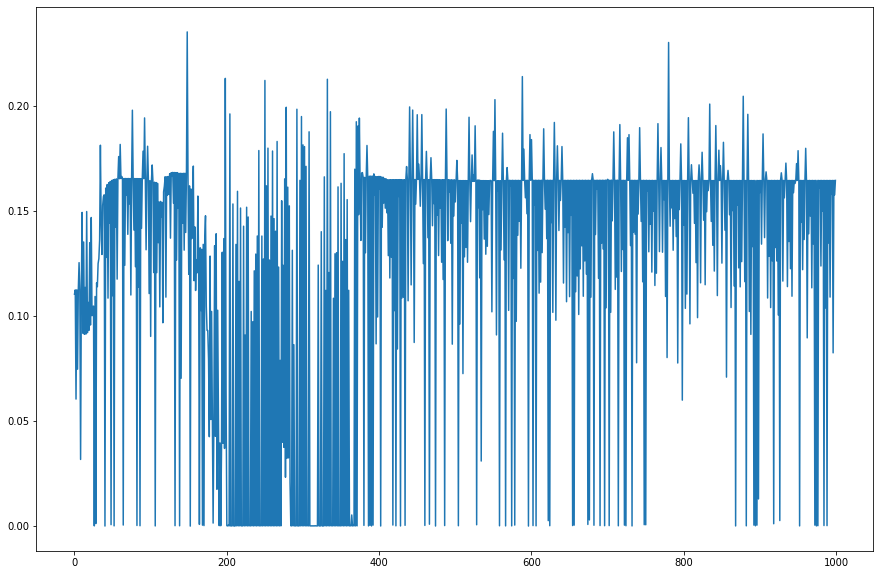

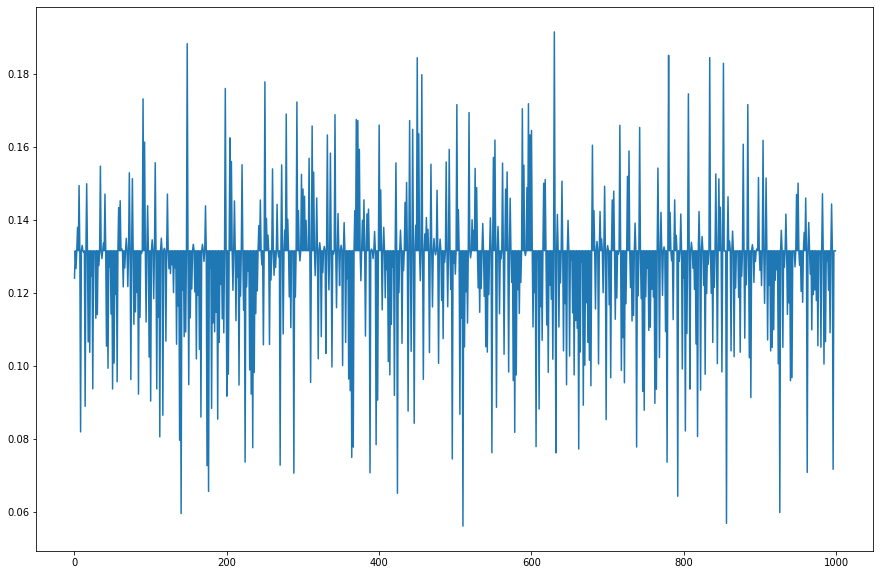

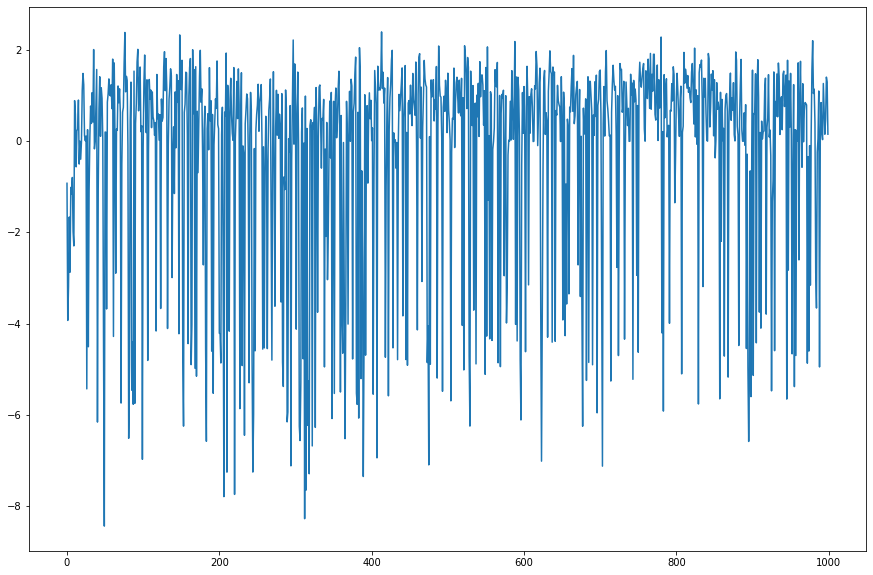

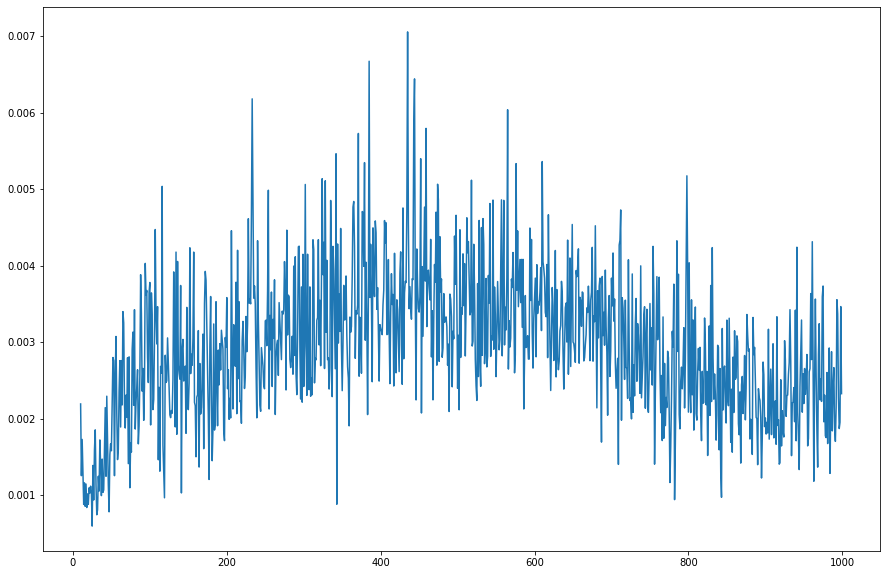

In [13]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):

      
      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            # if episode > 990 or counter == 10:
            #   test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            # if indicator:
            #   counter += 1
            # else:
            #   counter = 0
          break

      # if counter == 11:
      #   break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)
    err = 0.01
    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if abs(prev_wsee - wsee) < err: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K10_AP32_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.005)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.05)
parser.add_argument('--gamma', help='discount factor for critic updates', default=0.3)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 30
nrx = 2
main(args, np.power(10,power/10 - 3), nrx)


In [14]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

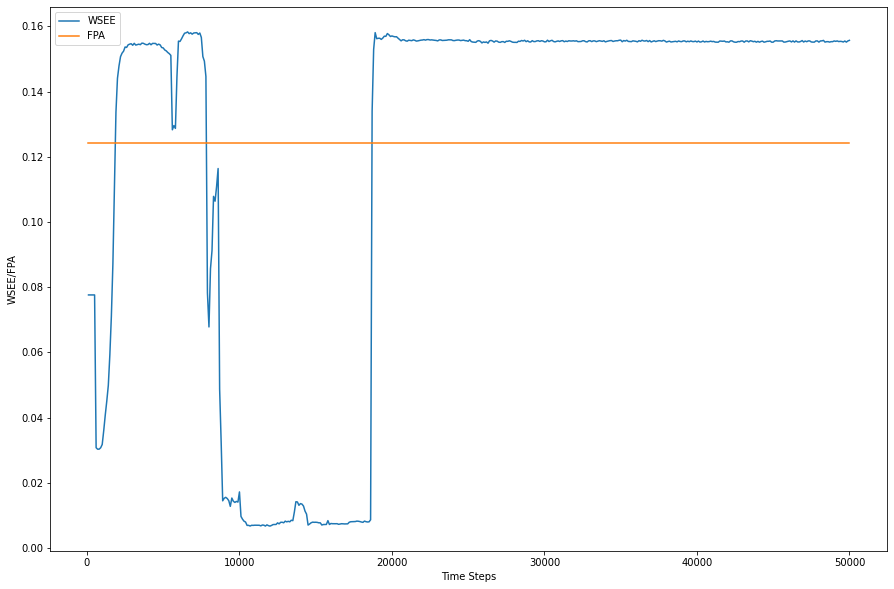

In [15]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

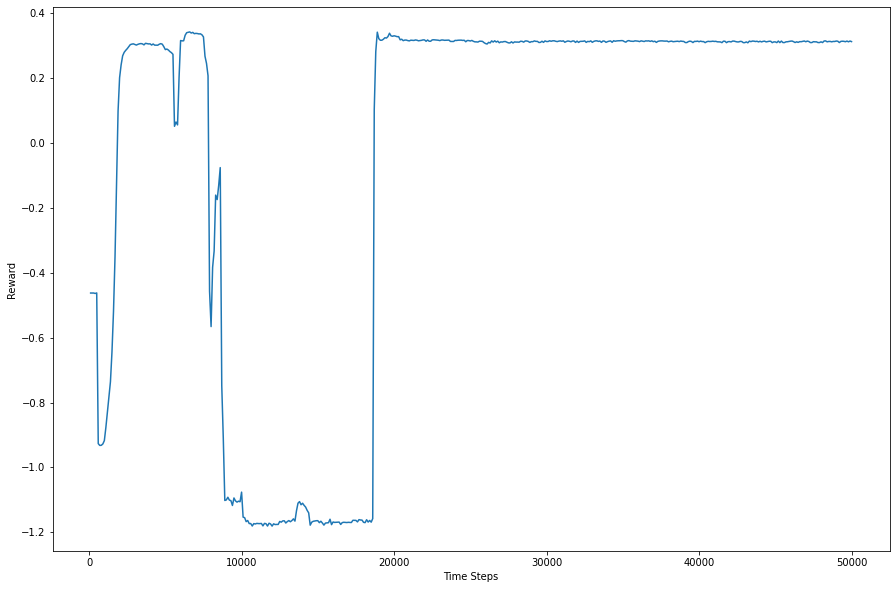

In [16]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
